In [1]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np

/var/folders/v7/5tsbqqss7b73ynyghzvs47mw0000gn/T/ipykernel_87618/2924896692.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
credits = pd.read_csv("tmdb_movie_metadata/tmdb_5000_credits.csv")
credits.rename(columns={'movie_id': 'id'}, inplace=True)
credits.drop("title", axis=1, inplace=True)
movies = pd.read_csv("tmdb_movie_metadata/tmdb_5000_movies.csv")
data = movies.merge(credits, on="id")

print(data.head)

<bound method NDFrame.head of          budget                                             genres  \
0     237000000  [{"id": 28, "name": "Action"}, {"id": 12, "nam...   
1     300000000  [{"id": 12, "name": "Adventure"}, {"id": 14, "...   
2     245000000  [{"id": 28, "name": "Action"}, {"id": 12, "nam...   
3     250000000  [{"id": 28, "name": "Action"}, {"id": 80, "nam...   
4     260000000  [{"id": 28, "name": "Action"}, {"id": 12, "nam...   
...         ...                                                ...   
4798     220000  [{"id": 28, "name": "Action"}, {"id": 80, "nam...   
4799       9000  [{"id": 35, "name": "Comedy"}, {"id": 10749, "...   
4800          0  [{"id": 35, "name": "Comedy"}, {"id": 18, "nam...   
4801          0                                                 []   
4802          0                [{"id": 99, "name": "Documentary"}]   

                                               homepage      id  \
0                           http://www.avatarmovie.com/   1999

In [4]:
print(data.columns)

Index(['budget', 'genres', 'homepage', 'id', 'keywords', 'original_language',
       'original_title', 'overview', 'popularity', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'vote_average',
       'vote_count', 'cast', 'crew'],
      dtype='object')


In [5]:
print(data['cast'])

0       [{"cast_id": 242, "character": "Jake Sully", "...
1       [{"cast_id": 4, "character": "Captain Jack Spa...
2       [{"cast_id": 1, "character": "James Bond", "cr...
3       [{"cast_id": 2, "character": "Bruce Wayne / Ba...
4       [{"cast_id": 5, "character": "John Carter", "c...
                              ...                        
4798    [{"cast_id": 1, "character": "El Mariachi", "c...
4799    [{"cast_id": 1, "character": "Buzzy", "credit_...
4800    [{"cast_id": 8, "character": "Oliver O\u2019To...
4801    [{"cast_id": 3, "character": "Sam", "credit_id...
4802    [{"cast_id": 3, "character": "Herself", "credi...
Name: cast, Length: 4803, dtype: object


In [6]:
print(data.iloc[0]['genres'])

[{"id": 28, "name": "Action"}, {"id": 12, "name": "Adventure"}, {"id": 14, "name": "Fantasy"}, {"id": 878, "name": "Science Fiction"}]


In [7]:
class cast_member:
    def __init__(self, name, character, gender):
        self.name = name
        self.character = character
        self.gender = gender
        
class crew_member:
    def __init__(self, name, job, department):
        self.name = name
        self.job = job
        self.department = department

In [8]:
def convert_dict_to_1d_list(json_str):
    json_dict = json.loads(json_str) 
    return_list = []
    for item in json_dict:
        return_list.append(item['name'])
    return return_list

def convert_dict_to_class_list(json_str, class_type, dimension1, dimension2, dimension3='none'):
    json_dict = json.loads(json_str) 
    return_list = []
    for item in json_dict:
        if class_type == 'cast_members':
            gender = item.get(dimension3, None)
            tmp_person = cast_member(item[dimension1], item[dimension2], gender)
            return_list.append(tmp_person)
        elif class_type == 'crew_members':
            department = item.get(dimension3, None)
            tmp_person = crew_member(item[dimension1], item[dimension2], department)
            return_list.append(tmp_person)
    return return_list

def get_director(crew_list):
    for item in crew_list:
        if item.job == 'Director':
            return item.name
    return 'none'  

def get_crew_member_count_by_job(crew_list, job_type):
    crew_member_count = 0
    for item in crew_list:
        if job_type in item.job:
            crew_member_count += 1
    return crew_member_count  

def get_department_size(crew_list, department):
    department_size = 0
    for item in crew_list:
        if department in item.department:
            department_size += 1
    return department_size

def get_cast_number(cast_list, gender):
    cast_count = 0
    for item in cast_list:
        if str(item.gender) == str(gender):
            cast_count += 1
    return cast_count  

In [9]:
x = data.copy()

x['genres']  =  x['genres'].apply(convert_dict_to_1d_list)
x['keywords'] = x['keywords'].apply(convert_dict_to_1d_list)  
x['production_companies'] = x['production_companies'].apply(convert_dict_to_1d_list)  
x['production_countries'] = x['production_countries'].apply(convert_dict_to_1d_list)

x['country'] = x['production_countries'].apply(lambda x:x[0] if len(x)>0 else None)

x['cast'] = x['cast'].apply(convert_dict_to_class_list, 
                                                              args=('cast_members', 'name', 'character', 'gender'))   
x['crew'] = x['crew'].apply(convert_dict_to_class_list, 
                                                              args=('crew_members', 'name', 'job', 'department'))  

x['director_name'] = x['crew'].apply(get_director)   

x['dominant_genre'] = x['genres'].apply(lambda x:x[0] if len(x)>0 else 'none')  

x['title_year'] = pd.to_datetime(x['release_date']).apply(lambda x:0 if pd.isnull(x.year) else int(x.year))

x['release_week'] = pd.to_datetime(x['release_date']).apply(lambda x:0 if pd.isnull(x.week) else int(x.week))

x['cast_size'] = x['cast'].apply(lambda x:len(x) if len(x)>0 else 0)
x['crew_size'] = x['crew'].apply(lambda x:len(x) if len(x)>0 else 0)
x['number_production_companies'] = x['production_companies'].apply(lambda x:len(x) if len(x)>0 else 0)

x['director_count'] = x['crew'].apply(get_crew_member_count_by_job, args=('Director',))   
x['writer_count'] = x['crew'].apply(get_crew_member_count_by_job, args=('Screenplay',))   
x['editor_count'] = x['crew'].apply(get_crew_member_count_by_job, args=('Editor',))  

x['sound_department_size'] = x['crew'].apply(get_department_size, args=('Sound',))   
x['costume_department_size'] = x['crew'].apply(get_department_size, args=('Costume & Make-Up',)) 
x['editing_department_size'] = x['crew'].apply(get_department_size, args=('Editing',)) 
x['production_department_size'] = x['crew'].apply(get_department_size, args=('Production',)) 
x['art_department_size'] = x['crew'].apply(get_department_size, args=('Art',)) 
x['camera_department_size'] = x['crew'].apply(get_department_size, args=('Camera',)) 
x['vx_department_size'] = x['crew'].apply(get_department_size, args=('Visual Effects',)) 

x['male_cast_count'] = x['cast'].apply(get_cast_number, args = ('2'))
x['female_cast_count'] = x['cast'].apply(get_cast_number, args = ('1'))
x['unstated_gender_cast_count'] = x['cast'].apply(get_cast_number, args = ('0'))

x['spoken_languages'] = x['spoken_languages'].apply(convert_dict_to_1d_list)

# x['genres'] = x['genres'].fillna(None)
# x['keywords'] = x['keywords'].fillna(None)
# x['overview'] = x['overview'].fillna(None)
# x['country'] = x['country'].fillna(None)
# x['director_name'] = x['director_name'].fillna(None)


In [10]:
def one_hot_encoder(df, column_to_encode, control_df, control_subset_size, control_column, output_prefix):
    control_list = set(control_df.nlargest(control_subset_size, control_column)[control_column])
    
    def encode_item(item):
        if isinstance(item, list):
            encoded = {output_prefix + elem.replace(" ", ""): 1 for elem in item if elem in control_list}
        else:
            encoded = {output_prefix + item.replace(" ", ""): 1 if item in control_list else 0}
        return encoded
    
    encoded_data = df[column_to_encode].apply(lambda x: encode_item(x) if pd.notna(x) else {})
    
    encoded_df = pd.DataFrame(list(encoded_data)).fillna(0).astype(int)
    
    df = df.drop(column_to_encode, axis=1).reset_index(drop=True)
    df = pd.concat([df, encoded_df], axis=1)
    
    return df


In [11]:
from collections import defaultdict
def calculate_average_revenue(df, column):
    revenue_sum = defaultdict(float)
    count = defaultdict(int)
    
    for index, row in df.iterrows():
        entities = [row[column]] if isinstance(row[column], str) else row[column]
        if entities is None:
            continue
        for entity in entities:
            revenue_sum[entity] += row['revenue']
            count[entity] += 1
    
    # Calculate average revenue
    average_revenue = {entity: revenue_sum[entity] / count[entity] for entity in revenue_sum}
    
    return average_revenue

def one_hot_encode_top_x_by_revenue(df, columns, top_x):
    one_hot_encoded_dfs = []  # To hold one-hot encoded DataFrames for each column before concatenating
    for column in columns:
        average_revenue = calculate_average_revenue(df, column)
        
        # Sort entities based on average revenue and select top X
        top_entities = sorted(average_revenue, key=average_revenue.get, reverse=True)[:top_x]
        
        # Prepare a dict to hold the encoded data
        encoded_data = {f'{column}_is_{entity}': [] for entity in top_entities}
        
        # Fill in the encoded data
        for index, row in df.iterrows():
            entities = [row[column]] if isinstance(row[column], str) else row[column]
            if entities is None:
                for entity in top_entities:
                    encoded_data[f'{column}_is_{entity}'].append(0)
                continue
            for entity in top_entities:
                encoded_data[f'{column}_is_{entity}'].append(1 if entity in entities else 0)
        
        # Convert the encoded data to a DataFrame
        encoded_df = pd.DataFrame(encoded_data, index=df.index)
        one_hot_encoded_dfs.append(encoded_df)
    
    # Concatenate all one-hot encoded DataFrames with the original DataFrame
    df = pd.concat([df] + one_hot_encoded_dfs, axis=1)
    
    return df

In [12]:
# Save DataFrame to a CSV file
x.to_csv('moviesdataset.csv', index=False)

data_dict = x.to_dict()


In [14]:
columns_to_encode = ['director_name', 'production_companies', 'genres', 'spoken_languages', 'country', ]
x_onehot = one_hot_encode_top_x_by_revenue(x, columns_to_encode, top_x=10000)

In [16]:
columns_to_drop = ['genres', 'homepage', 'id', 'keywords', 'original_language',
                   'original_title', 'overview', 'production_companies',
                   'production_countries', 'release_date', 'spoken_languages', 
                   'status', 'tagline', 'title', 'director_name', 'country',
                   'cast', 'crew', 'id', 'dominant_genre', 'vote_count', 'popularity', 'vote_average']

x_cleaned = x_onehot.drop(columns=columns_to_drop)
x_cleaned = x_cleaned.fillna(0)

In [17]:
x_cleaned.columns[:25]

Index(['budget', 'revenue', 'runtime', 'title_year', 'release_week',
       'cast_size', 'crew_size', 'number_production_companies',
       'director_count', 'writer_count', 'editor_count',
       'sound_department_size', 'costume_department_size',
       'editing_department_size', 'production_department_size',
       'art_department_size', 'camera_department_size', 'vx_department_size',
       'male_cast_count', 'female_cast_count', 'unstated_gender_cast_count',
       'director_name_is_Chris Buck', 'director_name_is_Kyle Balda',
       'director_name_is_Lee Unkrich', 'director_name_is_Joss Whedon'],
      dtype='object')

In [18]:
x_cleaned.columns[25:]

Index(['director_name_is_Chris Renaud', 'director_name_is_James Cameron',
       'director_name_is_Roger Allers', 'director_name_is_Tim Miller',
       'director_name_is_Colin Trevorrow', 'director_name_is_Robert Stromberg',
       'director_name_is_Pierre Coffin', 'director_name_is_Dan Scanlon',
       'director_name_is_David Yates', 'director_name_is_Peter Jackson',
       ...
       'country_is_Kyrgyz Republic', 'country_is_Algeria', 'country_is_Guyana',
       'country_is_Pakistan', 'country_is_Guadaloupe', 'country_is_Slovenia',
       'country_is_Afghanistan', 'country_is_Dominican Republic',
       'country_is_Cameroon', 'country_is_Kenya'],
      dtype='object', length=7515)

In [19]:
Y = x_cleaned['revenue']
X = x_cleaned.drop('revenue', axis=1)

from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [49]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

gbr = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

gbr.fit(X_train, Y_train)

Y_train_pred = gbr.predict(X_train)
Y_test_pred = gbr.predict(X_test)

print("Training Set Performance:")
print("Mean Squared Error:", mean_squared_error(Y_train, Y_train_pred))
print("R^2 Score:", r2_score(Y_train, Y_train_pred))

print("\nTest Set Performance:")
print("Mean Squared Error:", mean_squared_error(Y_test, Y_test_pred))
print("R^2 Score:", r2_score(Y_test, Y_test_pred))

Training Set Performance:
Mean Squared Error: 5125696963652621.0
R^2 Score: 0.8075406019623264

Test Set Performance:
Mean Squared Error: 7673429940446555.0
R^2 Score: 0.7053900313109331


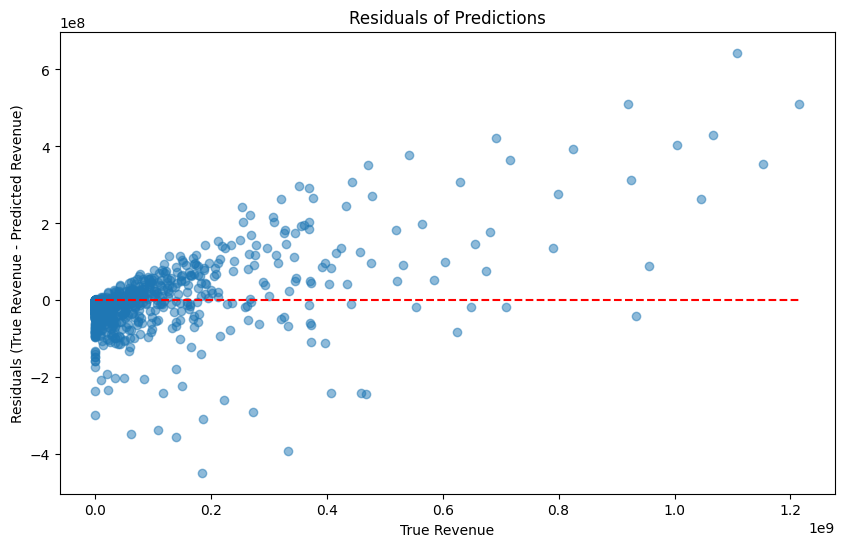

In [50]:
residuals = Y_test - Y_test_pred

plt.figure(figsize=(10, 6))
plt.scatter(Y_test, residuals, alpha=0.5)
plt.title('Residuals of Predictions')
plt.xlabel('True Revenue')
plt.ylabel('Residuals (True Revenue - Predicted Revenue)')
plt.hlines(y=0, xmin=Y_test.min(), xmax=Y_test.max(), colors='red', linestyles='--')
plt.show()


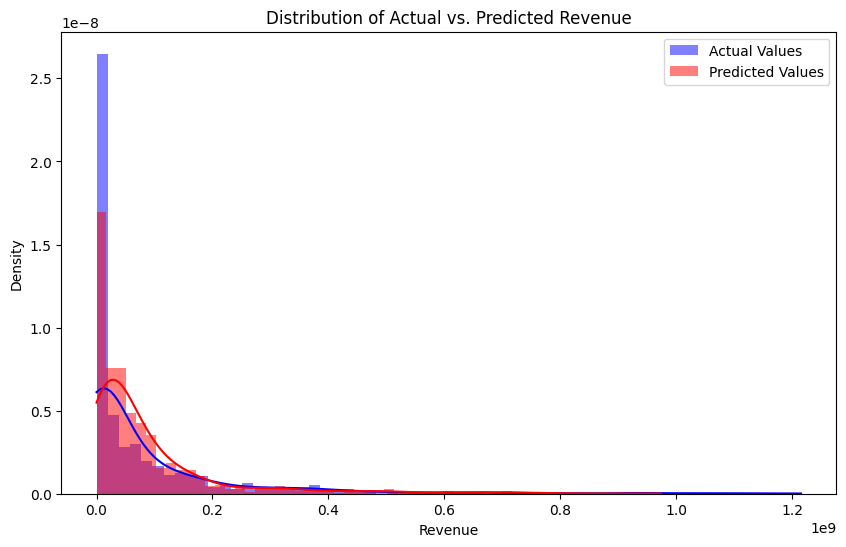

In [52]:
import seaborn as sns
plt.figure(figsize=(10, 6))

sns.histplot(Y_test, color="blue", label="Actual Values", kde=True, stat="density", linewidth=0)
sns.histplot(Y_test_pred, color="red", label="Predicted Values", kde=True, stat="density", linewidth=0)

plt.title('Distribution of Actual vs. Predicted Revenue')
plt.xlabel('Revenue')
plt.ylabel('Density')
plt.legend()
plt.show()


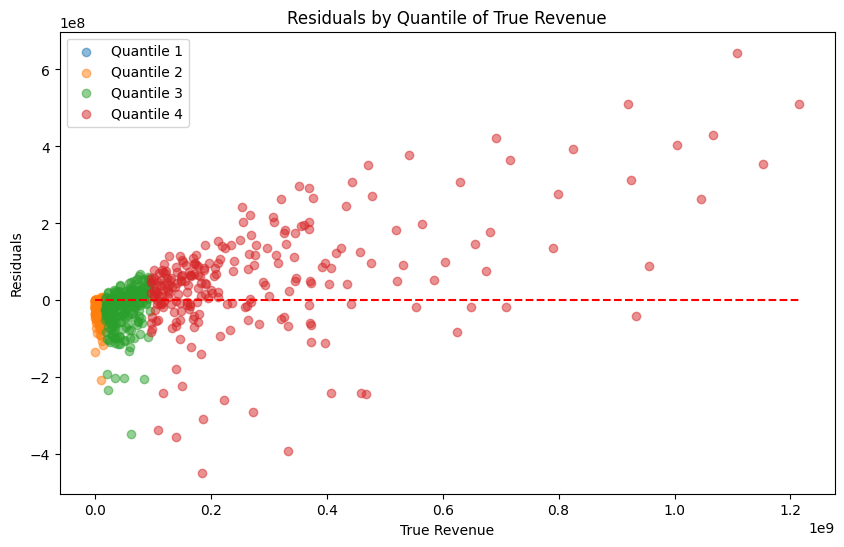

In [53]:
quantile_list = np.percentile(Y_test, [25, 50, 75, 100])

residuals = Y_test - Y_test_pred

plt.figure(figsize=(10, 6))
for i, quantile in enumerate(quantile_list):
    in_quantile = (Y_test <= quantile) & (Y_test > (quantile_list[i-1] if i > 0 else 0))
    plt.scatter(Y_test[in_quantile], residuals[in_quantile], alpha=0.5, label=f'Quantile {i+1}')

plt.title('Residuals by Quantile of True Revenue')
plt.xlabel('True Revenue')
plt.ylabel('Residuals')
plt.legend()
plt.hlines(y=0, xmin=Y_test.min(), xmax=Y_test.max(), colors='red', linestyles='--')
plt.show()

Index(['genres_is_Adventure', 'costume_department_size', 'crew_size',
       'genres_is_Drama', 'title_year',
       'production_companies_is_WingNut Films',
       'production_companies_is_Amblin Entertainment', 'release_week',
       'production_companies_is_Lucasfilm', 'runtime', 'genres_is_Animation',
       'production_companies_is_Fuji Television Network', 'male_cast_count',
       'director_name_is_James Cameron',
       'production_companies_is_Illumination Entertainment',
       'female_cast_count', 'vx_department_size',
       'production_companies_is_Lightstorm Entertainment', 'cast_size',
       'budget'],
      dtype='object')


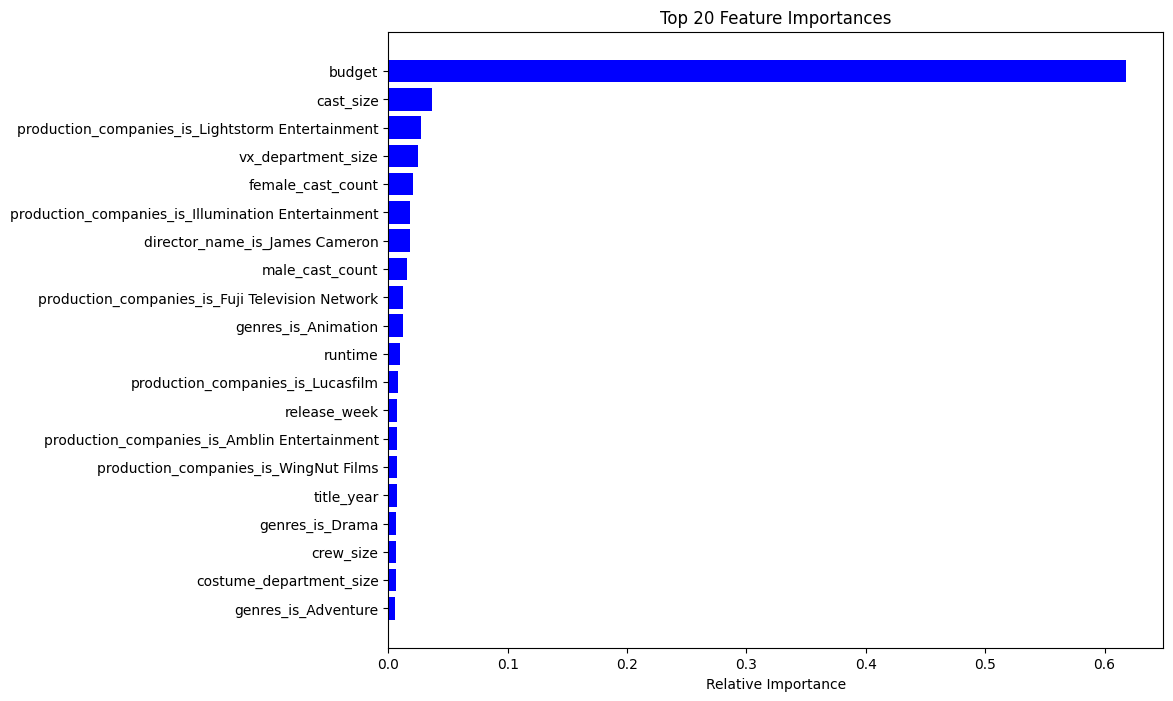

In [54]:
feature_importances = gbr.feature_importances_

indices = np.argsort(feature_importances)[-20:]

top_features = X_train.columns[indices]
print(top_features)
top_importances = feature_importances[indices]

# Plotting
plt.figure(figsize=(10, 8))
plt.title('Top 20 Feature Importances')
plt.barh(range(len(indices)), top_importances, color='b', align='center')
plt.yticks(range(len(indices)), [top_features[i] for i in range(len(indices))])
plt.xlabel('Relative Importance')
plt.show()


In [ ]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(gbr, X, Y, cv=5, scoring='neg_mean_squared_error')
print("Cross-validated scores:", scores)


In [57]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score


base_estimator = DecisionTreeRegressor(max_depth=3)

ada_boost_reg = AdaBoostRegressor(estimator=base_estimator, random_state=42)

param_grid = {
    'n_estimators': [50, 100, 200, 500],
    'learning_rate': [0.001, 0.01, 0.1, 1],
    'loss': ['linear', 'square', 'exponential']
}

grid_search = GridSearchCV(ada_boost_reg, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

grid_search.fit(X_train, Y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Score (MSE):", -grid_search.best_score_)

best_reg = grid_search.best_estimator_
Y_test_pred = best_reg.predict(X_test)

mse = mean_squared_error(Y_test, Y_test_pred)
r2 = r2_score(Y_test, Y_test_pred)

print("Test Set Mean Squared Error:", mse)
print("Test Set R^2 Score:", r2)


/Users/noahmeislik/Desktop/Projects/box-officer/env/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best Parameters: {'learning_rate': 0.01, 'loss': 'exponential', 'n_estimators': 500}
Best Score (MSE): 1.254738548028497e+16
Test Set Mean Squared Error: 8882784517663956.0
Test Set R^2 Score: 0.6589586548739099


In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler

In [29]:
class CustomDNN(nn.Module):
    def __init__(self, input_shape, num_neurons=[128, 64, 32], dropout_rate=0.2):
        super(CustomDNN, self).__init__()
        self.layers = nn.ModuleList()
        for output_features in num_neurons:
            self.layers.append(nn.Linear(input_shape, output_features))
            self.layers.append(nn.ReLU())
            self.layers.append(nn.Dropout(dropout_rate))
            input_shape = output_features

        self.layers.append(nn.Linear(num_neurons[-1], 1))
    
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x


In [36]:
from sklearn.base import BaseEstimator, RegressorMixin
from torch.utils.data import DataLoader, TensorDataset

class PyTorchRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, model_class, input_shape, num_neurons=[128, 64, 32], dropout_rate=0.2, learning_rate=0.001, epochs=100, batch_size=32):
        self.model_class = model_class
        self.input_shape = input_shape
        self.num_neurons = num_neurons
        self.dropout_rate = dropout_rate
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.batch_size = batch_size
        self.model = self.model_class(input_shape, num_neurons, dropout_rate)
    
    def fit(self, X, y):
        X_tensor = torch.tensor(X.astype(np.float32))
        y_tensor = torch.tensor(y.astype(np.float32)).view(-1, 1)
        dataset = TensorDataset(X_tensor, y_tensor)
        dataloader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)
        
        optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        criterion = nn.MSELoss()
        
        self.model.train()
        for epoch in tqdm(range(self.epochs), desc="Epochs"):
            epoch_loss = 0.0
            for batch_X, batch_y in dataloader:
                optimizer.zero_grad()
                outputs = self.model(batch_X)
                loss = criterion(outputs, batch_y)
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item()
            # print(f"Epoch {epoch+1}/{self.epochs}, Loss: {epoch_loss/len(dataloader)}")
        return self
    
    def predict(self, X):
        self.model.eval()
        with torch.no_grad():
            X_tensor = torch.tensor(X.astype(np.float32))
            predictions = self.model(X_tensor).squeeze()
        return predictions.numpy()
    
    def score(self, X, y):
        predictions = self.predict(X)
        return -mean_squared_error(y, predictions)


In [41]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train.to_numpy())
X_test_scaled = scaler_X.transform(X_test.to_numpy()) 
Y_train_scaled = scaler_y.fit_transform(Y_train.to_numpy().reshape(-1, 1)).flatten()


model = PyTorchRegressor(CustomDNN, input_shape=X_train_scaled.shape[1])

param_grid = {
    'num_neurons': [[128, 64, 32], [256, 128, 64]], # [72, 128, 256, 128, 72, 6, ]
    'dropout_rate': [0.2, 0.3],
    'learning_rate': [0.01, 0.001, 0.0001],
    'epochs': [100],
    'batch_size': [32, 64]
}

grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error')
grid_result = grid.fit(X_train_scaled, Y_train_scaled)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))


Epochs:   1%|          | 1/100 [00:00<00:33,  2.95it/s]

Epoch 1/100, Loss: 0.6883423094764168


Epochs:   2%|▏         | 2/100 [00:00<00:32,  3.03it/s]

Epoch 2/100, Loss: 0.5077095778406034


Epochs:   3%|▎         | 3/100 [00:00<00:31,  3.09it/s]

Epoch 3/100, Loss: 0.5053530809136084


Epochs:   4%|▍         | 4/100 [00:01<00:29,  3.21it/s]

Epoch 4/100, Loss: 0.7639680762349823


Epochs:   5%|▌         | 5/100 [00:01<00:29,  3.21it/s]

Epoch 5/100, Loss: 0.6996014472787027


Epochs:   6%|▌         | 6/100 [00:01<00:29,  3.23it/s]

Epoch 6/100, Loss: 0.629461944103241


Epochs:   7%|▋         | 7/100 [00:02<00:28,  3.27it/s]

Epoch 7/100, Loss: 0.6896726921384717


Epochs:   8%|▊         | 8/100 [00:02<00:28,  3.28it/s]

Epoch 8/100, Loss: 0.8010246067503353


Epochs:   9%|▉         | 9/100 [00:02<00:27,  3.28it/s]

Epoch 9/100, Loss: 0.9089566195084725


Epochs:  10%|█         | 10/100 [00:03<00:27,  3.28it/s]

Epoch 10/100, Loss: 1.073151347629818


Epochs:  11%|█         | 11/100 [00:03<00:27,  3.27it/s]

Epoch 11/100, Loss: 0.7611120172120907


Epochs:  12%|█▏        | 12/100 [00:03<00:27,  3.25it/s]

Epoch 12/100, Loss: 0.7176882010183216


Epochs:  13%|█▎        | 13/100 [00:04<00:27,  3.20it/s]

Epoch 13/100, Loss: 0.7344916630306362


Epochs:  14%|█▍        | 14/100 [00:04<00:27,  3.17it/s]

Epoch 14/100, Loss: 0.7197146550004865


Epochs:  15%|█▌        | 15/100 [00:04<00:28,  2.93it/s]

Epoch 15/100, Loss: 0.7223842488946738


Epochs:  16%|█▌        | 16/100 [00:05<00:29,  2.86it/s]

Epoch 16/100, Loss: 0.6889282887870515


Epochs:  17%|█▋        | 17/100 [00:05<00:28,  2.90it/s]

Epoch 17/100, Loss: 0.7049196233719955


Epochs:  18%|█▊        | 18/100 [00:05<00:27,  2.97it/s]

Epoch 18/100, Loss: 0.6990023799884466


Epochs:  19%|█▉        | 19/100 [00:06<00:27,  3.00it/s]

Epoch 19/100, Loss: 0.7056315042434927


Epochs:  20%|██        | 20/100 [00:06<00:26,  2.97it/s]

Epoch 20/100, Loss: 0.6859895820143046


Epochs:  21%|██        | 21/100 [00:06<00:25,  3.04it/s]

Epoch 21/100, Loss: 0.6876551173742355


Epochs:  22%|██▏       | 22/100 [00:07<00:25,  3.02it/s]

Epoch 22/100, Loss: 0.6968461526672781


Epochs:  23%|██▎       | 23/100 [00:07<00:26,  2.95it/s]

Epoch 23/100, Loss: 0.685431440671285


Epochs:  24%|██▍       | 24/100 [00:07<00:24,  3.05it/s]

Epoch 24/100, Loss: 0.703591458749509


Epochs:  25%|██▌       | 25/100 [00:08<00:24,  3.07it/s]

Epoch 25/100, Loss: 0.7129244366545736


Epochs:  26%|██▌       | 26/100 [00:08<00:24,  3.05it/s]

Epoch 26/100, Loss: 0.7217799850946499


Epochs:  27%|██▋       | 27/100 [00:08<00:23,  3.10it/s]

Epoch 27/100, Loss: 0.7014680096396694


Epochs:  28%|██▊       | 28/100 [00:09<00:23,  3.06it/s]

Epoch 28/100, Loss: 0.6745400773706259


Epochs:  29%|██▉       | 29/100 [00:09<00:23,  3.01it/s]

Epoch 29/100, Loss: 0.7120425516716492


Epochs:  30%|███       | 30/100 [00:09<00:23,  2.97it/s]

Epoch 30/100, Loss: 0.723408162927278


Epochs:  31%|███       | 31/100 [00:10<00:22,  3.05it/s]

Epoch 31/100, Loss: 0.7191630903585458


Epochs:  32%|███▏      | 32/100 [00:10<00:21,  3.13it/s]

Epoch 32/100, Loss: 0.6926429730690555


Epochs:  33%|███▎      | 33/100 [00:10<00:20,  3.20it/s]

Epoch 33/100, Loss: 0.6830606971993859


Epochs:  34%|███▍      | 34/100 [00:11<00:22,  2.90it/s]

Epoch 34/100, Loss: 0.6778591142300471


Epochs:  35%|███▌      | 35/100 [00:11<00:21,  2.99it/s]

Epoch 35/100, Loss: 0.666730136461096


Epochs:  36%|███▌      | 36/100 [00:11<00:20,  3.09it/s]

Epoch 36/100, Loss: 0.6940673988910369


Epochs:  37%|███▋      | 37/100 [00:12<00:20,  3.11it/s]

Epoch 37/100, Loss: 0.9252494809528192


Epochs:  38%|███▊      | 38/100 [00:12<00:20,  3.08it/s]

Epoch 38/100, Loss: 0.6792003943780323


Epochs:  39%|███▉      | 39/100 [00:12<00:20,  3.02it/s]

Epoch 39/100, Loss: 0.715160134765837


Epochs:  40%|████      | 40/100 [00:13<00:20,  2.94it/s]

Epoch 40/100, Loss: 0.6948280531315156


Epochs:  41%|████      | 41/100 [00:13<00:20,  2.92it/s]

Epoch 41/100, Loss: 0.6998209593656622


Epochs:  42%|████▏     | 42/100 [00:13<00:19,  3.04it/s]

Epoch 42/100, Loss: 0.6846033720541056


Epochs:  43%|████▎     | 43/100 [00:13<00:18,  3.12it/s]

Epoch 43/100, Loss: 0.6855893729277599


Epochs:  44%|████▍     | 44/100 [00:14<00:18,  2.95it/s]

Epoch 44/100, Loss: 0.8096058126768948


Epochs:  45%|████▌     | 45/100 [00:14<00:18,  2.93it/s]

Epoch 45/100, Loss: 0.6710835514521157


Epochs:  46%|████▌     | 46/100 [00:15<00:18,  2.90it/s]

Epoch 46/100, Loss: 0.6827705875958925


Epochs:  47%|████▋     | 47/100 [00:15<00:17,  2.95it/s]

Epoch 47/100, Loss: 0.71040955958543


Epochs:  48%|████▊     | 48/100 [00:15<00:17,  3.04it/s]

Epoch 48/100, Loss: 0.6943393042684751


Epochs:  49%|████▉     | 49/100 [00:16<00:16,  3.06it/s]

Epoch 49/100, Loss: 0.7150002664621965


Epochs:  50%|█████     | 50/100 [00:16<00:16,  3.12it/s]

Epoch 50/100, Loss: 0.6887359121515427


Epochs:  51%|█████     | 51/100 [00:16<00:15,  3.11it/s]

Epoch 51/100, Loss: 1.5129749866915339


Epochs:  52%|█████▏    | 52/100 [00:16<00:15,  3.06it/s]

Epoch 52/100, Loss: 0.7104922871530792


Epochs:  53%|█████▎    | 53/100 [00:17<00:15,  2.99it/s]

Epoch 53/100, Loss: 0.6900724356557116


Epochs:  54%|█████▍    | 54/100 [00:17<00:15,  2.94it/s]

Epoch 54/100, Loss: 0.6731618613372614


Epochs:  55%|█████▌    | 55/100 [00:18<00:16,  2.78it/s]

Epoch 55/100, Loss: 0.6924859434366226


Epochs:  56%|█████▌    | 56/100 [00:18<00:15,  2.78it/s]

Epoch 56/100, Loss: 0.706354104258396


Epochs:  57%|█████▋    | 57/100 [00:18<00:15,  2.82it/s]

Epoch 57/100, Loss: 0.6718195071328937


Epochs:  58%|█████▊    | 58/100 [00:19<00:14,  2.81it/s]

Epoch 58/100, Loss: 0.6837687407746728


Epochs:  59%|█████▉    | 59/100 [00:19<00:14,  2.88it/s]

Epoch 59/100, Loss: 0.9927421610020561


Epochs:  60%|██████    | 60/100 [00:19<00:13,  2.90it/s]

Epoch 60/100, Loss: 0.6965468903014689


Epochs:  61%|██████    | 61/100 [00:20<00:13,  2.88it/s]

Epoch 61/100, Loss: 0.6952496540767176


Epochs:  62%|██████▏   | 62/100 [00:20<00:12,  2.94it/s]

Epoch 62/100, Loss: 0.6707323569097314


Epochs:  63%|██████▎   | 63/100 [00:20<00:12,  2.96it/s]

Epoch 63/100, Loss: 0.6705347433870221


Epochs:  64%|██████▍   | 64/100 [00:21<00:12,  2.94it/s]

Epoch 64/100, Loss: 0.7154265062992725


Epochs:  65%|██████▌   | 65/100 [00:21<00:11,  2.96it/s]

Epoch 65/100, Loss: 0.6883874865777698


Epochs:  66%|██████▌   | 66/100 [00:21<00:11,  2.93it/s]

Epoch 66/100, Loss: 0.6941751090832698


Epochs:  67%|██████▋   | 67/100 [00:22<00:11,  2.98it/s]

Epoch 67/100, Loss: 0.6811012272539728


Epochs:  68%|██████▊   | 68/100 [00:22<00:10,  2.92it/s]

Epoch 68/100, Loss: 0.6687068724889814


Epochs:  69%|██████▉   | 69/100 [00:22<00:10,  2.99it/s]

Epoch 69/100, Loss: 0.707469815166989


Epochs:  70%|███████   | 70/100 [00:23<00:10,  2.96it/s]

Epoch 70/100, Loss: 0.6558749070850971


Epochs:  71%|███████   | 71/100 [00:23<00:09,  2.92it/s]

Epoch 71/100, Loss: 0.6756479954921905


Epochs:  72%|███████▏  | 72/100 [00:23<00:10,  2.78it/s]

Epoch 72/100, Loss: 0.663353147238125


Epochs:  73%|███████▎  | 73/100 [00:24<00:09,  2.90it/s]

Epoch 73/100, Loss: 0.726036817525272


Epochs:  74%|███████▍  | 74/100 [00:24<00:08,  3.00it/s]

Epoch 74/100, Loss: 0.6609796621365311


Epochs:  75%|███████▌  | 75/100 [00:24<00:07,  3.13it/s]

Epoch 75/100, Loss: 0.6937329266910199


Epochs:  76%|███████▌  | 76/100 [00:25<00:07,  3.16it/s]

Epoch 76/100, Loss: 0.6684056327183857


Epochs:  77%|███████▋  | 77/100 [00:25<00:07,  3.24it/s]

Epoch 77/100, Loss: 0.6888649631981496


Epochs:  78%|███████▊  | 78/100 [00:25<00:06,  3.28it/s]

Epoch 78/100, Loss: 0.9611413927725804


Epochs:  79%|███████▉  | 79/100 [00:26<00:06,  3.34it/s]

Epoch 79/100, Loss: 0.6916413014685666


Epochs:  80%|████████  | 80/100 [00:26<00:05,  3.37it/s]

Epoch 80/100, Loss: 0.7418749624932254


Epochs:  81%|████████  | 81/100 [00:26<00:05,  3.39it/s]

Epoch 81/100, Loss: 0.7044091065540726


Epochs:  82%|████████▏ | 82/100 [00:26<00:05,  3.42it/s]

Epoch 82/100, Loss: 0.6695646068005267


Epochs:  83%|████████▎ | 83/100 [00:27<00:05,  3.22it/s]

Epoch 83/100, Loss: 0.8049670867161987


Epochs:  84%|████████▍ | 84/100 [00:27<00:05,  3.15it/s]

Epoch 84/100, Loss: 0.701614719769561


Epochs:  85%|████████▌ | 85/100 [00:27<00:04,  3.14it/s]

Epoch 85/100, Loss: 0.6669108763245153


Epochs:  86%|████████▌ | 86/100 [00:28<00:04,  3.06it/s]

Epoch 86/100, Loss: 0.6624806020178913


Epochs:  87%|████████▋ | 87/100 [00:28<00:04,  2.99it/s]

Epoch 87/100, Loss: 0.6653603251885485


Epochs:  88%|████████▊ | 88/100 [00:28<00:03,  3.06it/s]

Epoch 88/100, Loss: 0.6991766455876468


Epochs:  89%|████████▉ | 89/100 [00:29<00:03,  3.10it/s]

Epoch 89/100, Loss: 0.6688240256410575


Epochs:  90%|█████████ | 90/100 [00:29<00:03,  3.11it/s]

Epoch 90/100, Loss: 0.6673936742576368


Epochs:  91%|█████████ | 91/100 [00:29<00:02,  3.15it/s]

Epoch 91/100, Loss: 0.6757580052923273


Epochs:  92%|█████████▏| 92/100 [00:30<00:02,  3.19it/s]

Epoch 92/100, Loss: 0.6955603527503065


Epochs:  93%|█████████▎| 93/100 [00:30<00:02,  3.17it/s]

Epoch 93/100, Loss: 0.6573359977287229


Epochs:  94%|█████████▍| 94/100 [00:30<00:01,  3.11it/s]

Epoch 94/100, Loss: 0.9080019605196552


Epochs:  95%|█████████▌| 95/100 [00:31<00:01,  3.15it/s]

Epoch 95/100, Loss: 0.6745651127931512


Epochs:  96%|█████████▌| 96/100 [00:31<00:01,  3.06it/s]

Epoch 96/100, Loss: 0.6856049715920731


Epochs:  97%|█████████▋| 97/100 [00:31<00:00,  3.11it/s]

Epoch 97/100, Loss: 0.6618041267365585


Epochs:  98%|█████████▊| 98/100 [00:32<00:00,  3.16it/s]

Epoch 98/100, Loss: 0.6812285740434387


Epochs:  99%|█████████▉| 99/100 [00:32<00:00,  3.09it/s]

Epoch 99/100, Loss: 0.6638121314944676


Epochs: 100%|██████████| 100/100 [00:32<00:00,  3.05it/s]


Epoch 100/100, Loss: 0.6614035540289119


Epochs:   1%|          | 1/100 [00:00<00:51,  1.91it/s]

Epoch 1/100, Loss: 0.9243441702407084


Epochs:   2%|▏         | 2/100 [00:01<00:52,  1.88it/s]

Epoch 2/100, Loss: 0.9276090569817174


Epochs:   3%|▎         | 3/100 [00:01<00:50,  1.90it/s]

Epoch 3/100, Loss: 0.5818817098337559


Epochs:   4%|▍         | 4/100 [00:02<00:51,  1.87it/s]

Epoch 4/100, Loss: 0.5249764985508389


Epochs:   5%|▌         | 5/100 [00:02<00:43,  2.16it/s]

Epoch 5/100, Loss: 0.6035004090747715


Epochs:   6%|▌         | 6/100 [00:02<00:41,  2.25it/s]

Epoch 6/100, Loss: 0.715655917968647


Epochs:   7%|▋         | 7/100 [00:03<00:37,  2.50it/s]

Epoch 7/100, Loss: 0.9865565936966443


Epochs:   8%|▊         | 8/100 [00:03<00:34,  2.70it/s]

Epoch 8/100, Loss: 0.9770189732497121


Epochs:   9%|▉         | 9/100 [00:03<00:31,  2.85it/s]

Epoch 9/100, Loss: 0.8390124846755722


Epochs:  10%|█         | 10/100 [00:04<00:30,  2.98it/s]

Epoch 10/100, Loss: 1.0913316052820947


Epochs:  11%|█         | 11/100 [00:04<00:29,  3.03it/s]

Epoch 11/100, Loss: 0.9671454643025811


Epochs:  12%|█▏        | 12/100 [00:04<00:28,  3.12it/s]

Epoch 12/100, Loss: 1.0141799541471963


Epochs:  13%|█▎        | 13/100 [00:05<00:27,  3.15it/s]

Epoch 13/100, Loss: 1.0091050854067745


Epochs:  14%|█▍        | 14/100 [00:05<00:27,  3.11it/s]

Epoch 14/100, Loss: 1.0821862121423085


Epochs:  15%|█▌        | 15/100 [00:05<00:27,  3.06it/s]

Epoch 15/100, Loss: 0.9493817153421266


Epochs:  16%|█▌        | 16/100 [00:06<00:27,  3.09it/s]

Epoch 16/100, Loss: 1.0665195742507039


Epochs:  17%|█▋        | 17/100 [00:06<00:26,  3.08it/s]

Epoch 17/100, Loss: 0.9780590563644598


Epochs:  18%|█▊        | 18/100 [00:06<00:26,  3.13it/s]

Epoch 18/100, Loss: 0.9328375866199717


Epochs:  19%|█▉        | 19/100 [00:06<00:25,  3.13it/s]

Epoch 19/100, Loss: 1.016860674376841


Epochs:  20%|██        | 20/100 [00:07<00:25,  3.15it/s]

Epoch 20/100, Loss: 0.9408175571833128


Epochs:  21%|██        | 21/100 [00:07<00:24,  3.18it/s]

Epoch 21/100, Loss: 0.939403999366878


Epochs:  22%|██▏       | 22/100 [00:07<00:24,  3.16it/s]

Epoch 22/100, Loss: 0.9486148309560469


Epochs:  23%|██▎       | 23/100 [00:08<00:24,  3.19it/s]

Epoch 23/100, Loss: 1.1366926748075603


Epochs:  24%|██▍       | 24/100 [00:08<00:23,  3.19it/s]

Epoch 24/100, Loss: 1.154144662156425


Epochs:  25%|██▌       | 25/100 [00:08<00:23,  3.20it/s]

Epoch 25/100, Loss: 1.0881997619146182


Epochs:  26%|██▌       | 26/100 [00:09<00:23,  3.15it/s]

Epoch 26/100, Loss: 1.0887911203834746


Epochs:  27%|██▋       | 27/100 [00:09<00:22,  3.18it/s]

Epoch 27/100, Loss: 1.0856483649335986


Epochs:  28%|██▊       | 28/100 [00:09<00:22,  3.15it/s]

Epoch 28/100, Loss: 1.086488605465418


Epochs:  29%|██▉       | 29/100 [00:10<00:22,  3.17it/s]

Epoch 29/100, Loss: 1.0878883396033887


Epochs:  30%|███       | 30/100 [00:10<00:22,  3.10it/s]

Epoch 30/100, Loss: 1.087555710732201


Epochs:  31%|███       | 31/100 [00:10<00:23,  2.96it/s]

Epoch 31/100, Loss: 1.0848305989861673


Epochs:  32%|███▏      | 32/100 [00:11<00:25,  2.70it/s]

Epoch 32/100, Loss: 1.0862934819342178


Epochs:  33%|███▎      | 33/100 [00:11<00:25,  2.60it/s]

Epoch 33/100, Loss: 1.0874309642815296


Epochs:  34%|███▍      | 34/100 [00:12<00:27,  2.41it/s]

Epoch 34/100, Loss: 1.0880265217504383


Epochs:  35%|███▌      | 35/100 [00:12<00:25,  2.51it/s]

Epoch 35/100, Loss: 1.0877728854064588


Epochs:  36%|███▌      | 36/100 [00:12<00:24,  2.63it/s]

Epoch 36/100, Loss: 1.10971950215322


Epochs:  37%|███▋      | 37/100 [00:13<00:22,  2.82it/s]

Epoch 37/100, Loss: 1.2889478355646133


Epochs:  38%|███▊      | 38/100 [00:13<00:21,  2.94it/s]

Epoch 38/100, Loss: 1.088465363132181


Epochs:  39%|███▉      | 39/100 [00:13<00:20,  2.99it/s]

Epoch 39/100, Loss: 1.0846429292089592


Epochs:  40%|████      | 40/100 [00:14<00:19,  3.12it/s]

Epoch 40/100, Loss: 1.085297778248787


Epochs:  41%|████      | 41/100 [00:14<00:18,  3.22it/s]

Epoch 41/100, Loss: 1.0880662383120736


Epochs:  42%|████▏     | 42/100 [00:14<00:17,  3.25it/s]

Epoch 42/100, Loss: 1.0883106729130687


Epochs:  43%|████▎     | 43/100 [00:14<00:17,  3.29it/s]

Epoch 43/100, Loss: 1.2601532461466614


Epochs:  44%|████▍     | 44/100 [00:15<00:16,  3.30it/s]

Epoch 44/100, Loss: 1.0894255926947536


Epochs:  45%|████▌     | 45/100 [00:15<00:16,  3.33it/s]

Epoch 45/100, Loss: 1.0854592597411004


Epochs:  46%|████▌     | 46/100 [00:15<00:16,  3.33it/s]

Epoch 46/100, Loss: 1.0847115206624163


Epochs:  47%|████▋     | 47/100 [00:16<00:15,  3.36it/s]

Epoch 47/100, Loss: 1.087610352186509


Epochs:  48%|████▊     | 48/100 [00:16<00:16,  3.25it/s]

Epoch 48/100, Loss: 1.0850559169495548


Epochs:  49%|████▉     | 49/100 [00:16<00:15,  3.23it/s]

Epoch 49/100, Loss: 1.087307588369758


Epochs:  50%|█████     | 50/100 [00:17<00:14,  3.36it/s]

Epoch 50/100, Loss: 1.366825642409148


Epochs:  51%|█████     | 51/100 [00:17<00:14,  3.36it/s]

Epoch 51/100, Loss: 1.0926055731294952


Epochs:  52%|█████▏    | 52/100 [00:17<00:14,  3.35it/s]

Epoch 52/100, Loss: 1.3492507833389589


Epochs:  53%|█████▎    | 53/100 [00:17<00:13,  3.38it/s]

Epoch 53/100, Loss: 1.0897155398571934


Epochs:  54%|█████▍    | 54/100 [00:18<00:13,  3.39it/s]

Epoch 54/100, Loss: 1.085225348211365


Epochs:  55%|█████▌    | 55/100 [00:18<00:13,  3.37it/s]

Epoch 55/100, Loss: 1.2796516135151004


Epochs:  56%|█████▌    | 56/100 [00:18<00:13,  3.35it/s]

Epoch 56/100, Loss: 1.088908173235846


Epochs:  57%|█████▋    | 57/100 [00:19<00:13,  3.28it/s]

Epoch 57/100, Loss: 1.0848418065795191


Epochs:  58%|█████▊    | 58/100 [00:19<00:12,  3.30it/s]

Epoch 58/100, Loss: 1.0871593863875777


Epochs:  59%|█████▉    | 59/100 [00:19<00:12,  3.24it/s]

Epoch 59/100, Loss: 1.0872581446612324


Epochs:  60%|██████    | 60/100 [00:20<00:12,  3.28it/s]

Epoch 60/100, Loss: 1.0873027156900477


Epochs:  61%|██████    | 61/100 [00:20<00:11,  3.30it/s]

Epoch 61/100, Loss: 1.0867144301717664


Epochs:  62%|██████▏   | 62/100 [00:20<00:11,  3.31it/s]

Epoch 62/100, Loss: 1.086240224816181


Epochs:  63%|██████▎   | 63/100 [00:20<00:11,  3.32it/s]

Epoch 63/100, Loss: 1.0944147029040772


Epochs:  64%|██████▍   | 64/100 [00:21<00:10,  3.31it/s]

Epoch 64/100, Loss: 1.0853001630784553


Epochs:  65%|██████▌   | 65/100 [00:21<00:10,  3.33it/s]

Epoch 65/100, Loss: 1.0859059287626067


Epochs:  66%|██████▌   | 66/100 [00:21<00:10,  3.32it/s]

Epoch 66/100, Loss: 1.08470936410451


Epochs:  67%|██████▋   | 67/100 [00:22<00:09,  3.33it/s]

Epoch 67/100, Loss: 1.0858363382242344


Epochs:  68%|██████▊   | 68/100 [00:22<00:09,  3.34it/s]

Epoch 68/100, Loss: 1.0848506795081458


Epochs:  69%|██████▉   | 69/100 [00:22<00:09,  3.27it/s]

Epoch 69/100, Loss: 1.0857170435749455


Epochs:  70%|███████   | 70/100 [00:23<00:09,  3.29it/s]

Epoch 70/100, Loss: 1.087739959359169


Epochs:  71%|███████   | 71/100 [00:23<00:08,  3.31it/s]

Epoch 71/100, Loss: 1.098818784142718


Epochs:  72%|███████▏  | 72/100 [00:23<00:08,  3.30it/s]

Epoch 72/100, Loss: 1.0846222850183647


Epochs:  73%|███████▎  | 73/100 [00:23<00:08,  3.32it/s]

Epoch 73/100, Loss: 1.0875106231297975


Epochs:  74%|███████▍  | 74/100 [00:24<00:07,  3.33it/s]

Epoch 74/100, Loss: 1.0920702553825614


Epochs:  75%|███████▌  | 75/100 [00:24<00:07,  3.36it/s]

Epoch 75/100, Loss: 1.0877420729325142


Epochs:  76%|███████▌  | 76/100 [00:24<00:07,  3.36it/s]

Epoch 76/100, Loss: 1.086080993215243


Epochs:  77%|███████▋  | 77/100 [00:25<00:06,  3.36it/s]

Epoch 77/100, Loss: 1.0874465667171243


Epochs:  78%|███████▊  | 78/100 [00:25<00:06,  3.37it/s]

Epoch 78/100, Loss: 1.0871180088063817


Epochs:  79%|███████▉  | 79/100 [00:25<00:06,  3.30it/s]

Epoch 79/100, Loss: 1.087821692412282


Epochs:  80%|████████  | 80/100 [00:26<00:06,  3.32it/s]

Epoch 80/100, Loss: 1.085817994400399


Epochs:  81%|████████  | 81/100 [00:26<00:05,  3.32it/s]

Epoch 81/100, Loss: 1.08581858192697


Epochs:  82%|████████▏ | 82/100 [00:26<00:05,  3.30it/s]

Epoch 82/100, Loss: 1.0865098083460774


Epochs:  83%|████████▎ | 83/100 [00:26<00:05,  3.33it/s]

Epoch 83/100, Loss: 1.0853644380644885


Epochs:  84%|████████▍ | 84/100 [00:27<00:04,  3.29it/s]

Epoch 84/100, Loss: 1.0869185983398815


Epochs:  85%|████████▌ | 85/100 [00:27<00:04,  3.33it/s]

Epoch 85/100, Loss: 1.08632886464949


Epochs:  86%|████████▌ | 86/100 [00:27<00:04,  3.33it/s]

Epoch 86/100, Loss: 1.0846633695433905


Epochs:  87%|████████▋ | 87/100 [00:28<00:03,  3.38it/s]

Epoch 87/100, Loss: 1.0859783614675205


Epochs:  88%|████████▊ | 88/100 [00:28<00:03,  3.23it/s]

Epoch 88/100, Loss: 1.0877153994860473


Epochs:  89%|████████▉ | 89/100 [00:28<00:03,  3.24it/s]

Epoch 89/100, Loss: 1.085707145984526


Epochs:  90%|█████████ | 90/100 [00:29<00:03,  3.20it/s]

Epoch 90/100, Loss: 1.0847477772514578


Epochs:  91%|█████████ | 91/100 [00:29<00:02,  3.22it/s]

Epoch 91/100, Loss: 1.085698948552211


Epochs:  92%|█████████▏| 92/100 [00:29<00:02,  3.22it/s]

Epoch 92/100, Loss: 1.0874964708899275


Epochs:  93%|█████████▎| 93/100 [00:30<00:02,  3.24it/s]

Epoch 93/100, Loss: 1.0877614552959984


Epochs:  94%|█████████▍| 94/100 [00:30<00:01,  3.21it/s]

Epoch 94/100, Loss: 1.088413401518339


Epochs:  95%|█████████▌| 95/100 [00:30<00:01,  2.88it/s]

Epoch 95/100, Loss: 1.0880167287440947


Epochs:  96%|█████████▌| 96/100 [00:31<00:01,  2.94it/s]

Epoch 96/100, Loss: 1.0874345381686716


Epochs:  97%|█████████▋| 97/100 [00:31<00:01,  2.99it/s]

Epoch 97/100, Loss: 1.086979799064589


Epochs:  98%|█████████▊| 98/100 [00:31<00:00,  3.00it/s]

Epoch 98/100, Loss: 1.0861415357133488


Epochs:  99%|█████████▉| 99/100 [00:32<00:00,  3.04it/s]

Epoch 99/100, Loss: 1.0890866484906938


Epochs: 100%|██████████| 100/100 [00:32<00:00,  3.08it/s]


Epoch 100/100, Loss: 1.086798338610449


Epochs:   1%|          | 1/100 [00:00<00:30,  3.24it/s]

Epoch 1/100, Loss: 0.8136941796099698


Epochs:   2%|▏         | 2/100 [00:00<00:30,  3.25it/s]

Epoch 2/100, Loss: 0.6651654269224332


Epochs:   3%|▎         | 3/100 [00:00<00:29,  3.24it/s]

Epoch 3/100, Loss: 0.6535034829083785


Epochs:   4%|▍         | 4/100 [00:01<00:29,  3.27it/s]

Epoch 4/100, Loss: 0.6057879769323785


Epochs:   5%|▌         | 5/100 [00:01<00:29,  3.27it/s]

Epoch 5/100, Loss: 0.8070006289599855


Epochs:   6%|▌         | 6/100 [00:01<00:28,  3.32it/s]

Epoch 6/100, Loss: 0.9610600293280533


Epochs:   7%|▋         | 7/100 [00:02<00:29,  3.13it/s]

Epoch 7/100, Loss: 0.8015979513709928


Epochs:   8%|▊         | 8/100 [00:02<00:29,  3.16it/s]

Epoch 8/100, Loss: 0.9540559724893098


Epochs:   9%|▉         | 9/100 [00:02<00:28,  3.17it/s]

Epoch 9/100, Loss: 0.9106372611792644


Epochs:  10%|█         | 10/100 [00:03<00:28,  3.19it/s]

Epoch 10/100, Loss: 1.9482889339143847


Epochs:  11%|█         | 11/100 [00:03<00:27,  3.20it/s]

Epoch 11/100, Loss: 1.1854003103059014


Epochs:  12%|█▏        | 12/100 [00:03<00:27,  3.23it/s]

Epoch 12/100, Loss: 0.9204636205125738


Epochs:  13%|█▎        | 13/100 [00:04<00:27,  3.18it/s]

Epoch 13/100, Loss: 1.1081262904184837


Epochs:  14%|█▍        | 14/100 [00:04<00:27,  3.17it/s]

Epoch 14/100, Loss: 1.0279656440755467


Epochs:  15%|█▌        | 15/100 [00:04<00:26,  3.15it/s]

Epoch 15/100, Loss: 1.0158834041636666


Epochs:  16%|█▌        | 16/100 [00:05<00:26,  3.18it/s]

Epoch 16/100, Loss: 1.0328568562313363


Epochs:  17%|█▋        | 17/100 [00:05<00:26,  3.15it/s]

Epoch 17/100, Loss: 1.0148878746010639


Epochs:  18%|█▊        | 18/100 [00:05<00:25,  3.18it/s]

Epoch 18/100, Loss: 1.036080872203097


Epochs:  19%|█▉        | 19/100 [00:05<00:25,  3.21it/s]

Epoch 19/100, Loss: 1.016639840087773


Epochs:  20%|██        | 20/100 [00:06<00:24,  3.25it/s]

Epoch 20/100, Loss: 1.0156845113745443


Epochs:  21%|██        | 21/100 [00:06<00:24,  3.25it/s]

Epoch 21/100, Loss: 1.0154106708956354


Epochs:  22%|██▏       | 22/100 [00:06<00:23,  3.27it/s]

Epoch 22/100, Loss: 1.0159290672084431


Epochs:  23%|██▎       | 23/100 [00:07<00:23,  3.26it/s]

Epoch 23/100, Loss: 1.0165626815071813


Epochs:  24%|██▍       | 24/100 [00:07<00:23,  3.26it/s]

Epoch 24/100, Loss: 1.0154976362799422


Epochs:  25%|██▌       | 25/100 [00:07<00:23,  3.26it/s]

Epoch 25/100, Loss: 1.0156921391133908


Epochs:  26%|██▌       | 26/100 [00:08<00:23,  3.17it/s]

Epoch 26/100, Loss: 1.0799243606535005


Epochs:  27%|██▋       | 27/100 [00:08<00:22,  3.20it/s]

Epoch 27/100, Loss: 1.1565551847955327


Epochs:  28%|██▊       | 28/100 [00:08<00:22,  3.23it/s]

Epoch 28/100, Loss: 1.0238278497148443


Epochs:  29%|██▉       | 29/100 [00:09<00:21,  3.24it/s]

Epoch 29/100, Loss: 1.016019277918486


Epochs:  30%|███       | 30/100 [00:09<00:21,  3.26it/s]

Epoch 30/100, Loss: 1.0309657322035894


Epochs:  31%|███       | 31/100 [00:09<00:21,  3.26it/s]

Epoch 31/100, Loss: 1.1139675676822662


Epochs:  32%|███▏      | 32/100 [00:09<00:20,  3.25it/s]

Epoch 32/100, Loss: 1.0157669915093317


Epochs:  33%|███▎      | 33/100 [00:10<00:20,  3.25it/s]

Epoch 33/100, Loss: 1.0157086536472226


Epochs:  34%|███▍      | 34/100 [00:10<00:20,  3.19it/s]

Epoch 34/100, Loss: 1.0161187398580858


Epochs:  35%|███▌      | 35/100 [00:10<00:20,  3.18it/s]

Epoch 35/100, Loss: 1.04942740711533


Epochs:  36%|███▌      | 36/100 [00:11<00:20,  3.07it/s]

Epoch 36/100, Loss: 1.0154547781488041


Epochs:  37%|███▋      | 37/100 [00:11<00:20,  3.13it/s]

Epoch 37/100, Loss: 1.0157629849366199


Epochs:  38%|███▊      | 38/100 [00:11<00:19,  3.20it/s]

Epoch 38/100, Loss: 1.2764790884138626


Epochs:  39%|███▉      | 39/100 [00:12<00:18,  3.22it/s]

Epoch 39/100, Loss: 1.020169316434566


Epochs:  40%|████      | 40/100 [00:12<00:18,  3.26it/s]

Epoch 40/100, Loss: 1.0167485666863711


Epochs:  41%|████      | 41/100 [00:12<00:18,  3.25it/s]

Epoch 41/100, Loss: 1.033176480068101


Epochs:  42%|████▏     | 42/100 [00:13<00:17,  3.26it/s]

Epoch 42/100, Loss: 1.015994710870731


Epochs:  43%|████▎     | 43/100 [00:13<00:17,  3.26it/s]

Epoch 43/100, Loss: 1.0731400549411774


Epochs:  44%|████▍     | 44/100 [00:13<00:17,  3.26it/s]

Epoch 44/100, Loss: 1.0171219636628657


Epochs:  45%|████▌     | 45/100 [00:14<00:17,  3.17it/s]

Epoch 45/100, Loss: 1.0315313164466693


Epochs:  46%|████▌     | 46/100 [00:14<00:16,  3.18it/s]

Epoch 46/100, Loss: 1.0164340677452677


Epochs:  47%|████▋     | 47/100 [00:14<00:16,  3.23it/s]

Epoch 47/100, Loss: 1.01676319429168


Epochs:  48%|████▊     | 48/100 [00:14<00:16,  3.23it/s]

Epoch 48/100, Loss: 1.0170192703788663


Epochs:  49%|████▉     | 49/100 [00:15<00:15,  3.20it/s]

Epoch 49/100, Loss: 1.0156719662525036


Epochs:  50%|█████     | 50/100 [00:15<00:15,  3.21it/s]

Epoch 50/100, Loss: 1.0155948115351758


Epochs:  51%|█████     | 51/100 [00:15<00:15,  3.21it/s]

Epoch 51/100, Loss: 1.0145321880225782


Epochs:  52%|█████▏    | 52/100 [00:16<00:14,  3.25it/s]

Epoch 52/100, Loss: 1.0154613883774957


Epochs:  53%|█████▎    | 53/100 [00:16<00:14,  3.28it/s]

Epoch 53/100, Loss: 1.016541799645365


Epochs:  54%|█████▍    | 54/100 [00:16<00:14,  3.25it/s]

Epoch 54/100, Loss: 1.0194706970158918


Epochs:  55%|█████▌    | 55/100 [00:17<00:13,  3.28it/s]

Epoch 55/100, Loss: 1.018356538205235


Epochs:  56%|█████▌    | 56/100 [00:17<00:13,  3.31it/s]

Epoch 56/100, Loss: 1.0305328639569107


Epochs:  57%|█████▋    | 57/100 [00:17<00:12,  3.34it/s]

Epoch 57/100, Loss: 1.016336210347988


Epochs:  58%|█████▊    | 58/100 [00:18<00:13,  3.23it/s]

Epoch 58/100, Loss: 1.0147571261098356


Epochs:  59%|█████▉    | 59/100 [00:18<00:12,  3.25it/s]

Epoch 59/100, Loss: 1.0178973525762558


Epochs:  60%|██████    | 60/100 [00:18<00:12,  3.27it/s]

Epoch 60/100, Loss: 1.0191214849919448


Epochs:  61%|██████    | 61/100 [00:18<00:12,  3.22it/s]

Epoch 61/100, Loss: 1.03215390002286


Epochs:  62%|██████▏   | 62/100 [00:19<00:11,  3.19it/s]

Epoch 62/100, Loss: 1.0182818516536996


Epochs:  63%|██████▎   | 63/100 [00:19<00:11,  3.23it/s]

Epoch 63/100, Loss: 1.0234061334236169


Epochs:  64%|██████▍   | 64/100 [00:19<00:11,  3.26it/s]

Epoch 64/100, Loss: 1.0153586919660922


Epochs:  65%|██████▌   | 65/100 [00:20<00:10,  3.23it/s]

Epoch 65/100, Loss: 1.017471014165584


Epochs:  66%|██████▌   | 66/100 [00:20<00:10,  3.24it/s]

Epoch 66/100, Loss: 1.0151085939120363


Epochs:  67%|██████▋   | 67/100 [00:20<00:10,  3.28it/s]

Epoch 67/100, Loss: 1.0164969090694262


Epochs:  68%|██████▊   | 68/100 [00:21<00:09,  3.31it/s]

Epoch 68/100, Loss: 1.0165757842269945


Epochs:  69%|██████▉   | 69/100 [00:21<00:09,  3.32it/s]

Epoch 69/100, Loss: 1.0167157981130812


Epochs:  70%|███████   | 70/100 [00:21<00:09,  3.32it/s]

Epoch 70/100, Loss: 1.0285651251489734


Epochs:  71%|███████   | 71/100 [00:21<00:08,  3.32it/s]

Epoch 71/100, Loss: 1.0151820109214311


Epochs:  72%|███████▏  | 72/100 [00:22<00:08,  3.33it/s]

Epoch 72/100, Loss: 1.0164322571622


Epochs:  73%|███████▎  | 73/100 [00:22<00:08,  3.35it/s]

Epoch 73/100, Loss: 1.015772313983352


Epochs:  74%|███████▍  | 74/100 [00:22<00:07,  3.37it/s]

Epoch 74/100, Loss: 1.0176251580317814


Epochs:  75%|███████▌  | 75/100 [00:23<00:07,  3.28it/s]

Epoch 75/100, Loss: 1.016170463444274


Epochs:  76%|███████▌  | 76/100 [00:23<00:07,  3.30it/s]

Epoch 76/100, Loss: 1.017040096131372


Epochs:  77%|███████▋  | 77/100 [00:23<00:06,  3.32it/s]

Epoch 77/100, Loss: 1.0173625305846885


Epochs:  78%|███████▊  | 78/100 [00:24<00:06,  3.35it/s]

Epoch 78/100, Loss: 1.0165950917167428


Epochs:  79%|███████▉  | 79/100 [00:24<00:06,  3.32it/s]

Epoch 79/100, Loss: 1.016489977269997


Epochs:  80%|████████  | 80/100 [00:24<00:06,  3.31it/s]

Epoch 80/100, Loss: 1.0247373235078505


Epochs:  81%|████████  | 81/100 [00:24<00:05,  3.30it/s]

Epoch 81/100, Loss: 1.4772196572135996


Epochs:  82%|████████▏ | 82/100 [00:25<00:05,  3.29it/s]

Epoch 82/100, Loss: 1.0391207072469923


Epochs:  83%|████████▎ | 83/100 [00:25<00:05,  3.30it/s]

Epoch 83/100, Loss: 1.0159650715412918


Epochs:  84%|████████▍ | 84/100 [00:25<00:04,  3.31it/s]

Epoch 84/100, Loss: 1.0139130528148173


Epochs:  85%|████████▌ | 85/100 [00:26<00:04,  3.29it/s]

Epoch 85/100, Loss: 1.017018093555062


Epochs:  86%|████████▌ | 86/100 [00:26<00:04,  3.31it/s]

Epoch 86/100, Loss: 1.0166053839119864


Epochs:  87%|████████▋ | 87/100 [00:26<00:03,  3.31it/s]

Epoch 87/100, Loss: 1.016972537945818


Epochs:  88%|████████▊ | 88/100 [00:27<00:03,  3.32it/s]

Epoch 88/100, Loss: 1.0158750379894987


Epochs:  89%|████████▉ | 89/100 [00:27<00:03,  3.34it/s]

Epoch 89/100, Loss: 1.0150612027924737


Epochs:  90%|█████████ | 90/100 [00:27<00:03,  3.27it/s]

Epoch 90/100, Loss: 1.041670149307192


Epochs:  91%|█████████ | 91/100 [00:28<00:02,  3.29it/s]

Epoch 91/100, Loss: 1.0183185377606638


Epochs:  92%|█████████▏| 92/100 [00:28<00:02,  3.31it/s]

Epoch 92/100, Loss: 1.0173021523672858


Epochs:  93%|█████████▎| 93/100 [00:28<00:02,  3.30it/s]

Epoch 93/100, Loss: 1.0189650811162996


Epochs:  94%|█████████▍| 94/100 [00:28<00:01,  3.30it/s]

Epoch 94/100, Loss: 1.0167611004025847


Epochs:  95%|█████████▌| 95/100 [00:29<00:01,  3.33it/s]

Epoch 95/100, Loss: 1.0156074049020256


Epochs:  96%|█████████▌| 96/100 [00:29<00:01,  3.32it/s]

Epoch 96/100, Loss: 1.0168871406787707


Epochs:  97%|█████████▋| 97/100 [00:29<00:00,  3.32it/s]

Epoch 97/100, Loss: 1.0177919846258046


Epochs:  98%|█████████▊| 98/100 [00:30<00:00,  3.33it/s]

Epoch 98/100, Loss: 1.01634779057385


Epochs:  99%|█████████▉| 99/100 [00:30<00:00,  3.35it/s]

Epoch 99/100, Loss: 1.01692398370784


Epochs: 100%|██████████| 100/100 [00:30<00:00,  3.26it/s]


Epoch 100/100, Loss: 1.014098945128398


Epochs:   1%|          | 1/100 [00:00<00:46,  2.14it/s]

Epoch 1/100, Loss: 0.6661194613502349


Epochs:   2%|▏         | 2/100 [00:00<00:35,  2.75it/s]

Epoch 2/100, Loss: 0.5261969328455535


Epochs:   3%|▎         | 3/100 [00:01<00:31,  3.10it/s]

Epoch 3/100, Loss: 0.5025016385831951


Epochs:   4%|▍         | 4/100 [00:01<00:29,  3.22it/s]

Epoch 4/100, Loss: 0.5877392908305298


Epochs:   5%|▌         | 5/100 [00:01<00:28,  3.31it/s]

Epoch 5/100, Loss: 0.7485550201417487


Epochs:   6%|▌         | 6/100 [00:01<00:27,  3.41it/s]

Epoch 6/100, Loss: 0.7573500290329074


Epochs:   7%|▋         | 7/100 [00:02<00:27,  3.40it/s]

Epoch 7/100, Loss: 0.6602120596317598


Epochs:   8%|▊         | 8/100 [00:02<00:27,  3.40it/s]

Epoch 8/100, Loss: 0.6460952575743935


Epochs:   9%|▉         | 9/100 [00:02<00:26,  3.40it/s]

Epoch 9/100, Loss: 0.7079747579531905


Epochs:  10%|█         | 10/100 [00:03<00:26,  3.38it/s]

Epoch 10/100, Loss: 0.9681328681332094


Epochs:  11%|█         | 11/100 [00:03<00:26,  3.35it/s]

Epoch 11/100, Loss: 0.9460400330063737


Epochs:  12%|█▏        | 12/100 [00:03<00:26,  3.34it/s]

Epoch 12/100, Loss: 0.8808707412746217


Epochs:  13%|█▎        | 13/100 [00:03<00:26,  3.29it/s]

Epoch 13/100, Loss: 0.9051028631719542


Epochs:  14%|█▍        | 14/100 [00:04<00:26,  3.30it/s]

Epoch 14/100, Loss: 0.8623734363067297


Epochs:  15%|█▌        | 15/100 [00:04<00:25,  3.30it/s]

Epoch 15/100, Loss: 0.6838239127321651


Epochs:  16%|█▌        | 16/100 [00:04<00:25,  3.31it/s]

Epoch 16/100, Loss: 0.8512707906372753


Epochs:  17%|█▋        | 17/100 [00:05<00:25,  3.32it/s]

Epoch 17/100, Loss: 0.9012108025727449


Epochs:  18%|█▊        | 18/100 [00:05<00:24,  3.33it/s]

Epoch 18/100, Loss: 0.9083857149989517


Epochs:  19%|█▉        | 19/100 [00:05<00:24,  3.31it/s]

Epoch 19/100, Loss: 1.0782203159214538


Epochs:  20%|██        | 20/100 [00:06<00:23,  3.35it/s]

Epoch 20/100, Loss: 0.8709603904194578


Epochs:  21%|██        | 21/100 [00:06<00:23,  3.30it/s]

Epoch 21/100, Loss: 1.0444677753580942


Epochs:  22%|██▏       | 22/100 [00:06<00:23,  3.28it/s]

Epoch 22/100, Loss: 0.9053817441066107


Epochs:  23%|██▎       | 23/100 [00:07<00:23,  3.27it/s]

Epoch 23/100, Loss: 0.8842255585355523


Epochs:  24%|██▍       | 24/100 [00:07<00:23,  3.25it/s]

Epoch 24/100, Loss: 0.8686707877542501


Epochs:  25%|██▌       | 25/100 [00:07<00:22,  3.26it/s]

Epoch 25/100, Loss: 0.8684264555355005


Epochs:  26%|██▌       | 26/100 [00:07<00:22,  3.23it/s]

Epoch 26/100, Loss: 0.8708393903058252


Epochs:  27%|██▋       | 27/100 [00:08<00:22,  3.27it/s]

Epoch 27/100, Loss: 0.871323694785436


Epochs:  28%|██▊       | 28/100 [00:08<00:21,  3.30it/s]

Epoch 28/100, Loss: 0.8705913457605574


Epochs:  29%|██▉       | 29/100 [00:08<00:21,  3.31it/s]

Epoch 29/100, Loss: 0.8681013378901062


Epochs:  30%|███       | 30/100 [00:09<00:21,  3.32it/s]

Epoch 30/100, Loss: 0.8704888139977868


Epochs:  31%|███       | 31/100 [00:09<00:20,  3.32it/s]

Epoch 31/100, Loss: 0.8681688755779401


Epochs:  32%|███▏      | 32/100 [00:09<00:20,  3.32it/s]

Epoch 32/100, Loss: 0.8705829678126323


Epochs:  33%|███▎      | 33/100 [00:10<00:19,  3.35it/s]

Epoch 33/100, Loss: 0.8708749674720528


Epochs:  34%|███▍      | 34/100 [00:10<00:19,  3.38it/s]

Epoch 34/100, Loss: 0.8758257866641621


Epochs:  35%|███▌      | 35/100 [00:10<00:19,  3.38it/s]

Epoch 35/100, Loss: 0.8712701826919744


Epochs:  36%|███▌      | 36/100 [00:10<00:18,  3.40it/s]

Epoch 36/100, Loss: 0.8715788269484485


Epochs:  37%|███▋      | 37/100 [00:11<00:18,  3.39it/s]

Epoch 37/100, Loss: 0.8712909256602511


Epochs:  38%|███▊      | 38/100 [00:11<00:18,  3.38it/s]

Epoch 38/100, Loss: 0.8711971447423652


Epochs:  39%|███▉      | 39/100 [00:11<00:18,  3.31it/s]

Epoch 39/100, Loss: 0.8701908871715451


Epochs:  40%|████      | 40/100 [00:12<00:18,  3.31it/s]

Epoch 40/100, Loss: 0.8733089220376662


Epochs:  41%|████      | 41/100 [00:12<00:17,  3.32it/s]

Epoch 41/100, Loss: 0.868895111122617


Epochs:  42%|████▏     | 42/100 [00:12<00:17,  3.33it/s]

Epoch 42/100, Loss: 0.8704425997940111


Epochs:  43%|████▎     | 43/100 [00:13<00:17,  3.34it/s]

Epoch 43/100, Loss: 0.8684907976859881


Epochs:  44%|████▍     | 44/100 [00:13<00:16,  3.34it/s]

Epoch 44/100, Loss: 0.8689357114978778


Epochs:  45%|████▌     | 45/100 [00:13<00:16,  3.35it/s]

Epoch 45/100, Loss: 0.8686344790973781


Epochs:  46%|████▌     | 46/100 [00:13<00:15,  3.38it/s]

Epoch 46/100, Loss: 0.8682666127293981


Epochs:  47%|████▋     | 47/100 [00:14<00:15,  3.41it/s]

Epoch 47/100, Loss: 0.870171340159428


Epochs:  48%|████▊     | 48/100 [00:14<00:15,  3.41it/s]

Epoch 48/100, Loss: 0.8714704875960763


Epochs:  49%|████▉     | 49/100 [00:14<00:15,  3.34it/s]

Epoch 49/100, Loss: 0.8681441364051016


Epochs:  50%|█████     | 50/100 [00:15<00:14,  3.37it/s]

Epoch 50/100, Loss: 1.070541173035716


Epochs:  51%|█████     | 51/100 [00:15<00:14,  3.30it/s]

Epoch 51/100, Loss: 0.8726616457656577


Epochs:  52%|█████▏    | 52/100 [00:15<00:14,  3.30it/s]

Epoch 52/100, Loss: 0.8708507646749049


Epochs:  53%|█████▎    | 53/100 [00:16<00:14,  3.33it/s]

Epoch 53/100, Loss: 0.8761576101367856


Epochs:  54%|█████▍    | 54/100 [00:16<00:13,  3.34it/s]

Epoch 54/100, Loss: 0.8689996067126983


Epochs:  55%|█████▌    | 55/100 [00:16<00:13,  3.35it/s]

Epoch 55/100, Loss: 0.8679479041056316


Epochs:  56%|█████▌    | 56/100 [00:16<00:13,  3.35it/s]

Epoch 56/100, Loss: 0.8941953991666253


Epochs:  57%|█████▋    | 57/100 [00:17<00:12,  3.34it/s]

Epoch 57/100, Loss: 0.8688250961311069


Epochs:  58%|█████▊    | 58/100 [00:17<00:12,  3.33it/s]

Epoch 58/100, Loss: 0.870809131934319


Epochs:  59%|█████▉    | 59/100 [00:17<00:12,  3.33it/s]

Epoch 59/100, Loss: 0.9912189760325868


Epochs:  60%|██████    | 60/100 [00:18<00:12,  3.33it/s]

Epoch 60/100, Loss: 0.874935378998886


Epochs:  61%|██████    | 61/100 [00:18<00:11,  3.33it/s]

Epoch 61/100, Loss: 0.9846961890105848


Epochs:  62%|██████▏   | 62/100 [00:18<00:11,  3.31it/s]

Epoch 62/100, Loss: 0.8748272773292329


Epochs:  63%|██████▎   | 63/100 [00:19<00:11,  3.33it/s]

Epoch 63/100, Loss: 0.8708385786524525


Epochs:  64%|██████▍   | 64/100 [00:19<00:10,  3.33it/s]

Epoch 64/100, Loss: 0.8760456073063391


Epochs:  65%|██████▌   | 65/100 [00:19<00:10,  3.30it/s]

Epoch 65/100, Loss: 0.8712253347959047


Epochs:  66%|██████▌   | 66/100 [00:19<00:10,  3.20it/s]

Epoch 66/100, Loss: 0.8703172766132119


Epochs:  67%|██████▋   | 67/100 [00:20<00:10,  3.23it/s]

Epoch 67/100, Loss: 0.8686820984254648


Epochs:  68%|██████▊   | 68/100 [00:20<00:09,  3.29it/s]

Epoch 68/100, Loss: 0.8696168941204194


Epochs:  69%|██████▉   | 69/100 [00:20<00:09,  3.38it/s]

Epoch 69/100, Loss: 0.8718565934234195


Epochs:  70%|███████   | 70/100 [00:21<00:08,  3.37it/s]

Epoch 70/100, Loss: 0.868238773357905


Epochs:  71%|███████   | 71/100 [00:21<00:08,  3.36it/s]

Epoch 71/100, Loss: 0.8703330674749098


Epochs:  72%|███████▏  | 72/100 [00:21<00:08,  3.30it/s]

Epoch 72/100, Loss: 0.8707743655016393


Epochs:  73%|███████▎  | 73/100 [00:22<00:08,  3.30it/s]

Epoch 73/100, Loss: 0.893274626982065


Epochs:  74%|███████▍  | 74/100 [00:22<00:07,  3.30it/s]

Epoch 74/100, Loss: 0.8700016847995604


Epochs:  75%|███████▌  | 75/100 [00:22<00:07,  3.34it/s]

Epoch 75/100, Loss: 1.0733034767118501


Epochs:  76%|███████▌  | 76/100 [00:22<00:07,  3.34it/s]

Epoch 76/100, Loss: 0.9511855687992072


Epochs:  77%|███████▋  | 77/100 [00:23<00:06,  3.29it/s]

Epoch 77/100, Loss: 0.8718450310421578


Epochs:  78%|███████▊  | 78/100 [00:23<00:06,  3.18it/s]

Epoch 78/100, Loss: 0.8684830522555628


Epochs:  79%|███████▉  | 79/100 [00:23<00:07,  2.98it/s]

Epoch 79/100, Loss: 0.8692294869709898


Epochs:  80%|████████  | 80/100 [00:24<00:06,  3.10it/s]

Epoch 80/100, Loss: 0.8706879201862547


Epochs:  81%|████████  | 81/100 [00:24<00:06,  3.16it/s]

Epoch 81/100, Loss: 0.8713253556210317


Epochs:  82%|████████▏ | 82/100 [00:24<00:05,  3.19it/s]

Epoch 82/100, Loss: 0.8682260548029049


Epochs:  83%|████████▎ | 83/100 [00:25<00:05,  3.21it/s]

Epoch 83/100, Loss: 0.870511551514084


Epochs:  84%|████████▍ | 84/100 [00:25<00:04,  3.25it/s]

Epoch 84/100, Loss: 0.8721070503011162


Epochs:  85%|████████▌ | 85/100 [00:25<00:04,  3.29it/s]

Epoch 85/100, Loss: 0.8685800911467753


Epochs:  86%|████████▌ | 86/100 [00:26<00:04,  3.35it/s]

Epoch 86/100, Loss: 0.8711363456131499


Epochs:  87%|████████▋ | 87/100 [00:26<00:03,  3.37it/s]

Epoch 87/100, Loss: 0.8695584562273673


Epochs:  88%|████████▊ | 88/100 [00:26<00:03,  3.40it/s]

Epoch 88/100, Loss: 0.8697572115026875


Epochs:  89%|████████▉ | 89/100 [00:26<00:03,  3.41it/s]

Epoch 89/100, Loss: 0.8706693710000427


Epochs:  90%|█████████ | 90/100 [00:27<00:02,  3.41it/s]

Epoch 90/100, Loss: 0.8716579673834789


Epochs:  91%|█████████ | 91/100 [00:27<00:02,  3.31it/s]

Epoch 91/100, Loss: 0.8725198720708306


Epochs:  92%|█████████▏| 92/100 [00:27<00:02,  3.34it/s]

Epoch 92/100, Loss: 0.8690835952206895


Epochs:  93%|█████████▎| 93/100 [00:28<00:02,  3.33it/s]

Epoch 93/100, Loss: 0.8697542248316753


Epochs:  94%|█████████▍| 94/100 [00:28<00:01,  3.33it/s]

Epoch 94/100, Loss: 0.8716043123492488


Epochs:  95%|█████████▌| 95/100 [00:28<00:01,  3.35it/s]

Epoch 95/100, Loss: 0.8684961207578947


Epochs:  96%|█████████▌| 96/100 [00:29<00:01,  3.36it/s]

Epoch 96/100, Loss: 0.8686455042089944


Epochs:  97%|█████████▋| 97/100 [00:29<00:00,  3.37it/s]

Epoch 97/100, Loss: 0.8720017349646415


Epochs:  98%|█████████▊| 98/100 [00:29<00:00,  3.36it/s]

Epoch 98/100, Loss: 0.87133816473278


Epochs:  99%|█████████▉| 99/100 [00:29<00:00,  3.34it/s]

Epoch 99/100, Loss: 0.8718403805921107


Epochs: 100%|██████████| 100/100 [00:30<00:00,  3.31it/s]


Epoch 100/100, Loss: 0.8709739617727421


Epochs:   1%|          | 1/100 [00:00<00:42,  2.35it/s]

Epoch 1/100, Loss: 0.8590393485846343


Epochs:   2%|▏         | 2/100 [00:00<00:45,  2.16it/s]

Epoch 2/100, Loss: 0.6951560742325253


Epochs:   3%|▎         | 3/100 [00:01<00:46,  2.09it/s]

Epoch 3/100, Loss: 0.6022609293828776


Epochs:   4%|▍         | 4/100 [00:01<00:38,  2.47it/s]

Epoch 4/100, Loss: 0.4650244249237908


Epochs:   5%|▌         | 5/100 [00:02<00:35,  2.71it/s]

Epoch 5/100, Loss: 0.6921803308765829


Epochs:   6%|▌         | 6/100 [00:02<00:32,  2.90it/s]

Epoch 6/100, Loss: 1.0267369831785744


Epochs:   7%|▋         | 7/100 [00:02<00:30,  3.03it/s]

Epoch 7/100, Loss: 1.0797211032958678


Epochs:   8%|▊         | 8/100 [00:02<00:29,  3.11it/s]

Epoch 8/100, Loss: 0.9385631658412792


Epochs:   9%|▉         | 9/100 [00:03<00:28,  3.19it/s]

Epoch 9/100, Loss: 0.8380100845738694


Epochs:  10%|█         | 10/100 [00:03<00:27,  3.24it/s]

Epoch 10/100, Loss: 2.2564237697256937


Epochs:  11%|█         | 11/100 [00:03<00:27,  3.24it/s]

Epoch 11/100, Loss: 1.1625099824166591


Epochs:  12%|█▏        | 12/100 [00:04<00:27,  3.26it/s]

Epoch 12/100, Loss: 1.1522471797904057


Epochs:  13%|█▎        | 13/100 [00:04<00:26,  3.27it/s]

Epoch 13/100, Loss: 1.0643034360750958


Epochs:  14%|█▍        | 14/100 [00:04<00:25,  3.31it/s]

Epoch 14/100, Loss: 1.0745150979527813


Epochs:  15%|█▌        | 15/100 [00:05<00:26,  3.24it/s]

Epoch 15/100, Loss: 1.0763140672150953


Epochs:  16%|█▌        | 16/100 [00:05<00:25,  3.25it/s]

Epoch 16/100, Loss: 1.3043142952668814


Epochs:  17%|█▋        | 17/100 [00:05<00:25,  3.25it/s]

Epoch 17/100, Loss: 1.700781707778389


Epochs:  18%|█▊        | 18/100 [00:05<00:25,  3.27it/s]

Epoch 18/100, Loss: 1.0829166370202545


Epochs:  19%|█▉        | 19/100 [00:06<00:24,  3.30it/s]

Epoch 19/100, Loss: 1.2479727858746494


Epochs:  20%|██        | 20/100 [00:06<00:24,  3.31it/s]

Epoch 20/100, Loss: 1.0849099654106447


Epochs:  21%|██        | 21/100 [00:06<00:23,  3.29it/s]

Epoch 21/100, Loss: 1.0702879989956633


Epochs:  22%|██▏       | 22/100 [00:07<00:23,  3.33it/s]

Epoch 22/100, Loss: 2.5061665075244726


Epochs:  23%|██▎       | 23/100 [00:07<00:22,  3.38it/s]

Epoch 23/100, Loss: 1.0898376223113801


Epochs:  24%|██▍       | 24/100 [00:07<00:22,  3.37it/s]

Epoch 24/100, Loss: 1.0873137697761441


Epochs:  25%|██▌       | 25/100 [00:08<00:22,  3.37it/s]

Epoch 25/100, Loss: 1.0880999513614324


Epochs:  26%|██▌       | 26/100 [00:08<00:22,  3.28it/s]

Epoch 26/100, Loss: 1.0894723494111755


Epochs:  27%|██▋       | 27/100 [00:08<00:22,  3.30it/s]

Epoch 27/100, Loss: 1.0853548027850963


Epochs:  28%|██▊       | 28/100 [00:08<00:21,  3.28it/s]

Epoch 28/100, Loss: 1.244301935404907


Epochs:  29%|██▉       | 29/100 [00:09<00:21,  3.28it/s]

Epoch 29/100, Loss: 1.0931236070615273


Epochs:  30%|███       | 30/100 [00:09<00:21,  3.28it/s]

Epoch 30/100, Loss: 1.0959483201121107


Epochs:  31%|███       | 31/100 [00:09<00:21,  3.29it/s]

Epoch 31/100, Loss: 1.0872427223273267


Epochs:  32%|███▏      | 32/100 [00:10<00:20,  3.28it/s]

Epoch 32/100, Loss: 1.0856137087131723


Epochs:  33%|███▎      | 33/100 [00:10<00:20,  3.31it/s]

Epoch 33/100, Loss: 1.0865382992742973


Epochs:  34%|███▍      | 34/100 [00:10<00:19,  3.36it/s]

Epoch 34/100, Loss: 1.087642573831994


Epochs:  35%|███▌      | 35/100 [00:11<00:19,  3.35it/s]

Epoch 35/100, Loss: 1.0836429112234418


Epochs:  36%|███▌      | 36/100 [00:11<00:19,  3.30it/s]

Epoch 36/100, Loss: 1.0851860804322324


Epochs:  37%|███▋      | 37/100 [00:11<00:18,  3.33it/s]

Epoch 37/100, Loss: 1.0868134551946027


Epochs:  38%|███▊      | 38/100 [00:11<00:18,  3.32it/s]

Epoch 38/100, Loss: 1.0897077135281799


Epochs:  39%|███▉      | 39/100 [00:12<00:18,  3.26it/s]

Epoch 39/100, Loss: 3.6533282544509866


Epochs:  40%|████      | 40/100 [00:12<00:18,  3.28it/s]

Epoch 40/100, Loss: 1.1050420044748872


Epochs:  41%|████      | 41/100 [00:12<00:18,  3.26it/s]

Epoch 41/100, Loss: 1.087498853603999


Epochs:  42%|████▏     | 42/100 [00:13<00:17,  3.28it/s]

Epoch 42/100, Loss: 1.0854462148782649


Epochs:  43%|████▎     | 43/100 [00:13<00:17,  3.34it/s]

Epoch 43/100, Loss: 1.365816930009995


Epochs:  44%|████▍     | 44/100 [00:13<00:16,  3.34it/s]

Epoch 44/100, Loss: 1.0901388037995792


Epochs:  45%|████▌     | 45/100 [00:14<00:16,  3.32it/s]

Epoch 45/100, Loss: 1.0876196490393744


Epochs:  46%|████▌     | 46/100 [00:14<00:16,  3.27it/s]

Epoch 46/100, Loss: 1.1015131650090126


Epochs:  47%|████▋     | 47/100 [00:14<00:15,  3.32it/s]

Epoch 47/100, Loss: 1.1180195918789617


Epochs:  48%|████▊     | 48/100 [00:15<00:15,  3.32it/s]

Epoch 48/100, Loss: 1.0880695465538237


Epochs:  49%|████▉     | 49/100 [00:15<00:15,  3.32it/s]

Epoch 49/100, Loss: 1.0851186264053354


Epochs:  50%|█████     | 50/100 [00:15<00:15,  3.32it/s]

Epoch 50/100, Loss: 1.0867600034416458


Epochs:  51%|█████     | 51/100 [00:15<00:14,  3.32it/s]

Epoch 51/100, Loss: 1.0883173059534144


Epochs:  52%|█████▏    | 52/100 [00:16<00:14,  3.31it/s]

Epoch 52/100, Loss: 1.127856872515914


Epochs:  53%|█████▎    | 53/100 [00:16<00:14,  3.33it/s]

Epoch 53/100, Loss: 1.0841111582876355


Epochs:  54%|█████▍    | 54/100 [00:16<00:13,  3.34it/s]

Epoch 54/100, Loss: 1.0845602639580008


Epochs:  55%|█████▌    | 55/100 [00:17<00:13,  3.27it/s]

Epoch 55/100, Loss: 1.0867233544956019


Epochs:  56%|█████▌    | 56/100 [00:17<00:13,  3.30it/s]

Epoch 56/100, Loss: 1.0870676616459718


Epochs:  57%|█████▋    | 57/100 [00:17<00:12,  3.32it/s]

Epoch 57/100, Loss: 1.0881435424089432


Epochs:  58%|█████▊    | 58/100 [00:18<00:12,  3.31it/s]

Epoch 58/100, Loss: 1.0863710123079795


Epochs:  59%|█████▉    | 59/100 [00:18<00:12,  3.33it/s]

Epoch 59/100, Loss: 1.0852754856517286


Epochs:  60%|██████    | 60/100 [00:18<00:11,  3.36it/s]

Epoch 60/100, Loss: 1.0873266797006866


Epochs:  61%|██████    | 61/100 [00:18<00:11,  3.37it/s]

Epoch 61/100, Loss: 1.087744610729041


Epochs:  62%|██████▏   | 62/100 [00:19<00:11,  3.36it/s]

Epoch 62/100, Loss: 1.0861270013782713


Epochs:  63%|██████▎   | 63/100 [00:19<00:11,  3.35it/s]

Epoch 63/100, Loss: 1.087215476381926


Epochs:  64%|██████▍   | 64/100 [00:19<00:10,  3.32it/s]

Epoch 64/100, Loss: 1.0851555165064373


Epochs:  65%|██████▌   | 65/100 [00:20<00:10,  3.33it/s]

Epoch 65/100, Loss: 1.084758316901301


Epochs:  66%|██████▌   | 66/100 [00:20<00:10,  3.33it/s]

Epoch 66/100, Loss: 1.085384050315177


Epochs:  67%|██████▋   | 67/100 [00:20<00:10,  3.27it/s]

Epoch 67/100, Loss: 1.133090944017893


Epochs:  68%|██████▊   | 68/100 [00:21<00:09,  3.33it/s]

Epoch 68/100, Loss: 1.085622959850747


Epochs:  69%|██████▉   | 69/100 [00:21<00:10,  2.99it/s]

Epoch 69/100, Loss: 1.0859596126793343


Epochs:  70%|███████   | 70/100 [00:21<00:09,  3.09it/s]

Epoch 70/100, Loss: 1.08700925571683


Epochs:  71%|███████   | 71/100 [00:22<00:09,  3.15it/s]

Epoch 71/100, Loss: 1.0845743475343894


Epochs:  72%|███████▏  | 72/100 [00:22<00:08,  3.18it/s]

Epoch 72/100, Loss: 1.0849207265325536


Epochs:  73%|███████▎  | 73/100 [00:22<00:08,  3.23it/s]

Epoch 73/100, Loss: 1.0847494601283545


Epochs:  74%|███████▍  | 74/100 [00:22<00:08,  3.25it/s]

Epoch 74/100, Loss: 1.0875435013461996


Epochs:  75%|███████▌  | 75/100 [00:23<00:07,  3.21it/s]

Epoch 75/100, Loss: 1.086720159392298


Epochs:  76%|███████▌  | 76/100 [00:23<00:07,  3.23it/s]

Epoch 76/100, Loss: 1.0877677147035245


Epochs:  77%|███████▋  | 77/100 [00:23<00:07,  3.15it/s]

Epoch 77/100, Loss: 1.087498226099544


Epochs:  78%|███████▊  | 78/100 [00:24<00:06,  3.21it/s]

Epoch 78/100, Loss: 1.088253519785257


Epochs:  79%|███████▉  | 79/100 [00:24<00:06,  3.25it/s]

Epoch 79/100, Loss: 1.087074645139553


Epochs:  80%|████████  | 80/100 [00:24<00:06,  3.29it/s]

Epoch 80/100, Loss: 1.0882776822940803


Epochs:  81%|████████  | 81/100 [00:25<00:05,  3.29it/s]

Epoch 81/100, Loss: 1.0868409919885942


Epochs:  82%|████████▏ | 82/100 [00:25<00:05,  3.29it/s]

Epoch 82/100, Loss: 1.0865990701648924


Epochs:  83%|████████▎ | 83/100 [00:25<00:05,  3.30it/s]

Epoch 83/100, Loss: 1.0872468775437203


Epochs:  84%|████████▍ | 84/100 [00:26<00:04,  3.31it/s]

Epoch 84/100, Loss: 1.084111885305632


Epochs:  85%|████████▌ | 85/100 [00:26<00:04,  3.34it/s]

Epoch 85/100, Loss: 1.0850631932233588


Epochs:  86%|████████▌ | 86/100 [00:26<00:04,  3.27it/s]

Epoch 86/100, Loss: 1.0880425075689952


Epochs:  87%|████████▋ | 87/100 [00:26<00:03,  3.30it/s]

Epoch 87/100, Loss: 1.0884922352837927


Epochs:  88%|████████▊ | 88/100 [00:27<00:03,  3.31it/s]

Epoch 88/100, Loss: 1.0854096564429778


Epochs:  89%|████████▉ | 89/100 [00:27<00:03,  3.32it/s]

Epoch 89/100, Loss: 1.0869630659803933


Epochs:  90%|█████████ | 90/100 [00:27<00:03,  3.30it/s]

Epoch 90/100, Loss: 1.0974152332838671


Epochs:  91%|█████████ | 91/100 [00:28<00:02,  3.32it/s]

Epoch 91/100, Loss: 1.1819086871397348


Epochs:  92%|█████████▏| 92/100 [00:28<00:02,  3.34it/s]

Epoch 92/100, Loss: 1.0867827770380694


Epochs:  93%|█████████▎| 93/100 [00:28<00:02,  3.35it/s]

Epoch 93/100, Loss: 1.0854239429772636


Epochs:  94%|█████████▍| 94/100 [00:29<00:01,  3.31it/s]

Epoch 94/100, Loss: 1.0873769915398257


Epochs:  95%|█████████▌| 95/100 [00:29<00:01,  3.33it/s]

Epoch 95/100, Loss: 1.0875652653199654


Epochs:  96%|█████████▌| 96/100 [00:29<00:01,  3.33it/s]

Epoch 96/100, Loss: 1.0882983695209762


Epochs:  97%|█████████▋| 97/100 [00:29<00:00,  3.25it/s]

Epoch 97/100, Loss: 1.0882262857975784


Epochs:  98%|█████████▊| 98/100 [00:30<00:00,  3.28it/s]

Epoch 98/100, Loss: 1.093973093562656


Epochs:  99%|█████████▉| 99/100 [00:30<00:00,  3.28it/s]

Epoch 99/100, Loss: 1.143179158553665


Epochs: 100%|██████████| 100/100 [00:30<00:00,  3.24it/s]


Epoch 100/100, Loss: 1.0865001185440724


Epochs:   1%|          | 1/100 [00:00<00:42,  2.35it/s]

Epoch 1/100, Loss: 0.8661055035061307


Epochs:   2%|▏         | 2/100 [00:00<00:34,  2.82it/s]

Epoch 2/100, Loss: 0.6645314368752786


Epochs:   3%|▎         | 3/100 [00:01<00:31,  3.08it/s]

Epoch 3/100, Loss: 0.5040166531402019


Epochs:   4%|▍         | 4/100 [00:01<00:30,  3.15it/s]

Epoch 4/100, Loss: 0.9672874390711019


Epochs:   5%|▌         | 5/100 [00:01<00:29,  3.22it/s]

Epoch 5/100, Loss: 0.8925852891471651


Epochs:   6%|▌         | 6/100 [00:01<00:28,  3.26it/s]

Epoch 6/100, Loss: 0.7195959037836687


Epochs:   7%|▋         | 7/100 [00:02<00:28,  3.22it/s]

Epoch 7/100, Loss: 0.6821689053818032


Epochs:   8%|▊         | 8/100 [00:02<00:28,  3.22it/s]

Epoch 8/100, Loss: 0.6188375363011419


Epochs:   9%|▉         | 9/100 [00:02<00:28,  3.23it/s]

Epoch 9/100, Loss: 0.5777096985206928


Epochs:  10%|█         | 10/100 [00:03<00:27,  3.26it/s]

Epoch 10/100, Loss: 0.4962067077005351


Epochs:  11%|█         | 11/100 [00:03<00:26,  3.33it/s]

Epoch 11/100, Loss: 0.41174109556056837


Epochs:  12%|█▏        | 12/100 [00:03<00:26,  3.33it/s]

Epoch 12/100, Loss: 0.4779946989937467


Epochs:  13%|█▎        | 13/100 [00:04<00:26,  3.29it/s]

Epoch 13/100, Loss: 0.6020884318162262


Epochs:  14%|█▍        | 14/100 [00:04<00:25,  3.31it/s]

Epoch 14/100, Loss: 0.6245143677533409


Epochs:  15%|█▌        | 15/100 [00:04<00:25,  3.32it/s]

Epoch 15/100, Loss: 0.6172407633728452


Epochs:  16%|█▌        | 16/100 [00:04<00:25,  3.34it/s]

Epoch 16/100, Loss: 0.5919766340542723


Epochs:  17%|█▋        | 17/100 [00:05<00:25,  3.24it/s]

Epoch 17/100, Loss: 0.6164094804797644


Epochs:  18%|█▊        | 18/100 [00:05<00:25,  3.20it/s]

Epoch 18/100, Loss: 0.5390401768187681


Epochs:  19%|█▉        | 19/100 [00:05<00:25,  3.23it/s]

Epoch 19/100, Loss: 0.4416146694487076


Epochs:  20%|██        | 20/100 [00:06<00:24,  3.28it/s]

Epoch 20/100, Loss: 0.5394373166110412


Epochs:  21%|██        | 21/100 [00:06<00:24,  3.26it/s]

Epoch 21/100, Loss: 0.4944038611871225


Epochs:  22%|██▏       | 22/100 [00:06<00:23,  3.28it/s]

Epoch 22/100, Loss: 0.7432926737323955


Epochs:  23%|██▎       | 23/100 [00:07<00:23,  3.27it/s]

Epoch 23/100, Loss: 0.5514794789530613


Epochs:  24%|██▍       | 24/100 [00:07<00:24,  3.12it/s]

Epoch 24/100, Loss: 0.6134842842081447


Epochs:  25%|██▌       | 25/100 [00:07<00:25,  3.00it/s]

Epoch 25/100, Loss: 0.5060556349746975


Epochs:  26%|██▌       | 26/100 [00:08<00:25,  2.87it/s]

Epoch 26/100, Loss: 0.5985121772204882


Epochs:  27%|██▋       | 27/100 [00:08<00:25,  2.89it/s]

Epoch 27/100, Loss: 0.556974132809742


Epochs:  28%|██▊       | 28/100 [00:09<00:27,  2.60it/s]

Epoch 28/100, Loss: 0.6341784225753796


Epochs:  29%|██▉       | 29/100 [00:09<00:25,  2.75it/s]

Epoch 29/100, Loss: 0.5664073869034096


Epochs:  30%|███       | 30/100 [00:09<00:24,  2.91it/s]

Epoch 30/100, Loss: 0.5655146882650844


Epochs:  31%|███       | 31/100 [00:09<00:23,  2.91it/s]

Epoch 31/100, Loss: 0.5547071238174851


Epochs:  32%|███▏      | 32/100 [00:10<00:22,  3.02it/s]

Epoch 32/100, Loss: 0.6202086225887875


Epochs:  33%|███▎      | 33/100 [00:10<00:21,  3.12it/s]

Epoch 33/100, Loss: 0.6260666323848713


Epochs:  34%|███▍      | 34/100 [00:10<00:20,  3.18it/s]

Epoch 34/100, Loss: 0.5622973029996142


Epochs:  35%|███▌      | 35/100 [00:11<00:20,  3.24it/s]

Epoch 35/100, Loss: 0.7080539329736321


Epochs:  36%|███▌      | 36/100 [00:11<00:19,  3.21it/s]

Epoch 36/100, Loss: 0.6400424708830722


Epochs:  37%|███▋      | 37/100 [00:11<00:19,  3.28it/s]

Epoch 37/100, Loss: 0.5980443119266887


Epochs:  38%|███▊      | 38/100 [00:12<00:18,  3.28it/s]

Epoch 38/100, Loss: 0.6052522824870216


Epochs:  39%|███▉      | 39/100 [00:12<00:18,  3.29it/s]

Epoch 39/100, Loss: 0.600047244793839


Epochs:  40%|████      | 40/100 [00:12<00:18,  3.29it/s]

Epoch 40/100, Loss: 0.615156499599969


Epochs:  41%|████      | 41/100 [00:13<00:17,  3.30it/s]

Epoch 41/100, Loss: 0.5856299366296074


Epochs:  42%|████▏     | 42/100 [00:13<00:17,  3.34it/s]

Epoch 42/100, Loss: 0.616385284351346


Epochs:  43%|████▎     | 43/100 [00:13<00:17,  3.35it/s]

Epoch 43/100, Loss: 0.6524276052728112


Epochs:  44%|████▍     | 44/100 [00:13<00:16,  3.34it/s]

Epoch 44/100, Loss: 0.5895744036929107


Epochs:  45%|████▌     | 45/100 [00:14<00:16,  3.31it/s]

Epoch 45/100, Loss: 0.5925438296003842


Epochs:  46%|████▌     | 46/100 [00:14<00:16,  3.34it/s]

Epoch 46/100, Loss: 0.5867936777203907


Epochs:  47%|████▋     | 47/100 [00:14<00:15,  3.38it/s]

Epoch 47/100, Loss: 0.5512403548223737


Epochs:  48%|████▊     | 48/100 [00:15<00:15,  3.36it/s]

Epoch 48/100, Loss: 0.5985054669924724


Epochs:  49%|████▉     | 49/100 [00:15<00:15,  3.35it/s]

Epoch 49/100, Loss: 0.5988489686522955


Epochs:  50%|█████     | 50/100 [00:15<00:14,  3.35it/s]

Epoch 50/100, Loss: 0.5858274453814015


Epochs:  51%|█████     | 51/100 [00:15<00:14,  3.36it/s]

Epoch 51/100, Loss: 0.5512915563620167


Epochs:  52%|█████▏    | 52/100 [00:16<00:14,  3.34it/s]

Epoch 52/100, Loss: 0.9815176225922726


Epochs:  53%|█████▎    | 53/100 [00:16<00:14,  3.28it/s]

Epoch 53/100, Loss: 0.7150301725408177


Epochs:  54%|█████▍    | 54/100 [00:16<00:13,  3.31it/s]

Epoch 54/100, Loss: 0.635620764238231


Epochs:  55%|█████▌    | 55/100 [00:17<00:13,  3.30it/s]

Epoch 55/100, Loss: 0.6455316156332875


Epochs:  56%|█████▌    | 56/100 [00:17<00:13,  3.30it/s]

Epoch 56/100, Loss: 0.5873436457764956


Epochs:  57%|█████▋    | 57/100 [00:17<00:12,  3.32it/s]

Epoch 57/100, Loss: 0.6890708710308429


Epochs:  58%|█████▊    | 58/100 [00:18<00:12,  3.32it/s]

Epoch 58/100, Loss: 0.6651360593092295


Epochs:  59%|█████▉    | 59/100 [00:18<00:12,  3.32it/s]

Epoch 59/100, Loss: 0.6099584649926351


Epochs:  60%|██████    | 60/100 [00:18<00:12,  3.19it/s]

Epoch 60/100, Loss: 0.5698717271012289


Epochs:  61%|██████    | 61/100 [00:19<00:12,  3.19it/s]

Epoch 61/100, Loss: 0.6219832406574746


Epochs:  62%|██████▏   | 62/100 [00:19<00:12,  3.16it/s]

Epoch 62/100, Loss: 0.6712765357008686


Epochs:  63%|██████▎   | 63/100 [00:19<00:11,  3.11it/s]

Epoch 63/100, Loss: 0.7761236291470719


Epochs:  64%|██████▍   | 64/100 [00:20<00:11,  3.08it/s]

Epoch 64/100, Loss: 0.6010533121908889


Epochs:  65%|██████▌   | 65/100 [00:20<00:11,  3.17it/s]

Epoch 65/100, Loss: 0.6054496882874288


Epochs:  66%|██████▌   | 66/100 [00:20<00:10,  3.24it/s]

Epoch 66/100, Loss: 0.5752837676324962


Epochs:  67%|██████▋   | 67/100 [00:20<00:10,  3.20it/s]

Epoch 67/100, Loss: 0.6051472205622697


Epochs:  68%|██████▊   | 68/100 [00:21<00:09,  3.23it/s]

Epoch 68/100, Loss: 0.5694570268423836


Epochs:  69%|██████▉   | 69/100 [00:21<00:09,  3.26it/s]

Epoch 69/100, Loss: 0.588185720835571


Epochs:  70%|███████   | 70/100 [00:21<00:09,  3.20it/s]

Epoch 70/100, Loss: 0.5953960470211359


Epochs:  71%|███████   | 71/100 [00:22<00:09,  3.22it/s]

Epoch 71/100, Loss: 0.6050930078382846


Epochs:  72%|███████▏  | 72/100 [00:22<00:08,  3.23it/s]

Epoch 72/100, Loss: 0.6037580616496228


Epochs:  73%|███████▎  | 73/100 [00:22<00:08,  3.12it/s]

Epoch 73/100, Loss: 0.5835111436468584


Epochs:  74%|███████▍  | 74/100 [00:23<00:08,  3.11it/s]

Epoch 74/100, Loss: 0.641398339819761


Epochs:  75%|███████▌  | 75/100 [00:23<00:07,  3.14it/s]

Epoch 75/100, Loss: 0.6197145528815411


Epochs:  76%|███████▌  | 76/100 [00:23<00:07,  3.11it/s]

Epoch 76/100, Loss: 0.6308618183305235


Epochs:  77%|███████▋  | 77/100 [00:24<00:07,  3.16it/s]

Epoch 77/100, Loss: 0.6148677957646641


Epochs:  78%|███████▊  | 78/100 [00:24<00:06,  3.20it/s]

Epoch 78/100, Loss: 0.5796486997493991


Epochs:  79%|███████▉  | 79/100 [00:24<00:06,  3.09it/s]

Epoch 79/100, Loss: 0.5830482948157523


Epochs:  80%|████████  | 80/100 [00:25<00:06,  3.01it/s]

Epoch 80/100, Loss: 0.6009141259171344


Epochs:  81%|████████  | 81/100 [00:25<00:06,  3.05it/s]

Epoch 81/100, Loss: 0.6023174521547777


Epochs:  82%|████████▏ | 82/100 [00:25<00:05,  3.12it/s]

Epoch 82/100, Loss: 0.6016007943745748


Epochs:  83%|████████▎ | 83/100 [00:26<00:05,  3.19it/s]

Epoch 83/100, Loss: 0.6141826267595645


Epochs:  84%|████████▍ | 84/100 [00:26<00:04,  3.24it/s]

Epoch 84/100, Loss: 0.6305071475145257


Epochs:  85%|████████▌ | 85/100 [00:26<00:04,  3.19it/s]

Epoch 85/100, Loss: 0.5805468776803694


Epochs:  86%|████████▌ | 86/100 [00:26<00:04,  3.23it/s]

Epoch 86/100, Loss: 0.6297786342508999


Epochs:  87%|████████▋ | 87/100 [00:27<00:04,  3.25it/s]

Epoch 87/100, Loss: 0.598456359019986


Epochs:  88%|████████▊ | 88/100 [00:27<00:03,  3.23it/s]

Epoch 88/100, Loss: 0.5818949390984611


Epochs:  89%|████████▉ | 89/100 [00:27<00:03,  3.17it/s]

Epoch 89/100, Loss: 0.5792147139616218


Epochs:  90%|█████████ | 90/100 [00:28<00:03,  3.10it/s]

Epoch 90/100, Loss: 0.5818680423645326


Epochs:  91%|█████████ | 91/100 [00:28<00:02,  3.14it/s]

Epoch 91/100, Loss: 0.8106484334961868


Epochs:  92%|█████████▏| 92/100 [00:28<00:02,  3.16it/s]

Epoch 92/100, Loss: 0.9040068139632543


Epochs:  93%|█████████▎| 93/100 [00:29<00:02,  3.18it/s]

Epoch 93/100, Loss: 0.8379211274010164


Epochs:  94%|█████████▍| 94/100 [00:29<00:01,  3.21it/s]

Epoch 94/100, Loss: 0.6362943596861981


Epochs:  95%|█████████▌| 95/100 [00:29<00:01,  2.96it/s]

Epoch 95/100, Loss: 0.586285171593413


Epochs:  96%|█████████▌| 96/100 [00:30<00:01,  2.80it/s]

Epoch 96/100, Loss: 0.5863374807400468


Epochs:  97%|█████████▋| 97/100 [00:30<00:01,  2.95it/s]

Epoch 97/100, Loss: 0.6205495753681954


Epochs:  98%|█████████▊| 98/100 [00:30<00:00,  3.04it/s]

Epoch 98/100, Loss: 0.7256371781781867


Epochs:  99%|█████████▉| 99/100 [00:31<00:00,  3.18it/s]

Epoch 99/100, Loss: 0.6037509341114833


Epochs: 100%|██████████| 100/100 [00:31<00:00,  3.18it/s]


Epoch 100/100, Loss: 0.6015786346462038


Epochs:   1%|          | 1/100 [00:00<00:51,  1.90it/s]

Epoch 1/100, Loss: 0.7044817472313657


Epochs:   2%|▏         | 2/100 [00:00<00:46,  2.10it/s]

Epoch 2/100, Loss: 0.34158416359144966


Epochs:   3%|▎         | 3/100 [00:01<00:38,  2.52it/s]

Epoch 3/100, Loss: 0.21167563734415137


Epochs:   4%|▍         | 4/100 [00:01<00:35,  2.73it/s]

Epoch 4/100, Loss: 0.19028140352262804


Epochs:   5%|▌         | 5/100 [00:01<00:33,  2.86it/s]

Epoch 5/100, Loss: 0.13529069357218199


Epochs:   6%|▌         | 6/100 [00:02<00:31,  2.94it/s]

Epoch 6/100, Loss: 0.14125009927392743


Epochs:   7%|▋         | 7/100 [00:02<00:30,  3.05it/s]

Epoch 7/100, Loss: 0.12041510468532826


Epochs:   8%|▊         | 8/100 [00:02<00:30,  3.00it/s]

Epoch 8/100, Loss: 0.11855093468509523


Epochs:   9%|▉         | 9/100 [00:03<00:30,  2.95it/s]

Epoch 9/100, Loss: 0.11511472187200446


Epochs:  10%|█         | 10/100 [00:03<00:29,  3.01it/s]

Epoch 10/100, Loss: 0.103942775638935


Epochs:  11%|█         | 11/100 [00:03<00:29,  2.99it/s]

Epoch 11/100, Loss: 0.09089639102235253


Epochs:  12%|█▏        | 12/100 [00:04<00:29,  3.03it/s]

Epoch 12/100, Loss: 0.0940339168401458


Epochs:  13%|█▎        | 13/100 [00:04<00:28,  3.08it/s]

Epoch 13/100, Loss: 0.08854565843019957


Epochs:  14%|█▍        | 14/100 [00:04<00:27,  3.14it/s]

Epoch 14/100, Loss: 0.08895019701226431


Epochs:  15%|█▌        | 15/100 [00:05<00:27,  3.06it/s]

Epoch 15/100, Loss: 0.09008562226814253


Epochs:  16%|█▌        | 16/100 [00:05<00:27,  3.09it/s]

Epoch 16/100, Loss: 0.0696430697830187


Epochs:  17%|█▋        | 17/100 [00:05<00:27,  3.04it/s]

Epoch 17/100, Loss: 0.06858548749652174


Epochs:  18%|█▊        | 18/100 [00:06<00:26,  3.09it/s]

Epoch 18/100, Loss: 0.07259781682794844


Epochs:  19%|█▉        | 19/100 [00:06<00:25,  3.12it/s]

Epoch 19/100, Loss: 0.06684882758346236


Epochs:  20%|██        | 20/100 [00:06<00:28,  2.80it/s]

Epoch 20/100, Loss: 0.0752654414003094


Epochs:  21%|██        | 21/100 [00:07<00:26,  2.94it/s]

Epoch 21/100, Loss: 0.07315833721005208


Epochs:  22%|██▏       | 22/100 [00:07<00:28,  2.73it/s]

Epoch 22/100, Loss: 0.07562896977236241


Epochs:  23%|██▎       | 23/100 [00:07<00:28,  2.73it/s]

Epoch 23/100, Loss: 0.07706722641294753


Epochs:  24%|██▍       | 24/100 [00:08<00:29,  2.55it/s]

Epoch 24/100, Loss: 0.07636857945701958


Epochs:  25%|██▌       | 25/100 [00:08<00:27,  2.74it/s]

Epoch 25/100, Loss: 0.07272690051683674


Epochs:  26%|██▌       | 26/100 [00:09<00:26,  2.82it/s]

Epoch 26/100, Loss: 0.06319423810216701


Epochs:  27%|██▋       | 27/100 [00:09<00:25,  2.91it/s]

Epoch 27/100, Loss: 0.059272252672307346


Epochs:  28%|██▊       | 28/100 [00:09<00:23,  3.01it/s]

Epoch 28/100, Loss: 0.06335676111924796


Epochs:  29%|██▉       | 29/100 [00:10<00:23,  3.02it/s]

Epoch 29/100, Loss: 0.0648209859824015


Epochs:  30%|███       | 30/100 [00:10<00:22,  3.06it/s]

Epoch 30/100, Loss: 0.06213304323983597


Epochs:  31%|███       | 31/100 [00:10<00:22,  3.07it/s]

Epoch 31/100, Loss: 0.04906689699014856


Epochs:  32%|███▏      | 32/100 [00:10<00:21,  3.10it/s]

Epoch 32/100, Loss: 0.0706052682649942


Epochs:  33%|███▎      | 33/100 [00:11<00:21,  3.14it/s]

Epoch 33/100, Loss: 0.062260843321887985


Epochs:  34%|███▍      | 34/100 [00:11<00:21,  3.12it/s]

Epoch 34/100, Loss: 0.06439916138755686


Epochs:  35%|███▌      | 35/100 [00:11<00:20,  3.15it/s]

Epoch 35/100, Loss: 0.06597994488123575


Epochs:  36%|███▌      | 36/100 [00:12<00:20,  3.19it/s]

Epoch 36/100, Loss: 0.07322218524361099


Epochs:  37%|███▋      | 37/100 [00:12<00:19,  3.27it/s]

Epoch 37/100, Loss: 0.06797676906097438


Epochs:  38%|███▊      | 38/100 [00:12<00:19,  3.23it/s]

Epoch 38/100, Loss: 0.05628684361035545


Epochs:  39%|███▉      | 39/100 [00:13<00:18,  3.26it/s]

Epoch 39/100, Loss: 0.06873629675074308


Epochs:  40%|████      | 40/100 [00:13<00:18,  3.25it/s]

Epoch 40/100, Loss: 0.08630985841241286


Epochs:  41%|████      | 41/100 [00:13<00:18,  3.21it/s]

Epoch 41/100, Loss: 0.056842179922961894


Epochs:  42%|████▏     | 42/100 [00:14<00:17,  3.23it/s]

Epoch 42/100, Loss: 0.07246634305489284


Epochs:  43%|████▎     | 43/100 [00:14<00:17,  3.24it/s]

Epoch 43/100, Loss: 0.05422966915792153


Epochs:  44%|████▍     | 44/100 [00:14<00:17,  3.19it/s]

Epoch 44/100, Loss: 0.0637754935765478


Epochs:  45%|████▌     | 45/100 [00:15<00:17,  3.20it/s]

Epoch 45/100, Loss: 0.05795026276789514


Epochs:  46%|████▌     | 46/100 [00:15<00:16,  3.22it/s]

Epoch 46/100, Loss: 0.05036695761445128


Epochs:  47%|████▋     | 47/100 [00:15<00:16,  3.16it/s]

Epoch 47/100, Loss: 0.04427743507232977


Epochs:  48%|████▊     | 48/100 [00:15<00:16,  3.09it/s]

Epoch 48/100, Loss: 0.06036366116726932


Epochs:  49%|████▉     | 49/100 [00:16<00:17,  2.97it/s]

Epoch 49/100, Loss: 0.05953847349586862


Epochs:  50%|█████     | 50/100 [00:16<00:20,  2.39it/s]

Epoch 50/100, Loss: 0.05593437450811451


Epochs:  51%|█████     | 51/100 [00:17<00:19,  2.56it/s]

Epoch 51/100, Loss: 0.046789752487251306


Epochs:  52%|█████▏    | 52/100 [00:17<00:17,  2.75it/s]

Epoch 52/100, Loss: 0.06515085822500197


Epochs:  53%|█████▎    | 53/100 [00:17<00:16,  2.88it/s]

Epoch 53/100, Loss: 0.05899174763522123


Epochs:  54%|█████▍    | 54/100 [00:18<00:15,  3.00it/s]

Epoch 54/100, Loss: 0.049397882646133685


Epochs:  55%|█████▌    | 55/100 [00:18<00:15,  2.83it/s]

Epoch 55/100, Loss: 0.044066812555639094


Epochs:  56%|█████▌    | 56/100 [00:19<00:16,  2.71it/s]

Epoch 56/100, Loss: 0.04937274707481265


Epochs:  57%|█████▋    | 57/100 [00:19<00:17,  2.50it/s]

Epoch 57/100, Loss: 0.055057204224997096


Epochs:  58%|█████▊    | 58/100 [00:19<00:15,  2.66it/s]

Epoch 58/100, Loss: 0.058820916574561885


Epochs:  59%|█████▉    | 59/100 [00:20<00:14,  2.78it/s]

Epoch 59/100, Loss: 0.05250637401700204


Epochs:  60%|██████    | 60/100 [00:20<00:13,  2.89it/s]

Epoch 60/100, Loss: 0.04814593128308102


Epochs:  61%|██████    | 61/100 [00:20<00:13,  2.88it/s]

Epoch 61/100, Loss: 0.05402234100620262


Epochs:  62%|██████▏   | 62/100 [00:21<00:13,  2.90it/s]

Epoch 62/100, Loss: 0.06836454016673896


Epochs:  63%|██████▎   | 63/100 [00:21<00:13,  2.76it/s]

Epoch 63/100, Loss: 0.06807916312489981


Epochs:  64%|██████▍   | 64/100 [00:21<00:13,  2.74it/s]

Epoch 64/100, Loss: 0.05600622043956393


Epochs:  65%|██████▌   | 65/100 [00:22<00:12,  2.78it/s]

Epoch 65/100, Loss: 0.054704012251516554


Epochs:  66%|██████▌   | 66/100 [00:22<00:12,  2.83it/s]

Epoch 66/100, Loss: 0.04465157427123667


Epochs:  67%|██████▋   | 67/100 [00:22<00:11,  2.95it/s]

Epoch 67/100, Loss: 0.05282469473227307


Epochs:  68%|██████▊   | 68/100 [00:23<00:10,  3.07it/s]

Epoch 68/100, Loss: 0.04553284283934368


Epochs:  69%|██████▉   | 69/100 [00:23<00:10,  3.05it/s]

Epoch 69/100, Loss: 0.04898976544090719


Epochs:  70%|███████   | 70/100 [00:23<00:09,  3.12it/s]

Epoch 70/100, Loss: 0.044380592107542874


Epochs:  71%|███████   | 71/100 [00:24<00:09,  3.16it/s]

Epoch 71/100, Loss: 0.046738301093379654


Epochs:  72%|███████▏  | 72/100 [00:24<00:08,  3.18it/s]

Epoch 72/100, Loss: 0.039407979357085066


Epochs:  73%|███████▎  | 73/100 [00:24<00:08,  3.21it/s]

Epoch 73/100, Loss: 0.04230952446133741


Epochs:  74%|███████▍  | 74/100 [00:25<00:08,  3.16it/s]

Epoch 74/100, Loss: 0.05100162328439362


Epochs:  75%|███████▌  | 75/100 [00:25<00:08,  2.83it/s]

Epoch 75/100, Loss: 0.051508396570743235


Epochs:  76%|███████▌  | 76/100 [00:25<00:08,  2.96it/s]

Epoch 76/100, Loss: 0.049819822463402406


Epochs:  77%|███████▋  | 77/100 [00:26<00:08,  2.83it/s]

Epoch 77/100, Loss: 0.04596179392027818


Epochs:  78%|███████▊  | 78/100 [00:26<00:07,  2.91it/s]

Epoch 78/100, Loss: 0.043860902837305156


Epochs:  79%|███████▉  | 79/100 [00:26<00:06,  3.01it/s]

Epoch 79/100, Loss: 0.04035354878776419


Epochs:  80%|████████  | 80/100 [00:27<00:06,  2.96it/s]

Epoch 80/100, Loss: 0.04685680572242464


Epochs:  81%|████████  | 81/100 [00:27<00:06,  3.02it/s]

Epoch 81/100, Loss: 0.046185739068199456


Epochs:  82%|████████▏ | 82/100 [00:27<00:05,  3.12it/s]

Epoch 82/100, Loss: 0.04906160599425619


Epochs:  83%|████████▎ | 83/100 [00:28<00:05,  3.19it/s]

Epoch 83/100, Loss: 0.057449365917156325


Epochs:  84%|████████▍ | 84/100 [00:28<00:04,  3.23it/s]

Epoch 84/100, Loss: 0.05303689554034744


Epochs:  85%|████████▌ | 85/100 [00:28<00:04,  3.23it/s]

Epoch 85/100, Loss: 0.04093813387401126


Epochs:  86%|████████▌ | 86/100 [00:29<00:04,  3.18it/s]

Epoch 86/100, Loss: 0.039319722430297625


Epochs:  87%|████████▋ | 87/100 [00:29<00:04,  3.21it/s]

Epoch 87/100, Loss: 0.06156773565071714


Epochs:  88%|████████▊ | 88/100 [00:29<00:03,  3.25it/s]

Epoch 88/100, Loss: 0.03547928915186613


Epochs:  89%|████████▉ | 89/100 [00:29<00:03,  3.31it/s]

Epoch 89/100, Loss: 0.04298127780059054


Epochs:  90%|█████████ | 90/100 [00:30<00:03,  3.32it/s]

Epoch 90/100, Loss: 0.04581990111389278


Epochs:  91%|█████████ | 91/100 [00:30<00:02,  3.33it/s]

Epoch 91/100, Loss: 0.04551371437623913


Epochs:  92%|█████████▏| 92/100 [00:30<00:02,  3.27it/s]

Epoch 92/100, Loss: 0.040282800966833524


Epochs:  93%|█████████▎| 93/100 [00:31<00:02,  3.26it/s]

Epoch 93/100, Loss: 0.053846357901937064


Epochs:  94%|█████████▍| 94/100 [00:31<00:01,  3.24it/s]

Epoch 94/100, Loss: 0.04153817453666699


Epochs:  95%|█████████▌| 95/100 [00:31<00:01,  3.19it/s]

Epoch 95/100, Loss: 0.04188526190050596


Epochs:  96%|█████████▌| 96/100 [00:32<00:01,  3.22it/s]

Epoch 96/100, Loss: 0.037156486239882165


Epochs:  97%|█████████▋| 97/100 [00:32<00:00,  3.15it/s]

Epoch 97/100, Loss: 0.0547398406420087


Epochs:  98%|█████████▊| 98/100 [00:32<00:00,  3.18it/s]

Epoch 98/100, Loss: 0.05580132659294723


Epochs:  99%|█████████▉| 99/100 [00:33<00:00,  3.21it/s]

Epoch 99/100, Loss: 0.05948899156646803


Epochs: 100%|██████████| 100/100 [00:33<00:00,  3.00it/s]


Epoch 100/100, Loss: 0.045206052153428766


Epochs:   1%|          | 1/100 [00:00<00:29,  3.35it/s]

Epoch 1/100, Loss: 0.8782511541596901


Epochs:   2%|▏         | 2/100 [00:00<00:29,  3.33it/s]

Epoch 2/100, Loss: 0.4804500194703355


Epochs:   3%|▎         | 3/100 [00:00<00:30,  3.13it/s]

Epoch 3/100, Loss: 0.35106906786928943


Epochs:   4%|▍         | 4/100 [00:01<00:30,  3.16it/s]

Epoch 4/100, Loss: 0.26644832815078123


Epochs:   5%|▌         | 5/100 [00:01<00:29,  3.19it/s]

Epoch 5/100, Loss: 0.25464852151093015


Epochs:   6%|▌         | 6/100 [00:01<00:29,  3.22it/s]

Epoch 6/100, Loss: 0.2279833794835909


Epochs:   7%|▋         | 7/100 [00:02<00:29,  3.17it/s]

Epoch 7/100, Loss: 0.18323846044950187


Epochs:   8%|▊         | 8/100 [00:02<00:28,  3.21it/s]

Epoch 8/100, Loss: 0.16754333090100346


Epochs:   9%|▉         | 9/100 [00:02<00:28,  3.17it/s]

Epoch 9/100, Loss: 0.15025758683497523


Epochs:  10%|█         | 10/100 [00:03<00:27,  3.22it/s]

Epoch 10/100, Loss: 0.16482616469758438


Epochs:  11%|█         | 11/100 [00:03<00:27,  3.24it/s]

Epoch 11/100, Loss: 0.13974232288698354


Epochs:  12%|█▏        | 12/100 [00:03<00:27,  3.24it/s]

Epoch 12/100, Loss: 0.12733017969991506


Epochs:  13%|█▎        | 13/100 [00:04<00:26,  3.26it/s]

Epoch 13/100, Loss: 0.14010339660317073


Epochs:  14%|█▍        | 14/100 [00:04<00:26,  3.26it/s]

Epoch 14/100, Loss: 0.11560560668025303


Epochs:  15%|█▌        | 15/100 [00:04<00:26,  3.17it/s]

Epoch 15/100, Loss: 0.12548229778127998


Epochs:  16%|█▌        | 16/100 [00:05<00:29,  2.85it/s]

Epoch 16/100, Loss: 0.1262719318670232


Epochs:  17%|█▋        | 17/100 [00:05<00:27,  3.03it/s]

Epoch 17/100, Loss: 0.13262472887858345


Epochs:  18%|█▊        | 18/100 [00:05<00:26,  3.11it/s]

Epoch 18/100, Loss: 0.09569785546602676


Epochs:  19%|█▉        | 19/100 [00:05<00:25,  3.19it/s]

Epoch 19/100, Loss: 0.12648789532321655


Epochs:  20%|██        | 20/100 [00:06<00:25,  3.19it/s]

Epoch 20/100, Loss: 0.0868275847679786


Epochs:  21%|██        | 21/100 [00:06<00:24,  3.25it/s]

Epoch 21/100, Loss: 0.10013185948978558


Epochs:  22%|██▏       | 22/100 [00:06<00:23,  3.29it/s]

Epoch 22/100, Loss: 0.10318476536575659


Epochs:  23%|██▎       | 23/100 [00:07<00:23,  3.34it/s]

Epoch 23/100, Loss: 0.09873156111549448


Epochs:  24%|██▍       | 24/100 [00:07<00:22,  3.37it/s]

Epoch 24/100, Loss: 0.10100855280639442


Epochs:  25%|██▌       | 25/100 [00:07<00:22,  3.41it/s]

Epoch 25/100, Loss: 0.1835916841066339


Epochs:  26%|██▌       | 26/100 [00:08<00:22,  3.30it/s]

Epoch 26/100, Loss: 0.06723690860801274


Epochs:  27%|██▋       | 27/100 [00:08<00:22,  3.31it/s]

Epoch 27/100, Loss: 0.08831581847029335


Epochs:  28%|██▊       | 28/100 [00:08<00:21,  3.36it/s]

Epoch 28/100, Loss: 0.08007331895009603


Epochs:  29%|██▉       | 29/100 [00:08<00:21,  3.38it/s]

Epoch 29/100, Loss: 0.06726895393458782


Epochs:  30%|███       | 30/100 [00:09<00:20,  3.44it/s]

Epoch 30/100, Loss: 0.0758402713389067


Epochs:  31%|███       | 31/100 [00:09<00:20,  3.40it/s]

Epoch 31/100, Loss: 0.06986537773484065


Epochs:  32%|███▏      | 32/100 [00:09<00:20,  3.34it/s]

Epoch 32/100, Loss: 0.0858976095052505


Epochs:  33%|███▎      | 33/100 [00:10<00:19,  3.37it/s]

Epoch 33/100, Loss: 0.08029324968379957


Epochs:  34%|███▍      | 34/100 [00:10<00:19,  3.38it/s]

Epoch 34/100, Loss: 0.07719073028709789


Epochs:  35%|███▌      | 35/100 [00:10<00:19,  3.41it/s]

Epoch 35/100, Loss: 0.07420345130096259


Epochs:  36%|███▌      | 36/100 [00:11<00:18,  3.41it/s]

Epoch 36/100, Loss: 0.069372163625595


Epochs:  37%|███▋      | 37/100 [00:11<00:18,  3.36it/s]

Epoch 37/100, Loss: 0.10006776034694027


Epochs:  38%|███▊      | 38/100 [00:11<00:18,  3.39it/s]

Epoch 38/100, Loss: 0.09799208062022556


Epochs:  39%|███▉      | 39/100 [00:11<00:17,  3.39it/s]

Epoch 39/100, Loss: 0.10200322151703639


Epochs:  40%|████      | 40/100 [00:12<00:17,  3.41it/s]

Epoch 40/100, Loss: 0.1104641019102232


Epochs:  41%|████      | 41/100 [00:12<00:17,  3.40it/s]

Epoch 41/100, Loss: 0.08537331143003186


Epochs:  42%|████▏     | 42/100 [00:12<00:17,  3.41it/s]

Epoch 42/100, Loss: 0.11250998285587555


Epochs:  43%|████▎     | 43/100 [00:13<00:16,  3.36it/s]

Epoch 43/100, Loss: 0.12308494822570572


Epochs:  44%|████▍     | 44/100 [00:13<00:16,  3.33it/s]

Epoch 44/100, Loss: 0.07714367194538131


Epochs:  45%|████▌     | 45/100 [00:13<00:16,  3.33it/s]

Epoch 45/100, Loss: 0.07878494442420449


Epochs:  46%|████▌     | 46/100 [00:14<00:16,  3.30it/s]

Epoch 46/100, Loss: 0.12308888448931185


Epochs:  47%|████▋     | 47/100 [00:14<00:15,  3.33it/s]

Epoch 47/100, Loss: 0.10025728467052779


Epochs:  48%|████▊     | 48/100 [00:14<00:15,  3.37it/s]

Epoch 48/100, Loss: 0.0935958097976299


Epochs:  49%|████▉     | 49/100 [00:14<00:15,  3.39it/s]

Epoch 49/100, Loss: 0.11192575964018886


Epochs:  50%|█████     | 50/100 [00:15<00:15,  3.33it/s]

Epoch 50/100, Loss: 0.07128429188059619


Epochs:  51%|█████     | 51/100 [00:15<00:14,  3.37it/s]

Epoch 51/100, Loss: 0.08872530998570131


Epochs:  52%|█████▏    | 52/100 [00:15<00:14,  3.37it/s]

Epoch 52/100, Loss: 0.09494330274627615


Epochs:  53%|█████▎    | 53/100 [00:16<00:13,  3.38it/s]

Epoch 53/100, Loss: 0.06755628454625423


Epochs:  54%|█████▍    | 54/100 [00:16<00:13,  3.39it/s]

Epoch 54/100, Loss: 0.057514344836458745


Epochs:  55%|█████▌    | 55/100 [00:16<00:13,  3.35it/s]

Epoch 55/100, Loss: 0.06816667197042225


Epochs:  56%|█████▌    | 56/100 [00:16<00:13,  3.30it/s]

Epoch 56/100, Loss: 0.06849846259955271


Epochs:  57%|█████▋    | 57/100 [00:17<00:13,  3.26it/s]

Epoch 57/100, Loss: 0.06560450840603423


Epochs:  58%|█████▊    | 58/100 [00:17<00:12,  3.29it/s]

Epoch 58/100, Loss: 0.06757164027909805


Epochs:  59%|█████▉    | 59/100 [00:17<00:12,  3.30it/s]

Epoch 59/100, Loss: 0.0681983057537438


Epochs:  60%|██████    | 60/100 [00:18<00:12,  3.24it/s]

Epoch 60/100, Loss: 0.07221149964212084


Epochs:  61%|██████    | 61/100 [00:18<00:12,  3.17it/s]

Epoch 61/100, Loss: 0.08207646450947648


Epochs:  62%|██████▏   | 62/100 [00:18<00:11,  3.22it/s]

Epoch 62/100, Loss: 0.09840413239025683


Epochs:  63%|██████▎   | 63/100 [00:19<00:11,  3.27it/s]

Epoch 63/100, Loss: 0.05622801723128995


Epochs:  64%|██████▍   | 64/100 [00:19<00:10,  3.31it/s]

Epoch 64/100, Loss: 0.08136749444644392


Epochs:  65%|██████▌   | 65/100 [00:19<00:10,  3.35it/s]

Epoch 65/100, Loss: 0.11221472600497949


Epochs:  66%|██████▌   | 66/100 [00:20<00:10,  3.24it/s]

Epoch 66/100, Loss: 0.09158889302282514


Epochs:  67%|██████▋   | 67/100 [00:20<00:10,  3.25it/s]

Epoch 67/100, Loss: 0.058870824671890816


Epochs:  68%|██████▊   | 68/100 [00:20<00:09,  3.22it/s]

Epoch 68/100, Loss: 0.07808121535237189


Epochs:  69%|██████▉   | 69/100 [00:20<00:09,  3.30it/s]

Epoch 69/100, Loss: 0.057829041580129185


Epochs:  70%|███████   | 70/100 [00:21<00:09,  3.33it/s]

Epoch 70/100, Loss: 0.05924582909003984


Epochs:  71%|███████   | 71/100 [00:21<00:08,  3.35it/s]

Epoch 71/100, Loss: 0.07785275319798125


Epochs:  72%|███████▏  | 72/100 [00:21<00:08,  3.30it/s]

Epoch 72/100, Loss: 0.0933037880566661


Epochs:  73%|███████▎  | 73/100 [00:22<00:08,  3.36it/s]

Epoch 73/100, Loss: 0.07873027079543214


Epochs:  74%|███████▍  | 74/100 [00:22<00:07,  3.37it/s]

Epoch 74/100, Loss: 0.07324475799629718


Epochs:  75%|███████▌  | 75/100 [00:22<00:07,  3.38it/s]

Epoch 75/100, Loss: 0.08590172218925074


Epochs:  76%|███████▌  | 76/100 [00:23<00:07,  3.39it/s]

Epoch 76/100, Loss: 0.08041001677536118


Epochs:  77%|███████▋  | 77/100 [00:23<00:06,  3.34it/s]

Epoch 77/100, Loss: 0.06077324326529547


Epochs:  78%|███████▊  | 78/100 [00:23<00:07,  3.00it/s]

Epoch 78/100, Loss: 0.05880152711782743


Epochs:  79%|███████▉  | 79/100 [00:24<00:06,  3.08it/s]

Epoch 79/100, Loss: 0.059987535096566985


Epochs:  80%|████████  | 80/100 [00:24<00:06,  3.14it/s]

Epoch 80/100, Loss: 0.08674878243609895


Epochs:  81%|████████  | 81/100 [00:24<00:05,  3.19it/s]

Epoch 81/100, Loss: 0.06625612041579536


Epochs:  82%|████████▏ | 82/100 [00:25<00:05,  3.14it/s]

Epoch 82/100, Loss: 0.05835574179496846


Epochs:  83%|████████▎ | 83/100 [00:25<00:05,  3.20it/s]

Epoch 83/100, Loss: 0.07349457289092243


Epochs:  84%|████████▍ | 84/100 [00:25<00:04,  3.24it/s]

Epoch 84/100, Loss: 0.11137305713764588


Epochs:  85%|████████▌ | 85/100 [00:25<00:04,  3.27it/s]

Epoch 85/100, Loss: 0.07313488942375522


Epochs:  86%|████████▌ | 86/100 [00:26<00:04,  3.29it/s]

Epoch 86/100, Loss: 0.06764342154974094


Epochs:  87%|████████▋ | 87/100 [00:26<00:03,  3.30it/s]

Epoch 87/100, Loss: 0.08395762865742047


Epochs:  88%|████████▊ | 88/100 [00:26<00:03,  3.27it/s]

Epoch 88/100, Loss: 0.05510600426314789


Epochs:  89%|████████▉ | 89/100 [00:27<00:03,  3.28it/s]

Epoch 89/100, Loss: 0.09018858953919491


Epochs:  90%|█████████ | 90/100 [00:27<00:03,  3.29it/s]

Epoch 90/100, Loss: 0.07375544010098149


Epochs:  91%|█████████ | 91/100 [00:27<00:02,  3.31it/s]

Epoch 91/100, Loss: 0.10554057362857332


Epochs:  92%|█████████▏| 92/100 [00:28<00:02,  3.29it/s]

Epoch 92/100, Loss: 0.06786383035204728


Epochs:  93%|█████████▎| 93/100 [00:28<00:02,  3.23it/s]

Epoch 93/100, Loss: 0.07240238854707974


Epochs:  94%|█████████▍| 94/100 [00:28<00:01,  3.26it/s]

Epoch 94/100, Loss: 0.04664618945048179


Epochs:  95%|█████████▌| 95/100 [00:28<00:01,  3.26it/s]

Epoch 95/100, Loss: 0.06994572758709115


Epochs:  96%|█████████▌| 96/100 [00:29<00:01,  3.28it/s]

Epoch 96/100, Loss: 0.052905265928855465


Epochs:  97%|█████████▋| 97/100 [00:29<00:00,  3.29it/s]

Epoch 97/100, Loss: 0.09379293133194248


Epochs:  98%|█████████▊| 98/100 [00:29<00:00,  3.31it/s]

Epoch 98/100, Loss: 0.08997700744549986


Epochs:  99%|█████████▉| 99/100 [00:30<00:00,  3.21it/s]

Epoch 99/100, Loss: 0.07161903878915366


Epochs: 100%|██████████| 100/100 [00:30<00:00,  3.28it/s]


Epoch 100/100, Loss: 0.06987732267014418


Epochs:   1%|          | 1/100 [00:00<00:47,  2.07it/s]

Epoch 1/100, Loss: 0.8399416599192737


Epochs:   2%|▏         | 2/100 [00:00<00:45,  2.17it/s]

Epoch 2/100, Loss: 0.48597439921196595


Epochs:   3%|▎         | 3/100 [00:01<00:44,  2.19it/s]

Epoch 3/100, Loss: 0.3189035544148934


Epochs:   4%|▍         | 4/100 [00:01<00:38,  2.49it/s]

Epoch 4/100, Loss: 0.26556586294814394


Epochs:   5%|▌         | 5/100 [00:02<00:35,  2.68it/s]

Epoch 5/100, Loss: 0.19556089451559533


Epochs:   6%|▌         | 6/100 [00:02<00:32,  2.87it/s]

Epoch 6/100, Loss: 0.20709444074259128


Epochs:   7%|▋         | 7/100 [00:02<00:30,  3.01it/s]

Epoch 7/100, Loss: 0.1914440587300945


Epochs:   8%|▊         | 8/100 [00:02<00:29,  3.09it/s]

Epoch 8/100, Loss: 0.15426082504384311


Epochs:   9%|▉         | 9/100 [00:03<00:28,  3.16it/s]

Epoch 9/100, Loss: 0.1361745415876309


Epochs:  10%|█         | 10/100 [00:03<00:28,  3.13it/s]

Epoch 10/100, Loss: 0.13478008566861166


Epochs:  11%|█         | 11/100 [00:03<00:27,  3.19it/s]

Epoch 11/100, Loss: 0.13933852266658237


Epochs:  12%|█▏        | 12/100 [00:04<00:27,  3.22it/s]

Epoch 12/100, Loss: 0.12938233223502282


Epochs:  13%|█▎        | 13/100 [00:04<00:26,  3.23it/s]

Epoch 13/100, Loss: 0.15539858577612006


Epochs:  14%|█▍        | 14/100 [00:04<00:26,  3.22it/s]

Epoch 14/100, Loss: 0.11310083614547312


Epochs:  15%|█▌        | 15/100 [00:05<00:27,  3.13it/s]

Epoch 15/100, Loss: 0.10325355275913521


Epochs:  16%|█▌        | 16/100 [00:05<00:27,  3.01it/s]

Epoch 16/100, Loss: 0.1018298572147794


Epochs:  17%|█▋        | 17/100 [00:05<00:26,  3.08it/s]

Epoch 17/100, Loss: 0.10185555810177768


Epochs:  18%|█▊        | 18/100 [00:06<00:26,  3.13it/s]

Epoch 18/100, Loss: 0.1742917465299


Epochs:  19%|█▉        | 19/100 [00:06<00:28,  2.88it/s]

Epoch 19/100, Loss: 0.1265480456252893


Epochs:  20%|██        | 20/100 [00:06<00:29,  2.70it/s]

Epoch 20/100, Loss: 0.08740452550535585


Epochs:  21%|██        | 21/100 [00:07<00:30,  2.58it/s]

Epoch 21/100, Loss: 0.09755557540942121


Epochs:  22%|██▏       | 22/100 [00:07<00:30,  2.58it/s]

Epoch 22/100, Loss: 0.0783125270663956


Epochs:  23%|██▎       | 23/100 [00:08<00:31,  2.47it/s]

Epoch 23/100, Loss: 0.09659046040456971


Epochs:  24%|██▍       | 24/100 [00:08<00:30,  2.47it/s]

Epoch 24/100, Loss: 0.0659803509666228


Epochs:  25%|██▌       | 25/100 [00:08<00:28,  2.60it/s]

Epoch 25/100, Loss: 0.08116992974630845


Epochs:  26%|██▌       | 26/100 [00:09<00:26,  2.77it/s]

Epoch 26/100, Loss: 0.13589879820974152


Epochs:  27%|██▋       | 27/100 [00:09<00:25,  2.90it/s]

Epoch 27/100, Loss: 0.08928221693538406


Epochs:  28%|██▊       | 28/100 [00:09<00:24,  2.95it/s]

Epoch 28/100, Loss: 0.19064807864753988


Epochs:  29%|██▉       | 29/100 [00:10<00:23,  3.05it/s]

Epoch 29/100, Loss: 0.11604958427725015


Epochs:  30%|███       | 30/100 [00:10<00:22,  3.12it/s]

Epoch 30/100, Loss: 0.10064545268319364


Epochs:  31%|███       | 31/100 [00:10<00:21,  3.16it/s]

Epoch 31/100, Loss: 0.08393806102973075


Epochs:  32%|███▏      | 32/100 [00:11<00:21,  3.21it/s]

Epoch 32/100, Loss: 0.06612232149820085


Epochs:  33%|███▎      | 33/100 [00:11<00:20,  3.27it/s]

Epoch 33/100, Loss: 0.06638808715168709


Epochs:  34%|███▍      | 34/100 [00:11<00:20,  3.22it/s]

Epoch 34/100, Loss: 0.0791157659166205


Epochs:  35%|███▌      | 35/100 [00:11<00:20,  3.24it/s]

Epoch 35/100, Loss: 0.07134475889558226


Epochs:  36%|███▌      | 36/100 [00:12<00:19,  3.27it/s]

Epoch 36/100, Loss: 0.07870027644812692


Epochs:  37%|███▋      | 37/100 [00:12<00:19,  3.29it/s]

Epoch 37/100, Loss: 0.07947775933109684


Epochs:  38%|███▊      | 38/100 [00:12<00:18,  3.29it/s]

Epoch 38/100, Loss: 0.08130956795296551


Epochs:  39%|███▉      | 39/100 [00:13<00:18,  3.24it/s]

Epoch 39/100, Loss: 0.0823077822253568


Epochs:  40%|████      | 40/100 [00:13<00:18,  3.19it/s]

Epoch 40/100, Loss: 0.06708785735162688


Epochs:  41%|████      | 41/100 [00:13<00:18,  3.22it/s]

Epoch 41/100, Loss: 0.07873369071540641


Epochs:  42%|████▏     | 42/100 [00:14<00:17,  3.25it/s]

Epoch 42/100, Loss: 0.06390368623406063


Epochs:  43%|████▎     | 43/100 [00:14<00:17,  3.26it/s]

Epoch 43/100, Loss: 0.062182930608590446


Epochs:  44%|████▍     | 44/100 [00:14<00:18,  3.07it/s]

Epoch 44/100, Loss: 0.05494122544050584


Epochs:  45%|████▌     | 45/100 [00:15<00:17,  3.12it/s]

Epoch 45/100, Loss: 0.07777331845351944


Epochs:  46%|████▌     | 46/100 [00:15<00:17,  3.14it/s]

Epoch 46/100, Loss: 0.07846539583701043


Epochs:  47%|████▋     | 47/100 [00:15<00:16,  3.17it/s]

Epoch 47/100, Loss: 0.09719062411875959


Epochs:  48%|████▊     | 48/100 [00:16<00:16,  3.10it/s]

Epoch 48/100, Loss: 0.08660875184082047


Epochs:  49%|████▉     | 49/100 [00:16<00:18,  2.79it/s]

Epoch 49/100, Loss: 0.058248430122563866


Epochs:  50%|█████     | 50/100 [00:16<00:17,  2.93it/s]

Epoch 50/100, Loss: 0.06561767339223513


Epochs:  51%|█████     | 51/100 [00:17<00:16,  3.00it/s]

Epoch 51/100, Loss: 0.06550603901484499


Epochs:  52%|█████▏    | 52/100 [00:17<00:15,  3.04it/s]

Epoch 52/100, Loss: 0.07099075047989134


Epochs:  53%|█████▎    | 53/100 [00:17<00:15,  3.10it/s]

Epoch 53/100, Loss: 0.06314438081311959


Epochs:  54%|█████▍    | 54/100 [00:18<00:14,  3.15it/s]

Epoch 54/100, Loss: 0.09665187099879538


Epochs:  55%|█████▌    | 55/100 [00:18<00:14,  3.12it/s]

Epoch 55/100, Loss: 0.07138197083474586


Epochs:  56%|█████▌    | 56/100 [00:18<00:14,  3.04it/s]

Epoch 56/100, Loss: 0.08318894248409772


Epochs:  57%|█████▋    | 57/100 [00:19<00:13,  3.12it/s]

Epoch 57/100, Loss: 0.07750670424444073


Epochs:  58%|█████▊    | 58/100 [00:19<00:13,  3.17it/s]

Epoch 58/100, Loss: 0.07421412577645646


Epochs:  59%|█████▉    | 59/100 [00:19<00:12,  3.20it/s]

Epoch 59/100, Loss: 0.06510925586162894


Epochs:  60%|██████    | 60/100 [00:19<00:12,  3.24it/s]

Epoch 60/100, Loss: 0.07174835131032231


Epochs:  61%|██████    | 61/100 [00:20<00:12,  3.15it/s]

Epoch 61/100, Loss: 0.05743619974380658


Epochs:  62%|██████▏   | 62/100 [00:20<00:11,  3.19it/s]

Epoch 62/100, Loss: 0.07178671262514444


Epochs:  63%|██████▎   | 63/100 [00:20<00:11,  3.23it/s]

Epoch 63/100, Loss: 0.05555045586309315


Epochs:  64%|██████▍   | 64/100 [00:21<00:11,  3.24it/s]

Epoch 64/100, Loss: 0.06848087425079243


Epochs:  65%|██████▌   | 65/100 [00:21<00:10,  3.24it/s]

Epoch 65/100, Loss: 0.06907375977823028


Epochs:  66%|██████▌   | 66/100 [00:21<00:10,  3.17it/s]

Epoch 66/100, Loss: 0.048828040940592204


Epochs:  67%|██████▋   | 67/100 [00:22<00:10,  3.18it/s]

Epoch 67/100, Loss: 0.06886363176651943


Epochs:  68%|██████▊   | 68/100 [00:22<00:09,  3.20it/s]

Epoch 68/100, Loss: 0.08266548667516974


Epochs:  69%|██████▉   | 69/100 [00:22<00:09,  3.21it/s]

Epoch 69/100, Loss: 0.07300977068550793


Epochs:  70%|███████   | 70/100 [00:23<00:09,  3.22it/s]

Epoch 70/100, Loss: 0.06132835182102604


Epochs:  71%|███████   | 71/100 [00:23<00:08,  3.23it/s]

Epoch 71/100, Loss: 0.09333691227445264


Epochs:  72%|███████▏  | 72/100 [00:23<00:08,  3.23it/s]

Epoch 72/100, Loss: 0.07049600353441489


Epochs:  73%|███████▎  | 73/100 [00:24<00:08,  3.21it/s]

Epoch 73/100, Loss: 0.075920984643385


Epochs:  74%|███████▍  | 74/100 [00:24<00:08,  3.15it/s]

Epoch 74/100, Loss: 0.06305246402647484


Epochs:  75%|███████▌  | 75/100 [00:24<00:07,  3.18it/s]

Epoch 75/100, Loss: 0.09256999008932415


Epochs:  76%|███████▌  | 76/100 [00:24<00:07,  3.20it/s]

Epoch 76/100, Loss: 0.07072962576201484


Epochs:  77%|███████▋  | 77/100 [00:25<00:07,  3.23it/s]

Epoch 77/100, Loss: 0.07081639240093437


Epochs:  78%|███████▊  | 78/100 [00:25<00:06,  3.26it/s]

Epoch 78/100, Loss: 0.08044534681916789


Epochs:  79%|███████▉  | 79/100 [00:25<00:06,  3.19it/s]

Epoch 79/100, Loss: 0.0816435000433782


Epochs:  80%|████████  | 80/100 [00:26<00:06,  3.19it/s]

Epoch 80/100, Loss: 0.058050331898194585


Epochs:  81%|████████  | 81/100 [00:26<00:06,  3.15it/s]

Epoch 81/100, Loss: 0.05520884176417266


Epochs:  82%|████████▏ | 82/100 [00:26<00:05,  3.18it/s]

Epoch 82/100, Loss: 0.07467563329034566


Epochs:  83%|████████▎ | 83/100 [00:27<00:05,  3.22it/s]

Epoch 83/100, Loss: 0.05519866690407565


Epochs:  84%|████████▍ | 84/100 [00:27<00:05,  3.09it/s]

Epoch 84/100, Loss: 0.05296589436733888


Epochs:  85%|████████▌ | 85/100 [00:27<00:04,  3.09it/s]

Epoch 85/100, Loss: 0.04237277383260705


Epochs:  86%|████████▌ | 86/100 [00:28<00:04,  3.02it/s]

Epoch 86/100, Loss: 0.10751564986428913


Epochs:  87%|████████▋ | 87/100 [00:28<00:04,  3.08it/s]

Epoch 87/100, Loss: 0.05858333440451526


Epochs:  88%|████████▊ | 88/100 [00:28<00:03,  3.12it/s]

Epoch 88/100, Loss: 0.06005705695133656


Epochs:  89%|████████▉ | 89/100 [00:29<00:03,  3.09it/s]

Epoch 89/100, Loss: 0.06007753204508328


Epochs:  90%|█████████ | 90/100 [00:29<00:03,  3.14it/s]

Epoch 90/100, Loss: 0.05357885196873987


Epochs:  91%|█████████ | 91/100 [00:29<00:02,  3.19it/s]

Epoch 91/100, Loss: 0.06140040917276048


Epochs:  92%|█████████▏| 92/100 [00:30<00:02,  3.23it/s]

Epoch 92/100, Loss: 0.04816448590775699


Epochs:  93%|█████████▎| 93/100 [00:30<00:02,  3.25it/s]

Epoch 93/100, Loss: 0.04332562302020781


Epochs:  94%|█████████▍| 94/100 [00:30<00:01,  3.22it/s]

Epoch 94/100, Loss: 0.06241750902780849


Epochs:  95%|█████████▌| 95/100 [00:30<00:01,  3.25it/s]

Epoch 95/100, Loss: 0.07416625449686874


Epochs:  96%|█████████▌| 96/100 [00:31<00:01,  3.27it/s]

Epoch 96/100, Loss: 0.048623762671249335


Epochs:  97%|█████████▋| 97/100 [00:31<00:00,  3.26it/s]

Epoch 97/100, Loss: 0.04603416792312522


Epochs:  98%|█████████▊| 98/100 [00:31<00:00,  3.20it/s]

Epoch 98/100, Loss: 0.05966864019218418


Epochs:  99%|█████████▉| 99/100 [00:32<00:00,  3.22it/s]

Epoch 99/100, Loss: 0.0733755556176658


Epochs: 100%|██████████| 100/100 [00:32<00:00,  3.07it/s]


Epoch 100/100, Loss: 0.09583472685290524


Epochs:   1%|          | 1/100 [00:00<00:55,  1.79it/s]

Epoch 1/100, Loss: 0.7106873872977348


Epochs:   2%|▏         | 2/100 [00:01<00:50,  1.94it/s]

Epoch 2/100, Loss: 0.3485303347079474


Epochs:   3%|▎         | 3/100 [00:01<00:46,  2.10it/s]

Epoch 3/100, Loss: 0.2523254214061631


Epochs:   4%|▍         | 4/100 [00:01<00:39,  2.46it/s]

Epoch 4/100, Loss: 0.20940806537314696


Epochs:   5%|▌         | 5/100 [00:02<00:34,  2.72it/s]

Epoch 5/100, Loss: 0.16784721240401268


Epochs:   6%|▌         | 6/100 [00:02<00:32,  2.91it/s]

Epoch 6/100, Loss: 0.18230546049681712


Epochs:   7%|▋         | 7/100 [00:02<00:30,  3.04it/s]

Epoch 7/100, Loss: 0.1747095649946987


Epochs:   8%|▊         | 8/100 [00:02<00:29,  3.07it/s]

Epoch 8/100, Loss: 0.12339959382496338


Epochs:   9%|▉         | 9/100 [00:03<00:29,  3.11it/s]

Epoch 9/100, Loss: 0.10548902438654575


Epochs:  10%|█         | 10/100 [00:03<00:28,  3.16it/s]

Epoch 10/100, Loss: 0.09042462222508074


Epochs:  11%|█         | 11/100 [00:03<00:27,  3.20it/s]

Epoch 11/100, Loss: 0.0872364177233482


Epochs:  12%|█▏        | 12/100 [00:04<00:27,  3.16it/s]

Epoch 12/100, Loss: 0.10336611149717628


Epochs:  13%|█▎        | 13/100 [00:04<00:29,  2.93it/s]

Epoch 13/100, Loss: 0.08165315392766331


Epochs:  14%|█▍        | 14/100 [00:04<00:29,  2.96it/s]

Epoch 14/100, Loss: 0.0852208189906288


Epochs:  15%|█▌        | 15/100 [00:05<00:27,  3.05it/s]

Epoch 15/100, Loss: 0.07735922891232702


Epochs:  16%|█▌        | 16/100 [00:05<00:27,  3.06it/s]

Epoch 16/100, Loss: 0.08510688535961104


Epochs:  17%|█▋        | 17/100 [00:05<00:27,  3.06it/s]

Epoch 17/100, Loss: 0.07548488693794718


Epochs:  18%|█▊        | 18/100 [00:06<00:26,  3.11it/s]

Epoch 18/100, Loss: 0.11385838765604997


Epochs:  19%|█▉        | 19/100 [00:06<00:25,  3.15it/s]

Epoch 19/100, Loss: 0.15406368272723975


Epochs:  20%|██        | 20/100 [00:06<00:25,  3.16it/s]

Epoch 20/100, Loss: 0.09054309246992623


Epochs:  21%|██        | 21/100 [00:07<00:24,  3.21it/s]

Epoch 21/100, Loss: 0.09890740754278261


Epochs:  22%|██▏       | 22/100 [00:07<00:24,  3.17it/s]

Epoch 22/100, Loss: 0.06798331232534514


Epochs:  23%|██▎       | 23/100 [00:07<00:24,  3.20it/s]

Epoch 23/100, Loss: 0.07920607694505173


Epochs:  24%|██▍       | 24/100 [00:08<00:23,  3.22it/s]

Epoch 24/100, Loss: 0.06424481790788748


Epochs:  25%|██▌       | 25/100 [00:08<00:23,  3.22it/s]

Epoch 25/100, Loss: 0.08455066423127312


Epochs:  26%|██▌       | 26/100 [00:08<00:22,  3.25it/s]

Epoch 26/100, Loss: 0.06761684379235691


Epochs:  27%|██▋       | 27/100 [00:09<00:22,  3.20it/s]

Epoch 27/100, Loss: 0.07631268039529707


Epochs:  28%|██▊       | 28/100 [00:09<00:22,  3.20it/s]

Epoch 28/100, Loss: 0.07206977306531719


Epochs:  29%|██▉       | 29/100 [00:09<00:22,  3.23it/s]

Epoch 29/100, Loss: 0.06719623601501003


Epochs:  30%|███       | 30/100 [00:09<00:21,  3.25it/s]

Epoch 30/100, Loss: 0.05837786062563091


Epochs:  31%|███       | 31/100 [00:10<00:21,  3.20it/s]

Epoch 31/100, Loss: 0.06701864121139717


Epochs:  32%|███▏      | 32/100 [00:10<00:21,  3.23it/s]

Epoch 32/100, Loss: 0.07553472502708987


Epochs:  33%|███▎      | 33/100 [00:10<00:20,  3.23it/s]

Epoch 33/100, Loss: 0.059032208368686646


Epochs:  34%|███▍      | 34/100 [00:11<00:20,  3.23it/s]

Epoch 34/100, Loss: 0.04905455596859992


Epochs:  35%|███▌      | 35/100 [00:11<00:20,  3.24it/s]

Epoch 35/100, Loss: 0.05899906351610466


Epochs:  36%|███▌      | 36/100 [00:11<00:19,  3.20it/s]

Epoch 36/100, Loss: 0.0696945970096154


Epochs:  37%|███▋      | 37/100 [00:12<00:19,  3.20it/s]

Epoch 37/100, Loss: 0.06367220512855752


Epochs:  38%|███▊      | 38/100 [00:12<00:19,  3.17it/s]

Epoch 38/100, Loss: 0.0629137356961031


Epochs:  39%|███▉      | 39/100 [00:12<00:19,  3.20it/s]

Epoch 39/100, Loss: 0.06705685255382164


Epochs:  40%|████      | 40/100 [00:13<00:19,  3.15it/s]

Epoch 40/100, Loss: 0.05968046830579018


Epochs:  41%|████      | 41/100 [00:13<00:18,  3.19it/s]

Epoch 41/100, Loss: 0.0510265252238174


Epochs:  42%|████▏     | 42/100 [00:13<00:18,  3.21it/s]

Epoch 42/100, Loss: 0.06315465706665023


Epochs:  43%|████▎     | 43/100 [00:13<00:17,  3.23it/s]

Epoch 43/100, Loss: 0.054944961044339484


Epochs:  44%|████▍     | 44/100 [00:14<00:17,  3.24it/s]

Epoch 44/100, Loss: 0.055595012531144385


Epochs:  45%|████▌     | 45/100 [00:14<00:17,  3.17it/s]

Epoch 45/100, Loss: 0.06030184915001838


Epochs:  46%|████▌     | 46/100 [00:14<00:17,  3.15it/s]

Epoch 46/100, Loss: 0.055727838110293686


Epochs:  47%|████▋     | 47/100 [00:15<00:17,  3.10it/s]

Epoch 47/100, Loss: 0.041767894497348204


Epochs:  48%|████▊     | 48/100 [00:15<00:16,  3.15it/s]

Epoch 48/100, Loss: 0.059754864830109805


Epochs:  49%|████▉     | 49/100 [00:15<00:16,  3.15it/s]

Epoch 49/100, Loss: 0.06414348462504553


Epochs:  50%|█████     | 50/100 [00:16<00:16,  3.09it/s]

Epoch 50/100, Loss: 0.06729039810477529


Epochs:  51%|█████     | 51/100 [00:16<00:15,  3.15it/s]

Epoch 51/100, Loss: 0.05422277440443451


Epochs:  52%|█████▏    | 52/100 [00:16<00:15,  3.17it/s]

Epoch 52/100, Loss: 0.05560523032909259


Epochs:  53%|█████▎    | 53/100 [00:17<00:14,  3.20it/s]

Epoch 53/100, Loss: 0.05294946410957678


Epochs:  54%|█████▍    | 54/100 [00:17<00:14,  3.16it/s]

Epoch 54/100, Loss: 0.053328831030492796


Epochs:  55%|█████▌    | 55/100 [00:17<00:14,  3.21it/s]

Epoch 55/100, Loss: 0.06842860479459718


Epochs:  56%|█████▌    | 56/100 [00:18<00:13,  3.25it/s]

Epoch 56/100, Loss: 0.06045582199666805


Epochs:  57%|█████▋    | 57/100 [00:18<00:13,  3.26it/s]

Epoch 57/100, Loss: 0.054325390699101084


Epochs:  58%|█████▊    | 58/100 [00:18<00:12,  3.26it/s]

Epoch 58/100, Loss: 0.05650710943442436


Epochs:  59%|█████▉    | 59/100 [00:19<00:12,  3.16it/s]

Epoch 59/100, Loss: 0.05127658905392444


Epochs:  60%|██████    | 60/100 [00:19<00:12,  3.18it/s]

Epoch 60/100, Loss: 0.0545621471548522


Epochs:  61%|██████    | 61/100 [00:19<00:12,  3.18it/s]

Epoch 61/100, Loss: 0.05687576618597463


Epochs:  62%|██████▏   | 62/100 [00:19<00:11,  3.18it/s]

Epoch 62/100, Loss: 0.08786631001297522


Epochs:  63%|██████▎   | 63/100 [00:20<00:11,  3.21it/s]

Epoch 63/100, Loss: 0.06469645324726532


Epochs:  64%|██████▍   | 64/100 [00:20<00:11,  3.16it/s]

Epoch 64/100, Loss: 0.05736353633534393


Epochs:  65%|██████▌   | 65/100 [00:20<00:10,  3.20it/s]

Epoch 65/100, Loss: 0.05463937378522975


Epochs:  66%|██████▌   | 66/100 [00:21<00:10,  3.23it/s]

Epoch 66/100, Loss: 0.05061680741355191


Epochs:  67%|██████▋   | 67/100 [00:21<00:10,  3.23it/s]

Epoch 67/100, Loss: 0.0595015041243765


Epochs:  68%|██████▊   | 68/100 [00:21<00:10,  3.18it/s]

Epoch 68/100, Loss: 0.04484706084649251


Epochs:  69%|██████▉   | 69/100 [00:22<00:09,  3.19it/s]

Epoch 69/100, Loss: 0.042491734482026026


Epochs:  70%|███████   | 70/100 [00:22<00:09,  3.13it/s]

Epoch 70/100, Loss: 0.05917315152588726


Epochs:  71%|███████   | 71/100 [00:22<00:09,  3.15it/s]

Epoch 71/100, Loss: 0.04495339941831283


Epochs:  72%|███████▏  | 72/100 [00:23<00:08,  3.14it/s]

Epoch 72/100, Loss: 0.04807329565907518


Epochs:  73%|███████▎  | 73/100 [00:23<00:08,  3.08it/s]

Epoch 73/100, Loss: 0.05667553976592091


Epochs:  74%|███████▍  | 74/100 [00:23<00:08,  3.15it/s]

Epoch 74/100, Loss: 0.046569145632401845


Epochs:  75%|███████▌  | 75/100 [00:24<00:07,  3.17it/s]

Epoch 75/100, Loss: 0.06353345028136248


Epochs:  76%|███████▌  | 76/100 [00:24<00:07,  3.18it/s]

Epoch 76/100, Loss: 0.0508496416905136


Epochs:  77%|███████▋  | 77/100 [00:24<00:07,  3.22it/s]

Epoch 77/100, Loss: 0.053920681226170726


Epochs:  78%|███████▊  | 78/100 [00:25<00:06,  3.17it/s]

Epoch 78/100, Loss: 0.044763585109907536


Epochs:  79%|███████▉  | 79/100 [00:25<00:06,  3.16it/s]

Epoch 79/100, Loss: 0.050905834200050404


Epochs:  80%|████████  | 80/100 [00:25<00:06,  3.17it/s]

Epoch 80/100, Loss: 0.042304720258179274


Epochs:  81%|████████  | 81/100 [00:25<00:05,  3.19it/s]

Epoch 81/100, Loss: 0.05673328295413313


Epochs:  82%|████████▏ | 82/100 [00:26<00:05,  3.14it/s]

Epoch 82/100, Loss: 0.05082655057632997


Epochs:  83%|████████▎ | 83/100 [00:26<00:05,  3.14it/s]

Epoch 83/100, Loss: 0.04874102782061392


Epochs:  84%|████████▍ | 84/100 [00:26<00:05,  3.14it/s]

Epoch 84/100, Loss: 0.043200170378384674


Epochs:  85%|████████▌ | 85/100 [00:27<00:04,  3.13it/s]

Epoch 85/100, Loss: 0.059806948976108325


Epochs:  86%|████████▌ | 86/100 [00:27<00:05,  2.72it/s]

Epoch 86/100, Loss: 0.06731777361099735


Epochs:  87%|████████▋ | 87/100 [00:28<00:04,  2.77it/s]

Epoch 87/100, Loss: 0.05185523134782726


Epochs:  88%|████████▊ | 88/100 [00:28<00:04,  2.55it/s]

Epoch 88/100, Loss: 0.05997983841110527


Epochs:  89%|████████▉ | 89/100 [00:28<00:04,  2.61it/s]

Epoch 89/100, Loss: 0.0613859011159267


Epochs:  90%|█████████ | 90/100 [00:29<00:03,  2.71it/s]

Epoch 90/100, Loss: 0.04838855615930192


Epochs:  91%|█████████ | 91/100 [00:29<00:03,  2.85it/s]

Epoch 91/100, Loss: 0.04003901161735327


Epochs:  92%|█████████▏| 92/100 [00:29<00:02,  2.97it/s]

Epoch 92/100, Loss: 0.036518356653597255


Epochs:  93%|█████████▎| 93/100 [00:30<00:02,  2.99it/s]

Epoch 93/100, Loss: 0.04749338974727801


Epochs:  94%|█████████▍| 94/100 [00:30<00:01,  3.06it/s]

Epoch 94/100, Loss: 0.04929946975805509


Epochs:  95%|█████████▌| 95/100 [00:30<00:01,  2.91it/s]

Epoch 95/100, Loss: 0.04759922588242643


Epochs:  96%|█████████▌| 96/100 [00:31<00:01,  2.92it/s]

Epoch 96/100, Loss: 0.04873267712393477


Epochs:  97%|█████████▋| 97/100 [00:31<00:01,  2.77it/s]

Epoch 97/100, Loss: 0.04235381611556758


Epochs:  98%|█████████▊| 98/100 [00:31<00:00,  2.75it/s]

Epoch 98/100, Loss: 0.04881284465254457


Epochs:  99%|█████████▉| 99/100 [00:32<00:00,  2.82it/s]

Epoch 99/100, Loss: 0.05145229042197267


Epochs: 100%|██████████| 100/100 [00:32<00:00,  3.05it/s]


Epoch 100/100, Loss: 0.05281183678357874


Epochs:   1%|          | 1/100 [00:00<00:32,  3.02it/s]

Epoch 1/100, Loss: 0.8902857401796755


Epochs:   2%|▏         | 2/100 [00:00<00:32,  2.99it/s]

Epoch 2/100, Loss: 0.49205460298927156


Epochs:   3%|▎         | 3/100 [00:01<00:34,  2.79it/s]

Epoch 3/100, Loss: 0.33398195497266214


Epochs:   4%|▍         | 4/100 [00:01<00:33,  2.85it/s]

Epoch 4/100, Loss: 0.22570654037006108


Epochs:   5%|▌         | 5/100 [00:01<00:32,  2.90it/s]

Epoch 5/100, Loss: 0.20234039745489021


Epochs:   6%|▌         | 6/100 [00:02<00:31,  3.01it/s]

Epoch 6/100, Loss: 0.18150653442034476


Epochs:   7%|▋         | 7/100 [00:02<00:30,  3.02it/s]

Epoch 7/100, Loss: 0.14605974130918858


Epochs:   8%|▊         | 8/100 [00:02<00:29,  3.10it/s]

Epoch 8/100, Loss: 0.17044389493372522


Epochs:   9%|▉         | 9/100 [00:02<00:29,  3.10it/s]

Epoch 9/100, Loss: 0.1953139776294982


Epochs:  10%|█         | 10/100 [00:03<00:28,  3.13it/s]

Epoch 10/100, Loss: 0.19630916726151712


Epochs:  11%|█         | 11/100 [00:03<00:28,  3.17it/s]

Epoch 11/100, Loss: 0.1102866217246808


Epochs:  12%|█▏        | 12/100 [00:03<00:27,  3.19it/s]

Epoch 12/100, Loss: 0.13109577948480478


Epochs:  13%|█▎        | 13/100 [00:04<00:26,  3.25it/s]

Epoch 13/100, Loss: 0.09863268480406942


Epochs:  14%|█▍        | 14/100 [00:04<00:26,  3.24it/s]

Epoch 14/100, Loss: 0.11853284832596044


Epochs:  15%|█▌        | 15/100 [00:04<00:26,  3.24it/s]

Epoch 15/100, Loss: 0.15375479977623915


Epochs:  16%|█▌        | 16/100 [00:05<00:26,  3.18it/s]

Epoch 16/100, Loss: 0.1211894214567211


Epochs:  17%|█▋        | 17/100 [00:05<00:26,  3.15it/s]

Epoch 17/100, Loss: 0.13718698140130275


Epochs:  18%|█▊        | 18/100 [00:05<00:25,  3.17it/s]

Epoch 18/100, Loss: 0.1008057229092954


Epochs:  19%|█▉        | 19/100 [00:06<00:25,  3.20it/s]

Epoch 19/100, Loss: 0.11186508781472106


Epochs:  20%|██        | 20/100 [00:06<00:25,  3.17it/s]

Epoch 20/100, Loss: 0.11597750520471621


Epochs:  21%|██        | 21/100 [00:06<00:24,  3.21it/s]

Epoch 21/100, Loss: 0.09085520981224599


Epochs:  22%|██▏       | 22/100 [00:07<00:24,  3.14it/s]

Epoch 22/100, Loss: 0.08446728822381386


Epochs:  23%|██▎       | 23/100 [00:07<00:24,  3.15it/s]

Epoch 23/100, Loss: 0.10501842110354545


Epochs:  24%|██▍       | 24/100 [00:07<00:24,  3.16it/s]

Epoch 24/100, Loss: 0.08304862847068796


Epochs:  25%|██▌       | 25/100 [00:07<00:23,  3.20it/s]

Epoch 25/100, Loss: 0.09580196129779021


Epochs:  26%|██▌       | 26/100 [00:08<00:23,  3.20it/s]

Epoch 26/100, Loss: 0.08254149539919317


Epochs:  27%|██▋       | 27/100 [00:08<00:23,  3.17it/s]

Epoch 27/100, Loss: 0.07488736171666303


Epochs:  28%|██▊       | 28/100 [00:08<00:22,  3.21it/s]

Epoch 28/100, Loss: 0.07539529008445917


Epochs:  29%|██▉       | 29/100 [00:09<00:22,  3.17it/s]

Epoch 29/100, Loss: 0.1090192597957305


Epochs:  30%|███       | 30/100 [00:09<00:21,  3.20it/s]

Epoch 30/100, Loss: 0.08517915474963778


Epochs:  31%|███       | 31/100 [00:09<00:22,  3.13it/s]

Epoch 31/100, Loss: 0.07304036392353153


Epochs:  32%|███▏      | 32/100 [00:10<00:21,  3.18it/s]

Epoch 32/100, Loss: 0.07486242039796011


Epochs:  33%|███▎      | 33/100 [00:10<00:21,  3.19it/s]

Epoch 33/100, Loss: 0.08433659106814935


Epochs:  34%|███▍      | 34/100 [00:10<00:20,  3.21it/s]

Epoch 34/100, Loss: 0.1207698989705539


Epochs:  35%|███▌      | 35/100 [00:11<00:20,  3.16it/s]

Epoch 35/100, Loss: 0.08299891967975849


Epochs:  36%|███▌      | 36/100 [00:11<00:20,  3.07it/s]

Epoch 36/100, Loss: 0.10873770063605022


Epochs:  37%|███▋      | 37/100 [00:11<00:20,  3.08it/s]

Epoch 37/100, Loss: 0.08970386453869718


Epochs:  38%|███▊      | 38/100 [00:12<00:20,  3.08it/s]

Epoch 38/100, Loss: 0.06650069331819261


Epochs:  39%|███▉      | 39/100 [00:12<00:19,  3.09it/s]

Epoch 39/100, Loss: 0.06477130066465449


Epochs:  40%|████      | 40/100 [00:12<00:19,  3.07it/s]

Epoch 40/100, Loss: 0.07420730316884999


Epochs:  41%|████      | 41/100 [00:13<00:18,  3.11it/s]

Epoch 41/100, Loss: 0.07403008604600428


Epochs:  42%|████▏     | 42/100 [00:13<00:18,  3.14it/s]

Epoch 42/100, Loss: 0.08361708389503168


Epochs:  43%|████▎     | 43/100 [00:13<00:18,  3.16it/s]

Epoch 43/100, Loss: 0.07137206210007455


Epochs:  44%|████▍     | 44/100 [00:14<00:17,  3.12it/s]

Epoch 44/100, Loss: 0.08578901915856993


Epochs:  45%|████▌     | 45/100 [00:14<00:17,  3.17it/s]

Epoch 45/100, Loss: 0.07926294447877157


Epochs:  46%|████▌     | 46/100 [00:14<00:16,  3.20it/s]

Epoch 46/100, Loss: 0.12372242156804229


Epochs:  47%|████▋     | 47/100 [00:14<00:16,  3.16it/s]

Epoch 47/100, Loss: 0.10742245349171788


Epochs:  48%|████▊     | 48/100 [00:15<00:16,  3.12it/s]

Epoch 48/100, Loss: 0.06584612101303516


Epochs:  49%|████▉     | 49/100 [00:15<00:16,  3.17it/s]

Epoch 49/100, Loss: 0.06572313221562424


Epochs:  50%|█████     | 50/100 [00:15<00:15,  3.20it/s]

Epoch 50/100, Loss: 0.060923003439251104


Epochs:  51%|█████     | 51/100 [00:16<00:15,  3.19it/s]

Epoch 51/100, Loss: 0.07364668880508822


Epochs:  52%|█████▏    | 52/100 [00:16<00:15,  3.14it/s]

Epoch 52/100, Loss: 0.07405981642228586


Epochs:  53%|█████▎    | 53/100 [00:16<00:14,  3.17it/s]

Epoch 53/100, Loss: 0.08155925226409311


Epochs:  54%|█████▍    | 54/100 [00:17<00:15,  2.93it/s]

Epoch 54/100, Loss: 0.07686892489868181


Epochs:  55%|█████▌    | 55/100 [00:17<00:14,  3.03it/s]

Epoch 55/100, Loss: 0.062404202610645214


Epochs:  56%|█████▌    | 56/100 [00:17<00:14,  3.13it/s]

Epoch 56/100, Loss: 0.060733245202788604


Epochs:  57%|█████▋    | 57/100 [00:18<00:13,  3.09it/s]

Epoch 57/100, Loss: 0.09350992318632277


Epochs:  58%|█████▊    | 58/100 [00:18<00:13,  3.05it/s]

Epoch 58/100, Loss: 0.07774922655849362


Epochs:  59%|█████▉    | 59/100 [00:18<00:13,  3.10it/s]

Epoch 59/100, Loss: 0.07499313013115036


Epochs:  60%|██████    | 60/100 [00:19<00:12,  3.15it/s]

Epoch 60/100, Loss: 0.0506172059894321


Epochs:  61%|██████    | 61/100 [00:19<00:12,  3.11it/s]

Epoch 61/100, Loss: 0.18657867546066825


Epochs:  62%|██████▏   | 62/100 [00:19<00:12,  3.15it/s]

Epoch 62/100, Loss: 0.11812657079900857


Epochs:  63%|██████▎   | 63/100 [00:20<00:11,  3.22it/s]

Epoch 63/100, Loss: 0.06749675819581305


Epochs:  64%|██████▍   | 64/100 [00:20<00:11,  3.25it/s]

Epoch 64/100, Loss: 0.06487384676231922


Epochs:  65%|██████▌   | 65/100 [00:20<00:10,  3.24it/s]

Epoch 65/100, Loss: 0.06755116297920913


Epochs:  66%|██████▌   | 66/100 [00:21<00:10,  3.31it/s]

Epoch 66/100, Loss: 0.09201577425370981


Epochs:  67%|██████▋   | 67/100 [00:21<00:09,  3.34it/s]

Epoch 67/100, Loss: 0.0829808388399765


Epochs:  68%|██████▊   | 68/100 [00:21<00:09,  3.37it/s]

Epoch 68/100, Loss: 0.10746780030981258


Epochs:  69%|██████▉   | 69/100 [00:21<00:09,  3.34it/s]

Epoch 69/100, Loss: 0.08203989730864797


Epochs:  70%|███████   | 70/100 [00:22<00:08,  3.35it/s]

Epoch 70/100, Loss: 0.058299705018231895


Epochs:  71%|███████   | 71/100 [00:22<00:08,  3.32it/s]

Epoch 71/100, Loss: 0.15720588908772226


Epochs:  72%|███████▏  | 72/100 [00:22<00:08,  3.32it/s]

Epoch 72/100, Loss: 0.09648809078390952


Epochs:  73%|███████▎  | 73/100 [00:23<00:08,  3.24it/s]

Epoch 73/100, Loss: 0.06225604032752691


Epochs:  74%|███████▍  | 74/100 [00:23<00:08,  2.91it/s]

Epoch 74/100, Loss: 0.061885409851926435


Epochs:  75%|███████▌  | 75/100 [00:23<00:08,  2.98it/s]

Epoch 75/100, Loss: 0.07874738684292008


Epochs:  76%|███████▌  | 76/100 [00:24<00:07,  3.06it/s]

Epoch 76/100, Loss: 0.09773220884165278


Epochs:  77%|███████▋  | 77/100 [00:24<00:07,  3.07it/s]

Epoch 77/100, Loss: 0.06424188821427064


Epochs:  78%|███████▊  | 78/100 [00:24<00:06,  3.16it/s]

Epoch 78/100, Loss: 0.0733101175017195


Epochs:  79%|███████▉  | 79/100 [00:25<00:06,  3.22it/s]

Epoch 79/100, Loss: 0.05782655695658136


Epochs:  80%|████████  | 80/100 [00:25<00:06,  3.28it/s]

Epoch 80/100, Loss: 0.06666220110958948


Epochs:  81%|████████  | 81/100 [00:25<00:05,  3.27it/s]

Epoch 81/100, Loss: 0.07143402944698378


Epochs:  82%|████████▏ | 82/100 [00:25<00:05,  3.29it/s]

Epoch 82/100, Loss: 0.050280904184658956


Epochs:  83%|████████▎ | 83/100 [00:26<00:05,  3.03it/s]

Epoch 83/100, Loss: 0.0804914521501848


Epochs:  84%|████████▍ | 84/100 [00:26<00:05,  3.07it/s]

Epoch 84/100, Loss: 0.09707165167977412


Epochs:  85%|████████▌ | 85/100 [00:27<00:05,  2.94it/s]

Epoch 85/100, Loss: 0.06841570178023827


Epochs:  86%|████████▌ | 86/100 [00:27<00:05,  2.77it/s]

Epoch 86/100, Loss: 0.05222898730893194


Epochs:  87%|████████▋ | 87/100 [00:27<00:04,  2.76it/s]

Epoch 87/100, Loss: 0.055792910029628766


Epochs:  88%|████████▊ | 88/100 [00:28<00:04,  2.74it/s]

Epoch 88/100, Loss: 0.06410395302292374


Epochs:  89%|████████▉ | 89/100 [00:28<00:03,  2.82it/s]

Epoch 89/100, Loss: 0.052894657491075726


Epochs:  90%|█████████ | 90/100 [00:28<00:03,  2.80it/s]

Epoch 90/100, Loss: 0.06543732215477913


Epochs:  91%|█████████ | 91/100 [00:29<00:03,  2.86it/s]

Epoch 91/100, Loss: 0.05514319560686012


Epochs:  92%|█████████▏| 92/100 [00:29<00:02,  2.98it/s]

Epoch 92/100, Loss: 0.062793274168615


Epochs:  93%|█████████▎| 93/100 [00:29<00:02,  3.08it/s]

Epoch 93/100, Loss: 0.04864915880018178


Epochs:  94%|█████████▍| 94/100 [00:30<00:01,  3.18it/s]

Epoch 94/100, Loss: 0.040676536222482906


Epochs:  95%|█████████▌| 95/100 [00:30<00:01,  3.17it/s]

Epoch 95/100, Loss: 0.04422359940823006


Epochs:  96%|█████████▌| 96/100 [00:30<00:01,  3.14it/s]

Epoch 96/100, Loss: 0.06959878093919453


Epochs:  97%|█████████▋| 97/100 [00:31<00:00,  3.20it/s]

Epoch 97/100, Loss: 0.05011769662680173


Epochs:  98%|█████████▊| 98/100 [00:31<00:00,  3.13it/s]

Epoch 98/100, Loss: 0.07130693130333114


Epochs:  99%|█████████▉| 99/100 [00:31<00:00,  3.13it/s]

Epoch 99/100, Loss: 0.0456867788941312


Epochs: 100%|██████████| 100/100 [00:32<00:00,  3.12it/s]


Epoch 100/100, Loss: 0.06488573114261215


Epochs:   1%|          | 1/100 [00:00<00:53,  1.84it/s]

Epoch 1/100, Loss: 0.8739978094343785


Epochs:   2%|▏         | 2/100 [00:01<00:56,  1.73it/s]

Epoch 2/100, Loss: 0.5545025959059044


Epochs:   3%|▎         | 3/100 [00:01<00:54,  1.80it/s]

Epoch 3/100, Loss: 0.34844370655439516


Epochs:   4%|▍         | 4/100 [00:01<00:44,  2.16it/s]

Epoch 4/100, Loss: 0.27030706051507114


Epochs:   5%|▌         | 5/100 [00:02<00:43,  2.20it/s]

Epoch 5/100, Loss: 0.23139302754475746


Epochs:   6%|▌         | 6/100 [00:02<00:37,  2.49it/s]

Epoch 6/100, Loss: 0.2309743729132561


Epochs:   7%|▋         | 7/100 [00:03<00:34,  2.70it/s]

Epoch 7/100, Loss: 0.15493102599349287


Epochs:   8%|▊         | 8/100 [00:03<00:32,  2.86it/s]

Epoch 8/100, Loss: 0.1553812201054376


Epochs:   9%|▉         | 9/100 [00:03<00:31,  2.90it/s]

Epoch 9/100, Loss: 0.18618977502172376


Epochs:  10%|█         | 10/100 [00:03<00:30,  2.98it/s]

Epoch 10/100, Loss: 0.137437511810366


Epochs:  11%|█         | 11/100 [00:04<00:28,  3.11it/s]

Epoch 11/100, Loss: 0.12375042543827015


Epochs:  12%|█▏        | 12/100 [00:04<00:27,  3.16it/s]

Epoch 12/100, Loss: 0.12701343561028255


Epochs:  13%|█▎        | 13/100 [00:04<00:27,  3.22it/s]

Epoch 13/100, Loss: 0.10731384347560873


Epochs:  14%|█▍        | 14/100 [00:05<00:26,  3.25it/s]

Epoch 14/100, Loss: 0.1284130845034932


Epochs:  15%|█▌        | 15/100 [00:05<00:25,  3.29it/s]

Epoch 15/100, Loss: 0.12239108746296462


Epochs:  16%|█▌        | 16/100 [00:05<00:26,  3.23it/s]

Epoch 16/100, Loss: 0.10451632459866411


Epochs:  17%|█▋        | 17/100 [00:06<00:25,  3.25it/s]

Epoch 17/100, Loss: 0.14810114701129037


Epochs:  18%|█▊        | 18/100 [00:06<00:25,  3.27it/s]

Epoch 18/100, Loss: 0.11764973634279069


Epochs:  19%|█▉        | 19/100 [00:06<00:24,  3.26it/s]

Epoch 19/100, Loss: 0.09919314371582902


Epochs:  20%|██        | 20/100 [00:07<00:24,  3.22it/s]

Epoch 20/100, Loss: 0.10168857712666561


Epochs:  21%|██        | 21/100 [00:07<00:24,  3.17it/s]

Epoch 21/100, Loss: 0.08099580517061698


Epochs:  22%|██▏       | 22/100 [00:07<00:27,  2.87it/s]

Epoch 22/100, Loss: 0.10752963762224456


Epochs:  23%|██▎       | 23/100 [00:08<00:27,  2.82it/s]

Epoch 23/100, Loss: 0.09534528165089863


Epochs:  24%|██▍       | 24/100 [00:08<00:30,  2.50it/s]

Epoch 24/100, Loss: 0.10141268388345194


Epochs:  25%|██▌       | 25/100 [00:09<00:29,  2.58it/s]

Epoch 25/100, Loss: 0.09293602524256264


Epochs:  26%|██▌       | 26/100 [00:09<00:27,  2.70it/s]

Epoch 26/100, Loss: 0.0813994812146749


Epochs:  27%|██▋       | 27/100 [00:09<00:25,  2.84it/s]

Epoch 27/100, Loss: 0.1071814161920805


Epochs:  28%|██▊       | 28/100 [00:10<00:25,  2.87it/s]

Epoch 28/100, Loss: 0.1616767178416068


Epochs:  29%|██▉       | 29/100 [00:10<00:23,  2.96it/s]

Epoch 29/100, Loss: 0.13020610694348075


Epochs:  30%|███       | 30/100 [00:10<00:23,  2.95it/s]

Epoch 30/100, Loss: 0.10107510502990565


Epochs:  31%|███       | 31/100 [00:10<00:23,  2.99it/s]

Epoch 31/100, Loss: 0.09875846753632765


Epochs:  32%|███▏      | 32/100 [00:11<00:22,  3.04it/s]

Epoch 32/100, Loss: 0.09186501997913936


Epochs:  33%|███▎      | 33/100 [00:11<00:21,  3.12it/s]

Epoch 33/100, Loss: 0.0890435403511848


Epochs:  34%|███▍      | 34/100 [00:11<00:20,  3.15it/s]

Epoch 34/100, Loss: 0.1124095746178042


Epochs:  35%|███▌      | 35/100 [00:12<00:20,  3.15it/s]

Epoch 35/100, Loss: 0.10772693333112532


Epochs:  36%|███▌      | 36/100 [00:12<00:20,  3.18it/s]

Epoch 36/100, Loss: 0.08025822211286904


Epochs:  37%|███▋      | 37/100 [00:12<00:20,  3.14it/s]

Epoch 37/100, Loss: 0.09042038698393254


Epochs:  38%|███▊      | 38/100 [00:13<00:19,  3.17it/s]

Epoch 38/100, Loss: 0.10193157267331342


Epochs:  39%|███▉      | 39/100 [00:13<00:19,  3.18it/s]

Epoch 39/100, Loss: 0.07962747911630158


Epochs:  40%|████      | 40/100 [00:13<00:18,  3.23it/s]

Epoch 40/100, Loss: 0.09023752463636575


Epochs:  41%|████      | 41/100 [00:14<00:18,  3.21it/s]

Epoch 41/100, Loss: 0.09703489571499328


Epochs:  42%|████▏     | 42/100 [00:14<00:17,  3.22it/s]

Epoch 42/100, Loss: 0.07650765260382567


Epochs:  43%|████▎     | 43/100 [00:14<00:19,  2.89it/s]

Epoch 43/100, Loss: 0.07640994801243514


Epochs:  44%|████▍     | 44/100 [00:15<00:18,  2.97it/s]

Epoch 44/100, Loss: 0.0801737867180764


Epochs:  45%|████▌     | 45/100 [00:15<00:17,  3.08it/s]

Epoch 45/100, Loss: 0.07961003463945271


Epochs:  46%|████▌     | 46/100 [00:15<00:17,  3.17it/s]

Epoch 46/100, Loss: 0.0778652385774034


Epochs:  47%|████▋     | 47/100 [00:16<00:16,  3.18it/s]

Epoch 47/100, Loss: 0.07159777760597659


Epochs:  48%|████▊     | 48/100 [00:16<00:16,  3.19it/s]

Epoch 48/100, Loss: 0.06624736543744802


Epochs:  49%|████▉     | 49/100 [00:16<00:15,  3.22it/s]

Epoch 49/100, Loss: 0.07637438851834079


Epochs:  50%|█████     | 50/100 [00:16<00:15,  3.23it/s]

Epoch 50/100, Loss: 0.07387158521278589


Epochs:  51%|█████     | 51/100 [00:17<00:15,  3.23it/s]

Epoch 51/100, Loss: 0.05764688033162168


Epochs:  52%|█████▏    | 52/100 [00:17<00:14,  3.28it/s]

Epoch 52/100, Loss: 0.07637888644994409


Epochs:  53%|█████▎    | 53/100 [00:17<00:14,  3.30it/s]

Epoch 53/100, Loss: 0.08339538329200429


Epochs:  54%|█████▍    | 54/100 [00:18<00:13,  3.33it/s]

Epoch 54/100, Loss: 0.08629253413528204


Epochs:  55%|█████▌    | 55/100 [00:18<00:15,  3.00it/s]

Epoch 55/100, Loss: 0.07227804942953366


Epochs:  56%|█████▌    | 56/100 [00:18<00:14,  3.06it/s]

Epoch 56/100, Loss: 0.07429244718801828


Epochs:  57%|█████▋    | 57/100 [00:19<00:13,  3.09it/s]

Epoch 57/100, Loss: 0.08298376826914372


Epochs:  58%|█████▊    | 58/100 [00:19<00:13,  3.09it/s]

Epoch 58/100, Loss: 0.09123432912208417


Epochs:  59%|█████▉    | 59/100 [00:19<00:13,  3.01it/s]

Epoch 59/100, Loss: 0.06159983339064099


Epochs:  60%|██████    | 60/100 [00:20<00:13,  3.07it/s]

Epoch 60/100, Loss: 0.06507732275367518


Epochs:  61%|██████    | 61/100 [00:20<00:12,  3.06it/s]

Epoch 61/100, Loss: 0.064816814818546


Epochs:  62%|██████▏   | 62/100 [00:20<00:12,  3.08it/s]

Epoch 62/100, Loss: 0.0697050625803294


Epochs:  63%|██████▎   | 63/100 [00:21<00:11,  3.13it/s]

Epoch 63/100, Loss: 0.08459117523980914


Epochs:  64%|██████▍   | 64/100 [00:21<00:11,  3.09it/s]

Epoch 64/100, Loss: 0.07628470702947658


Epochs:  65%|██████▌   | 65/100 [00:21<00:11,  3.03it/s]

Epoch 65/100, Loss: 0.06986297287598804


Epochs:  66%|██████▌   | 66/100 [00:22<00:10,  3.09it/s]

Epoch 66/100, Loss: 0.1552471680290721


Epochs:  67%|██████▋   | 67/100 [00:22<00:10,  3.09it/s]

Epoch 67/100, Loss: 0.1071228435964404


Epochs:  68%|██████▊   | 68/100 [00:22<00:10,  3.10it/s]

Epoch 68/100, Loss: 0.0743325484606127


Epochs:  69%|██████▉   | 69/100 [00:23<00:10,  2.88it/s]

Epoch 69/100, Loss: 0.08517978182867353


Epochs:  70%|███████   | 70/100 [00:23<00:10,  2.98it/s]

Epoch 70/100, Loss: 0.07838301461787871


Epochs:  71%|███████   | 71/100 [00:23<00:09,  3.11it/s]

Epoch 71/100, Loss: 0.07801386603602657


Epochs:  72%|███████▏  | 72/100 [00:24<00:08,  3.15it/s]

Epoch 72/100, Loss: 0.05921439013018468


Epochs:  73%|███████▎  | 73/100 [00:24<00:08,  3.20it/s]

Epoch 73/100, Loss: 0.0736486943335169


Epochs:  74%|███████▍  | 74/100 [00:24<00:07,  3.27it/s]

Epoch 74/100, Loss: 0.06485153408146199


Epochs:  75%|███████▌  | 75/100 [00:24<00:07,  3.31it/s]

Epoch 75/100, Loss: 0.04817297537724867


Epochs:  76%|███████▌  | 76/100 [00:25<00:07,  3.32it/s]

Epoch 76/100, Loss: 0.055111396528872446


Epochs:  77%|███████▋  | 77/100 [00:25<00:07,  3.24it/s]

Epoch 77/100, Loss: 0.059754464890301964


Epochs:  78%|███████▊  | 78/100 [00:25<00:06,  3.19it/s]

Epoch 78/100, Loss: 0.04679145227059906


Epochs:  79%|███████▉  | 79/100 [00:26<00:06,  3.25it/s]

Epoch 79/100, Loss: 0.06485775406299918


Epochs:  80%|████████  | 80/100 [00:26<00:06,  3.28it/s]

Epoch 80/100, Loss: 0.06877120643463215


Epochs:  81%|████████  | 81/100 [00:26<00:05,  3.30it/s]

Epoch 81/100, Loss: 0.09202422942811002


Epochs:  82%|████████▏ | 82/100 [00:27<00:05,  3.24it/s]

Epoch 82/100, Loss: 0.07413678860038887


Epochs:  83%|████████▎ | 83/100 [00:27<00:05,  3.33it/s]

Epoch 83/100, Loss: 0.06457038713550126


Epochs:  84%|████████▍ | 84/100 [00:27<00:04,  3.38it/s]

Epoch 84/100, Loss: 0.09980852325895319


Epochs:  85%|████████▌ | 85/100 [00:28<00:04,  3.39it/s]

Epoch 85/100, Loss: 0.13118446951755036


Epochs:  86%|████████▌ | 86/100 [00:28<00:04,  3.37it/s]

Epoch 86/100, Loss: 0.052926495102130704


Epochs:  87%|████████▋ | 87/100 [00:28<00:03,  3.34it/s]

Epoch 87/100, Loss: 0.05800525872266771


Epochs:  88%|████████▊ | 88/100 [00:28<00:03,  3.33it/s]

Epoch 88/100, Loss: 0.04626109331478307


Epochs:  89%|████████▉ | 89/100 [00:29<00:03,  3.09it/s]

Epoch 89/100, Loss: 0.05983788269445484


Epochs:  90%|█████████ | 90/100 [00:29<00:03,  3.11it/s]

Epoch 90/100, Loss: 0.061583060403296974


Epochs:  91%|█████████ | 91/100 [00:29<00:02,  3.14it/s]

Epoch 91/100, Loss: 0.06255803978139604


Epochs:  92%|█████████▏| 92/100 [00:30<00:02,  3.21it/s]

Epoch 92/100, Loss: 0.09137235658335281


Epochs:  93%|█████████▎| 93/100 [00:30<00:02,  3.16it/s]

Epoch 93/100, Loss: 0.07564836642187503


Epochs:  94%|█████████▍| 94/100 [00:30<00:01,  3.22it/s]

Epoch 94/100, Loss: 0.07101258484324739


Epochs:  95%|█████████▌| 95/100 [00:31<00:01,  3.22it/s]

Epoch 95/100, Loss: 0.06340408598843181


Epochs:  96%|█████████▌| 96/100 [00:31<00:01,  2.78it/s]

Epoch 96/100, Loss: 0.06048992249171859


Epochs:  97%|█████████▋| 97/100 [00:31<00:01,  2.82it/s]

Epoch 97/100, Loss: 0.08036306886186387


Epochs:  98%|█████████▊| 98/100 [00:32<00:00,  2.67it/s]

Epoch 98/100, Loss: 0.09444175819279971


Epochs:  99%|█████████▉| 99/100 [00:32<00:00,  2.83it/s]

Epoch 99/100, Loss: 0.06557203565413754


Epochs: 100%|██████████| 100/100 [00:33<00:00,  3.02it/s]


Epoch 100/100, Loss: 0.07553095144024234


Epochs:   1%|          | 1/100 [00:00<00:42,  2.33it/s]

Epoch 1/100, Loss: 0.8851321894721484


Epochs:   2%|▏         | 2/100 [00:00<00:34,  2.83it/s]

Epoch 2/100, Loss: 0.8280994483718166


Epochs:   3%|▎         | 3/100 [00:01<00:32,  3.01it/s]

Epoch 3/100, Loss: 0.7116334183302558


Epochs:   4%|▍         | 4/100 [00:01<00:31,  3.06it/s]

Epoch 4/100, Loss: 0.48730162526538345


Epochs:   5%|▌         | 5/100 [00:01<00:30,  3.11it/s]

Epoch 5/100, Loss: 0.3459639798987795


Epochs:   6%|▌         | 6/100 [00:01<00:29,  3.16it/s]

Epoch 6/100, Loss: 0.27023614073793095


Epochs:   7%|▋         | 7/100 [00:02<00:29,  3.19it/s]

Epoch 7/100, Loss: 0.19919110910484084


Epochs:   8%|▊         | 8/100 [00:02<00:29,  3.14it/s]

Epoch 8/100, Loss: 0.1504191307603945


Epochs:   9%|▉         | 9/100 [00:02<00:28,  3.16it/s]

Epoch 9/100, Loss: 0.1432794817941792


Epochs:  10%|█         | 10/100 [00:03<00:28,  3.18it/s]

Epoch 10/100, Loss: 0.13167657515118159


Epochs:  11%|█         | 11/100 [00:03<00:27,  3.18it/s]

Epoch 11/100, Loss: 0.10955061814115372


Epochs:  12%|█▏        | 12/100 [00:03<00:28,  3.11it/s]

Epoch 12/100, Loss: 0.11425278127699355


Epochs:  13%|█▎        | 13/100 [00:04<00:27,  3.13it/s]

Epoch 13/100, Loss: 0.09779185599383013


Epochs:  14%|█▍        | 14/100 [00:04<00:27,  3.16it/s]

Epoch 14/100, Loss: 0.10097928890199573


Epochs:  15%|█▌        | 15/100 [00:04<00:27,  3.09it/s]

Epoch 15/100, Loss: 0.09577414672534315


Epochs:  16%|█▌        | 16/100 [00:05<00:27,  3.02it/s]

Epoch 16/100, Loss: 0.08225509409942193


Epochs:  17%|█▋        | 17/100 [00:05<00:26,  3.08it/s]

Epoch 17/100, Loss: 0.08145245753320647


Epochs:  18%|█▊        | 18/100 [00:05<00:26,  3.10it/s]

Epoch 18/100, Loss: 0.07821593019697401


Epochs:  19%|█▉        | 19/100 [00:06<00:26,  3.02it/s]

Epoch 19/100, Loss: 0.08768455213924617


Epochs:  20%|██        | 20/100 [00:06<00:26,  3.05it/s]

Epoch 20/100, Loss: 0.09547602654331261


Epochs:  21%|██        | 21/100 [00:06<00:25,  3.13it/s]

Epoch 21/100, Loss: 0.07538984367554938


Epochs:  22%|██▏       | 22/100 [00:07<00:24,  3.14it/s]

Epoch 22/100, Loss: 0.07456971731404831


Epochs:  23%|██▎       | 23/100 [00:07<00:24,  3.11it/s]

Epoch 23/100, Loss: 0.07228872216490592


Epochs:  24%|██▍       | 24/100 [00:07<00:24,  3.11it/s]

Epoch 24/100, Loss: 0.07110426359648966


Epochs:  25%|██▌       | 25/100 [00:08<00:23,  3.14it/s]

Epoch 25/100, Loss: 0.06958438696937612


Epochs:  26%|██▌       | 26/100 [00:08<00:23,  3.18it/s]

Epoch 26/100, Loss: 0.07791845325702502


Epochs:  27%|██▋       | 27/100 [00:08<00:23,  3.05it/s]

Epoch 27/100, Loss: 0.06911682390412431


Epochs:  28%|██▊       | 28/100 [00:09<00:23,  3.12it/s]

Epoch 28/100, Loss: 0.05807912642895072


Epochs:  29%|██▉       | 29/100 [00:09<00:23,  3.06it/s]

Epoch 29/100, Loss: 0.06686081431438158


Epochs:  30%|███       | 30/100 [00:09<00:22,  3.11it/s]

Epoch 30/100, Loss: 0.06361400971281124


Epochs:  31%|███       | 31/100 [00:10<00:22,  3.11it/s]

Epoch 31/100, Loss: 0.05170464035077595


Epochs:  32%|███▏      | 32/100 [00:10<00:22,  3.06it/s]

Epoch 32/100, Loss: 0.07103050641577553


Epochs:  33%|███▎      | 33/100 [00:10<00:21,  3.13it/s]

Epoch 33/100, Loss: 0.059731282098333775


Epochs:  34%|███▍      | 34/100 [00:10<00:20,  3.15it/s]

Epoch 34/100, Loss: 0.06600866407546917


Epochs:  35%|███▌      | 35/100 [00:11<00:20,  3.16it/s]

Epoch 35/100, Loss: 0.056375018079523685


Epochs:  36%|███▌      | 36/100 [00:11<00:20,  3.05it/s]

Epoch 36/100, Loss: 0.04846710998013064


Epochs:  37%|███▋      | 37/100 [00:11<00:20,  3.09it/s]

Epoch 37/100, Loss: 0.06320154075913223


Epochs:  38%|███▊      | 38/100 [00:12<00:22,  2.78it/s]

Epoch 38/100, Loss: 0.04984834273524524


Epochs:  39%|███▉      | 39/100 [00:12<00:21,  2.88it/s]

Epoch 39/100, Loss: 0.05025436354903102


Epochs:  40%|████      | 40/100 [00:13<00:20,  2.98it/s]

Epoch 40/100, Loss: 0.04933007826085812


Epochs:  41%|████      | 41/100 [00:13<00:19,  2.96it/s]

Epoch 41/100, Loss: 0.05591706337154279


Epochs:  42%|████▏     | 42/100 [00:13<00:19,  3.00it/s]

Epoch 42/100, Loss: 0.060235239645857135


Epochs:  43%|████▎     | 43/100 [00:13<00:18,  3.06it/s]

Epoch 43/100, Loss: 0.05117227157784833


Epochs:  44%|████▍     | 44/100 [00:14<00:18,  3.05it/s]

Epoch 44/100, Loss: 0.04554012535708701


Epochs:  45%|████▌     | 45/100 [00:14<00:17,  3.11it/s]

Epoch 45/100, Loss: 0.05156286441387586


Epochs:  46%|████▌     | 46/100 [00:14<00:17,  3.14it/s]

Epoch 46/100, Loss: 0.04860923795696394


Epochs:  47%|████▋     | 47/100 [00:15<00:16,  3.21it/s]

Epoch 47/100, Loss: 0.051651350797418456


Epochs:  48%|████▊     | 48/100 [00:15<00:15,  3.26it/s]

Epoch 48/100, Loss: 0.05118335181571267


Epochs:  49%|████▉     | 49/100 [00:15<00:15,  3.20it/s]

Epoch 49/100, Loss: 0.044763988780754584


Epochs:  50%|█████     | 50/100 [00:16<00:16,  3.11it/s]

Epoch 50/100, Loss: 0.053187287815007166


Epochs:  51%|█████     | 51/100 [00:16<00:15,  3.11it/s]

Epoch 51/100, Loss: 0.04805845586743988


Epochs:  52%|█████▏    | 52/100 [00:16<00:15,  3.06it/s]

Epoch 52/100, Loss: 0.050667639494080235


Epochs:  53%|█████▎    | 53/100 [00:17<00:15,  2.96it/s]

Epoch 53/100, Loss: 0.04081210458398233


Epochs:  54%|█████▍    | 54/100 [00:17<00:15,  2.93it/s]

Epoch 54/100, Loss: 0.04351963454147479


Epochs:  55%|█████▌    | 55/100 [00:17<00:14,  3.03it/s]

Epoch 55/100, Loss: 0.04732568682757793


Epochs:  56%|█████▌    | 56/100 [00:18<00:14,  2.99it/s]

Epoch 56/100, Loss: 0.04611013839481237


Epochs:  57%|█████▋    | 57/100 [00:18<00:15,  2.83it/s]

Epoch 57/100, Loss: 0.05017450893366778


Epochs:  58%|█████▊    | 58/100 [00:18<00:14,  2.83it/s]

Epoch 58/100, Loss: 0.054343619096426314


Epochs:  59%|█████▉    | 59/100 [00:19<00:14,  2.86it/s]

Epoch 59/100, Loss: 0.04525756793395604


Epochs:  60%|██████    | 60/100 [00:19<00:13,  2.88it/s]

Epoch 60/100, Loss: 0.050430501884504875


Epochs:  61%|██████    | 61/100 [00:19<00:13,  2.98it/s]

Epoch 61/100, Loss: 0.044261626726775256


Epochs:  62%|██████▏   | 62/100 [00:20<00:12,  3.01it/s]

Epoch 62/100, Loss: 0.040248164257471575


Epochs:  63%|██████▎   | 63/100 [00:20<00:11,  3.10it/s]

Epoch 63/100, Loss: 0.04193736862011806


Epochs:  64%|██████▍   | 64/100 [00:20<00:11,  3.15it/s]

Epoch 64/100, Loss: 0.04205526611307797


Epochs:  65%|██████▌   | 65/100 [00:21<00:11,  3.11it/s]

Epoch 65/100, Loss: 0.04633977757996799


Epochs:  66%|██████▌   | 66/100 [00:21<00:10,  3.15it/s]

Epoch 66/100, Loss: 0.04297477643315991


Epochs:  67%|██████▋   | 67/100 [00:21<00:10,  3.18it/s]

Epoch 67/100, Loss: 0.048396014206019446


Epochs:  68%|██████▊   | 68/100 [00:22<00:09,  3.20it/s]

Epoch 68/100, Loss: 0.0400243799369581


Epochs:  69%|██████▉   | 69/100 [00:22<00:09,  3.16it/s]

Epoch 69/100, Loss: 0.04744517343279756


Epochs:  70%|███████   | 70/100 [00:22<00:09,  3.19it/s]

Epoch 70/100, Loss: 0.04103678743136518


Epochs:  71%|███████   | 71/100 [00:23<00:09,  3.21it/s]

Epoch 71/100, Loss: 0.042794862405661445


Epochs:  72%|███████▏  | 72/100 [00:23<00:08,  3.16it/s]

Epoch 72/100, Loss: 0.04235848622615047


Epochs:  73%|███████▎  | 73/100 [00:23<00:08,  3.19it/s]

Epoch 73/100, Loss: 0.04049235374816222


Epochs:  74%|███████▍  | 74/100 [00:24<00:08,  3.23it/s]

Epoch 74/100, Loss: 0.03554255410706923


Epochs:  75%|███████▌  | 75/100 [00:24<00:07,  3.31it/s]

Epoch 75/100, Loss: 0.03899846969885223


Epochs:  76%|███████▌  | 76/100 [00:24<00:07,  3.22it/s]

Epoch 76/100, Loss: 0.037493587345068836


Epochs:  77%|███████▋  | 77/100 [00:24<00:07,  3.25it/s]

Epoch 77/100, Loss: 0.039129086005512945


Epochs:  78%|███████▊  | 78/100 [00:25<00:06,  3.23it/s]

Epoch 78/100, Loss: 0.035599950686626046


Epochs:  79%|███████▉  | 79/100 [00:25<00:06,  3.18it/s]

Epoch 79/100, Loss: 0.04210840056008619


Epochs:  80%|████████  | 80/100 [00:25<00:06,  3.22it/s]

Epoch 80/100, Loss: 0.04057428605265327


Epochs:  81%|████████  | 81/100 [00:26<00:05,  3.20it/s]

Epoch 81/100, Loss: 0.040475492244931285


Epochs:  82%|████████▏ | 82/100 [00:26<00:05,  3.22it/s]

Epoch 82/100, Loss: 0.04651405612857622


Epochs:  83%|████████▎ | 83/100 [00:26<00:05,  3.17it/s]

Epoch 83/100, Loss: 0.03968410344810921


Epochs:  84%|████████▍ | 84/100 [00:27<00:04,  3.21it/s]

Epoch 84/100, Loss: 0.03891414973631869


Epochs:  85%|████████▌ | 85/100 [00:27<00:04,  3.22it/s]

Epoch 85/100, Loss: 0.036576783994534685


Epochs:  86%|████████▌ | 86/100 [00:27<00:04,  3.13it/s]

Epoch 86/100, Loss: 0.038158652205086664


Epochs:  87%|████████▋ | 87/100 [00:28<00:04,  3.11it/s]

Epoch 87/100, Loss: 0.03512312664957947


Epochs:  88%|████████▊ | 88/100 [00:28<00:03,  3.13it/s]

Epoch 88/100, Loss: 0.04135831027258659


Epochs:  89%|████████▉ | 89/100 [00:28<00:03,  3.16it/s]

Epoch 89/100, Loss: 0.03819065228288556


Epochs:  90%|█████████ | 90/100 [00:29<00:03,  3.19it/s]

Epoch 90/100, Loss: 0.04270391924490715


Epochs:  91%|█████████ | 91/100 [00:29<00:02,  3.19it/s]

Epoch 91/100, Loss: 0.03733892094079451


Epochs:  92%|█████████▏| 92/100 [00:29<00:02,  3.21it/s]

Epoch 92/100, Loss: 0.03922889039012385


Epochs:  93%|█████████▎| 93/100 [00:29<00:02,  3.19it/s]

Epoch 93/100, Loss: 0.03583490622034411


Epochs:  94%|█████████▍| 94/100 [00:30<00:01,  3.16it/s]

Epoch 94/100, Loss: 0.042090736208828514


Epochs:  95%|█████████▌| 95/100 [00:30<00:01,  3.20it/s]

Epoch 95/100, Loss: 0.03601781986898133


Epochs:  96%|█████████▌| 96/100 [00:30<00:01,  3.16it/s]

Epoch 96/100, Loss: 0.04214506931487977


Epochs:  97%|█████████▋| 97/100 [00:31<00:00,  3.20it/s]

Epoch 97/100, Loss: 0.037852427904942525


Epochs:  98%|█████████▊| 98/100 [00:31<00:00,  3.16it/s]

Epoch 98/100, Loss: 0.03561633246387413


Epochs:  99%|█████████▉| 99/100 [00:31<00:00,  3.22it/s]

Epoch 99/100, Loss: 0.04938968215827589


Epochs: 100%|██████████| 100/100 [00:32<00:00,  3.11it/s]


Epoch 100/100, Loss: 0.041983154211423276


Epochs:   1%|          | 1/100 [00:00<00:45,  2.18it/s]

Epoch 1/100, Loss: 1.079727687769466


Epochs:   2%|▏         | 2/100 [00:00<00:36,  2.71it/s]

Epoch 2/100, Loss: 1.127361886203289


Epochs:   3%|▎         | 3/100 [00:01<00:33,  2.94it/s]

Epoch 3/100, Loss: 0.8038665546753938


Epochs:   4%|▍         | 4/100 [00:01<00:32,  2.99it/s]

Epoch 4/100, Loss: 0.5965757768739153


Epochs:   5%|▌         | 5/100 [00:01<00:31,  3.01it/s]

Epoch 5/100, Loss: 0.46942910942950367


Epochs:   6%|▌         | 6/100 [00:02<00:30,  3.06it/s]

Epoch 6/100, Loss: 0.35896742639288504


Epochs:   7%|▋         | 7/100 [00:02<00:30,  3.05it/s]

Epoch 7/100, Loss: 0.2712803061729596


Epochs:   8%|▊         | 8/100 [00:02<00:29,  3.11it/s]

Epoch 8/100, Loss: 0.28247790390418637


Epochs:   9%|▉         | 9/100 [00:02<00:28,  3.16it/s]

Epoch 9/100, Loss: 0.24485490043406133


Epochs:  10%|█         | 10/100 [00:03<00:28,  3.12it/s]

Epoch 10/100, Loss: 0.1776449513150218


Epochs:  11%|█         | 11/100 [00:03<00:32,  2.70it/s]

Epoch 11/100, Loss: 0.18286090072842293


Epochs:  12%|█▏        | 12/100 [00:04<00:31,  2.79it/s]

Epoch 12/100, Loss: 0.14651883499305926


Epochs:  13%|█▎        | 13/100 [00:04<00:30,  2.87it/s]

Epoch 13/100, Loss: 0.15371163228503715


Epochs:  14%|█▍        | 14/100 [00:04<00:28,  2.98it/s]

Epoch 14/100, Loss: 0.14893514650261583


Epochs:  15%|█▌        | 15/100 [00:05<00:28,  2.98it/s]

Epoch 15/100, Loss: 0.14562609318045922


Epochs:  16%|█▌        | 16/100 [00:05<00:28,  2.98it/s]

Epoch 16/100, Loss: 0.1389677029930883


Epochs:  17%|█▋        | 17/100 [00:05<00:27,  3.05it/s]

Epoch 17/100, Loss: 0.10604635681267138


Epochs:  18%|█▊        | 18/100 [00:06<00:27,  3.03it/s]

Epoch 18/100, Loss: 0.10946966487074265


Epochs:  19%|█▉        | 19/100 [00:06<00:26,  3.03it/s]

Epoch 19/100, Loss: 0.1195797494808097


Epochs:  20%|██        | 20/100 [00:06<00:25,  3.10it/s]

Epoch 20/100, Loss: 0.12063761296608577


Epochs:  21%|██        | 21/100 [00:07<00:26,  3.01it/s]

Epoch 21/100, Loss: 0.08611449112908708


Epochs:  22%|██▏       | 22/100 [00:07<00:25,  3.07it/s]

Epoch 22/100, Loss: 0.09508170351891974


Epochs:  23%|██▎       | 23/100 [00:07<00:25,  3.08it/s]

Epoch 23/100, Loss: 0.11923594168030921


Epochs:  24%|██▍       | 24/100 [00:08<00:24,  3.08it/s]

Epoch 24/100, Loss: 0.08892517804202658


Epochs:  25%|██▌       | 25/100 [00:08<00:24,  3.12it/s]

Epoch 25/100, Loss: 0.09304574954059021


Epochs:  26%|██▌       | 26/100 [00:08<00:24,  3.00it/s]

Epoch 26/100, Loss: 0.09822935391329574


Epochs:  27%|██▋       | 27/100 [00:09<00:23,  3.04it/s]

Epoch 27/100, Loss: 0.0956923352226753


Epochs:  28%|██▊       | 28/100 [00:09<00:24,  2.98it/s]

Epoch 28/100, Loss: 0.09468534821069535


Epochs:  29%|██▉       | 29/100 [00:09<00:23,  3.06it/s]

Epoch 29/100, Loss: 0.07372297634899524


Epochs:  30%|███       | 30/100 [00:10<00:23,  2.98it/s]

Epoch 30/100, Loss: 0.06969366705528011


Epochs:  31%|███       | 31/100 [00:10<00:23,  2.94it/s]

Epoch 31/100, Loss: 0.08435808576896418


Epochs:  32%|███▏      | 32/100 [00:10<00:22,  2.98it/s]

Epoch 32/100, Loss: 0.08276447048985663


Epochs:  33%|███▎      | 33/100 [00:11<00:21,  3.07it/s]

Epoch 33/100, Loss: 0.0758878151414755


Epochs:  34%|███▍      | 34/100 [00:11<00:21,  3.06it/s]

Epoch 34/100, Loss: 0.07570713213472455


Epochs:  35%|███▌      | 35/100 [00:11<00:20,  3.11it/s]

Epoch 35/100, Loss: 0.07837902795937327


Epochs:  36%|███▌      | 36/100 [00:11<00:20,  3.16it/s]

Epoch 36/100, Loss: 0.06380086687657936


Epochs:  37%|███▋      | 37/100 [00:12<00:20,  3.10it/s]

Epoch 37/100, Loss: 0.07473642475218376


Epochs:  38%|███▊      | 38/100 [00:12<00:19,  3.12it/s]

Epoch 38/100, Loss: 0.07286899982388188


Epochs:  39%|███▉      | 39/100 [00:12<00:19,  3.15it/s]

Epoch 39/100, Loss: 0.07327935220328746


Epochs:  40%|████      | 40/100 [00:13<00:18,  3.21it/s]

Epoch 40/100, Loss: 0.075530722437471


Epochs:  41%|████      | 41/100 [00:13<00:18,  3.14it/s]

Epoch 41/100, Loss: 0.07820592834872918


Epochs:  42%|████▏     | 42/100 [00:13<00:18,  3.19it/s]

Epoch 42/100, Loss: 0.05742894554579699


Epochs:  43%|████▎     | 43/100 [00:14<00:17,  3.21it/s]

Epoch 43/100, Loss: 0.09784828939325647


Epochs:  44%|████▍     | 44/100 [00:14<00:17,  3.24it/s]

Epoch 44/100, Loss: 0.07782587177913498


Epochs:  45%|████▌     | 45/100 [00:14<00:17,  3.13it/s]

Epoch 45/100, Loss: 0.07318646380861785


Epochs:  46%|████▌     | 46/100 [00:15<00:16,  3.19it/s]

Epoch 46/100, Loss: 0.06726266991025136


Epochs:  47%|████▋     | 47/100 [00:15<00:16,  3.21it/s]

Epoch 47/100, Loss: 0.061320597846290945


Epochs:  48%|████▊     | 48/100 [00:15<00:16,  3.22it/s]

Epoch 48/100, Loss: 0.0571347580458049


Epochs:  49%|████▉     | 49/100 [00:16<00:16,  3.14it/s]

Epoch 49/100, Loss: 0.07091468442691329


Epochs:  50%|█████     | 50/100 [00:16<00:15,  3.17it/s]

Epoch 50/100, Loss: 0.05433585083566284


Epochs:  51%|█████     | 51/100 [00:16<00:15,  3.19it/s]

Epoch 51/100, Loss: 0.062374511952109545


Epochs:  52%|█████▏    | 52/100 [00:17<00:15,  3.09it/s]

Epoch 52/100, Loss: 0.0683147468163705


Epochs:  53%|█████▎    | 53/100 [00:17<00:15,  3.13it/s]

Epoch 53/100, Loss: 0.05479213375782157


Epochs:  54%|█████▍    | 54/100 [00:17<00:14,  3.17it/s]

Epoch 54/100, Loss: 0.06933919807183153


Epochs:  55%|█████▌    | 55/100 [00:17<00:14,  3.19it/s]

Epoch 55/100, Loss: 0.057367903640332785


Epochs:  56%|█████▌    | 56/100 [00:18<00:14,  3.14it/s]

Epoch 56/100, Loss: 0.059566759180283334


Epochs:  57%|█████▋    | 57/100 [00:18<00:13,  3.17it/s]

Epoch 57/100, Loss: 0.05392105849247777


Epochs:  58%|█████▊    | 58/100 [00:18<00:13,  3.22it/s]

Epoch 58/100, Loss: 0.07786853090618495


Epochs:  59%|█████▉    | 59/100 [00:19<00:12,  3.20it/s]

Epoch 59/100, Loss: 0.09199117659878583


Epochs:  60%|██████    | 60/100 [00:19<00:12,  3.22it/s]

Epoch 60/100, Loss: 0.06800800187840965


Epochs:  61%|██████    | 61/100 [00:19<00:11,  3.26it/s]

Epoch 61/100, Loss: 0.06723592065612104


Epochs:  62%|██████▏   | 62/100 [00:20<00:11,  3.27it/s]

Epoch 62/100, Loss: 0.05399605229979864


Epochs:  63%|██████▎   | 63/100 [00:20<00:11,  3.20it/s]

Epoch 63/100, Loss: 0.057036750556119245


Epochs:  64%|██████▍   | 64/100 [00:20<00:11,  3.21it/s]

Epoch 64/100, Loss: 0.04934601420479148


Epochs:  65%|██████▌   | 65/100 [00:21<00:10,  3.20it/s]

Epoch 65/100, Loss: 0.05498361438915225


Epochs:  66%|██████▌   | 66/100 [00:21<00:10,  3.13it/s]

Epoch 66/100, Loss: 0.06690385172511508


Epochs:  67%|██████▋   | 67/100 [00:21<00:10,  3.16it/s]

Epoch 67/100, Loss: 0.05553227853472632


Epochs:  68%|██████▊   | 68/100 [00:22<00:10,  3.20it/s]

Epoch 68/100, Loss: 0.04960099025054571


Epochs:  69%|██████▉   | 69/100 [00:22<00:10,  2.88it/s]

Epoch 69/100, Loss: 0.08442392225526733


Epochs:  70%|███████   | 70/100 [00:22<00:10,  2.90it/s]

Epoch 70/100, Loss: 0.06501485259605595


Epochs:  71%|███████   | 71/100 [00:23<00:09,  2.97it/s]

Epoch 71/100, Loss: 0.051373560000987105


Epochs:  72%|███████▏  | 72/100 [00:23<00:09,  3.05it/s]

Epoch 72/100, Loss: 0.05270329214356564


Epochs:  73%|███████▎  | 73/100 [00:23<00:08,  3.06it/s]

Epoch 73/100, Loss: 0.061081463034138264


Epochs:  74%|███████▍  | 74/100 [00:24<00:08,  3.10it/s]

Epoch 74/100, Loss: 0.052800984811727646


Epochs:  75%|███████▌  | 75/100 [00:24<00:07,  3.14it/s]

Epoch 75/100, Loss: 0.04775868453896377


Epochs:  76%|███████▌  | 76/100 [00:24<00:07,  3.11it/s]

Epoch 76/100, Loss: 0.054573707960913945


Epochs:  77%|███████▋  | 77/100 [00:25<00:07,  3.11it/s]

Epoch 77/100, Loss: 0.054882878296790116


Epochs:  78%|███████▊  | 78/100 [00:25<00:06,  3.17it/s]

Epoch 78/100, Loss: 0.04994158650300017


Epochs:  79%|███████▉  | 79/100 [00:25<00:06,  3.19it/s]

Epoch 79/100, Loss: 0.04485406484210542


Epochs:  80%|████████  | 80/100 [00:25<00:06,  3.17it/s]

Epoch 80/100, Loss: 0.057661534847463856


Epochs:  81%|████████  | 81/100 [00:26<00:06,  3.13it/s]

Epoch 81/100, Loss: 0.07977537095063815


Epochs:  82%|████████▏ | 82/100 [00:26<00:05,  3.13it/s]

Epoch 82/100, Loss: 0.051162890249138906


Epochs:  83%|████████▎ | 83/100 [00:26<00:05,  3.17it/s]

Epoch 83/100, Loss: 0.05450612370695137


Epochs:  84%|████████▍ | 84/100 [00:27<00:04,  3.22it/s]

Epoch 84/100, Loss: 0.0555854810647563


Epochs:  85%|████████▌ | 85/100 [00:27<00:04,  3.15it/s]

Epoch 85/100, Loss: 0.044957576763139245


Epochs:  86%|████████▌ | 86/100 [00:27<00:04,  3.19it/s]

Epoch 86/100, Loss: 0.05481716005108607


Epochs:  87%|████████▋ | 87/100 [00:28<00:04,  3.21it/s]

Epoch 87/100, Loss: 0.05220003666720543


Epochs:  88%|████████▊ | 88/100 [00:28<00:03,  3.21it/s]

Epoch 88/100, Loss: 0.04826017009327188


Epochs:  89%|████████▉ | 89/100 [00:28<00:03,  3.22it/s]

Epoch 89/100, Loss: 0.06956181010622302


Epochs:  90%|█████████ | 90/100 [00:29<00:03,  3.22it/s]

Epoch 90/100, Loss: 0.05432777743848374


Epochs:  91%|█████████ | 91/100 [00:29<00:02,  3.17it/s]

Epoch 91/100, Loss: 0.0450172115355891


Epochs:  92%|█████████▏| 92/100 [00:29<00:02,  3.21it/s]

Epoch 92/100, Loss: 0.04432138500177879


Epochs:  93%|█████████▎| 93/100 [00:29<00:02,  3.22it/s]

Epoch 93/100, Loss: 0.058018019405642045


Epochs:  94%|█████████▍| 94/100 [00:30<00:01,  3.18it/s]

Epoch 94/100, Loss: 0.04600615071328242


Epochs:  95%|█████████▌| 95/100 [00:30<00:01,  3.16it/s]

Epoch 95/100, Loss: 0.05678891084720323


Epochs:  96%|█████████▌| 96/100 [00:30<00:01,  3.19it/s]

Epoch 96/100, Loss: 0.052134738610029784


Epochs:  97%|█████████▋| 97/100 [00:31<00:00,  3.21it/s]

Epoch 97/100, Loss: 0.04449219954412798


Epochs:  98%|█████████▊| 98/100 [00:31<00:00,  3.17it/s]

Epoch 98/100, Loss: 0.04782418960728395


Epochs:  99%|█████████▉| 99/100 [00:31<00:00,  3.15it/s]

Epoch 99/100, Loss: 0.042173921676743546


Epochs: 100%|██████████| 100/100 [00:32<00:00,  3.10it/s]


Epoch 100/100, Loss: 0.04834481998329499


Epochs:   1%|          | 1/100 [00:00<00:45,  2.16it/s]

Epoch 1/100, Loss: 1.0058839210757502


Epochs:   2%|▏         | 2/100 [00:00<00:46,  2.09it/s]

Epoch 2/100, Loss: 0.9510442763566971


Epochs:   3%|▎         | 3/100 [00:01<00:45,  2.12it/s]

Epoch 3/100, Loss: 0.761825223211889


Epochs:   4%|▍         | 4/100 [00:01<00:45,  2.09it/s]

Epoch 4/100, Loss: 0.569970977941045


Epochs:   5%|▌         | 5/100 [00:02<00:39,  2.38it/s]

Epoch 5/100, Loss: 0.4430680276343116


Epochs:   6%|▌         | 6/100 [00:02<00:36,  2.57it/s]

Epoch 6/100, Loss: 0.3540590922175734


Epochs:   7%|▋         | 7/100 [00:02<00:33,  2.76it/s]

Epoch 7/100, Loss: 0.28378184484662833


Epochs:   8%|▊         | 8/100 [00:03<00:31,  2.90it/s]

Epoch 8/100, Loss: 0.2364113995184501


Epochs:   9%|▉         | 9/100 [00:03<00:30,  2.99it/s]

Epoch 9/100, Loss: 0.21525805802256973


Epochs:  10%|█         | 10/100 [00:03<00:29,  3.08it/s]

Epoch 10/100, Loss: 0.17037818840716357


Epochs:  11%|█         | 11/100 [00:04<00:28,  3.11it/s]

Epoch 11/100, Loss: 0.18283808789572414


Epochs:  12%|█▏        | 12/100 [00:04<00:28,  3.08it/s]

Epoch 12/100, Loss: 0.1390285743975345


Epochs:  13%|█▎        | 13/100 [00:04<00:27,  3.13it/s]

Epoch 13/100, Loss: 0.17661756513939228


Epochs:  14%|█▍        | 14/100 [00:05<00:27,  3.17it/s]

Epoch 14/100, Loss: 0.14924688577468012


Epochs:  15%|█▌        | 15/100 [00:05<00:27,  3.14it/s]

Epoch 15/100, Loss: 0.1703672608429635


Epochs:  16%|█▌        | 16/100 [00:05<00:26,  3.16it/s]

Epoch 16/100, Loss: 0.1418094862666395


Epochs:  17%|█▋        | 17/100 [00:06<00:26,  3.14it/s]

Epoch 17/100, Loss: 0.12696582748106233


Epochs:  18%|█▊        | 18/100 [00:06<00:25,  3.17it/s]

Epoch 18/100, Loss: 0.12485451925040027


Epochs:  19%|█▉        | 19/100 [00:06<00:25,  3.20it/s]

Epoch 19/100, Loss: 0.11394940352320303


Epochs:  20%|██        | 20/100 [00:06<00:25,  3.19it/s]

Epoch 20/100, Loss: 0.12196170467377444


Epochs:  21%|██        | 21/100 [00:07<00:24,  3.20it/s]

Epoch 21/100, Loss: 0.10019354243981249


Epochs:  22%|██▏       | 22/100 [00:07<00:24,  3.23it/s]

Epoch 22/100, Loss: 0.10799423118846284


Epochs:  23%|██▎       | 23/100 [00:07<00:24,  3.14it/s]

Epoch 23/100, Loss: 0.0979749729718875


Epochs:  24%|██▍       | 24/100 [00:08<00:23,  3.17it/s]

Epoch 24/100, Loss: 0.0950933832468258


Epochs:  25%|██▌       | 25/100 [00:08<00:23,  3.18it/s]

Epoch 25/100, Loss: 0.09466287801847045


Epochs:  26%|██▌       | 26/100 [00:08<00:23,  3.10it/s]

Epoch 26/100, Loss: 0.0701905970657848


Epochs:  27%|██▋       | 27/100 [00:09<00:23,  3.13it/s]

Epoch 27/100, Loss: 0.07968655255059769


Epochs:  28%|██▊       | 28/100 [00:09<00:23,  3.12it/s]

Epoch 28/100, Loss: 0.08421167351569935


Epochs:  29%|██▉       | 29/100 [00:09<00:22,  3.10it/s]

Epoch 29/100, Loss: 0.07584555332123498


Epochs:  30%|███       | 30/100 [00:10<00:22,  3.09it/s]

Epoch 30/100, Loss: 0.09808946544603434


Epochs:  31%|███       | 31/100 [00:10<00:22,  3.07it/s]

Epoch 31/100, Loss: 0.08027143099195795


Epochs:  32%|███▏      | 32/100 [00:10<00:22,  3.04it/s]

Epoch 32/100, Loss: 0.07190945742214903


Epochs:  33%|███▎      | 33/100 [00:11<00:21,  3.14it/s]

Epoch 33/100, Loss: 0.09268711390042747


Epochs:  34%|███▍      | 34/100 [00:11<00:21,  3.13it/s]

Epoch 34/100, Loss: 0.09070396122097234


Epochs:  35%|███▌      | 35/100 [00:11<00:20,  3.19it/s]

Epoch 35/100, Loss: 0.08060013040049392


Epochs:  36%|███▌      | 36/100 [00:12<00:20,  3.14it/s]

Epoch 36/100, Loss: 0.08650946568260774


Epochs:  37%|███▋      | 37/100 [00:12<00:19,  3.19it/s]

Epoch 37/100, Loss: 0.06618458192427586


Epochs:  38%|███▊      | 38/100 [00:12<00:19,  3.19it/s]

Epoch 38/100, Loss: 0.07305880262297981


Epochs:  39%|███▉      | 39/100 [00:12<00:19,  3.13it/s]

Epoch 39/100, Loss: 0.06663467236047174


Epochs:  40%|████      | 40/100 [00:13<00:18,  3.17it/s]

Epoch 40/100, Loss: 0.08538995387699501


Epochs:  41%|████      | 41/100 [00:13<00:18,  3.19it/s]

Epoch 41/100, Loss: 0.06794264180718057


Epochs:  42%|████▏     | 42/100 [00:14<00:19,  2.92it/s]

Epoch 42/100, Loss: 0.07927749901550052


Epochs:  43%|████▎     | 43/100 [00:14<00:19,  2.90it/s]

Epoch 43/100, Loss: 0.07165902057076218


Epochs:  44%|████▍     | 44/100 [00:14<00:18,  2.96it/s]

Epoch 44/100, Loss: 0.0719471138637559


Epochs:  45%|████▌     | 45/100 [00:15<00:18,  3.00it/s]

Epoch 45/100, Loss: 0.08753573021816986


Epochs:  46%|████▌     | 46/100 [00:15<00:17,  3.07it/s]

Epoch 46/100, Loss: 0.08912108532716463


Epochs:  47%|████▋     | 47/100 [00:15<00:16,  3.13it/s]

Epoch 47/100, Loss: 0.07573266804540231


Epochs:  48%|████▊     | 48/100 [00:15<00:16,  3.21it/s]

Epoch 48/100, Loss: 0.07106925771905133


Epochs:  49%|████▉     | 49/100 [00:16<00:15,  3.25it/s]

Epoch 49/100, Loss: 0.058428264769185105


Epochs:  50%|█████     | 50/100 [00:16<00:15,  3.19it/s]

Epoch 50/100, Loss: 0.05648305270688631


Epochs:  51%|█████     | 51/100 [00:16<00:15,  3.23it/s]

Epoch 51/100, Loss: 0.06818276955918581


Epochs:  52%|█████▏    | 52/100 [00:17<00:14,  3.29it/s]

Epoch 52/100, Loss: 0.05670842184127527


Epochs:  53%|█████▎    | 53/100 [00:17<00:14,  3.27it/s]

Epoch 53/100, Loss: 0.05901571107959306


Epochs:  54%|█████▍    | 54/100 [00:17<00:14,  3.24it/s]

Epoch 54/100, Loss: 0.057068051419646285


Epochs:  55%|█████▌    | 55/100 [00:18<00:13,  3.28it/s]

Epoch 55/100, Loss: 0.05982444745224015


Epochs:  56%|█████▌    | 56/100 [00:18<00:13,  3.30it/s]

Epoch 56/100, Loss: 0.05869202258893185


Epochs:  57%|█████▋    | 57/100 [00:18<00:13,  3.21it/s]

Epoch 57/100, Loss: 0.051467310211816684


Epochs:  58%|█████▊    | 58/100 [00:18<00:12,  3.25it/s]

Epoch 58/100, Loss: 0.07297229101877073


Epochs:  59%|█████▉    | 59/100 [00:19<00:12,  3.27it/s]

Epoch 59/100, Loss: 0.06137703996680585


Epochs:  60%|██████    | 60/100 [00:19<00:12,  3.29it/s]

Epoch 60/100, Loss: 0.05862713661504748


Epochs:  61%|██████    | 61/100 [00:19<00:12,  3.22it/s]

Epoch 61/100, Loss: 0.04988047187676492


Epochs:  62%|██████▏   | 62/100 [00:20<00:11,  3.27it/s]

Epoch 62/100, Loss: 0.053165840102865555


Epochs:  63%|██████▎   | 63/100 [00:20<00:11,  3.33it/s]

Epoch 63/100, Loss: 0.052086997466782727


Epochs:  64%|██████▍   | 64/100 [00:20<00:11,  3.27it/s]

Epoch 64/100, Loss: 0.06254724731070944


Epochs:  65%|██████▌   | 65/100 [00:21<00:10,  3.26it/s]

Epoch 65/100, Loss: 0.05655481301702237


Epochs:  66%|██████▌   | 66/100 [00:21<00:10,  3.26it/s]

Epoch 66/100, Loss: 0.06400463136809843


Epochs:  67%|██████▋   | 67/100 [00:21<00:10,  3.23it/s]

Epoch 67/100, Loss: 0.06663594201759056


Epochs:  68%|██████▊   | 68/100 [00:22<00:09,  3.23it/s]

Epoch 68/100, Loss: 0.05436054495146015


Epochs:  69%|██████▉   | 69/100 [00:22<00:09,  3.25it/s]

Epoch 69/100, Loss: 0.0484414939067246


Epochs:  70%|███████   | 70/100 [00:22<00:09,  3.26it/s]

Epoch 70/100, Loss: 0.0621388630228646


Epochs:  71%|███████   | 71/100 [00:22<00:09,  3.20it/s]

Epoch 71/100, Loss: 0.054354566931264635


Epochs:  72%|███████▏  | 72/100 [00:23<00:08,  3.21it/s]

Epoch 72/100, Loss: 0.06437330020097211


Epochs:  73%|███████▎  | 73/100 [00:23<00:08,  3.15it/s]

Epoch 73/100, Loss: 0.04591262724231152


Epochs:  74%|███████▍  | 74/100 [00:23<00:08,  3.12it/s]

Epoch 74/100, Loss: 0.061801829392573344


Epochs:  75%|███████▌  | 75/100 [00:24<00:07,  3.18it/s]

Epoch 75/100, Loss: 0.04458700393755593


Epochs:  76%|███████▌  | 76/100 [00:24<00:07,  3.12it/s]

Epoch 76/100, Loss: 0.049635438806158894


Epochs:  77%|███████▋  | 77/100 [00:24<00:07,  3.13it/s]

Epoch 77/100, Loss: 0.05128338573684479


Epochs:  78%|███████▊  | 78/100 [00:25<00:06,  3.27it/s]

Epoch 78/100, Loss: 0.057878112305461624


Epochs:  79%|███████▉  | 79/100 [00:25<00:06,  3.32it/s]

Epoch 79/100, Loss: 0.041411258521731255


Epochs:  80%|████████  | 80/100 [00:25<00:06,  3.23it/s]

Epoch 80/100, Loss: 0.05264605828963312


Epochs:  81%|████████  | 81/100 [00:26<00:05,  3.28it/s]

Epoch 81/100, Loss: 0.051139019469926016


Epochs:  82%|████████▏ | 82/100 [00:26<00:05,  3.33it/s]

Epoch 82/100, Loss: 0.04614523998289197


Epochs:  83%|████████▎ | 83/100 [00:26<00:05,  3.23it/s]

Epoch 83/100, Loss: 0.049044311299552154


Epochs:  84%|████████▍ | 84/100 [00:27<00:04,  3.22it/s]

Epoch 84/100, Loss: 0.048588038632002326


Epochs:  85%|████████▌ | 85/100 [00:27<00:04,  3.25it/s]

Epoch 85/100, Loss: 0.0538438697759476


Epochs:  86%|████████▌ | 86/100 [00:27<00:04,  3.21it/s]

Epoch 86/100, Loss: 0.06846353273700785


Epochs:  87%|████████▋ | 87/100 [00:27<00:03,  3.26it/s]

Epoch 87/100, Loss: 0.04287124461390906


Epochs:  88%|████████▊ | 88/100 [00:28<00:03,  3.29it/s]

Epoch 88/100, Loss: 0.03938316696116494


Epochs:  89%|████████▉ | 89/100 [00:28<00:03,  3.22it/s]

Epoch 89/100, Loss: 0.04070212060217688


Epochs:  90%|█████████ | 90/100 [00:28<00:03,  3.25it/s]

Epoch 90/100, Loss: 0.053535511521737515


Epochs:  91%|█████████ | 91/100 [00:29<00:02,  3.20it/s]

Epoch 91/100, Loss: 0.055428904492729976


Epochs:  92%|█████████▏| 92/100 [00:29<00:02,  3.24it/s]

Epoch 92/100, Loss: 0.042125310001457916


Epochs:  93%|█████████▎| 93/100 [00:29<00:02,  3.30it/s]

Epoch 93/100, Loss: 0.03972041480427171


Epochs:  94%|█████████▍| 94/100 [00:30<00:01,  3.27it/s]

Epoch 94/100, Loss: 0.05580010959579621


Epochs:  95%|█████████▌| 95/100 [00:30<00:01,  3.21it/s]

Epoch 95/100, Loss: 0.05228887087332062


Epochs:  96%|█████████▌| 96/100 [00:30<00:01,  3.24it/s]

Epoch 96/100, Loss: 0.09486650148360634


Epochs:  97%|█████████▋| 97/100 [00:31<00:00,  3.27it/s]

Epoch 97/100, Loss: 0.055896025306234755


Epochs:  98%|█████████▊| 98/100 [00:31<00:00,  3.24it/s]

Epoch 98/100, Loss: 0.039742008656447315


Epochs:  99%|█████████▉| 99/100 [00:31<00:00,  2.97it/s]

Epoch 99/100, Loss: 0.06023300044744471


Epochs: 100%|██████████| 100/100 [00:32<00:00,  3.12it/s]


Epoch 100/100, Loss: 0.05127447278434296


Epochs:   1%|          | 1/100 [00:00<00:29,  3.32it/s]

Epoch 1/100, Loss: 0.8603225288751685


Epochs:   2%|▏         | 2/100 [00:00<00:29,  3.34it/s]

Epoch 2/100, Loss: 0.7767708745819552


Epochs:   3%|▎         | 3/100 [00:00<00:29,  3.31it/s]

Epoch 3/100, Loss: 0.558229829909073


Epochs:   4%|▍         | 4/100 [00:01<00:29,  3.29it/s]

Epoch 4/100, Loss: 0.3805786651202742


Epochs:   5%|▌         | 5/100 [00:01<00:30,  3.12it/s]

Epoch 5/100, Loss: 0.27780206310054373


Epochs:   6%|▌         | 6/100 [00:01<00:29,  3.16it/s]

Epoch 6/100, Loss: 0.2131025695046525


Epochs:   7%|▋         | 7/100 [00:02<00:29,  3.19it/s]

Epoch 7/100, Loss: 0.17449460127358776


Epochs:   8%|▊         | 8/100 [00:02<00:29,  3.09it/s]

Epoch 8/100, Loss: 0.14830563958520665


Epochs:   9%|▉         | 9/100 [00:02<00:28,  3.15it/s]

Epoch 9/100, Loss: 0.12440858504815418


Epochs:  10%|█         | 10/100 [00:03<00:28,  3.19it/s]

Epoch 10/100, Loss: 0.11209536787628392


Epochs:  11%|█         | 11/100 [00:03<00:28,  3.14it/s]

Epoch 11/100, Loss: 0.10311991838669335


Epochs:  12%|█▏        | 12/100 [00:03<00:27,  3.16it/s]

Epoch 12/100, Loss: 0.10130679602792234


Epochs:  13%|█▎        | 13/100 [00:04<00:27,  3.20it/s]

Epoch 13/100, Loss: 0.09249324238583169


Epochs:  14%|█▍        | 14/100 [00:04<00:27,  3.08it/s]

Epoch 14/100, Loss: 0.09725195153064474


Epochs:  15%|█▌        | 15/100 [00:04<00:27,  3.09it/s]

Epoch 15/100, Loss: 0.08471772253777786


Epochs:  16%|█▌        | 16/100 [00:05<00:26,  3.14it/s]

Epoch 16/100, Loss: 0.07645590560809698


Epochs:  17%|█▋        | 17/100 [00:05<00:26,  3.08it/s]

Epoch 17/100, Loss: 0.07236992126261746


Epochs:  18%|█▊        | 18/100 [00:05<00:26,  3.11it/s]

Epoch 18/100, Loss: 0.0836763794614393


Epochs:  19%|█▉        | 19/100 [00:06<00:25,  3.15it/s]

Epoch 19/100, Loss: 0.06952692973025051


Epochs:  20%|██        | 20/100 [00:06<00:25,  3.12it/s]

Epoch 20/100, Loss: 0.07680701705293706


Epochs:  21%|██        | 21/100 [00:06<00:25,  3.11it/s]

Epoch 21/100, Loss: 0.07824837844416407


Epochs:  22%|██▏       | 22/100 [00:06<00:24,  3.13it/s]

Epoch 22/100, Loss: 0.060655854619395586


Epochs:  23%|██▎       | 23/100 [00:07<00:25,  3.07it/s]

Epoch 23/100, Loss: 0.06445752553365848


Epochs:  24%|██▍       | 24/100 [00:07<00:24,  3.05it/s]

Epoch 24/100, Loss: 0.0695092330261329


Epochs:  25%|██▌       | 25/100 [00:08<00:28,  2.61it/s]

Epoch 25/100, Loss: 0.05889433011539096


Epochs:  26%|██▌       | 26/100 [00:08<00:30,  2.42it/s]

Epoch 26/100, Loss: 0.06326824979695642


Epochs:  27%|██▋       | 27/100 [00:09<00:29,  2.47it/s]

Epoch 27/100, Loss: 0.06472681386879196


Epochs:  28%|██▊       | 28/100 [00:09<00:29,  2.48it/s]

Epoch 28/100, Loss: 0.06139261136981256


Epochs:  29%|██▉       | 29/100 [00:09<00:27,  2.62it/s]

Epoch 29/100, Loss: 0.06146818740914265


Epochs:  30%|███       | 30/100 [00:10<00:26,  2.68it/s]

Epoch 30/100, Loss: 0.05482641179804449


Epochs:  31%|███       | 31/100 [00:10<00:25,  2.74it/s]

Epoch 31/100, Loss: 0.054069071663198645


Epochs:  32%|███▏      | 32/100 [00:10<00:23,  2.84it/s]

Epoch 32/100, Loss: 0.05219059021292645


Epochs:  33%|███▎      | 33/100 [00:11<00:23,  2.81it/s]

Epoch 33/100, Loss: 0.049625691710568874


Epochs:  34%|███▍      | 34/100 [00:11<00:22,  2.90it/s]

Epoch 34/100, Loss: 0.05156215492285282


Epochs:  35%|███▌      | 35/100 [00:11<00:21,  3.00it/s]

Epoch 35/100, Loss: 0.05335402852326723


Epochs:  36%|███▌      | 36/100 [00:12<00:21,  3.01it/s]

Epoch 36/100, Loss: 0.05426866253176819


Epochs:  37%|███▋      | 37/100 [00:12<00:20,  3.05it/s]

Epoch 37/100, Loss: 0.05470096830416609


Epochs:  38%|███▊      | 38/100 [00:12<00:21,  2.95it/s]

Epoch 38/100, Loss: 0.05009594486658404


Epochs:  39%|███▉      | 39/100 [00:13<00:20,  2.99it/s]

Epoch 39/100, Loss: 0.05334052034685342


Epochs:  40%|████      | 40/100 [00:13<00:19,  3.02it/s]

Epoch 40/100, Loss: 0.053874905364886844


Epochs:  41%|████      | 41/100 [00:13<00:20,  2.87it/s]

Epoch 41/100, Loss: 0.04919514230152098


Epochs:  42%|████▏     | 42/100 [00:14<00:20,  2.87it/s]

Epoch 42/100, Loss: 0.0498333556295867


Epochs:  43%|████▎     | 43/100 [00:14<00:20,  2.83it/s]

Epoch 43/100, Loss: 0.0545402524366193


Epochs:  44%|████▍     | 44/100 [00:14<00:19,  2.83it/s]

Epoch 44/100, Loss: 0.0443785055425524


Epochs:  45%|████▌     | 45/100 [00:15<00:19,  2.81it/s]

Epoch 45/100, Loss: 0.041708774456501375


Epochs:  46%|████▌     | 46/100 [00:15<00:19,  2.84it/s]

Epoch 46/100, Loss: 0.04162524168350501


Epochs:  47%|████▋     | 47/100 [00:15<00:18,  2.82it/s]

Epoch 47/100, Loss: 0.04554330479399658


Epochs:  48%|████▊     | 48/100 [00:16<00:20,  2.59it/s]

Epoch 48/100, Loss: 0.05775654590746135


Epochs:  49%|████▉     | 49/100 [00:16<00:18,  2.74it/s]

Epoch 49/100, Loss: 0.047848218548927964


Epochs:  50%|█████     | 50/100 [00:17<00:17,  2.86it/s]

Epoch 50/100, Loss: 0.05081317981706507


Epochs:  51%|█████     | 51/100 [00:17<00:16,  2.91it/s]

Epoch 51/100, Loss: 0.04702863049474947


Epochs:  52%|█████▏    | 52/100 [00:17<00:16,  2.94it/s]

Epoch 52/100, Loss: 0.04647999285593813


Epochs:  53%|█████▎    | 53/100 [00:18<00:15,  3.01it/s]

Epoch 53/100, Loss: 0.038381847044682706


Epochs:  54%|█████▍    | 54/100 [00:18<00:15,  3.06it/s]

Epoch 54/100, Loss: 0.03656960605862148


Epochs:  55%|█████▌    | 55/100 [00:18<00:14,  3.13it/s]

Epoch 55/100, Loss: 0.03995650573231188


Epochs:  56%|█████▌    | 56/100 [00:19<00:14,  3.02it/s]

Epoch 56/100, Loss: 0.04252250057955583


Epochs:  57%|█████▋    | 57/100 [00:19<00:14,  3.06it/s]

Epoch 57/100, Loss: 0.048233508971738226


Epochs:  58%|█████▊    | 58/100 [00:19<00:13,  3.11it/s]

Epoch 58/100, Loss: 0.04475381685834792


Epochs:  59%|█████▉    | 59/100 [00:19<00:13,  3.04it/s]

Epoch 59/100, Loss: 0.04098269514980967


Epochs:  60%|██████    | 60/100 [00:20<00:13,  3.07it/s]

Epoch 60/100, Loss: 0.04211865707205747


Epochs:  61%|██████    | 61/100 [00:20<00:12,  3.13it/s]

Epoch 61/100, Loss: 0.04285527124650315


Epochs:  62%|██████▏   | 62/100 [00:20<00:12,  3.13it/s]

Epoch 62/100, Loss: 0.03837504987938173


Epochs:  63%|██████▎   | 63/100 [00:21<00:11,  3.21it/s]

Epoch 63/100, Loss: 0.04544117393684976


Epochs:  64%|██████▍   | 64/100 [00:21<00:10,  3.30it/s]

Epoch 64/100, Loss: 0.03552976574311838


Epochs:  65%|██████▌   | 65/100 [00:21<00:10,  3.34it/s]

Epoch 65/100, Loss: 0.044389978551340324


Epochs:  66%|██████▌   | 66/100 [00:22<00:10,  3.36it/s]

Epoch 66/100, Loss: 0.04127355158202534


Epochs:  67%|██████▋   | 67/100 [00:22<00:10,  3.29it/s]

Epoch 67/100, Loss: 0.047083965197987396


Epochs:  68%|██████▊   | 68/100 [00:22<00:09,  3.30it/s]

Epoch 68/100, Loss: 0.038692780977322


Epochs:  69%|██████▉   | 69/100 [00:22<00:09,  3.32it/s]

Epoch 69/100, Loss: 0.03744183952437231


Epochs:  70%|███████   | 70/100 [00:23<00:09,  3.20it/s]

Epoch 70/100, Loss: 0.03450389185713397


Epochs:  71%|███████   | 71/100 [00:23<00:08,  3.23it/s]

Epoch 71/100, Loss: 0.03357821275813528


Epochs:  72%|███████▏  | 72/100 [00:23<00:08,  3.20it/s]

Epoch 72/100, Loss: 0.032074407783601384


Epochs:  73%|███████▎  | 73/100 [00:24<00:08,  3.12it/s]

Epoch 73/100, Loss: 0.0492847444949331


Epochs:  74%|███████▍  | 74/100 [00:24<00:08,  3.14it/s]

Epoch 74/100, Loss: 0.03330655638013541


Epochs:  75%|███████▌  | 75/100 [00:24<00:08,  3.04it/s]

Epoch 75/100, Loss: 0.034798567092006974


Epochs:  76%|███████▌  | 76/100 [00:25<00:08,  2.82it/s]

Epoch 76/100, Loss: 0.03621432379486016


Epochs:  77%|███████▋  | 77/100 [00:25<00:07,  2.88it/s]

Epoch 77/100, Loss: 0.03835226909291965


Epochs:  78%|███████▊  | 78/100 [00:26<00:07,  2.97it/s]

Epoch 78/100, Loss: 0.03124101511001541


Epochs:  79%|███████▉  | 79/100 [00:26<00:06,  3.06it/s]

Epoch 79/100, Loss: 0.03489637948043736


Epochs:  80%|████████  | 80/100 [00:26<00:06,  3.07it/s]

Epoch 80/100, Loss: 0.03403054490501498


Epochs:  81%|████████  | 81/100 [00:26<00:06,  3.12it/s]

Epoch 81/100, Loss: 0.030929575102219796


Epochs:  82%|████████▏ | 82/100 [00:27<00:05,  3.17it/s]

Epoch 82/100, Loss: 0.03278613705360503


Epochs:  83%|████████▎ | 83/100 [00:27<00:05,  3.16it/s]

Epoch 83/100, Loss: 0.036775730487051204


Epochs:  84%|████████▍ | 84/100 [00:27<00:04,  3.22it/s]

Epoch 84/100, Loss: 0.03888980908618297


Epochs:  85%|████████▌ | 85/100 [00:28<00:04,  3.29it/s]

Epoch 85/100, Loss: 0.03350450684327954


Epochs:  86%|████████▌ | 86/100 [00:28<00:04,  3.27it/s]

Epoch 86/100, Loss: 0.035940269749887566


Epochs:  87%|████████▋ | 87/100 [00:28<00:03,  3.30it/s]

Epoch 87/100, Loss: 0.03251525985180908


Epochs:  88%|████████▊ | 88/100 [00:29<00:03,  3.32it/s]

Epoch 88/100, Loss: 0.03419878602280845


Epochs:  89%|████████▉ | 89/100 [00:29<00:03,  3.30it/s]

Epoch 89/100, Loss: 0.034880398169021914


Epochs:  90%|█████████ | 90/100 [00:29<00:03,  3.26it/s]

Epoch 90/100, Loss: 0.03468342383829072


Epochs:  91%|█████████ | 91/100 [00:30<00:02,  3.23it/s]

Epoch 91/100, Loss: 0.03672764197431712


Epochs:  92%|█████████▏| 92/100 [00:30<00:02,  2.88it/s]

Epoch 92/100, Loss: 0.03552501332474711


Epochs:  93%|█████████▎| 93/100 [00:30<00:02,  2.78it/s]

Epoch 93/100, Loss: 0.039770176340998324


Epochs:  94%|█████████▍| 94/100 [00:31<00:02,  2.82it/s]

Epoch 94/100, Loss: 0.03152606785200381


Epochs:  95%|█████████▌| 95/100 [00:31<00:01,  2.94it/s]

Epoch 95/100, Loss: 0.03412982958863363


Epochs:  96%|█████████▌| 96/100 [00:31<00:01,  3.02it/s]

Epoch 96/100, Loss: 0.03432933282521036


Epochs:  97%|█████████▋| 97/100 [00:32<00:00,  3.09it/s]

Epoch 97/100, Loss: 0.035421451582446875


Epochs:  98%|█████████▊| 98/100 [00:32<00:00,  3.13it/s]

Epoch 98/100, Loss: 0.03713534023026349


Epochs:  99%|█████████▉| 99/100 [00:32<00:00,  3.13it/s]

Epoch 99/100, Loss: 0.035748235874804926


Epochs: 100%|██████████| 100/100 [00:33<00:00,  3.02it/s]


Epoch 100/100, Loss: 0.03224567474616277


Epochs:   1%|          | 1/100 [00:00<00:32,  3.03it/s]

Epoch 1/100, Loss: 1.0722283925631164


Epochs:   2%|▏         | 2/100 [00:00<00:31,  3.15it/s]

Epoch 2/100, Loss: 1.0040367827003385


Epochs:   3%|▎         | 3/100 [00:00<00:31,  3.07it/s]

Epoch 3/100, Loss: 0.8413708180557062


Epochs:   4%|▍         | 4/100 [00:01<00:31,  3.08it/s]

Epoch 4/100, Loss: 0.6374289506563434


Epochs:   5%|▌         | 5/100 [00:01<00:30,  3.07it/s]

Epoch 5/100, Loss: 0.458018335065356


Epochs:   6%|▌         | 6/100 [00:01<00:30,  3.11it/s]

Epoch 6/100, Loss: 0.3569403469654513


Epochs:   7%|▋         | 7/100 [00:02<00:29,  3.16it/s]

Epoch 7/100, Loss: 0.3032894610300844


Epochs:   8%|▊         | 8/100 [00:02<00:30,  3.05it/s]

Epoch 8/100, Loss: 0.25201577065443553


Epochs:   9%|▉         | 9/100 [00:02<00:29,  3.06it/s]

Epoch 9/100, Loss: 0.2068257558469971


Epochs:  10%|█         | 10/100 [00:03<00:30,  2.99it/s]

Epoch 10/100, Loss: 0.16918450455974648


Epochs:  11%|█         | 11/100 [00:03<00:29,  3.04it/s]

Epoch 11/100, Loss: 0.2044747625420123


Epochs:  12%|█▏        | 12/100 [00:03<00:29,  3.03it/s]

Epoch 12/100, Loss: 0.18923962143836198


Epochs:  13%|█▎        | 13/100 [00:04<00:28,  3.08it/s]

Epoch 13/100, Loss: 0.1333777052062897


Epochs:  14%|█▍        | 14/100 [00:04<00:27,  3.11it/s]

Epoch 14/100, Loss: 0.12884485748033098


Epochs:  15%|█▌        | 15/100 [00:04<00:26,  3.16it/s]

Epoch 15/100, Loss: 0.11105959603769912


Epochs:  16%|█▌        | 16/100 [00:05<00:26,  3.20it/s]

Epoch 16/100, Loss: 0.12788901146915224


Epochs:  17%|█▋        | 17/100 [00:05<00:26,  3.17it/s]

Epoch 17/100, Loss: 0.1186604680242678


Epochs:  18%|█▊        | 18/100 [00:05<00:25,  3.18it/s]

Epoch 18/100, Loss: 0.13120927090791087


Epochs:  19%|█▉        | 19/100 [00:06<00:26,  3.11it/s]

Epoch 19/100, Loss: 0.1192194291241007


Epochs:  20%|██        | 20/100 [00:06<00:26,  2.99it/s]

Epoch 20/100, Loss: 0.10898077331287902


Epochs:  21%|██        | 21/100 [00:06<00:26,  2.96it/s]

Epoch 21/100, Loss: 0.1047058775666413


Epochs:  22%|██▏       | 22/100 [00:07<00:25,  3.04it/s]

Epoch 22/100, Loss: 0.09952343111558828


Epochs:  23%|██▎       | 23/100 [00:07<00:25,  3.06it/s]

Epoch 23/100, Loss: 0.08647231225292255


Epochs:  24%|██▍       | 24/100 [00:07<00:24,  3.05it/s]

Epoch 24/100, Loss: 0.09119070919207585


Epochs:  25%|██▌       | 25/100 [00:08<00:24,  3.07it/s]

Epoch 25/100, Loss: 0.0921105624282198


Epochs:  26%|██▌       | 26/100 [00:08<00:23,  3.11it/s]

Epoch 26/100, Loss: 0.08592787947804656


Epochs:  27%|██▋       | 27/100 [00:08<00:23,  3.07it/s]

Epoch 27/100, Loss: 0.08926123603718517


Epochs:  28%|██▊       | 28/100 [00:09<00:23,  3.01it/s]

Epoch 28/100, Loss: 0.07429676321277648


Epochs:  29%|██▉       | 29/100 [00:09<00:23,  3.06it/s]

Epoch 29/100, Loss: 0.1000936863667987


Epochs:  30%|███       | 30/100 [00:09<00:22,  3.05it/s]

Epoch 30/100, Loss: 0.08989805467771711


Epochs:  31%|███       | 31/100 [00:10<00:22,  3.07it/s]

Epoch 31/100, Loss: 0.06488737047730404


Epochs:  32%|███▏      | 32/100 [00:10<00:21,  3.10it/s]

Epoch 32/100, Loss: 0.09283439912775784


Epochs:  33%|███▎      | 33/100 [00:10<00:21,  3.09it/s]

Epoch 33/100, Loss: 0.07693618617629931


Epochs:  34%|███▍      | 34/100 [00:11<00:21,  3.10it/s]

Epoch 34/100, Loss: 0.07170560565794369


Epochs:  35%|███▌      | 35/100 [00:11<00:21,  3.09it/s]

Epoch 35/100, Loss: 0.07740904337347106


Epochs:  36%|███▌      | 36/100 [00:11<00:21,  3.05it/s]

Epoch 36/100, Loss: 0.0705792494693104


Epochs:  37%|███▋      | 37/100 [00:12<00:20,  3.08it/s]

Epoch 37/100, Loss: 0.05812393340431614


Epochs:  38%|███▊      | 38/100 [00:12<00:22,  2.77it/s]

Epoch 38/100, Loss: 0.0652892701557757


Epochs:  39%|███▉      | 39/100 [00:12<00:22,  2.74it/s]

Epoch 39/100, Loss: 0.07601066029136196


Epochs:  40%|████      | 40/100 [00:13<00:21,  2.82it/s]

Epoch 40/100, Loss: 0.06512125303543369


Epochs:  41%|████      | 41/100 [00:13<00:20,  2.90it/s]

Epoch 41/100, Loss: 0.06614382057968113


Epochs:  42%|████▏     | 42/100 [00:13<00:19,  2.99it/s]

Epoch 42/100, Loss: 0.06753570464638027


Epochs:  43%|████▎     | 43/100 [00:14<00:19,  2.97it/s]

Epoch 43/100, Loss: 0.06656510204674652


Epochs:  44%|████▍     | 44/100 [00:14<00:19,  2.95it/s]

Epoch 44/100, Loss: 0.06722820576648285


Epochs:  45%|████▌     | 45/100 [00:14<00:18,  2.99it/s]

Epoch 45/100, Loss: 0.06417650586844963


Epochs:  46%|████▌     | 46/100 [00:15<00:17,  3.04it/s]

Epoch 46/100, Loss: 0.060506857431459206


Epochs:  47%|████▋     | 47/100 [00:15<00:17,  3.08it/s]

Epoch 47/100, Loss: 0.05717792011291525


Epochs:  48%|████▊     | 48/100 [00:15<00:16,  3.11it/s]

Epoch 48/100, Loss: 0.06023793023964965


Epochs:  49%|████▉     | 49/100 [00:16<00:16,  3.08it/s]

Epoch 49/100, Loss: 0.05936832926602586


Epochs:  50%|█████     | 50/100 [00:16<00:16,  3.07it/s]

Epoch 50/100, Loss: 0.06962758151492403


Epochs:  51%|█████     | 51/100 [00:16<00:15,  3.07it/s]

Epoch 51/100, Loss: 0.06854499512090474


Epochs:  52%|█████▏    | 52/100 [00:17<00:15,  3.13it/s]

Epoch 52/100, Loss: 0.06526189963160842


Epochs:  53%|█████▎    | 53/100 [00:17<00:14,  3.15it/s]

Epoch 53/100, Loss: 0.05946077258535898


Epochs:  54%|█████▍    | 54/100 [00:17<00:15,  3.04it/s]

Epoch 54/100, Loss: 0.08119697283010607


Epochs:  55%|█████▌    | 55/100 [00:18<00:14,  3.05it/s]

Epoch 55/100, Loss: 0.06347100003220049


Epochs:  56%|█████▌    | 56/100 [00:18<00:14,  3.08it/s]

Epoch 56/100, Loss: 0.07574204104251148


Epochs:  57%|█████▋    | 57/100 [00:18<00:13,  3.11it/s]

Epoch 57/100, Loss: 0.05442999575765453


Epochs:  58%|█████▊    | 58/100 [00:19<00:13,  3.09it/s]

Epoch 58/100, Loss: 0.06491672315629038


Epochs:  59%|█████▉    | 59/100 [00:19<00:13,  3.07it/s]

Epoch 59/100, Loss: 0.06080664080326204


Epochs:  60%|██████    | 60/100 [00:19<00:12,  3.09it/s]

Epoch 60/100, Loss: 0.04644774920364589


Epochs:  61%|██████    | 61/100 [00:19<00:12,  3.08it/s]

Epoch 61/100, Loss: 0.05653935302347864


Epochs:  62%|██████▏   | 62/100 [00:20<00:12,  3.10it/s]

Epoch 62/100, Loss: 0.04657584343703441


Epochs:  63%|██████▎   | 63/100 [00:20<00:13,  2.73it/s]

Epoch 63/100, Loss: 0.05076335145758442


Epochs:  64%|██████▍   | 64/100 [00:21<00:12,  2.85it/s]

Epoch 64/100, Loss: 0.04953182603083091


Epochs:  65%|██████▌   | 65/100 [00:21<00:12,  2.69it/s]

Epoch 65/100, Loss: 0.044364849036490475


Epochs:  66%|██████▌   | 66/100 [00:21<00:12,  2.82it/s]

Epoch 66/100, Loss: 0.05627858890565457


Epochs:  67%|██████▋   | 67/100 [00:22<00:12,  2.63it/s]

Epoch 67/100, Loss: 0.0572547406119145


Epochs:  68%|██████▊   | 68/100 [00:22<00:11,  2.80it/s]

Epoch 68/100, Loss: 0.04818280776862032


Epochs:  69%|██████▉   | 69/100 [00:22<00:10,  2.88it/s]

Epoch 69/100, Loss: 0.054825222510614516


Epochs:  70%|███████   | 70/100 [00:23<00:10,  2.93it/s]

Epoch 70/100, Loss: 0.06846619527614503


Epochs:  71%|███████   | 71/100 [00:23<00:09,  3.02it/s]

Epoch 71/100, Loss: 0.06433319003769646


Epochs:  72%|███████▏  | 72/100 [00:23<00:09,  2.97it/s]

Epoch 72/100, Loss: 0.04918441533421477


Epochs:  73%|███████▎  | 73/100 [00:24<00:08,  3.05it/s]

Epoch 73/100, Loss: 0.049048813900703356


Epochs:  74%|███████▍  | 74/100 [00:24<00:08,  3.05it/s]

Epoch 74/100, Loss: 0.047392066930317216


Epochs:  75%|███████▌  | 75/100 [00:24<00:08,  3.12it/s]

Epoch 75/100, Loss: 0.05401499025569654


Epochs:  76%|███████▌  | 76/100 [00:25<00:07,  3.12it/s]

Epoch 76/100, Loss: 0.04490760890450789


Epochs:  77%|███████▋  | 77/100 [00:25<00:07,  3.17it/s]

Epoch 77/100, Loss: 0.046958743048440894


Epochs:  78%|███████▊  | 78/100 [00:25<00:06,  3.21it/s]

Epoch 78/100, Loss: 0.0522460658620629


Epochs:  79%|███████▉  | 79/100 [00:26<00:06,  3.10it/s]

Epoch 79/100, Loss: 0.04118206287032844


Epochs:  80%|████████  | 80/100 [00:26<00:06,  3.08it/s]

Epoch 80/100, Loss: 0.05095531640827288


Epochs:  81%|████████  | 81/100 [00:26<00:06,  3.10it/s]

Epoch 81/100, Loss: 0.07718814851969112


Epochs:  82%|████████▏ | 82/100 [00:27<00:05,  3.17it/s]

Epoch 82/100, Loss: 0.054834811528569755


Epochs:  83%|████████▎ | 83/100 [00:27<00:05,  3.13it/s]

Epoch 83/100, Loss: 0.057675226867474894


Epochs:  84%|████████▍ | 84/100 [00:27<00:05,  3.05it/s]

Epoch 84/100, Loss: 0.047880995192243085


Epochs:  85%|████████▌ | 85/100 [00:28<00:04,  3.11it/s]

Epoch 85/100, Loss: 0.043022906666414604


Epochs:  86%|████████▌ | 86/100 [00:28<00:04,  3.13it/s]

Epoch 86/100, Loss: 0.04648397617145545


Epochs:  87%|████████▋ | 87/100 [00:28<00:04,  3.09it/s]

Epoch 87/100, Loss: 0.04439432531908545


Epochs:  88%|████████▊ | 88/100 [00:28<00:03,  3.14it/s]

Epoch 88/100, Loss: 0.04562902671319467


Epochs:  89%|████████▉ | 89/100 [00:29<00:03,  3.07it/s]

Epoch 89/100, Loss: 0.04550709104211067


Epochs:  90%|█████████ | 90/100 [00:29<00:03,  3.14it/s]

Epoch 90/100, Loss: 0.045185625806082916


Epochs:  91%|█████████ | 91/100 [00:29<00:02,  3.20it/s]

Epoch 91/100, Loss: 0.04728813724661315


Epochs:  92%|█████████▏| 92/100 [00:30<00:02,  3.25it/s]

Epoch 92/100, Loss: 0.04332110910664922


Epochs:  93%|█████████▎| 93/100 [00:30<00:02,  3.16it/s]

Epoch 93/100, Loss: 0.048039869796254756


Epochs:  94%|█████████▍| 94/100 [00:30<00:01,  3.18it/s]

Epoch 94/100, Loss: 0.052063687037630584


Epochs:  95%|█████████▌| 95/100 [00:31<00:01,  3.21it/s]

Epoch 95/100, Loss: 0.0390884036824889


Epochs:  96%|█████████▌| 96/100 [00:31<00:01,  3.24it/s]

Epoch 96/100, Loss: 0.046346739388680384


Epochs:  97%|█████████▋| 97/100 [00:31<00:00,  3.21it/s]

Epoch 97/100, Loss: 0.05034628202333862


Epochs:  98%|█████████▊| 98/100 [00:32<00:00,  3.10it/s]

Epoch 98/100, Loss: 0.04979108637601229


Epochs:  99%|█████████▉| 99/100 [00:32<00:00,  3.11it/s]

Epoch 99/100, Loss: 0.045291726744768245


Epochs: 100%|██████████| 100/100 [00:32<00:00,  3.05it/s]


Epoch 100/100, Loss: 0.042097763677219645


Epochs:   1%|          | 1/100 [00:00<00:46,  2.14it/s]

Epoch 1/100, Loss: 1.0189180684126453


Epochs:   2%|▏         | 2/100 [00:00<00:45,  2.15it/s]

Epoch 2/100, Loss: 0.9456726435893847


Epochs:   3%|▎         | 3/100 [00:01<00:44,  2.19it/s]

Epoch 3/100, Loss: 0.8042177170699025


Epochs:   4%|▍         | 4/100 [00:01<00:38,  2.50it/s]

Epoch 4/100, Loss: 0.6056044339029877


Epochs:   5%|▌         | 5/100 [00:02<00:35,  2.67it/s]

Epoch 5/100, Loss: 0.5092505397286589


Epochs:   6%|▌         | 6/100 [00:02<00:34,  2.70it/s]

Epoch 6/100, Loss: 0.3731232144766384


Epochs:   7%|▋         | 7/100 [00:02<00:33,  2.82it/s]

Epoch 7/100, Loss: 0.3450510642479783


Epochs:   8%|▊         | 8/100 [00:03<00:31,  2.93it/s]

Epoch 8/100, Loss: 0.2938897797354945


Epochs:   9%|▉         | 9/100 [00:03<00:30,  2.99it/s]

Epoch 9/100, Loss: 0.2412639531640359


Epochs:  10%|█         | 10/100 [00:03<00:30,  2.95it/s]

Epoch 10/100, Loss: 0.19663287397979953


Epochs:  11%|█         | 11/100 [00:04<00:29,  3.01it/s]

Epoch 11/100, Loss: 0.191942079078958


Epochs:  12%|█▏        | 12/100 [00:04<00:28,  3.07it/s]

Epoch 12/100, Loss: 0.217680499256577


Epochs:  13%|█▎        | 13/100 [00:04<00:28,  3.07it/s]

Epoch 13/100, Loss: 0.14959371625733228


Epochs:  14%|█▍        | 14/100 [00:04<00:27,  3.11it/s]

Epoch 14/100, Loss: 0.1377842855628258


Epochs:  15%|█▌        | 15/100 [00:05<00:28,  3.03it/s]

Epoch 15/100, Loss: 0.12969281418639936


Epochs:  16%|█▌        | 16/100 [00:05<00:27,  3.02it/s]

Epoch 16/100, Loss: 0.13639416741092264


Epochs:  17%|█▋        | 17/100 [00:05<00:27,  3.04it/s]

Epoch 17/100, Loss: 0.11988661430753124


Epochs:  18%|█▊        | 18/100 [00:06<00:26,  3.06it/s]

Epoch 18/100, Loss: 0.13547892799531971


Epochs:  19%|█▉        | 19/100 [00:06<00:29,  2.75it/s]

Epoch 19/100, Loss: 0.11984122243284444


Epochs:  20%|██        | 20/100 [00:07<00:27,  2.88it/s]

Epoch 20/100, Loss: 0.10465056671082605


Epochs:  21%|██        | 21/100 [00:07<00:26,  2.98it/s]

Epoch 21/100, Loss: 0.1105626898208334


Epochs:  22%|██▏       | 22/100 [00:07<00:26,  2.99it/s]

Epoch 22/100, Loss: 0.11717569917141471


Epochs:  23%|██▎       | 23/100 [00:07<00:25,  3.05it/s]

Epoch 23/100, Loss: 0.12133252009732166


Epochs:  24%|██▍       | 24/100 [00:08<00:26,  2.91it/s]

Epoch 24/100, Loss: 0.10234955547055528


Epochs:  25%|██▌       | 25/100 [00:08<00:27,  2.77it/s]

Epoch 25/100, Loss: 0.08909069457275356


Epochs:  26%|██▌       | 26/100 [00:09<00:26,  2.75it/s]

Epoch 26/100, Loss: 0.09707238479160968


Epochs:  27%|██▋       | 27/100 [00:09<00:27,  2.66it/s]

Epoch 27/100, Loss: 0.09355481266745447


Epochs:  28%|██▊       | 28/100 [00:09<00:27,  2.58it/s]

Epoch 28/100, Loss: 0.08980880208589413


Epochs:  29%|██▉       | 29/100 [00:10<00:26,  2.64it/s]

Epoch 29/100, Loss: 0.09785396592938744


Epochs:  30%|███       | 30/100 [00:10<00:25,  2.75it/s]

Epoch 30/100, Loss: 0.10867725220727331


Epochs:  31%|███       | 31/100 [00:10<00:24,  2.83it/s]

Epoch 31/100, Loss: 0.19612905932705343


Epochs:  32%|███▏      | 32/100 [00:11<00:23,  2.93it/s]

Epoch 32/100, Loss: 0.10265492116687475


Epochs:  33%|███▎      | 33/100 [00:11<00:22,  3.01it/s]

Epoch 33/100, Loss: 0.08796285644797379


Epochs:  34%|███▍      | 34/100 [00:11<00:22,  2.92it/s]

Epoch 34/100, Loss: 0.09091525880711866


Epochs:  35%|███▌      | 35/100 [00:12<00:21,  2.99it/s]

Epoch 35/100, Loss: 0.07599136246552254


Epochs:  36%|███▌      | 36/100 [00:12<00:21,  2.92it/s]

Epoch 36/100, Loss: 0.07744373416637335


Epochs:  37%|███▋      | 37/100 [00:12<00:21,  2.99it/s]

Epoch 37/100, Loss: 0.07151224403239695


Epochs:  38%|███▊      | 38/100 [00:13<00:20,  3.02it/s]

Epoch 38/100, Loss: 0.09854281618961214


Epochs:  39%|███▉      | 39/100 [00:13<00:20,  2.99it/s]

Epoch 39/100, Loss: 0.08374032487425907


Epochs:  40%|████      | 40/100 [00:13<00:19,  3.03it/s]

Epoch 40/100, Loss: 0.09160723327946516


Epochs:  41%|████      | 41/100 [00:14<00:19,  3.09it/s]

Epoch 41/100, Loss: 0.08050379808992147


Epochs:  42%|████▏     | 42/100 [00:14<00:18,  3.07it/s]

Epoch 42/100, Loss: 0.07049474699054788


Epochs:  43%|████▎     | 43/100 [00:14<00:18,  3.09it/s]

Epoch 43/100, Loss: 0.0796498390328553


Epochs:  44%|████▍     | 44/100 [00:15<00:18,  3.02it/s]

Epoch 44/100, Loss: 0.09131640671855873


Epochs:  45%|████▌     | 45/100 [00:15<00:17,  3.07it/s]

Epoch 45/100, Loss: 0.07753284129509587


Epochs:  46%|████▌     | 46/100 [00:15<00:17,  3.02it/s]

Epoch 46/100, Loss: 0.07511657299358904


Epochs:  47%|████▋     | 47/100 [00:16<00:17,  3.06it/s]

Epoch 47/100, Loss: 0.052318100012654876


Epochs:  48%|████▊     | 48/100 [00:16<00:17,  3.04it/s]

Epoch 48/100, Loss: 0.06595370791174103


Epochs:  49%|████▉     | 49/100 [00:16<00:16,  3.06it/s]

Epoch 49/100, Loss: 0.08114066980434237


Epochs:  50%|█████     | 50/100 [00:17<00:16,  3.10it/s]

Epoch 50/100, Loss: 0.0689564557734555


Epochs:  51%|█████     | 51/100 [00:17<00:15,  3.15it/s]

Epoch 51/100, Loss: 0.06643890715376646


Epochs:  52%|█████▏    | 52/100 [00:17<00:15,  3.06it/s]

Epoch 52/100, Loss: 0.0801325739292359


Epochs:  53%|█████▎    | 53/100 [00:18<00:15,  3.05it/s]

Epoch 53/100, Loss: 0.06395887044821809


Epochs:  54%|█████▍    | 54/100 [00:18<00:14,  3.09it/s]

Epoch 54/100, Loss: 0.08257129597535104


Epochs:  55%|█████▌    | 55/100 [00:18<00:14,  3.04it/s]

Epoch 55/100, Loss: 0.0779324649764156


Epochs:  56%|█████▌    | 56/100 [00:19<00:14,  3.09it/s]

Epoch 56/100, Loss: 0.05721713746552942


Epochs:  57%|█████▋    | 57/100 [00:19<00:13,  3.09it/s]

Epoch 57/100, Loss: 0.06388087288970933


Epochs:  58%|█████▊    | 58/100 [00:19<00:13,  3.08it/s]

Epoch 58/100, Loss: 0.07117058742607449


Epochs:  59%|█████▉    | 59/100 [00:20<00:13,  3.11it/s]

Epoch 59/100, Loss: 0.08130600650645332


Epochs:  60%|██████    | 60/100 [00:20<00:12,  3.08it/s]

Epoch 60/100, Loss: 0.05395789737640708


Epochs:  61%|██████    | 61/100 [00:20<00:12,  3.03it/s]

Epoch 61/100, Loss: 0.05586198658142009


Epochs:  62%|██████▏   | 62/100 [00:21<00:12,  3.02it/s]

Epoch 62/100, Loss: 0.0676229522868209


Epochs:  63%|██████▎   | 63/100 [00:21<00:12,  3.08it/s]

Epoch 63/100, Loss: 0.06492799656454151


Epochs:  64%|██████▍   | 64/100 [00:21<00:11,  3.10it/s]

Epoch 64/100, Loss: 0.06153390798243453


Epochs:  65%|██████▌   | 65/100 [00:22<00:11,  3.11it/s]

Epoch 65/100, Loss: 0.07046142553358718


Epochs:  66%|██████▌   | 66/100 [00:22<00:10,  3.09it/s]

Epoch 66/100, Loss: 0.05624220542678678


Epochs:  67%|██████▋   | 67/100 [00:22<00:10,  3.14it/s]

Epoch 67/100, Loss: 0.057540647507311755


Epochs:  68%|██████▊   | 68/100 [00:23<00:10,  3.16it/s]

Epoch 68/100, Loss: 0.061835286414457694


Epochs:  69%|██████▉   | 69/100 [00:23<00:11,  2.78it/s]

Epoch 69/100, Loss: 0.0595666859931324


Epochs:  70%|███████   | 70/100 [00:23<00:10,  2.89it/s]

Epoch 70/100, Loss: 0.0819233245457764


Epochs:  71%|███████   | 71/100 [00:24<00:09,  2.91it/s]

Epoch 71/100, Loss: 0.06382232223476433


Epochs:  72%|███████▏  | 72/100 [00:24<00:09,  2.99it/s]

Epoch 72/100, Loss: 0.06844478942285706


Epochs:  73%|███████▎  | 73/100 [00:24<00:09,  3.00it/s]

Epoch 73/100, Loss: 0.08411566874035346


Epochs:  74%|███████▍  | 74/100 [00:25<00:08,  3.03it/s]

Epoch 74/100, Loss: 0.05624305916645415


Epochs:  75%|███████▌  | 75/100 [00:25<00:08,  3.03it/s]

Epoch 75/100, Loss: 0.0688685825680969


Epochs:  76%|███████▌  | 76/100 [00:25<00:07,  3.04it/s]

Epoch 76/100, Loss: 0.048823584233307175


Epochs:  77%|███████▋  | 77/100 [00:26<00:07,  3.02it/s]

Epoch 77/100, Loss: 0.05603334256505341


Epochs:  78%|███████▊  | 78/100 [00:26<00:07,  3.06it/s]

Epoch 78/100, Loss: 0.06341637313124482


Epochs:  79%|███████▉  | 79/100 [00:26<00:06,  3.06it/s]

Epoch 79/100, Loss: 0.04611957929223592


Epochs:  80%|████████  | 80/100 [00:27<00:06,  3.09it/s]

Epoch 80/100, Loss: 0.06205682781881389


Epochs:  81%|████████  | 81/100 [00:27<00:06,  2.93it/s]

Epoch 81/100, Loss: 0.06853029140512701


Epochs:  82%|████████▏ | 82/100 [00:27<00:06,  2.97it/s]

Epoch 82/100, Loss: 0.05040846367792031


Epochs:  83%|████████▎ | 83/100 [00:28<00:05,  3.01it/s]

Epoch 83/100, Loss: 0.05707956655640845


Epochs:  84%|████████▍ | 84/100 [00:28<00:05,  3.03it/s]

Epoch 84/100, Loss: 0.053383305479117016


Epochs:  85%|████████▌ | 85/100 [00:28<00:04,  3.01it/s]

Epoch 85/100, Loss: 0.05248336192151463


Epochs:  86%|████████▌ | 86/100 [00:29<00:04,  3.05it/s]

Epoch 86/100, Loss: 0.04783494119175974


Epochs:  87%|████████▋ | 87/100 [00:29<00:04,  3.07it/s]

Epoch 87/100, Loss: 0.04252070259233868


Epochs:  88%|████████▊ | 88/100 [00:29<00:03,  3.08it/s]

Epoch 88/100, Loss: 0.05225761701571353


Epochs:  89%|████████▉ | 89/100 [00:30<00:03,  3.13it/s]

Epoch 89/100, Loss: 0.07005648355841936


Epochs:  90%|█████████ | 90/100 [00:30<00:03,  3.09it/s]

Epoch 90/100, Loss: 0.058467440134673206


Epochs:  91%|█████████ | 91/100 [00:30<00:02,  3.13it/s]

Epoch 91/100, Loss: 0.05595832307144632


Epochs:  92%|█████████▏| 92/100 [00:30<00:02,  3.17it/s]

Epoch 92/100, Loss: 0.05925791277722628


Epochs:  93%|█████████▎| 93/100 [00:31<00:02,  3.16it/s]

Epoch 93/100, Loss: 0.050204929849707786


Epochs:  94%|█████████▍| 94/100 [00:31<00:01,  3.17it/s]

Epoch 94/100, Loss: 0.05367750763019294


Epochs:  95%|█████████▌| 95/100 [00:31<00:01,  3.08it/s]

Epoch 95/100, Loss: 0.05217498213334446


Epochs:  96%|█████████▌| 96/100 [00:32<00:01,  3.12it/s]

Epoch 96/100, Loss: 0.04606160208766843


Epochs:  97%|█████████▋| 97/100 [00:32<00:00,  3.16it/s]

Epoch 97/100, Loss: 0.057815974877204426


Epochs:  98%|█████████▊| 98/100 [00:32<00:00,  3.12it/s]

Epoch 98/100, Loss: 0.05543799462935163


Epochs:  99%|█████████▉| 99/100 [00:33<00:00,  3.18it/s]

Epoch 99/100, Loss: 0.03996647878285543


Epochs: 100%|██████████| 100/100 [00:33<00:00,  2.99it/s]


Epoch 100/100, Loss: 0.047441210797527965


Epochs:   1%|          | 1/100 [00:00<00:52,  1.90it/s]

Epoch 1/100, Loss: 0.619550883953954


Epochs:   2%|▏         | 2/100 [00:00<00:47,  2.05it/s]

Epoch 2/100, Loss: 0.542953147886344


Epochs:   3%|▎         | 3/100 [00:01<00:48,  1.99it/s]

Epoch 3/100, Loss: 0.5264602350416007


Epochs:   4%|▍         | 4/100 [00:01<00:45,  2.11it/s]

Epoch 4/100, Loss: 0.45460234573800806


Epochs:   5%|▌         | 5/100 [00:02<00:39,  2.40it/s]

Epoch 5/100, Loss: 0.5197384173487439


Epochs:   6%|▌         | 6/100 [00:02<00:36,  2.58it/s]

Epoch 6/100, Loss: 0.5095398350630278


Epochs:   7%|▋         | 7/100 [00:02<00:33,  2.75it/s]

Epoch 7/100, Loss: 0.6811049135378849


Epochs:   8%|▊         | 8/100 [00:03<00:31,  2.89it/s]

Epoch 8/100, Loss: 0.7932072911055091


Epochs:   9%|▉         | 9/100 [00:03<00:30,  3.00it/s]

Epoch 9/100, Loss: 0.8351401669191726


Epochs:  10%|█         | 10/100 [00:03<00:29,  3.09it/s]

Epoch 10/100, Loss: 0.823615268677657


Epochs:  11%|█         | 11/100 [00:04<00:29,  3.04it/s]

Epoch 11/100, Loss: 0.7768156723475751


Epochs:  12%|█▏        | 12/100 [00:04<00:28,  3.12it/s]

Epoch 12/100, Loss: 0.7462971410282923


Epochs:  13%|█▎        | 13/100 [00:04<00:30,  2.88it/s]

Epoch 13/100, Loss: 0.7614766554332074


Epochs:  14%|█▍        | 14/100 [00:05<00:28,  2.97it/s]

Epoch 14/100, Loss: 0.7541606787766078


Epochs:  15%|█▌        | 15/100 [00:05<00:29,  2.91it/s]

Epoch 15/100, Loss: 0.7299656410828049


Epochs:  16%|█▌        | 16/100 [00:05<00:28,  2.99it/s]

Epoch 16/100, Loss: 0.725744003544987


Epochs:  17%|█▋        | 17/100 [00:06<00:27,  3.03it/s]

Epoch 17/100, Loss: 0.7196970572810114


Epochs:  18%|█▊        | 18/100 [00:06<00:26,  3.06it/s]

Epoch 18/100, Loss: 0.7392902988365587


Epochs:  19%|█▉        | 19/100 [00:06<00:27,  2.99it/s]

Epoch 19/100, Loss: 0.6942600388953715


Epochs:  20%|██        | 20/100 [00:07<00:26,  3.04it/s]

Epoch 20/100, Loss: 0.9053506001278206


Epochs:  21%|██        | 21/100 [00:07<00:26,  3.02it/s]

Epoch 21/100, Loss: 0.7862716175380082


Epochs:  22%|██▏       | 22/100 [00:07<00:26,  2.99it/s]

Epoch 22/100, Loss: 0.7199241460105519


Epochs:  23%|██▎       | 23/100 [00:08<00:26,  2.95it/s]

Epoch 23/100, Loss: 0.703699227468467


Epochs:  24%|██▍       | 24/100 [00:08<00:26,  2.86it/s]

Epoch 24/100, Loss: 0.7007168355731317


Epochs:  25%|██▌       | 25/100 [00:08<00:26,  2.88it/s]

Epoch 25/100, Loss: 0.7026627271056727


Epochs:  26%|██▌       | 26/100 [00:09<00:24,  3.00it/s]

Epoch 26/100, Loss: 0.6883578069600058


Epochs:  27%|██▋       | 27/100 [00:09<00:24,  3.01it/s]

Epoch 27/100, Loss: 0.6973760250357934


Epochs:  28%|██▊       | 28/100 [00:09<00:23,  3.04it/s]

Epoch 28/100, Loss: 0.6975060455777027


Epochs:  29%|██▉       | 29/100 [00:10<00:23,  3.07it/s]

Epoch 29/100, Loss: 0.7139642742450958


Epochs:  30%|███       | 30/100 [00:10<00:22,  3.07it/s]

Epoch 30/100, Loss: 0.6966395286590229


Epochs:  31%|███       | 31/100 [00:10<00:22,  3.13it/s]

Epoch 31/100, Loss: 0.6756933653313253


Epochs:  32%|███▏      | 32/100 [00:11<00:22,  3.07it/s]

Epoch 32/100, Loss: 0.6787968040156511


Epochs:  33%|███▎      | 33/100 [00:11<00:21,  3.13it/s]

Epoch 33/100, Loss: 0.6879420454533379


Epochs:  34%|███▍      | 34/100 [00:11<00:21,  3.13it/s]

Epoch 34/100, Loss: 1.0415159903558684


Epochs:  35%|███▌      | 35/100 [00:12<00:21,  3.07it/s]

Epoch 35/100, Loss: 0.706174346215931


Epochs:  36%|███▌      | 36/100 [00:12<00:20,  3.14it/s]

Epoch 36/100, Loss: 0.7160941568421729


Epochs:  37%|███▋      | 37/100 [00:12<00:19,  3.17it/s]

Epoch 37/100, Loss: 0.6771693456358763


Epochs:  38%|███▊      | 38/100 [00:13<00:19,  3.12it/s]

Epoch 38/100, Loss: 0.6681032963097095


Epochs:  39%|███▉      | 39/100 [00:13<00:19,  3.15it/s]

Epoch 39/100, Loss: 0.6930171979798211


Epochs:  40%|████      | 40/100 [00:13<00:18,  3.19it/s]

Epoch 40/100, Loss: 0.6810101927430542


Epochs:  41%|████      | 41/100 [00:13<00:18,  3.15it/s]

Epoch 41/100, Loss: 0.6600447014480093


Epochs:  42%|████▏     | 42/100 [00:14<00:18,  3.19it/s]

Epoch 42/100, Loss: 0.6950732681118412


Epochs:  43%|████▎     | 43/100 [00:14<00:17,  3.17it/s]

Epoch 43/100, Loss: 0.8737882802515854


Epochs:  44%|████▍     | 44/100 [00:14<00:17,  3.21it/s]

Epoch 44/100, Loss: 0.6838020691533148


Epochs:  45%|████▌     | 45/100 [00:15<00:17,  3.14it/s]

Epoch 45/100, Loss: 0.6799399546451039


Epochs:  46%|████▌     | 46/100 [00:15<00:17,  3.15it/s]

Epoch 46/100, Loss: 0.6930059862357599


Epochs:  47%|████▋     | 47/100 [00:15<00:16,  3.16it/s]

Epoch 47/100, Loss: 0.6836211134070231


Epochs:  48%|████▊     | 48/100 [00:16<00:16,  3.11it/s]

Epoch 48/100, Loss: 0.7579144413272539


Epochs:  49%|████▉     | 49/100 [00:16<00:16,  3.16it/s]

Epoch 49/100, Loss: 0.6688082731432385


Epochs:  50%|█████     | 50/100 [00:16<00:15,  3.20it/s]

Epoch 50/100, Loss: 0.7011331726371506


Epochs:  51%|█████     | 51/100 [00:17<00:15,  3.13it/s]

Epoch 51/100, Loss: 0.6725288402565099


Epochs:  52%|█████▏    | 52/100 [00:17<00:15,  3.17it/s]

Epoch 52/100, Loss: 0.6621728423568938


Epochs:  53%|█████▎    | 53/100 [00:17<00:14,  3.20it/s]

Epoch 53/100, Loss: 0.8601787046149925


Epochs:  54%|█████▍    | 54/100 [00:18<00:15,  2.89it/s]

Epoch 54/100, Loss: 0.6936099776699219


Epochs:  55%|█████▌    | 55/100 [00:18<00:15,  2.94it/s]

Epoch 55/100, Loss: 0.6766023093167647


Epochs:  56%|█████▌    | 56/100 [00:18<00:14,  3.06it/s]

Epoch 56/100, Loss: 0.6652325451414296


Epochs:  57%|█████▋    | 57/100 [00:19<00:13,  3.13it/s]

Epoch 57/100, Loss: 0.671709765220222


Epochs:  58%|█████▊    | 58/100 [00:19<00:13,  3.12it/s]

Epoch 58/100, Loss: 1.2192567897799573


Epochs:  59%|█████▉    | 59/100 [00:19<00:12,  3.20it/s]

Epoch 59/100, Loss: 0.6805135801342534


Epochs:  60%|██████    | 60/100 [00:20<00:12,  3.24it/s]

Epoch 60/100, Loss: 0.6465086563041916


Epochs:  61%|██████    | 61/100 [00:20<00:11,  3.27it/s]

Epoch 61/100, Loss: 0.6040651282226598


Epochs:  62%|██████▏   | 62/100 [00:20<00:11,  3.21it/s]

Epoch 62/100, Loss: 0.6056554226411713


Epochs:  63%|██████▎   | 63/100 [00:20<00:11,  3.22it/s]

Epoch 63/100, Loss: 0.6733428107367622


Epochs:  64%|██████▍   | 64/100 [00:21<00:11,  3.26it/s]

Epoch 64/100, Loss: 0.6121187099704036


Epochs:  65%|██████▌   | 65/100 [00:21<00:10,  3.23it/s]

Epoch 65/100, Loss: 0.6771551625412188


Epochs:  66%|██████▌   | 66/100 [00:21<00:10,  3.24it/s]

Epoch 66/100, Loss: 0.5408106456729181


Epochs:  67%|██████▋   | 67/100 [00:22<00:10,  3.26it/s]

Epoch 67/100, Loss: 0.5622885016563498


Epochs:  68%|██████▊   | 68/100 [00:22<00:09,  3.28it/s]

Epoch 68/100, Loss: 0.5543802915899841


Epochs:  69%|██████▉   | 69/100 [00:22<00:09,  3.29it/s]

Epoch 69/100, Loss: 0.5588843820639599


Epochs:  70%|███████   | 70/100 [00:23<00:09,  3.23it/s]

Epoch 70/100, Loss: 0.5798805525273453


Epochs:  71%|███████   | 71/100 [00:23<00:08,  3.26it/s]

Epoch 71/100, Loss: 0.5672395696955514


Epochs:  72%|███████▏  | 72/100 [00:23<00:08,  3.28it/s]

Epoch 72/100, Loss: 0.566882740614223


Epochs:  73%|███████▎  | 73/100 [00:24<00:08,  3.22it/s]

Epoch 73/100, Loss: 0.5626571504054246


Epochs:  74%|███████▍  | 74/100 [00:24<00:08,  3.24it/s]

Epoch 74/100, Loss: 0.5425904943251315


Epochs:  75%|███████▌  | 75/100 [00:24<00:07,  3.29it/s]

Epoch 75/100, Loss: 0.5559647493984228


Epochs:  76%|███████▌  | 76/100 [00:24<00:07,  3.31it/s]

Epoch 76/100, Loss: 0.5662029296343709


Epochs:  77%|███████▋  | 77/100 [00:25<00:06,  3.32it/s]

Epoch 77/100, Loss: 0.5624855389749562


Epochs:  78%|███████▊  | 78/100 [00:25<00:06,  3.24it/s]

Epoch 78/100, Loss: 0.6080778242997181


Epochs:  79%|███████▉  | 79/100 [00:25<00:06,  3.26it/s]

Epoch 79/100, Loss: 0.5533623711010556


Epochs:  80%|████████  | 80/100 [00:26<00:06,  3.19it/s]

Epoch 80/100, Loss: 0.7240824107954531


Epochs:  81%|████████  | 81/100 [00:26<00:05,  3.19it/s]

Epoch 81/100, Loss: 0.6182375791034213


Epochs:  82%|████████▏ | 82/100 [00:26<00:05,  3.20it/s]

Epoch 82/100, Loss: 0.5791769488542168


Epochs:  83%|████████▎ | 83/100 [00:27<00:05,  3.13it/s]

Epoch 83/100, Loss: 0.5575936526795964


Epochs:  84%|████████▍ | 84/100 [00:27<00:05,  3.17it/s]

Epoch 84/100, Loss: 0.5511765065947892


Epochs:  85%|████████▌ | 85/100 [00:27<00:04,  3.13it/s]

Epoch 85/100, Loss: 0.5421303100424049


Epochs:  86%|████████▌ | 86/100 [00:28<00:04,  3.15it/s]

Epoch 86/100, Loss: 1.2260462553412825


Epochs:  87%|████████▋ | 87/100 [00:28<00:04,  3.18it/s]

Epoch 87/100, Loss: 0.5602360216923702


Epochs:  88%|████████▊ | 88/100 [00:28<00:03,  3.12it/s]

Epoch 88/100, Loss: 0.563595457761376


Epochs:  89%|████████▉ | 89/100 [00:29<00:03,  3.14it/s]

Epoch 89/100, Loss: 0.5455844760644264


Epochs:  90%|█████████ | 90/100 [00:29<00:03,  3.13it/s]

Epoch 90/100, Loss: 0.5509741477392338


Epochs:  91%|█████████ | 91/100 [00:29<00:02,  3.19it/s]

Epoch 91/100, Loss: 0.5526218090528323


Epochs:  92%|█████████▏| 92/100 [00:30<00:02,  3.14it/s]

Epoch 92/100, Loss: 0.5658528682442359


Epochs:  93%|█████████▎| 93/100 [00:30<00:02,  3.14it/s]

Epoch 93/100, Loss: 0.5506809672087799


Epochs:  94%|█████████▍| 94/100 [00:30<00:01,  3.15it/s]

Epoch 94/100, Loss: 0.547987084322678


Epochs:  95%|█████████▌| 95/100 [00:30<00:01,  3.14it/s]

Epoch 95/100, Loss: 0.5307572445843691


Epochs:  96%|█████████▌| 96/100 [00:31<00:01,  3.20it/s]

Epoch 96/100, Loss: 0.5503716465131736


Epochs:  97%|█████████▋| 97/100 [00:31<00:00,  3.15it/s]

Epoch 97/100, Loss: 0.5520084434085422


Epochs:  98%|█████████▊| 98/100 [00:31<00:00,  3.17it/s]

Epoch 98/100, Loss: 0.570461689690013


Epochs:  99%|█████████▉| 99/100 [00:32<00:00,  3.13it/s]

Epoch 99/100, Loss: 0.5594743263022399


Epochs: 100%|██████████| 100/100 [00:32<00:00,  3.07it/s]


Epoch 100/100, Loss: 0.5570959064212663


Epochs:   1%|          | 1/100 [00:00<00:47,  2.09it/s]

Epoch 1/100, Loss: 0.9017897890305814


Epochs:   2%|▏         | 2/100 [00:00<00:46,  2.10it/s]

Epoch 2/100, Loss: 0.8757792528212807


Epochs:   3%|▎         | 3/100 [00:01<00:46,  2.09it/s]

Epoch 3/100, Loss: 0.9889960039728953


Epochs:   4%|▍         | 4/100 [00:01<00:45,  2.10it/s]

Epoch 4/100, Loss: 0.9211945875007429


Epochs:   5%|▌         | 5/100 [00:02<00:45,  2.10it/s]

Epoch 5/100, Loss: 1.076239557361897


Epochs:   6%|▌         | 6/100 [00:02<00:42,  2.19it/s]

Epoch 6/100, Loss: 0.886511725715626


Epochs:   7%|▋         | 7/100 [00:03<00:38,  2.45it/s]

Epoch 7/100, Loss: 0.8382581604477938


Epochs:   8%|▊         | 8/100 [00:03<00:34,  2.64it/s]

Epoch 8/100, Loss: 0.8878813755732996


Epochs:   9%|▉         | 9/100 [00:03<00:33,  2.75it/s]

Epoch 9/100, Loss: 0.6342647147399408


Epochs:  10%|█         | 10/100 [00:04<00:31,  2.89it/s]

Epoch 10/100, Loss: 0.9052445133343155


Epochs:  11%|█         | 11/100 [00:04<00:30,  2.92it/s]

Epoch 11/100, Loss: 0.9096776018907995


Epochs:  12%|█▏        | 12/100 [00:04<00:29,  3.00it/s]

Epoch 12/100, Loss: 0.7348797123557256


Epochs:  13%|█▎        | 13/100 [00:05<00:28,  3.05it/s]

Epoch 13/100, Loss: 0.7387418830652296


Epochs:  14%|█▍        | 14/100 [00:05<00:28,  3.03it/s]

Epoch 14/100, Loss: 0.8525866675708029


Epochs:  15%|█▌        | 15/100 [00:05<00:27,  3.08it/s]

Epoch 15/100, Loss: 0.7976665240195062


Epochs:  16%|█▌        | 16/100 [00:06<00:27,  3.07it/s]

Epoch 16/100, Loss: 0.6177476507462101


Epochs:  17%|█▋        | 17/100 [00:06<00:26,  3.13it/s]

Epoch 17/100, Loss: 0.9090063387505066


Epochs:  18%|█▊        | 18/100 [00:06<00:26,  3.15it/s]

Epoch 18/100, Loss: 0.5830893986570982


Epochs:  19%|█▉        | 19/100 [00:06<00:26,  3.11it/s]

Epoch 19/100, Loss: 0.6485316635649881


Epochs:  20%|██        | 20/100 [00:07<00:25,  3.17it/s]

Epoch 20/100, Loss: 0.6221715791357888


Epochs:  21%|██        | 21/100 [00:07<00:25,  3.16it/s]

Epoch 21/100, Loss: 0.5765981062625846


Epochs:  22%|██▏       | 22/100 [00:07<00:24,  3.23it/s]

Epoch 22/100, Loss: 0.5177263327770762


Epochs:  23%|██▎       | 23/100 [00:08<00:23,  3.31it/s]

Epoch 23/100, Loss: 0.5494357138688182


Epochs:  24%|██▍       | 24/100 [00:08<00:22,  3.31it/s]

Epoch 24/100, Loss: 0.6346501030119849


Epochs:  25%|██▌       | 25/100 [00:08<00:23,  3.21it/s]

Epoch 25/100, Loss: 0.5448182148421988


Epochs:  26%|██▌       | 26/100 [00:09<00:22,  3.24it/s]

Epoch 26/100, Loss: 0.6179880971709887


Epochs:  27%|██▋       | 27/100 [00:09<00:22,  3.27it/s]

Epoch 27/100, Loss: 0.9883313080594863


Epochs:  28%|██▊       | 28/100 [00:09<00:22,  3.22it/s]

Epoch 28/100, Loss: 1.0196282442797113


Epochs:  29%|██▉       | 29/100 [00:10<00:21,  3.27it/s]

Epoch 29/100, Loss: 1.0922027421586307


Epochs:  30%|███       | 30/100 [00:10<00:21,  3.21it/s]

Epoch 30/100, Loss: 1.1492569658123417


Epochs:  31%|███       | 31/100 [00:10<00:21,  3.25it/s]

Epoch 31/100, Loss: 1.0980109106979252


Epochs:  32%|███▏      | 32/100 [00:10<00:20,  3.30it/s]

Epoch 32/100, Loss: 1.0877416590113698


Epochs:  33%|███▎      | 33/100 [00:11<00:20,  3.31it/s]

Epoch 33/100, Loss: 1.0859799454977483


Epochs:  34%|███▍      | 34/100 [00:11<00:21,  3.00it/s]

Epoch 34/100, Loss: 1.2104476975438037


Epochs:  35%|███▌      | 35/100 [00:11<00:21,  3.07it/s]

Epoch 35/100, Loss: 1.084876036386431


Epochs:  36%|███▌      | 36/100 [00:12<00:20,  3.16it/s]

Epoch 36/100, Loss: 1.0850286270825216


Epochs:  37%|███▋      | 37/100 [00:12<00:19,  3.21it/s]

Epoch 37/100, Loss: 1.0893398920694988


Epochs:  38%|███▊      | 38/100 [00:12<00:19,  3.26it/s]

Epoch 38/100, Loss: 1.0864073947807888


Epochs:  39%|███▉      | 39/100 [00:13<00:18,  3.24it/s]

Epoch 39/100, Loss: 1.1273444648142215


Epochs:  40%|████      | 40/100 [00:13<00:18,  3.29it/s]

Epoch 40/100, Loss: 1.0871574188824054


Epochs:  41%|████      | 41/100 [00:13<00:18,  3.25it/s]

Epoch 41/100, Loss: 1.0889212673093065


Epochs:  42%|████▏     | 42/100 [00:14<00:17,  3.28it/s]

Epoch 42/100, Loss: 1.0871929953127732


Epochs:  43%|████▎     | 43/100 [00:14<00:17,  3.23it/s]

Epoch 43/100, Loss: 1.0971797695498409


Epochs:  44%|████▍     | 44/100 [00:14<00:17,  3.22it/s]

Epoch 44/100, Loss: 1.0839243683486854


Epochs:  45%|████▌     | 45/100 [00:14<00:17,  3.19it/s]

Epoch 45/100, Loss: 1.0881724142365985


Epochs:  46%|████▌     | 46/100 [00:15<00:16,  3.22it/s]

Epoch 46/100, Loss: 1.084381246901215


Epochs:  47%|████▋     | 47/100 [00:15<00:16,  3.25it/s]

Epoch 47/100, Loss: 1.4507352770478636


Epochs:  48%|████▊     | 48/100 [00:15<00:15,  3.28it/s]

Epoch 48/100, Loss: 1.0930541759287868


Epochs:  49%|████▉     | 49/100 [00:16<00:15,  3.31it/s]

Epoch 49/100, Loss: 1.0857968620128102


Epochs:  50%|█████     | 50/100 [00:16<00:15,  3.24it/s]

Epoch 50/100, Loss: 1.0859311888063397


Epochs:  51%|█████     | 51/100 [00:16<00:14,  3.27it/s]

Epoch 51/100, Loss: 1.0862209193500472


Epochs:  52%|█████▏    | 52/100 [00:17<00:14,  3.32it/s]

Epoch 52/100, Loss: 1.0882310576644945


Epochs:  53%|█████▎    | 53/100 [00:17<00:14,  3.33it/s]

Epoch 53/100, Loss: 1.0871710650346897


Epochs:  54%|█████▍    | 54/100 [00:17<00:14,  3.25it/s]

Epoch 54/100, Loss: 1.087294528513779


Epochs:  55%|█████▌    | 55/100 [00:18<00:13,  3.25it/s]

Epoch 55/100, Loss: 1.0871719968171767


Epochs:  56%|█████▌    | 56/100 [00:18<00:13,  3.23it/s]

Epoch 56/100, Loss: 1.0856648463709855


Epochs:  57%|█████▋    | 57/100 [00:18<00:13,  3.26it/s]

Epoch 57/100, Loss: 1.0843892546577587


Epochs:  58%|█████▊    | 58/100 [00:18<00:12,  3.29it/s]

Epoch 58/100, Loss: 1.0874229748675852


Epochs:  59%|█████▉    | 59/100 [00:19<00:12,  3.32it/s]

Epoch 59/100, Loss: 1.087199005263823


Epochs:  60%|██████    | 60/100 [00:19<00:12,  3.28it/s]

Epoch 60/100, Loss: 1.0843496754029651


Epochs:  61%|██████    | 61/100 [00:19<00:11,  3.31it/s]

Epoch 61/100, Loss: 1.0847351399744734


Epochs:  62%|██████▏   | 62/100 [00:20<00:11,  3.33it/s]

Epoch 62/100, Loss: 1.097106389609384


Epochs:  63%|██████▎   | 63/100 [00:20<00:11,  3.26it/s]

Epoch 63/100, Loss: 1.086667584416307


Epochs:  64%|██████▍   | 64/100 [00:20<00:10,  3.30it/s]

Epoch 64/100, Loss: 1.086755977552614


Epochs:  65%|██████▌   | 65/100 [00:21<00:10,  3.23it/s]

Epoch 65/100, Loss: 1.2160641168370658


Epochs:  66%|██████▌   | 66/100 [00:21<00:10,  3.25it/s]

Epoch 66/100, Loss: 1.0890073544449277


Epochs:  67%|██████▋   | 67/100 [00:21<00:10,  3.29it/s]

Epoch 67/100, Loss: 1.1604861052315911


Epochs:  68%|██████▊   | 68/100 [00:22<00:09,  3.20it/s]

Epoch 68/100, Loss: 1.0889773819549584


Epochs:  69%|██████▉   | 69/100 [00:22<00:09,  3.17it/s]

Epoch 69/100, Loss: 1.0875929833194355


Epochs:  70%|███████   | 70/100 [00:22<00:09,  3.18it/s]

Epoch 70/100, Loss: 1.0876415888836355


Epochs:  71%|███████   | 71/100 [00:22<00:09,  3.21it/s]

Epoch 71/100, Loss: 1.087213201655282


Epochs:  72%|███████▏  | 72/100 [00:23<00:09,  3.09it/s]

Epoch 72/100, Loss: 1.0874649188768717


Epochs:  73%|███████▎  | 73/100 [00:23<00:08,  3.11it/s]

Epoch 73/100, Loss: 1.087695046707436


Epochs:  74%|███████▍  | 74/100 [00:23<00:08,  3.13it/s]

Epoch 74/100, Loss: 1.086004422770606


Epochs:  75%|███████▌  | 75/100 [00:24<00:08,  3.10it/s]

Epoch 75/100, Loss: 1.084530586330795


Epochs:  76%|███████▌  | 76/100 [00:24<00:07,  3.13it/s]

Epoch 76/100, Loss: 1.1284166162396654


Epochs:  77%|███████▋  | 77/100 [00:24<00:07,  3.06it/s]

Epoch 77/100, Loss: 1.0871017563306256


Epochs:  78%|███████▊  | 78/100 [00:25<00:07,  3.11it/s]

Epoch 78/100, Loss: 1.0873946567744384


Epochs:  79%|███████▉  | 79/100 [00:25<00:06,  3.11it/s]

Epoch 79/100, Loss: 1.085946532311263


Epochs:  80%|████████  | 80/100 [00:25<00:06,  3.08it/s]

Epoch 80/100, Loss: 1.0872002840042114


Epochs:  81%|████████  | 81/100 [00:26<00:06,  3.15it/s]

Epoch 81/100, Loss: 1.0842155854643127


Epochs:  82%|████████▏ | 82/100 [00:26<00:05,  3.17it/s]

Epoch 82/100, Loss: 1.0874972650666295


Epochs:  83%|████████▎ | 83/100 [00:26<00:05,  3.21it/s]

Epoch 83/100, Loss: 1.0874678056549143


Epochs:  84%|████████▍ | 84/100 [00:27<00:05,  3.19it/s]

Epoch 84/100, Loss: 1.0856051348425724


Epochs:  85%|████████▌ | 85/100 [00:27<00:04,  3.21it/s]

Epoch 85/100, Loss: 1.084866340237635


Epochs:  86%|████████▌ | 86/100 [00:27<00:04,  3.26it/s]

Epoch 86/100, Loss: 1.084856479394215


Epochs:  87%|████████▋ | 87/100 [00:28<00:04,  3.19it/s]

Epoch 87/100, Loss: 1.0880887493675138


Epochs:  88%|████████▊ | 88/100 [00:28<00:03,  3.17it/s]

Epoch 88/100, Loss: 1.0868377209077646


Epochs:  89%|████████▉ | 89/100 [00:28<00:03,  3.22it/s]

Epoch 89/100, Loss: 1.0871878840305187


Epochs:  90%|█████████ | 90/100 [00:28<00:03,  3.19it/s]

Epoch 90/100, Loss: 1.0854494196857198


Epochs:  91%|█████████ | 91/100 [00:29<00:02,  3.14it/s]

Epoch 91/100, Loss: 1.2908529499430714


Epochs:  92%|█████████▏| 92/100 [00:29<00:02,  3.13it/s]

Epoch 92/100, Loss: 1.0940872333299967


Epochs:  93%|█████████▎| 93/100 [00:29<00:02,  3.15it/s]

Epoch 93/100, Loss: 1.0861411887554475


Epochs:  94%|█████████▍| 94/100 [00:30<00:01,  3.09it/s]

Epoch 94/100, Loss: 1.0853653826785308


Epochs:  95%|█████████▌| 95/100 [00:30<00:01,  3.13it/s]

Epoch 95/100, Loss: 1.0877118506181387


Epochs:  96%|█████████▌| 96/100 [00:30<00:01,  3.16it/s]

Epoch 96/100, Loss: 1.0883175259754982


Epochs:  97%|█████████▋| 97/100 [00:31<00:00,  3.18it/s]

Epoch 97/100, Loss: 1.0967539927841705


Epochs:  98%|█████████▊| 98/100 [00:31<00:00,  3.14it/s]

Epoch 98/100, Loss: 1.084666226381137


Epochs:  99%|█████████▉| 99/100 [00:31<00:00,  3.18it/s]

Epoch 99/100, Loss: 1.0873882157935038


Epochs: 100%|██████████| 100/100 [00:32<00:00,  3.11it/s]


Epoch 100/100, Loss: 1.0865397692462544


Epochs:   1%|          | 1/100 [00:00<00:42,  2.35it/s]

Epoch 1/100, Loss: 0.7414127076849525


Epochs:   2%|▏         | 2/100 [00:00<00:35,  2.79it/s]

Epoch 2/100, Loss: 0.658276508067861


Epochs:   3%|▎         | 3/100 [00:01<00:34,  2.84it/s]

Epoch 3/100, Loss: 0.6988628982209865


Epochs:   4%|▍         | 4/100 [00:01<00:32,  2.99it/s]

Epoch 4/100, Loss: 0.7355982410135092


Epochs:   5%|▌         | 5/100 [00:01<00:31,  2.98it/s]

Epoch 5/100, Loss: 0.8099811675923841


Epochs:   6%|▌         | 6/100 [00:02<00:31,  3.03it/s]

Epoch 6/100, Loss: 1.7372769718920742


Epochs:   7%|▋         | 7/100 [00:02<00:30,  3.05it/s]

Epoch 7/100, Loss: 0.8194319937884071


Epochs:   8%|▊         | 8/100 [00:02<00:30,  2.99it/s]

Epoch 8/100, Loss: 0.9192581952170089


Epochs:   9%|▉         | 9/100 [00:03<00:29,  3.04it/s]

Epoch 9/100, Loss: 0.7807184426504888


Epochs:  10%|█         | 10/100 [00:03<00:29,  3.04it/s]

Epoch 10/100, Loss: 0.8220035155982147


Epochs:  11%|█         | 11/100 [00:03<00:28,  3.09it/s]

Epoch 11/100, Loss: 0.7317084898183375


Epochs:  12%|█▏        | 12/100 [00:03<00:28,  3.13it/s]

Epoch 12/100, Loss: 0.7058912128394033


Epochs:  13%|█▎        | 13/100 [00:04<00:27,  3.18it/s]

Epoch 13/100, Loss: 0.8950292445995189


Epochs:  14%|█▍        | 14/100 [00:04<00:27,  3.12it/s]

Epoch 14/100, Loss: 0.7780060170701256


Epochs:  15%|█▌        | 15/100 [00:04<00:26,  3.15it/s]

Epoch 15/100, Loss: 0.6805733672262709


Epochs:  16%|█▌        | 16/100 [00:05<00:26,  3.18it/s]

Epoch 16/100, Loss: 0.5387193744565234


Epochs:  17%|█▋        | 17/100 [00:05<00:26,  3.17it/s]

Epoch 17/100, Loss: 0.6871296720188341


Epochs:  18%|█▊        | 18/100 [00:05<00:25,  3.23it/s]

Epoch 18/100, Loss: 0.6740385343631109


Epochs:  19%|█▉        | 19/100 [00:06<00:25,  3.21it/s]

Epoch 19/100, Loss: 0.7899396908871922


Epochs:  20%|██        | 20/100 [00:06<00:24,  3.25it/s]

Epoch 20/100, Loss: 0.5364903195036782


Epochs:  21%|██        | 21/100 [00:06<00:24,  3.28it/s]

Epoch 21/100, Loss: 0.6665607939623757


Epochs:  22%|██▏       | 22/100 [00:07<00:24,  3.24it/s]

Epoch 22/100, Loss: 0.7036240649995981


Epochs:  23%|██▎       | 23/100 [00:07<00:23,  3.27it/s]

Epoch 23/100, Loss: 0.8452639586211722


Epochs:  24%|██▍       | 24/100 [00:07<00:23,  3.20it/s]

Epoch 24/100, Loss: 1.9518850415393159


Epochs:  25%|██▌       | 25/100 [00:08<00:23,  3.23it/s]

Epoch 25/100, Loss: 1.017139242755042


Epochs:  26%|██▌       | 26/100 [00:08<00:22,  3.25it/s]

Epoch 26/100, Loss: 1.0251720786830525


Epochs:  27%|██▋       | 27/100 [00:08<00:22,  3.27it/s]

Epoch 27/100, Loss: 1.0155913592488677


Epochs:  28%|██▊       | 28/100 [00:08<00:21,  3.29it/s]

Epoch 28/100, Loss: 1.0135566812974435


Epochs:  29%|██▉       | 29/100 [00:09<00:22,  3.19it/s]

Epoch 29/100, Loss: 1.0315667999747358


Epochs:  30%|███       | 30/100 [00:09<00:21,  3.23it/s]

Epoch 30/100, Loss: 1.0231836441858315


Epochs:  31%|███       | 31/100 [00:09<00:21,  3.23it/s]

Epoch 31/100, Loss: 1.0118760823467632


Epochs:  32%|███▏      | 32/100 [00:10<00:20,  3.26it/s]

Epoch 32/100, Loss: 1.0494494088637976


Epochs:  33%|███▎      | 33/100 [00:10<00:20,  3.23it/s]

Epoch 33/100, Loss: 1.0134475085838341


Epochs:  34%|███▍      | 34/100 [00:10<00:20,  3.16it/s]

Epoch 34/100, Loss: 1.0150496941289784


Epochs:  35%|███▌      | 35/100 [00:11<00:20,  3.20it/s]

Epoch 35/100, Loss: 1.0900483738493036


Epochs:  36%|███▌      | 36/100 [00:11<00:20,  3.17it/s]

Epoch 36/100, Loss: 1.0156554539262512


Epochs:  37%|███▋      | 37/100 [00:11<00:19,  3.22it/s]

Epoch 37/100, Loss: 1.0125819825463824


Epochs:  38%|███▊      | 38/100 [00:12<00:19,  3.15it/s]

Epoch 38/100, Loss: 2.4819749196370444


Epochs:  39%|███▉      | 39/100 [00:12<00:19,  3.19it/s]

Epoch 39/100, Loss: 1.0379019806414476


Epochs:  40%|████      | 40/100 [00:12<00:18,  3.23it/s]

Epoch 40/100, Loss: 1.02262940083021


Epochs:  41%|████      | 41/100 [00:12<00:18,  3.26it/s]

Epoch 41/100, Loss: 1.0246248885437295


Epochs:  42%|████▏     | 42/100 [00:13<00:18,  3.19it/s]

Epoch 42/100, Loss: 1.0171483274963167


Epochs:  43%|████▎     | 43/100 [00:13<00:17,  3.24it/s]

Epoch 43/100, Loss: 1.0154538421351234


Epochs:  44%|████▍     | 44/100 [00:13<00:17,  3.18it/s]

Epoch 44/100, Loss: 2.005013429272322


Epochs:  45%|████▌     | 45/100 [00:14<00:17,  3.18it/s]

Epoch 45/100, Loss: 1.0220484170648787


Epochs:  46%|████▌     | 46/100 [00:14<00:16,  3.23it/s]

Epoch 46/100, Loss: 1.016614771551556


Epochs:  47%|████▋     | 47/100 [00:14<00:16,  3.20it/s]

Epoch 47/100, Loss: 1.0180609509532834


Epochs:  48%|████▊     | 48/100 [00:15<00:16,  3.19it/s]

Epoch 48/100, Loss: 1.0169701447457442


Epochs:  49%|████▉     | 49/100 [00:15<00:16,  3.13it/s]

Epoch 49/100, Loss: 1.0143616490158034


Epochs:  50%|█████     | 50/100 [00:15<00:15,  3.19it/s]

Epoch 50/100, Loss: 1.0155977893758703


Epochs:  51%|█████     | 51/100 [00:16<00:15,  3.18it/s]

Epoch 51/100, Loss: 1.1103040645887823


Epochs:  52%|█████▏    | 52/100 [00:16<00:15,  3.18it/s]

Epoch 52/100, Loss: 1.0193344212976503


Epochs:  53%|█████▎    | 53/100 [00:16<00:15,  3.12it/s]

Epoch 53/100, Loss: 1.0157302056933626


Epochs:  54%|█████▍    | 54/100 [00:17<00:14,  3.13it/s]

Epoch 54/100, Loss: 1.016027260157797


Epochs:  55%|█████▌    | 55/100 [00:17<00:14,  3.14it/s]

Epoch 55/100, Loss: 1.0162567420874113


Epochs:  56%|█████▌    | 56/100 [00:17<00:15,  2.80it/s]

Epoch 56/100, Loss: 1.0168793061633168


Epochs:  57%|█████▋    | 57/100 [00:18<00:14,  2.89it/s]

Epoch 57/100, Loss: 1.0157477953183798


Epochs:  58%|█████▊    | 58/100 [00:18<00:14,  2.88it/s]

Epoch 58/100, Loss: 1.1544209245914294


Epochs:  59%|█████▉    | 59/100 [00:18<00:13,  2.99it/s]

Epoch 59/100, Loss: 1.0160273263851802


Epochs:  60%|██████    | 60/100 [00:19<00:13,  3.05it/s]

Epoch 60/100, Loss: 1.0162373849271256


Epochs:  61%|██████    | 61/100 [00:19<00:12,  3.03it/s]

Epoch 61/100, Loss: 1.0157879169708417


Epochs:  62%|██████▏   | 62/100 [00:19<00:12,  3.10it/s]

Epoch 62/100, Loss: 1.0175560240024402


Epochs:  63%|██████▎   | 63/100 [00:20<00:12,  3.07it/s]

Epoch 63/100, Loss: 1.0328787550514127


Epochs:  64%|██████▍   | 64/100 [00:20<00:11,  3.10it/s]

Epoch 64/100, Loss: 1.042960908861808


Epochs:  65%|██████▌   | 65/100 [00:20<00:11,  3.12it/s]

Epoch 65/100, Loss: 1.0192486308974984


Epochs:  66%|██████▌   | 66/100 [00:21<00:11,  3.09it/s]

Epoch 66/100, Loss: 1.0145248801068023


Epochs:  67%|██████▋   | 67/100 [00:21<00:10,  3.13it/s]

Epoch 67/100, Loss: 1.0196186280176964


Epochs:  68%|██████▊   | 68/100 [00:21<00:10,  3.01it/s]

Epoch 68/100, Loss: 1.0300546764959524


Epochs:  69%|██████▉   | 69/100 [00:22<00:10,  3.05it/s]

Epoch 69/100, Loss: 1.0172206299540438


Epochs:  70%|███████   | 70/100 [00:22<00:09,  3.09it/s]

Epoch 70/100, Loss: 1.0174642063585329


Epochs:  71%|███████   | 71/100 [00:22<00:09,  3.09it/s]

Epoch 71/100, Loss: 1.0171356230606268


Epochs:  72%|███████▏  | 72/100 [00:23<00:08,  3.12it/s]

Epoch 72/100, Loss: 1.0143751900321172


Epochs:  73%|███████▎  | 73/100 [00:23<00:08,  3.05it/s]

Epoch 73/100, Loss: 1.015956175915989


Epochs:  74%|███████▍  | 74/100 [00:23<00:08,  3.11it/s]

Epoch 74/100, Loss: 1.0167429526279002


Epochs:  75%|███████▌  | 75/100 [00:23<00:07,  3.13it/s]

Epoch 75/100, Loss: 1.0162238895341202


Epochs:  76%|███████▌  | 76/100 [00:24<00:07,  3.09it/s]

Epoch 76/100, Loss: 1.0149783229018434


Epochs:  77%|███████▋  | 77/100 [00:24<00:07,  2.97it/s]

Epoch 77/100, Loss: 1.016266871933584


Epochs:  78%|███████▊  | 78/100 [00:25<00:07,  2.99it/s]

Epoch 78/100, Loss: 1.016125546929277


Epochs:  79%|███████▉  | 79/100 [00:25<00:07,  2.99it/s]

Epoch 79/100, Loss: 1.0171125485205357


Epochs:  80%|████████  | 80/100 [00:25<00:06,  2.91it/s]

Epoch 80/100, Loss: 1.0272051364551356


Epochs:  81%|████████  | 81/100 [00:26<00:06,  2.95it/s]

Epoch 81/100, Loss: 1.032646984413818


Epochs:  82%|████████▏ | 82/100 [00:26<00:06,  2.89it/s]

Epoch 82/100, Loss: 1.0151260882432078


Epochs:  83%|████████▎ | 83/100 [00:26<00:05,  2.98it/s]

Epoch 83/100, Loss: 1.0161930598594524


Epochs:  84%|████████▍ | 84/100 [00:27<00:05,  3.04it/s]

Epoch 84/100, Loss: 1.0209083873548626


Epochs:  85%|████████▌ | 85/100 [00:27<00:05,  2.96it/s]

Epoch 85/100, Loss: 1.0184051116675505


Epochs:  86%|████████▌ | 86/100 [00:27<00:04,  2.96it/s]

Epoch 86/100, Loss: 1.017124804633635


Epochs:  87%|████████▋ | 87/100 [00:28<00:04,  3.01it/s]

Epoch 87/100, Loss: 1.0211092599748093


Epochs:  88%|████████▊ | 88/100 [00:28<00:04,  2.90it/s]

Epoch 88/100, Loss: 1.0159280806044002


Epochs:  89%|████████▉ | 89/100 [00:28<00:03,  2.85it/s]

Epoch 89/100, Loss: 1.052047590598648


Epochs:  90%|█████████ | 90/100 [00:29<00:03,  2.93it/s]

Epoch 90/100, Loss: 1.0158503257933957


Epochs:  91%|█████████ | 91/100 [00:29<00:03,  2.91it/s]

Epoch 91/100, Loss: 1.0178526321678987


Epochs:  92%|█████████▏| 92/100 [00:29<00:02,  2.92it/s]

Epoch 92/100, Loss: 1.0151707576012905


Epochs:  93%|█████████▎| 93/100 [00:30<00:02,  3.00it/s]

Epoch 93/100, Loss: 1.0146681886212325


Epochs:  94%|█████████▍| 94/100 [00:30<00:02,  2.99it/s]

Epoch 94/100, Loss: 1.2213704379988306


Epochs:  95%|█████████▌| 95/100 [00:30<00:01,  3.00it/s]

Epoch 95/100, Loss: 1.0209556623005573


Epochs:  96%|█████████▌| 96/100 [00:31<00:01,  3.07it/s]

Epoch 96/100, Loss: 1.0156117910404263


Epochs:  97%|█████████▋| 97/100 [00:31<00:00,  3.05it/s]

Epoch 97/100, Loss: 1.0172319723132215


Epochs:  98%|█████████▊| 98/100 [00:31<00:00,  3.06it/s]

Epoch 98/100, Loss: 1.017765286528034


Epochs:  99%|█████████▉| 99/100 [00:32<00:00,  3.01it/s]

Epoch 99/100, Loss: 1.0200696022790154


Epochs: 100%|██████████| 100/100 [00:32<00:00,  3.08it/s]


Epoch 100/100, Loss: 1.1812502053784735


Epochs:   1%|          | 1/100 [00:00<00:36,  2.70it/s]

Epoch 1/100, Loss: 0.6349620285593434


Epochs:   2%|▏         | 2/100 [00:00<00:32,  2.97it/s]

Epoch 2/100, Loss: 0.45591996504384796


Epochs:   3%|▎         | 3/100 [00:00<00:31,  3.10it/s]

Epoch 3/100, Loss: 0.4617882446796383


Epochs:   4%|▍         | 4/100 [00:01<00:31,  3.03it/s]

Epoch 4/100, Loss: 0.6036094398594197


Epochs:   5%|▌         | 5/100 [00:01<00:30,  3.09it/s]

Epoch 5/100, Loss: 0.6501645009826731


Epochs:   6%|▌         | 6/100 [00:01<00:29,  3.15it/s]

Epoch 6/100, Loss: 1.1517450853630349


Epochs:   7%|▋         | 7/100 [00:02<00:28,  3.21it/s]

Epoch 7/100, Loss: 0.7890369262040398


Epochs:   8%|▊         | 8/100 [00:02<00:29,  3.15it/s]

Epoch 8/100, Loss: 0.6225081609539044


Epochs:   9%|▉         | 9/100 [00:02<00:29,  3.12it/s]

Epoch 9/100, Loss: 0.6872802582787879


Epochs:  10%|█         | 10/100 [00:03<00:28,  3.15it/s]

Epoch 10/100, Loss: 0.5625394102718457


Epochs:  11%|█         | 11/100 [00:03<00:27,  3.18it/s]

Epoch 11/100, Loss: 0.9239198556744758


Epochs:  12%|█▏        | 12/100 [00:03<00:27,  3.20it/s]

Epoch 12/100, Loss: 0.6979525550096123


Epochs:  13%|█▎        | 13/100 [00:04<00:28,  3.07it/s]

Epoch 13/100, Loss: 0.4772213629366439


Epochs:  14%|█▍        | 14/100 [00:04<00:30,  2.85it/s]

Epoch 14/100, Loss: 0.5251053731750559


Epochs:  15%|█▌        | 15/100 [00:04<00:28,  2.97it/s]

Epoch 15/100, Loss: 0.5095432855556776


Epochs:  16%|█▌        | 16/100 [00:05<00:27,  3.01it/s]

Epoch 16/100, Loss: 0.4500262844663711


Epochs:  17%|█▋        | 17/100 [00:05<00:26,  3.10it/s]

Epoch 17/100, Loss: 0.46862097303268074


Epochs:  18%|█▊        | 18/100 [00:05<00:26,  3.10it/s]

Epoch 18/100, Loss: 0.40779516473412514


Epochs:  19%|█▉        | 19/100 [00:06<00:25,  3.13it/s]

Epoch 19/100, Loss: 2.3900556935020436


Epochs:  20%|██        | 20/100 [00:06<00:25,  3.19it/s]

Epoch 20/100, Loss: 0.39406193884802454


Epochs:  21%|██        | 21/100 [00:06<00:25,  3.16it/s]

Epoch 21/100, Loss: 0.4520429605503141


Epochs:  22%|██▏       | 22/100 [00:07<00:24,  3.16it/s]

Epoch 22/100, Loss: 0.45048402553355255


Epochs:  23%|██▎       | 23/100 [00:07<00:24,  3.16it/s]

Epoch 23/100, Loss: 0.38713820517799


Epochs:  24%|██▍       | 24/100 [00:07<00:23,  3.18it/s]

Epoch 24/100, Loss: 0.34895134533261074


Epochs:  25%|██▌       | 25/100 [00:08<00:25,  2.93it/s]

Epoch 25/100, Loss: 0.30951723318979435


Epochs:  26%|██▌       | 26/100 [00:08<00:24,  2.98it/s]

Epoch 26/100, Loss: 0.3071605060939436


Epochs:  27%|██▋       | 27/100 [00:08<00:24,  2.94it/s]

Epoch 27/100, Loss: 0.39666445511910653


Epochs:  28%|██▊       | 28/100 [00:09<00:24,  2.98it/s]

Epoch 28/100, Loss: 0.31639682556743975


Epochs:  29%|██▉       | 29/100 [00:09<00:23,  2.97it/s]

Epoch 29/100, Loss: 0.34715779107293965


Epochs:  30%|███       | 30/100 [00:09<00:22,  3.05it/s]

Epoch 30/100, Loss: 0.4007967173317332


Epochs:  31%|███       | 31/100 [00:10<00:22,  3.10it/s]

Epoch 31/100, Loss: 0.2896036268844281


Epochs:  32%|███▏      | 32/100 [00:10<00:21,  3.14it/s]

Epoch 32/100, Loss: 0.3227414997972916


Epochs:  33%|███▎      | 33/100 [00:10<00:21,  3.14it/s]

Epoch 33/100, Loss: 0.36454957351663414


Epochs:  34%|███▍      | 34/100 [00:11<00:21,  3.07it/s]

Epoch 34/100, Loss: 0.2827761318580604


Epochs:  35%|███▌      | 35/100 [00:11<00:20,  3.10it/s]

Epoch 35/100, Loss: 0.2816700607906153


Epochs:  36%|███▌      | 36/100 [00:11<00:20,  3.05it/s]

Epoch 36/100, Loss: 0.27647797965313836


Epochs:  37%|███▋      | 37/100 [00:12<00:20,  3.11it/s]

Epoch 37/100, Loss: 0.27747853928142124


Epochs:  38%|███▊      | 38/100 [00:12<00:19,  3.12it/s]

Epoch 38/100, Loss: 0.30794340926279995


Epochs:  39%|███▉      | 39/100 [00:12<00:19,  3.06it/s]

Epoch 39/100, Loss: 0.27318304128668924


Epochs:  40%|████      | 40/100 [00:12<00:19,  3.13it/s]

Epoch 40/100, Loss: 0.4255194022136246


Epochs:  41%|████      | 41/100 [00:13<00:18,  3.11it/s]

Epoch 41/100, Loss: 0.3345753208067222


Epochs:  42%|████▏     | 42/100 [00:13<00:18,  3.13it/s]

Epoch 42/100, Loss: 0.35502989946600094


Epochs:  43%|████▎     | 43/100 [00:13<00:19,  2.95it/s]

Epoch 43/100, Loss: 0.6476366819790852


Epochs:  44%|████▍     | 44/100 [00:14<00:22,  2.50it/s]

Epoch 44/100, Loss: 0.49245002185120995


Epochs:  45%|████▌     | 45/100 [00:15<00:24,  2.29it/s]

Epoch 45/100, Loss: 0.4224543803268009


Epochs:  46%|████▌     | 46/100 [00:15<00:22,  2.40it/s]

Epoch 46/100, Loss: 0.4752976015256143


Epochs:  47%|████▋     | 47/100 [00:15<00:20,  2.58it/s]

Epoch 47/100, Loss: 0.3647441812503485


Epochs:  48%|████▊     | 48/100 [00:16<00:18,  2.75it/s]

Epoch 48/100, Loss: 0.34202037613700936


Epochs:  49%|████▉     | 49/100 [00:16<00:18,  2.82it/s]

Epoch 49/100, Loss: 0.3915632054221207


Epochs:  50%|█████     | 50/100 [00:16<00:17,  2.93it/s]

Epoch 50/100, Loss: 0.3440182523753057


Epochs:  51%|█████     | 51/100 [00:17<00:16,  3.01it/s]

Epoch 51/100, Loss: 0.25877823482876944


Epochs:  52%|█████▏    | 52/100 [00:17<00:15,  3.02it/s]

Epoch 52/100, Loss: 0.34090948945923166


Epochs:  53%|█████▎    | 53/100 [00:17<00:15,  3.07it/s]

Epoch 53/100, Loss: 1.0308075240465746


Epochs:  54%|█████▍    | 54/100 [00:17<00:15,  3.04it/s]

Epoch 54/100, Loss: 0.4638223717977971


Epochs:  55%|█████▌    | 55/100 [00:18<00:14,  3.02it/s]

Epoch 55/100, Loss: 0.500781306973946


Epochs:  56%|█████▌    | 56/100 [00:18<00:14,  3.05it/s]

Epoch 56/100, Loss: 0.4201071243043299


Epochs:  57%|█████▋    | 57/100 [00:18<00:14,  3.05it/s]

Epoch 57/100, Loss: 0.47688457949293983


Epochs:  58%|█████▊    | 58/100 [00:19<00:13,  3.07it/s]

Epoch 58/100, Loss: 0.41139607954724333


Epochs:  59%|█████▉    | 59/100 [00:19<00:13,  3.13it/s]

Epoch 59/100, Loss: 0.37731183674416424


Epochs:  60%|██████    | 60/100 [00:19<00:12,  3.15it/s]

Epoch 60/100, Loss: 0.47160047775617353


Epochs:  61%|██████    | 61/100 [00:20<00:12,  3.10it/s]

Epoch 61/100, Loss: 0.5256937100655503


Epochs:  62%|██████▏   | 62/100 [00:20<00:12,  3.13it/s]

Epoch 62/100, Loss: 0.3102167464424799


Epochs:  63%|██████▎   | 63/100 [00:20<00:11,  3.17it/s]

Epoch 63/100, Loss: 0.37342037071968304


Epochs:  64%|██████▍   | 64/100 [00:21<00:11,  3.13it/s]

Epoch 64/100, Loss: 0.38961032690641323


Epochs:  65%|██████▌   | 65/100 [00:21<00:11,  3.08it/s]

Epoch 65/100, Loss: 0.3151897170644162


Epochs:  66%|██████▌   | 66/100 [00:21<00:10,  3.14it/s]

Epoch 66/100, Loss: 0.3313695842423189


Epochs:  67%|██████▋   | 67/100 [00:22<00:10,  3.18it/s]

Epoch 67/100, Loss: 0.37808089500960007


Epochs:  68%|██████▊   | 68/100 [00:22<00:10,  3.17it/s]

Epoch 68/100, Loss: 0.3347094780133094


Epochs:  69%|██████▉   | 69/100 [00:22<00:09,  3.24it/s]

Epoch 69/100, Loss: 0.26155248491300476


Epochs:  70%|███████   | 70/100 [00:23<00:09,  3.22it/s]

Epoch 70/100, Loss: 0.39921747612548464


Epochs:  71%|███████   | 71/100 [00:23<00:08,  3.29it/s]

Epoch 71/100, Loss: 0.3362287697324782


Epochs:  72%|███████▏  | 72/100 [00:23<00:08,  3.31it/s]

Epoch 72/100, Loss: 0.3228443065359269


Epochs:  73%|███████▎  | 73/100 [00:23<00:08,  3.28it/s]

Epoch 73/100, Loss: 0.32351512766592666


Epochs:  74%|███████▍  | 74/100 [00:24<00:08,  3.03it/s]

Epoch 74/100, Loss: 0.39718165437196506


Epochs:  75%|███████▌  | 75/100 [00:24<00:09,  2.66it/s]

Epoch 75/100, Loss: 0.302755577834668


Epochs:  76%|███████▌  | 76/100 [00:25<00:10,  2.34it/s]

Epoch 76/100, Loss: 0.30949778155780133


Epochs:  77%|███████▋  | 77/100 [00:25<00:09,  2.50it/s]

Epoch 77/100, Loss: 0.28504945356168865


Epochs:  78%|███████▊  | 78/100 [00:26<00:08,  2.66it/s]

Epoch 78/100, Loss: 0.25882653413731377


Epochs:  79%|███████▉  | 79/100 [00:26<00:07,  2.83it/s]

Epoch 79/100, Loss: 0.2323251392830301


Epochs:  80%|████████  | 80/100 [00:26<00:06,  2.91it/s]

Epoch 80/100, Loss: 0.29754054077245573


Epochs:  81%|████████  | 81/100 [00:26<00:06,  3.02it/s]

Epoch 81/100, Loss: 0.3003674564699148


Epochs:  82%|████████▏ | 82/100 [00:27<00:05,  3.11it/s]

Epoch 82/100, Loss: 0.2887548870970438


Epochs:  83%|████████▎ | 83/100 [00:27<00:05,  3.09it/s]

Epoch 83/100, Loss: 0.2963966927438917


Epochs:  84%|████████▍ | 84/100 [00:27<00:05,  3.16it/s]

Epoch 84/100, Loss: 0.36587971661032903


Epochs:  85%|████████▌ | 85/100 [00:28<00:04,  3.20it/s]

Epoch 85/100, Loss: 0.2509616553829408


Epochs:  86%|████████▌ | 86/100 [00:28<00:04,  3.17it/s]

Epoch 86/100, Loss: 0.28539973336421415


Epochs:  87%|████████▋ | 87/100 [00:28<00:04,  3.13it/s]

Epoch 87/100, Loss: 0.9440737095328025


Epochs:  88%|████████▊ | 88/100 [00:29<00:03,  3.13it/s]

Epoch 88/100, Loss: 0.46718701834640936


Epochs:  89%|████████▉ | 89/100 [00:29<00:03,  3.13it/s]

Epoch 89/100, Loss: 0.6712974951039126


Epochs:  90%|█████████ | 90/100 [00:29<00:03,  3.15it/s]

Epoch 90/100, Loss: 0.4856123543275451


Epochs:  91%|█████████ | 91/100 [00:30<00:02,  3.20it/s]

Epoch 91/100, Loss: 0.5235266305442812


Epochs:  92%|█████████▏| 92/100 [00:30<00:02,  3.19it/s]

Epoch 92/100, Loss: 0.44582890365042804


Epochs:  93%|█████████▎| 93/100 [00:30<00:02,  3.14it/s]

Epoch 93/100, Loss: 0.33539908766792514


Epochs:  94%|█████████▍| 94/100 [00:31<00:01,  3.09it/s]

Epoch 94/100, Loss: 0.3663813353251712


Epochs:  95%|█████████▌| 95/100 [00:31<00:01,  3.11it/s]

Epoch 95/100, Loss: 0.3382114844201248


Epochs:  96%|█████████▌| 96/100 [00:31<00:01,  3.19it/s]

Epoch 96/100, Loss: 0.32920835523601666


Epochs:  97%|█████████▋| 97/100 [00:32<00:00,  3.16it/s]

Epoch 97/100, Loss: 0.33088614478891276


Epochs:  98%|█████████▊| 98/100 [00:32<00:00,  3.26it/s]

Epoch 98/100, Loss: 0.36630755681314586


Epochs:  99%|█████████▉| 99/100 [00:32<00:00,  3.19it/s]

Epoch 99/100, Loss: 0.40247942767117495


Epochs: 100%|██████████| 100/100 [00:32<00:00,  3.03it/s]


Epoch 100/100, Loss: 0.2987753253690266


Epochs:   1%|          | 1/100 [00:00<00:48,  2.04it/s]

Epoch 1/100, Loss: 0.8876332042761791


Epochs:   2%|▏         | 2/100 [00:00<00:43,  2.24it/s]

Epoch 2/100, Loss: 0.7878823587354733


Epochs:   3%|▎         | 3/100 [00:01<00:40,  2.39it/s]

Epoch 3/100, Loss: 0.6122594670749005


Epochs:   4%|▍         | 4/100 [00:01<00:36,  2.64it/s]

Epoch 4/100, Loss: 0.5667160533276605


Epochs:   5%|▌         | 5/100 [00:01<00:33,  2.81it/s]

Epoch 5/100, Loss: 0.6547259266177813


Epochs:   6%|▌         | 6/100 [00:02<00:31,  2.94it/s]

Epoch 6/100, Loss: 0.8046219925407643


Epochs:   7%|▋         | 7/100 [00:02<00:31,  2.96it/s]

Epoch 7/100, Loss: 0.6379994202957109


Epochs:   8%|▊         | 8/100 [00:02<00:30,  3.03it/s]

Epoch 8/100, Loss: 1.3120592492230145


Epochs:   9%|▉         | 9/100 [00:03<00:29,  3.11it/s]

Epoch 9/100, Loss: 0.9724042963834456


Epochs:  10%|█         | 10/100 [00:03<00:29,  3.07it/s]

Epoch 10/100, Loss: 1.067524645799472


Epochs:  11%|█         | 11/100 [00:03<00:29,  3.05it/s]

Epoch 11/100, Loss: 1.3355790387701105


Epochs:  12%|█▏        | 12/100 [00:04<00:29,  2.99it/s]

Epoch 12/100, Loss: 1.0841130097339182


Epochs:  13%|█▎        | 13/100 [00:04<00:28,  3.03it/s]

Epoch 13/100, Loss: 1.080511783192187


Epochs:  14%|█▍        | 14/100 [00:04<00:28,  3.06it/s]

Epoch 14/100, Loss: 1.0831163391286944


Epochs:  15%|█▌        | 15/100 [00:05<00:27,  3.05it/s]

Epoch 15/100, Loss: 1.0495161318484647


Epochs:  16%|█▌        | 16/100 [00:05<00:27,  3.09it/s]

Epoch 16/100, Loss: 0.9818625237654757


Epochs:  17%|█▋        | 17/100 [00:05<00:27,  3.05it/s]

Epoch 17/100, Loss: 0.7422526371147897


Epochs:  18%|█▊        | 18/100 [00:06<00:26,  3.10it/s]

Epoch 18/100, Loss: 1.1196931395679712


Epochs:  19%|█▉        | 19/100 [00:06<00:25,  3.13it/s]

Epoch 19/100, Loss: 1.0676395501251574


Epochs:  20%|██        | 20/100 [00:06<00:25,  3.08it/s]

Epoch 20/100, Loss: 1.1280481817177783


Epochs:  21%|██        | 21/100 [00:07<00:25,  3.12it/s]

Epoch 21/100, Loss: 1.1041035703670832


Epochs:  22%|██▏       | 22/100 [00:07<00:24,  3.15it/s]

Epoch 22/100, Loss: 1.14897311359276


Epochs:  23%|██▎       | 23/100 [00:07<00:24,  3.10it/s]

Epoch 23/100, Loss: 1.449272205432256


Epochs:  24%|██▍       | 24/100 [00:08<00:24,  3.12it/s]

Epoch 24/100, Loss: 1.0558078669839435


Epochs:  25%|██▌       | 25/100 [00:08<00:23,  3.15it/s]

Epoch 25/100, Loss: 1.0026262018047734


Epochs:  26%|██▌       | 26/100 [00:08<00:24,  3.06it/s]

Epoch 26/100, Loss: 1.0782453340512734


Epochs:  27%|██▋       | 27/100 [00:09<00:23,  3.14it/s]

Epoch 27/100, Loss: 1.0621426609563238


Epochs:  28%|██▊       | 28/100 [00:09<00:22,  3.19it/s]

Epoch 28/100, Loss: 0.8792105949955222


Epochs:  29%|██▉       | 29/100 [00:09<00:21,  3.23it/s]

Epoch 29/100, Loss: 0.9383721822573815


Epochs:  30%|███       | 30/100 [00:09<00:22,  3.17it/s]

Epoch 30/100, Loss: 1.0167970193756952


Epochs:  31%|███       | 31/100 [00:10<00:21,  3.21it/s]

Epoch 31/100, Loss: 1.3041897590881513


Epochs:  32%|███▏      | 32/100 [00:10<00:21,  3.20it/s]

Epoch 32/100, Loss: 1.0511060230732885


Epochs:  33%|███▎      | 33/100 [00:10<00:20,  3.20it/s]

Epoch 33/100, Loss: 1.0001023223186716


Epochs:  34%|███▍      | 34/100 [00:11<00:20,  3.23it/s]

Epoch 34/100, Loss: 1.0367389244981755


Epochs:  35%|███▌      | 35/100 [00:11<00:20,  3.17it/s]

Epoch 35/100, Loss: 1.6994657676529001


Epochs:  36%|███▌      | 36/100 [00:11<00:20,  3.17it/s]

Epoch 36/100, Loss: 1.067091527544422


Epochs:  37%|███▋      | 37/100 [00:12<00:19,  3.16it/s]

Epoch 37/100, Loss: 1.0508058880582267


Epochs:  38%|███▊      | 38/100 [00:12<00:22,  2.79it/s]

Epoch 38/100, Loss: 0.9439726712895028


Epochs:  39%|███▉      | 39/100 [00:12<00:21,  2.87it/s]

Epoch 39/100, Loss: 0.9627962011246034


Epochs:  40%|████      | 40/100 [00:13<00:20,  3.00it/s]

Epoch 40/100, Loss: 0.9780573062828661


Epochs:  41%|████      | 41/100 [00:13<00:19,  3.07it/s]

Epoch 41/100, Loss: 0.8701842777419513


Epochs:  42%|████▏     | 42/100 [00:13<00:18,  3.08it/s]

Epoch 42/100, Loss: 0.8410932521945165


Epochs:  43%|████▎     | 43/100 [00:14<00:18,  3.10it/s]

Epoch 43/100, Loss: 0.770930336949266


Epochs:  44%|████▍     | 44/100 [00:14<00:17,  3.15it/s]

Epoch 44/100, Loss: 0.8064907634699786


Epochs:  45%|████▌     | 45/100 [00:14<00:17,  3.19it/s]

Epoch 45/100, Loss: 0.777213299807943


Epochs:  46%|████▌     | 46/100 [00:15<00:17,  3.17it/s]

Epoch 46/100, Loss: 0.7969951913367334


Epochs:  47%|████▋     | 47/100 [00:15<00:16,  3.21it/s]

Epoch 47/100, Loss: 0.8027855780573538


Epochs:  48%|████▊     | 48/100 [00:15<00:16,  3.16it/s]

Epoch 48/100, Loss: 0.7569618903353442


Epochs:  49%|████▉     | 49/100 [00:16<00:15,  3.21it/s]

Epoch 49/100, Loss: 0.7812412867615758


Epochs:  50%|█████     | 50/100 [00:16<00:15,  3.24it/s]

Epoch 50/100, Loss: 0.9067847263297917


Epochs:  51%|█████     | 51/100 [00:16<00:14,  3.27it/s]

Epoch 51/100, Loss: 0.9351303396217617


Epochs:  52%|█████▏    | 52/100 [00:16<00:14,  3.22it/s]

Epoch 52/100, Loss: 0.8182675808116242


Epochs:  53%|█████▎    | 53/100 [00:17<00:14,  3.26it/s]

Epoch 53/100, Loss: 0.7714638176523609


Epochs:  54%|█████▍    | 54/100 [00:17<00:14,  3.28it/s]

Epoch 54/100, Loss: 0.7806186095156051


Epochs:  55%|█████▌    | 55/100 [00:17<00:14,  3.21it/s]

Epoch 55/100, Loss: 0.7585459973341153


Epochs:  56%|█████▌    | 56/100 [00:18<00:13,  3.19it/s]

Epoch 56/100, Loss: 0.7273527455550653


Epochs:  57%|█████▋    | 57/100 [00:18<00:13,  3.19it/s]

Epoch 57/100, Loss: 0.7755182047868953


Epochs:  58%|█████▊    | 58/100 [00:18<00:13,  3.19it/s]

Epoch 58/100, Loss: 0.7651052501650504


Epochs:  59%|█████▉    | 59/100 [00:19<00:13,  3.13it/s]

Epoch 59/100, Loss: 0.7892796079869624


Epochs:  60%|██████    | 60/100 [00:19<00:12,  3.15it/s]

Epoch 60/100, Loss: 0.9131295649725714


Epochs:  61%|██████    | 61/100 [00:19<00:12,  3.16it/s]

Epoch 61/100, Loss: 0.8962376601994038


Epochs:  62%|██████▏   | 62/100 [00:20<00:12,  3.09it/s]

Epoch 62/100, Loss: 0.877966046333313


Epochs:  63%|██████▎   | 63/100 [00:20<00:13,  2.83it/s]

Epoch 63/100, Loss: 0.8129978702392107


Epochs:  64%|██████▍   | 64/100 [00:20<00:12,  2.89it/s]

Epoch 64/100, Loss: 0.7986343733874368


Epochs:  65%|██████▌   | 65/100 [00:21<00:11,  2.97it/s]

Epoch 65/100, Loss: 0.7528930298156209


Epochs:  66%|██████▌   | 66/100 [00:21<00:12,  2.76it/s]

Epoch 66/100, Loss: 0.7896857341107579


Epochs:  67%|██████▋   | 67/100 [00:22<00:12,  2.68it/s]

Epoch 67/100, Loss: 0.7766622050124922


Epochs:  68%|██████▊   | 68/100 [00:22<00:13,  2.42it/s]

Epoch 68/100, Loss: 0.9082748328829989


Epochs:  69%|██████▉   | 69/100 [00:22<00:12,  2.56it/s]

Epoch 69/100, Loss: 0.9041013454581485


Epochs:  70%|███████   | 70/100 [00:23<00:11,  2.67it/s]

Epoch 70/100, Loss: 0.7704725251705559


Epochs:  71%|███████   | 71/100 [00:23<00:10,  2.77it/s]

Epoch 71/100, Loss: 0.7396514502204494


Epochs:  72%|███████▏  | 72/100 [00:23<00:09,  2.89it/s]

Epoch 72/100, Loss: 0.7669760997372644


Epochs:  73%|███████▎  | 73/100 [00:24<00:09,  2.95it/s]

Epoch 73/100, Loss: 0.869475253386262


Epochs:  74%|███████▍  | 74/100 [00:24<00:08,  2.95it/s]

Epoch 74/100, Loss: 0.8915328352171698


Epochs:  75%|███████▌  | 75/100 [00:24<00:08,  3.01it/s]

Epoch 75/100, Loss: 0.8484460453928253


Epochs:  76%|███████▌  | 76/100 [00:25<00:07,  3.07it/s]

Epoch 76/100, Loss: 0.795386343481548


Epochs:  77%|███████▋  | 77/100 [00:25<00:07,  3.10it/s]

Epoch 77/100, Loss: 0.6925239449849835


Epochs:  78%|███████▊  | 78/100 [00:25<00:07,  2.98it/s]

Epoch 78/100, Loss: 0.7663283090072649


Epochs:  79%|███████▉  | 79/100 [00:26<00:06,  3.07it/s]

Epoch 79/100, Loss: 0.7683024031503908


Epochs:  80%|████████  | 80/100 [00:26<00:06,  3.09it/s]

Epoch 80/100, Loss: 0.7734916854051896


Epochs:  81%|████████  | 81/100 [00:26<00:06,  3.06it/s]

Epoch 81/100, Loss: 0.7382842187344292


Epochs:  82%|████████▏ | 82/100 [00:27<00:05,  3.11it/s]

Epoch 82/100, Loss: 0.8126179701016273


Epochs:  83%|████████▎ | 83/100 [00:27<00:05,  3.13it/s]

Epoch 83/100, Loss: 0.7364217911237552


Epochs:  84%|████████▍ | 84/100 [00:27<00:05,  3.14it/s]

Epoch 84/100, Loss: 0.7712382947635136


Epochs:  85%|████████▌ | 85/100 [00:28<00:04,  3.16it/s]

Epoch 85/100, Loss: 0.9021174468008089


Epochs:  86%|████████▌ | 86/100 [00:28<00:04,  3.10it/s]

Epoch 86/100, Loss: 0.8899423579834862


Epochs:  87%|████████▋ | 87/100 [00:28<00:04,  3.12it/s]

Epoch 87/100, Loss: 0.7372298296770932


Epochs:  88%|████████▊ | 88/100 [00:28<00:03,  3.15it/s]

Epoch 88/100, Loss: 0.7610019182349429


Epochs:  89%|████████▉ | 89/100 [00:29<00:03,  3.13it/s]

Epoch 89/100, Loss: 0.7314327407950236


Epochs:  90%|█████████ | 90/100 [00:29<00:03,  3.17it/s]

Epoch 90/100, Loss: 0.6957854221080556


Epochs:  91%|█████████ | 91/100 [00:29<00:02,  3.19it/s]

Epoch 91/100, Loss: 0.7010160545692031


Epochs:  92%|█████████▏| 92/100 [00:30<00:02,  3.18it/s]

Epoch 92/100, Loss: 0.7809035158083762


Epochs:  93%|█████████▎| 93/100 [00:30<00:02,  3.13it/s]

Epoch 93/100, Loss: 0.6850617890372689


Epochs:  94%|█████████▍| 94/100 [00:30<00:01,  3.14it/s]

Epoch 94/100, Loss: 0.7276868137680454


Epochs:  95%|█████████▌| 95/100 [00:31<00:01,  3.16it/s]

Epoch 95/100, Loss: 0.6871875598106856


Epochs:  96%|█████████▌| 96/100 [00:31<00:01,  3.04it/s]

Epoch 96/100, Loss: 0.7013755043017087


Epochs:  97%|█████████▋| 97/100 [00:31<00:01,  2.80it/s]

Epoch 97/100, Loss: 0.7231373473495981


Epochs:  98%|█████████▊| 98/100 [00:32<00:00,  2.85it/s]

Epoch 98/100, Loss: 0.6715599931316611


Epochs:  99%|█████████▉| 99/100 [00:32<00:00,  2.83it/s]

Epoch 99/100, Loss: 0.7224785384756548


Epochs: 100%|██████████| 100/100 [00:32<00:00,  3.03it/s]


Epoch 100/100, Loss: 0.6797790580693587


Epochs:   1%|          | 1/100 [00:00<00:54,  1.81it/s]

Epoch 1/100, Loss: 0.7609505665339069


Epochs:   2%|▏         | 2/100 [00:00<00:40,  2.43it/s]

Epoch 2/100, Loss: 0.679484969947809


Epochs:   3%|▎         | 3/100 [00:01<00:35,  2.71it/s]

Epoch 3/100, Loss: 0.5841512265212742


Epochs:   4%|▍         | 4/100 [00:01<00:33,  2.90it/s]

Epoch 4/100, Loss: 0.6422776027962014


Epochs:   5%|▌         | 5/100 [00:01<00:32,  2.90it/s]

Epoch 5/100, Loss: 0.7466050935564218


Epochs:   6%|▌         | 6/100 [00:02<00:31,  2.96it/s]

Epoch 6/100, Loss: 0.6620198895257933


Epochs:   7%|▋         | 7/100 [00:02<00:31,  2.91it/s]

Epoch 7/100, Loss: 0.5744549511575404


Epochs:   8%|▊         | 8/100 [00:02<00:30,  3.00it/s]

Epoch 8/100, Loss: 0.565271658707916


Epochs:   9%|▉         | 9/100 [00:03<00:29,  3.06it/s]

Epoch 9/100, Loss: 0.6035924087060086


Epochs:  10%|█         | 10/100 [00:03<00:29,  3.03it/s]

Epoch 10/100, Loss: 0.5238380668523871


Epochs:  11%|█         | 11/100 [00:03<00:28,  3.08it/s]

Epoch 11/100, Loss: 0.8312349563211571


Epochs:  12%|█▏        | 12/100 [00:04<00:28,  3.11it/s]

Epoch 12/100, Loss: 0.601443710334507


Epochs:  13%|█▎        | 13/100 [00:04<00:27,  3.13it/s]

Epoch 13/100, Loss: 0.928112432912544


Epochs:  14%|█▍        | 14/100 [00:04<00:28,  3.07it/s]

Epoch 14/100, Loss: 1.0234912450390834


Epochs:  15%|█▌        | 15/100 [00:05<00:27,  3.10it/s]

Epoch 15/100, Loss: 0.9220764909261538


Epochs:  16%|█▌        | 16/100 [00:05<00:26,  3.13it/s]

Epoch 16/100, Loss: 0.9028499293842434


Epochs:  17%|█▋        | 17/100 [00:05<00:26,  3.09it/s]

Epoch 17/100, Loss: 0.8860098125390065


Epochs:  18%|█▊        | 18/100 [00:06<00:26,  3.13it/s]

Epoch 18/100, Loss: 0.8581442050865771


Epochs:  19%|█▉        | 19/100 [00:06<00:25,  3.12it/s]

Epoch 19/100, Loss: 0.8669795703924732


Epochs:  20%|██        | 20/100 [00:06<00:26,  3.05it/s]

Epoch 20/100, Loss: 0.8874695544809471


Epochs:  21%|██        | 21/100 [00:07<00:26,  3.02it/s]

Epoch 21/100, Loss: 1.096764913311711


Epochs:  22%|██▏       | 22/100 [00:07<00:25,  3.07it/s]

Epoch 22/100, Loss: 1.243255751920335


Epochs:  23%|██▎       | 23/100 [00:07<00:25,  3.08it/s]

Epoch 23/100, Loss: 0.9092493936603452


Epochs:  24%|██▍       | 24/100 [00:07<00:24,  3.11it/s]

Epoch 24/100, Loss: 0.9186294730982663


Epochs:  25%|██▌       | 25/100 [00:08<00:24,  3.08it/s]

Epoch 25/100, Loss: 0.9512896048433986


Epochs:  26%|██▌       | 26/100 [00:08<00:24,  3.04it/s]

Epoch 26/100, Loss: 0.8876567291624752


Epochs:  27%|██▋       | 27/100 [00:08<00:24,  3.01it/s]

Epoch 27/100, Loss: 0.8528711818189886


Epochs:  28%|██▊       | 28/100 [00:09<00:23,  3.07it/s]

Epoch 28/100, Loss: 0.8555553605159124


Epochs:  29%|██▉       | 29/100 [00:09<00:22,  3.15it/s]

Epoch 29/100, Loss: 0.7527581971299685


Epochs:  30%|███       | 30/100 [00:09<00:22,  3.09it/s]

Epoch 30/100, Loss: 0.9352307758397527


Epochs:  31%|███       | 31/100 [00:10<00:22,  3.11it/s]

Epoch 31/100, Loss: 0.8140338786682229


Epochs:  32%|███▏      | 32/100 [00:10<00:21,  3.10it/s]

Epoch 32/100, Loss: 0.7970620976002128


Epochs:  33%|███▎      | 33/100 [00:10<00:21,  3.11it/s]

Epoch 33/100, Loss: 0.708312735421422


Epochs:  34%|███▍      | 34/100 [00:11<00:21,  3.08it/s]

Epoch 34/100, Loss: 1.00545984690572


Epochs:  35%|███▌      | 35/100 [00:11<00:20,  3.12it/s]

Epoch 35/100, Loss: 1.013028358787666


Epochs:  36%|███▌      | 36/100 [00:11<00:20,  3.14it/s]

Epoch 36/100, Loss: 1.0139430333618764


Epochs:  37%|███▋      | 37/100 [00:12<00:20,  3.04it/s]

Epoch 37/100, Loss: 1.0324440979295306


Epochs:  38%|███▊      | 38/100 [00:12<00:20,  3.05it/s]

Epoch 38/100, Loss: 0.9939384315116906


Epochs:  39%|███▉      | 39/100 [00:12<00:19,  3.09it/s]

Epoch 39/100, Loss: 0.983339764913659


Epochs:  40%|████      | 40/100 [00:13<00:19,  3.11it/s]

Epoch 40/100, Loss: 0.8432608375578751


Epochs:  41%|████      | 41/100 [00:13<00:19,  3.06it/s]

Epoch 41/100, Loss: 0.8191666414984214


Epochs:  42%|████▏     | 42/100 [00:13<00:18,  3.09it/s]

Epoch 42/100, Loss: 0.727519800817525


Epochs:  43%|████▎     | 43/100 [00:14<00:18,  3.12it/s]

Epoch 43/100, Loss: 0.726905780625932


Epochs:  44%|████▍     | 44/100 [00:14<00:18,  3.08it/s]

Epoch 44/100, Loss: 0.7330453176005387


Epochs:  45%|████▌     | 45/100 [00:14<00:17,  3.11it/s]

Epoch 45/100, Loss: 0.7604607358390902


Epochs:  46%|████▌     | 46/100 [00:15<00:17,  3.12it/s]

Epoch 46/100, Loss: 0.6633388345003312


Epochs:  47%|████▋     | 47/100 [00:15<00:16,  3.15it/s]

Epoch 47/100, Loss: 0.625808958378103


Epochs:  48%|████▊     | 48/100 [00:15<00:16,  3.10it/s]

Epoch 48/100, Loss: 0.64567812550583


Epochs:  49%|████▉     | 49/100 [00:16<00:16,  3.05it/s]

Epoch 49/100, Loss: 0.638330567766119


Epochs:  50%|█████     | 50/100 [00:16<00:16,  3.09it/s]

Epoch 50/100, Loss: 0.60933826644445


Epochs:  51%|█████     | 51/100 [00:16<00:15,  3.14it/s]

Epoch 51/100, Loss: 0.5986874107225442


Epochs:  52%|█████▏    | 52/100 [00:17<00:15,  3.08it/s]

Epoch 52/100, Loss: 0.6055369447042913


Epochs:  53%|█████▎    | 53/100 [00:17<00:15,  3.12it/s]

Epoch 53/100, Loss: 0.6438518212820736


Epochs:  54%|█████▍    | 54/100 [00:17<00:14,  3.14it/s]

Epoch 54/100, Loss: 0.6615963667447184


Epochs:  55%|█████▌    | 55/100 [00:17<00:14,  3.12it/s]

Epoch 55/100, Loss: 0.5897647973012041


Epochs:  56%|█████▌    | 56/100 [00:18<00:14,  3.13it/s]

Epoch 56/100, Loss: 0.6268894655147085


Epochs:  57%|█████▋    | 57/100 [00:18<00:13,  3.08it/s]

Epoch 57/100, Loss: 0.5871516859365834


Epochs:  58%|█████▊    | 58/100 [00:18<00:13,  3.12it/s]

Epoch 58/100, Loss: 0.5886082990600923


Epochs:  59%|█████▉    | 59/100 [00:19<00:13,  3.00it/s]

Epoch 59/100, Loss: 0.5796260894908581


Epochs:  60%|██████    | 60/100 [00:19<00:13,  2.94it/s]

Epoch 60/100, Loss: 0.6836437049471302


Epochs:  61%|██████    | 61/100 [00:19<00:12,  3.01it/s]

Epoch 61/100, Loss: 0.6398918014249684


Epochs:  62%|██████▏   | 62/100 [00:20<00:13,  2.74it/s]

Epoch 62/100, Loss: 0.6001668187019266


Epochs:  63%|██████▎   | 63/100 [00:20<00:13,  2.81it/s]

Epoch 63/100, Loss: 0.6087711809409989


Epochs:  64%|██████▍   | 64/100 [00:21<00:12,  3.00it/s]

Epoch 64/100, Loss: 0.6133390315060998


Epochs:  65%|██████▌   | 65/100 [00:21<00:11,  2.99it/s]

Epoch 65/100, Loss: 2.0190433969284283


Epochs:  66%|██████▌   | 66/100 [00:21<00:11,  3.08it/s]

Epoch 66/100, Loss: 0.6674086231692338


Epochs:  67%|██████▋   | 67/100 [00:22<00:10,  3.13it/s]

Epoch 67/100, Loss: 0.6956475625435511


Epochs:  68%|██████▊   | 68/100 [00:22<00:10,  3.13it/s]

Epoch 68/100, Loss: 0.6305970721590666


Epochs:  69%|██████▉   | 69/100 [00:22<00:09,  3.18it/s]

Epoch 69/100, Loss: 0.6788440357755732


Epochs:  70%|███████   | 70/100 [00:22<00:09,  3.16it/s]

Epoch 70/100, Loss: 0.6615095925919804


Epochs:  71%|███████   | 71/100 [00:23<00:09,  3.20it/s]

Epoch 71/100, Loss: 0.632287664361942


Epochs:  72%|███████▏  | 72/100 [00:23<00:08,  3.24it/s]

Epoch 72/100, Loss: 0.6543654048884356


Epochs:  73%|███████▎  | 73/100 [00:23<00:08,  3.24it/s]

Epoch 73/100, Loss: 0.6324773292850565


Epochs:  74%|███████▍  | 74/100 [00:24<00:08,  3.20it/s]

Epoch 74/100, Loss: 0.5879744496426464


Epochs:  75%|███████▌  | 75/100 [00:24<00:07,  3.22it/s]

Epoch 75/100, Loss: 1.0521046939639398


Epochs:  76%|███████▌  | 76/100 [00:24<00:07,  3.14it/s]

Epoch 76/100, Loss: 0.6587900817394257


Epochs:  77%|███████▋  | 77/100 [00:25<00:07,  3.07it/s]

Epoch 77/100, Loss: 0.5929455862920961


Epochs:  78%|███████▊  | 78/100 [00:25<00:07,  2.97it/s]

Epoch 78/100, Loss: 0.5948377212992421


Epochs:  79%|███████▉  | 79/100 [00:25<00:07,  2.85it/s]

Epoch 79/100, Loss: 0.6133286343128593


Epochs:  80%|████████  | 80/100 [00:26<00:06,  2.92it/s]

Epoch 80/100, Loss: 0.5990348437134131


Epochs:  81%|████████  | 81/100 [00:26<00:06,  2.92it/s]

Epoch 81/100, Loss: 0.6005089295867049


Epochs:  82%|████████▏ | 82/100 [00:26<00:06,  2.91it/s]

Epoch 82/100, Loss: 0.6212741614859781


Epochs:  83%|████████▎ | 83/100 [00:27<00:05,  2.91it/s]

Epoch 83/100, Loss: 0.5935442214486776


Epochs:  84%|████████▍ | 84/100 [00:27<00:05,  2.98it/s]

Epoch 84/100, Loss: 0.5939367781910632


Epochs:  85%|████████▌ | 85/100 [00:28<00:05,  2.73it/s]

Epoch 85/100, Loss: 0.6198409999042381


Epochs:  86%|████████▌ | 86/100 [00:28<00:04,  2.85it/s]

Epoch 86/100, Loss: 0.5935843579563094


Epochs:  87%|████████▋ | 87/100 [00:28<00:04,  2.76it/s]

Epoch 87/100, Loss: 0.567477262015512


Epochs:  88%|████████▊ | 88/100 [00:29<00:04,  2.75it/s]

Epoch 88/100, Loss: 0.6113047607151079


Epochs:  89%|████████▉ | 89/100 [00:29<00:04,  2.71it/s]

Epoch 89/100, Loss: 0.631628985574216


Epochs:  90%|█████████ | 90/100 [00:29<00:03,  2.67it/s]

Epoch 90/100, Loss: 0.5815617195618006


Epochs:  91%|█████████ | 91/100 [00:30<00:03,  2.79it/s]

Epoch 91/100, Loss: 0.5888394994868172


Epochs:  92%|█████████▏| 92/100 [00:30<00:02,  2.76it/s]

Epoch 92/100, Loss: 0.5881941680003095


Epochs:  93%|█████████▎| 93/100 [00:30<00:02,  2.58it/s]

Epoch 93/100, Loss: 0.6130675658767606


Epochs:  94%|█████████▍| 94/100 [00:31<00:02,  2.55it/s]

Epoch 94/100, Loss: 0.5861772160379239


Epochs:  95%|█████████▌| 95/100 [00:31<00:01,  2.65it/s]

Epoch 95/100, Loss: 0.6018244908363731


Epochs:  96%|█████████▌| 96/100 [00:32<00:01,  2.65it/s]

Epoch 96/100, Loss: 0.5899389898059545


Epochs:  97%|█████████▋| 97/100 [00:32<00:01,  2.73it/s]

Epoch 97/100, Loss: 0.594561041712209


Epochs:  98%|█████████▊| 98/100 [00:32<00:00,  2.86it/s]

Epoch 98/100, Loss: 0.5970162465064613


Epochs:  99%|█████████▉| 99/100 [00:33<00:00,  2.89it/s]

Epoch 99/100, Loss: 0.550516418836735


Epochs: 100%|██████████| 100/100 [00:33<00:00,  2.99it/s]


Epoch 100/100, Loss: 0.5928308664372673


Epochs:   1%|          | 1/100 [00:00<00:33,  2.92it/s]

Epoch 1/100, Loss: 0.7087609150711401


Epochs:   2%|▏         | 2/100 [00:00<00:34,  2.85it/s]

Epoch 2/100, Loss: 0.329184764030355


Epochs:   3%|▎         | 3/100 [00:01<00:33,  2.94it/s]

Epoch 3/100, Loss: 0.2305571897972927


Epochs:   4%|▍         | 4/100 [00:01<00:33,  2.84it/s]

Epoch 4/100, Loss: 0.2096366470077443


Epochs:   5%|▌         | 5/100 [00:01<00:33,  2.82it/s]

Epoch 5/100, Loss: 0.1568432965338874


Epochs:   6%|▌         | 6/100 [00:02<00:32,  2.85it/s]

Epoch 6/100, Loss: 0.13061880073107687


Epochs:   7%|▋         | 7/100 [00:02<00:31,  2.93it/s]

Epoch 7/100, Loss: 0.11367772529649053


Epochs:   8%|▊         | 8/100 [00:02<00:31,  2.96it/s]

Epoch 8/100, Loss: 0.11769742796910398


Epochs:   9%|▉         | 9/100 [00:03<00:30,  2.97it/s]

Epoch 9/100, Loss: 0.14209703431913145


Epochs:  10%|█         | 10/100 [00:03<00:31,  2.83it/s]

Epoch 10/100, Loss: 0.09974052708733964


Epochs:  11%|█         | 11/100 [00:03<00:32,  2.72it/s]

Epoch 11/100, Loss: 0.1278997860894895


Epochs:  12%|█▏        | 12/100 [00:04<00:33,  2.64it/s]

Epoch 12/100, Loss: 0.09573451866522248


Epochs:  13%|█▎        | 13/100 [00:04<00:31,  2.77it/s]

Epoch 13/100, Loss: 0.07846324250423982


Epochs:  14%|█▍        | 14/100 [00:04<00:30,  2.86it/s]

Epoch 14/100, Loss: 0.0827368716996761


Epochs:  15%|█▌        | 15/100 [00:05<00:28,  2.94it/s]

Epoch 15/100, Loss: 0.07669573502592099


Epochs:  16%|█▌        | 16/100 [00:05<00:28,  2.93it/s]

Epoch 16/100, Loss: 0.07270682413263223


Epochs:  17%|█▋        | 17/100 [00:05<00:27,  2.99it/s]

Epoch 17/100, Loss: 0.08584021450376805


Epochs:  18%|█▊        | 18/100 [00:06<00:27,  3.03it/s]

Epoch 18/100, Loss: 0.06833642812422046


Epochs:  19%|█▉        | 19/100 [00:06<00:27,  2.92it/s]

Epoch 19/100, Loss: 0.08088424452724234


Epochs:  20%|██        | 20/100 [00:06<00:26,  3.00it/s]

Epoch 20/100, Loss: 0.08009859016280704


Epochs:  21%|██        | 21/100 [00:07<00:26,  3.03it/s]

Epoch 21/100, Loss: 0.0635135594042547


Epochs:  22%|██▏       | 22/100 [00:07<00:26,  2.97it/s]

Epoch 22/100, Loss: 0.06967157222054622


Epochs:  23%|██▎       | 23/100 [00:07<00:26,  2.95it/s]

Epoch 23/100, Loss: 0.0577426807736449


Epochs:  24%|██▍       | 24/100 [00:08<00:25,  3.01it/s]

Epoch 24/100, Loss: 0.06478813303243598


Epochs:  25%|██▌       | 25/100 [00:08<00:24,  3.08it/s]

Epoch 25/100, Loss: 0.0677839121481044


Epochs:  26%|██▌       | 26/100 [00:08<00:23,  3.12it/s]

Epoch 26/100, Loss: 0.07705581706753116


Epochs:  27%|██▋       | 27/100 [00:09<00:23,  3.07it/s]

Epoch 27/100, Loss: 0.060486972605073706


Epochs:  28%|██▊       | 28/100 [00:09<00:23,  3.12it/s]

Epoch 28/100, Loss: 0.06325466330393137


Epochs:  29%|██▉       | 29/100 [00:09<00:22,  3.14it/s]

Epoch 29/100, Loss: 0.08422613208308632


Epochs:  30%|███       | 30/100 [00:10<00:22,  3.15it/s]

Epoch 30/100, Loss: 0.07120450764009154


Epochs:  31%|███       | 31/100 [00:10<00:21,  3.17it/s]

Epoch 31/100, Loss: 0.0785092791473424


Epochs:  32%|███▏      | 32/100 [00:10<00:21,  3.10it/s]

Epoch 32/100, Loss: 0.07495538742758656


Epochs:  33%|███▎      | 33/100 [00:11<00:23,  2.82it/s]

Epoch 33/100, Loss: 0.08080281499714607


Epochs:  34%|███▍      | 34/100 [00:11<00:22,  2.89it/s]

Epoch 34/100, Loss: 0.07229882096555544


Epochs:  35%|███▌      | 35/100 [00:11<00:21,  3.00it/s]

Epoch 35/100, Loss: 0.05452897399095772


Epochs:  36%|███▌      | 36/100 [00:12<00:21,  2.97it/s]

Epoch 36/100, Loss: 0.05681129302908552


Epochs:  37%|███▋      | 37/100 [00:12<00:20,  3.01it/s]

Epoch 37/100, Loss: 0.06596216525060389


Epochs:  38%|███▊      | 38/100 [00:12<00:20,  3.05it/s]

Epoch 38/100, Loss: 0.059209708147394804


Epochs:  39%|███▉      | 39/100 [00:13<00:19,  3.10it/s]

Epoch 39/100, Loss: 0.06860073689762274


Epochs:  40%|████      | 40/100 [00:13<00:19,  3.07it/s]

Epoch 40/100, Loss: 0.0538322861323616


Epochs:  41%|████      | 41/100 [00:13<00:19,  3.06it/s]

Epoch 41/100, Loss: 0.05873942749724252


Epochs:  42%|████▏     | 42/100 [00:14<00:18,  3.11it/s]

Epoch 42/100, Loss: 0.049420604626015746


Epochs:  43%|████▎     | 43/100 [00:14<00:18,  3.17it/s]

Epoch 43/100, Loss: 0.05760068049723351


Epochs:  44%|████▍     | 44/100 [00:14<00:18,  3.08it/s]

Epoch 44/100, Loss: 0.06940410621924165


Epochs:  45%|████▌     | 45/100 [00:15<00:17,  3.12it/s]

Epoch 45/100, Loss: 0.05418263005888963


Epochs:  46%|████▌     | 46/100 [00:15<00:17,  3.02it/s]

Epoch 46/100, Loss: 0.0440694398942323


Epochs:  47%|████▋     | 47/100 [00:15<00:17,  3.02it/s]

Epoch 47/100, Loss: 0.05289550480306333


Epochs:  48%|████▊     | 48/100 [00:16<00:17,  2.98it/s]

Epoch 48/100, Loss: 0.05580340515546225


Epochs:  49%|████▉     | 49/100 [00:16<00:16,  3.02it/s]

Epoch 49/100, Loss: 0.05720203507829596


Epochs:  50%|█████     | 50/100 [00:16<00:16,  3.08it/s]

Epoch 50/100, Loss: 0.05075996582407826


Epochs:  51%|█████     | 51/100 [00:17<00:15,  3.08it/s]

Epoch 51/100, Loss: 0.07220111945953024


Epochs:  52%|█████▏    | 52/100 [00:17<00:16,  3.00it/s]

Epoch 52/100, Loss: 0.06570258561843707


Epochs:  53%|█████▎    | 53/100 [00:17<00:15,  2.98it/s]

Epoch 53/100, Loss: 0.0749343250889653


Epochs:  54%|█████▍    | 54/100 [00:18<00:15,  2.90it/s]

Epoch 54/100, Loss: 0.06122122606676486


Epochs:  55%|█████▌    | 55/100 [00:18<00:15,  2.98it/s]

Epoch 55/100, Loss: 0.05202705813801767


Epochs:  56%|█████▌    | 56/100 [00:18<00:14,  2.95it/s]

Epoch 56/100, Loss: 0.04083024651634243


Epochs:  57%|█████▋    | 57/100 [00:19<00:14,  3.00it/s]

Epoch 57/100, Loss: 0.06137063009319482


Epochs:  58%|█████▊    | 58/100 [00:19<00:13,  3.02it/s]

Epoch 58/100, Loss: 0.05174827053108149


Epochs:  59%|█████▉    | 59/100 [00:19<00:13,  3.07it/s]

Epoch 59/100, Loss: 0.0508846418104238


Epochs:  60%|██████    | 60/100 [00:20<00:13,  2.97it/s]

Epoch 60/100, Loss: 0.052543533224336525


Epochs:  61%|██████    | 61/100 [00:20<00:12,  3.01it/s]

Epoch 61/100, Loss: 0.052252475086047696


Epochs:  62%|██████▏   | 62/100 [00:20<00:12,  3.00it/s]

Epoch 62/100, Loss: 0.04484287449906086


Epochs:  63%|██████▎   | 63/100 [00:21<00:12,  3.00it/s]

Epoch 63/100, Loss: 0.0407018829309554


Epochs:  64%|██████▍   | 64/100 [00:21<00:12,  2.98it/s]

Epoch 64/100, Loss: 0.043051472750066974


Epochs:  65%|██████▌   | 65/100 [00:21<00:11,  2.92it/s]

Epoch 65/100, Loss: 0.047314305479327835


Epochs:  66%|██████▌   | 66/100 [00:22<00:11,  2.97it/s]

Epoch 66/100, Loss: 0.04609031928703189


Epochs:  67%|██████▋   | 67/100 [00:22<00:11,  2.99it/s]

Epoch 67/100, Loss: 0.046433486969980564


Epochs:  68%|██████▊   | 68/100 [00:22<00:10,  2.97it/s]

Epoch 68/100, Loss: 0.05442044781635941


Epochs:  69%|██████▉   | 69/100 [00:23<00:10,  3.06it/s]

Epoch 69/100, Loss: 0.04891038676838816


Epochs:  70%|███████   | 70/100 [00:23<00:09,  3.09it/s]

Epoch 70/100, Loss: 0.053189377363679215


Epochs:  71%|███████   | 71/100 [00:23<00:09,  3.12it/s]

Epoch 71/100, Loss: 0.042554888990707695


Epochs:  72%|███████▏  | 72/100 [00:24<00:09,  3.07it/s]

Epoch 72/100, Loss: 0.05061177476481707


Epochs:  73%|███████▎  | 73/100 [00:24<00:08,  3.10it/s]

Epoch 73/100, Loss: 0.04617035429027179


Epochs:  74%|███████▍  | 74/100 [00:24<00:08,  3.01it/s]

Epoch 74/100, Loss: 0.04713897513409639


Epochs:  75%|███████▌  | 75/100 [00:25<00:08,  3.00it/s]

Epoch 75/100, Loss: 0.056009156014310356


Epochs:  76%|███████▌  | 76/100 [00:25<00:08,  3.00it/s]

Epoch 76/100, Loss: 0.058249887832107


Epochs:  77%|███████▋  | 77/100 [00:25<00:07,  3.05it/s]

Epoch 77/100, Loss: 0.045596351109036926


Epochs:  78%|███████▊  | 78/100 [00:26<00:07,  3.08it/s]

Epoch 78/100, Loss: 0.03441966248206926


Epochs:  79%|███████▉  | 79/100 [00:26<00:06,  3.12it/s]

Epoch 79/100, Loss: 0.039615617869536816


Epochs:  80%|████████  | 80/100 [00:26<00:06,  3.07it/s]

Epoch 80/100, Loss: 0.035197426011659386


Epochs:  81%|████████  | 81/100 [00:26<00:06,  3.10it/s]

Epoch 81/100, Loss: 0.04054670011947441


Epochs:  82%|████████▏ | 82/100 [00:27<00:05,  3.13it/s]

Epoch 82/100, Loss: 0.05308989295735955


Epochs:  83%|████████▎ | 83/100 [00:27<00:05,  3.15it/s]

Epoch 83/100, Loss: 0.05725720005661801


Epochs:  84%|████████▍ | 84/100 [00:28<00:06,  2.64it/s]

Epoch 84/100, Loss: 0.03911154593605502


Epochs:  85%|████████▌ | 85/100 [00:28<00:05,  2.69it/s]

Epoch 85/100, Loss: 0.051646616635412944


Epochs:  86%|████████▌ | 86/100 [00:28<00:04,  2.83it/s]

Epoch 86/100, Loss: 0.05655975969232343


Epochs:  87%|████████▋ | 87/100 [00:29<00:04,  2.93it/s]

Epoch 87/100, Loss: 0.05442913554976752


Epochs:  88%|████████▊ | 88/100 [00:29<00:04,  2.93it/s]

Epoch 88/100, Loss: 0.04539794605987055


Epochs:  89%|████████▉ | 89/100 [00:29<00:03,  3.02it/s]

Epoch 89/100, Loss: 0.04715494689945546


Epochs:  90%|█████████ | 90/100 [00:30<00:03,  3.08it/s]

Epoch 90/100, Loss: 0.043824707801787204


Epochs:  91%|█████████ | 91/100 [00:30<00:02,  3.04it/s]

Epoch 91/100, Loss: 0.04651123946992519


Epochs:  92%|█████████▏| 92/100 [00:30<00:02,  3.10it/s]

Epoch 92/100, Loss: 0.04198374698099531


Epochs:  93%|█████████▎| 93/100 [00:31<00:02,  3.12it/s]

Epoch 93/100, Loss: 0.06416974730076797


Epochs:  94%|█████████▍| 94/100 [00:31<00:01,  3.15it/s]

Epoch 94/100, Loss: 0.06111011079248087


Epochs:  95%|█████████▌| 95/100 [00:31<00:01,  3.07it/s]

Epoch 95/100, Loss: 0.07992073676701064


Epochs:  96%|█████████▌| 96/100 [00:32<00:01,  3.11it/s]

Epoch 96/100, Loss: 0.05924105279745511


Epochs:  97%|█████████▋| 97/100 [00:32<00:00,  3.12it/s]

Epoch 97/100, Loss: 0.07787790071840088


Epochs:  98%|█████████▊| 98/100 [00:32<00:00,  3.15it/s]

Epoch 98/100, Loss: 0.04781297915385185


Epochs:  99%|█████████▉| 99/100 [00:32<00:00,  3.09it/s]

Epoch 99/100, Loss: 0.04291603872322558


Epochs: 100%|██████████| 100/100 [00:33<00:00,  3.00it/s]


Epoch 100/100, Loss: 0.042789147228266995


Epochs:   1%|          | 1/100 [00:00<00:48,  2.04it/s]

Epoch 1/100, Loss: 0.8951763690989695


Epochs:   2%|▏         | 2/100 [00:00<00:43,  2.24it/s]

Epoch 2/100, Loss: 0.5349383122391171


Epochs:   3%|▎         | 3/100 [00:01<00:37,  2.60it/s]

Epoch 3/100, Loss: 0.6104213701170168


Epochs:   4%|▍         | 4/100 [00:01<00:34,  2.76it/s]

Epoch 4/100, Loss: 0.27465092050440515


Epochs:   5%|▌         | 5/100 [00:01<00:32,  2.91it/s]

Epoch 5/100, Loss: 0.24912829422047017


Epochs:   6%|▌         | 6/100 [00:02<00:31,  3.00it/s]

Epoch 6/100, Loss: 0.2266205391490165


Epochs:   7%|▋         | 7/100 [00:02<00:30,  3.03it/s]

Epoch 7/100, Loss: 0.2401625223595787


Epochs:   8%|▊         | 8/100 [00:02<00:30,  2.99it/s]

Epoch 8/100, Loss: 0.17394962433859376


Epochs:   9%|▉         | 9/100 [00:03<00:29,  3.05it/s]

Epoch 9/100, Loss: 0.18623082461640422


Epochs:  10%|█         | 10/100 [00:03<00:29,  3.09it/s]

Epoch 10/100, Loss: 0.1747443951002379


Epochs:  11%|█         | 11/100 [00:03<00:28,  3.10it/s]

Epoch 11/100, Loss: 0.17489134954038166


Epochs:  12%|█▏        | 12/100 [00:04<00:28,  3.06it/s]

Epoch 12/100, Loss: 0.1299255608500522


Epochs:  13%|█▎        | 13/100 [00:04<00:27,  3.11it/s]

Epoch 13/100, Loss: 0.12704833913709462


Epochs:  14%|█▍        | 14/100 [00:04<00:27,  3.13it/s]

Epoch 14/100, Loss: 0.12448765469373119


Epochs:  15%|█▌        | 15/100 [00:05<00:26,  3.17it/s]

Epoch 15/100, Loss: 0.11181208677589893


Epochs:  16%|█▌        | 16/100 [00:05<00:26,  3.14it/s]

Epoch 16/100, Loss: 0.11395692601397542


Epochs:  17%|█▋        | 17/100 [00:05<00:26,  3.15it/s]

Epoch 17/100, Loss: 0.13897600212352879


Epochs:  18%|█▊        | 18/100 [00:06<00:25,  3.16it/s]

Epoch 18/100, Loss: 0.09180837920234527


Epochs:  19%|█▉        | 19/100 [00:06<00:25,  3.16it/s]

Epoch 19/100, Loss: 0.14172160689845498


Epochs:  20%|██        | 20/100 [00:06<00:26,  3.03it/s]

Epoch 20/100, Loss: 0.11041199572292375


Epochs:  21%|██        | 21/100 [00:07<00:26,  3.03it/s]

Epoch 21/100, Loss: 0.08707476399241039


Epochs:  22%|██▏       | 22/100 [00:07<00:25,  3.06it/s]

Epoch 22/100, Loss: 0.12028367242511408


Epochs:  23%|██▎       | 23/100 [00:07<00:24,  3.08it/s]

Epoch 23/100, Loss: 0.0966481909983688


Epochs:  24%|██▍       | 24/100 [00:07<00:24,  3.04it/s]

Epoch 24/100, Loss: 0.0990243733226017


Epochs:  25%|██▌       | 25/100 [00:08<00:24,  3.08it/s]

Epoch 25/100, Loss: 0.11908820176060185


Epochs:  26%|██▌       | 26/100 [00:08<00:23,  3.11it/s]

Epoch 26/100, Loss: 0.11266395858960387


Epochs:  27%|██▋       | 27/100 [00:08<00:23,  3.14it/s]

Epoch 27/100, Loss: 0.10077171175982114


Epochs:  28%|██▊       | 28/100 [00:09<00:23,  3.09it/s]

Epoch 28/100, Loss: 0.0996924526874482


Epochs:  29%|██▉       | 29/100 [00:09<00:22,  3.14it/s]

Epoch 29/100, Loss: 0.0763334462047809


Epochs:  30%|███       | 30/100 [00:09<00:22,  3.17it/s]

Epoch 30/100, Loss: 0.08881561888128887


Epochs:  31%|███       | 31/100 [00:10<00:21,  3.19it/s]

Epoch 31/100, Loss: 0.10411739494812525


Epochs:  32%|███▏      | 32/100 [00:10<00:21,  3.15it/s]

Epoch 32/100, Loss: 0.10711089644673062


Epochs:  33%|███▎      | 33/100 [00:10<00:21,  3.13it/s]

Epoch 33/100, Loss: 0.1880187813974457


Epochs:  34%|███▍      | 34/100 [00:11<00:20,  3.18it/s]

Epoch 34/100, Loss: 0.11204569042878754


Epochs:  35%|███▌      | 35/100 [00:11<00:20,  3.20it/s]

Epoch 35/100, Loss: 0.08813665015048083


Epochs:  36%|███▌      | 36/100 [00:11<00:20,  3.11it/s]

Epoch 36/100, Loss: 0.08554946286258874


Epochs:  37%|███▋      | 37/100 [00:12<00:20,  3.14it/s]

Epoch 37/100, Loss: 0.08217445550196126


Epochs:  38%|███▊      | 38/100 [00:12<00:19,  3.11it/s]

Epoch 38/100, Loss: 0.09938917533827969


Epochs:  39%|███▉      | 39/100 [00:12<00:19,  3.13it/s]

Epoch 39/100, Loss: 0.08224852055449176


Epochs:  40%|████      | 40/100 [00:13<00:19,  3.10it/s]

Epoch 40/100, Loss: 0.09853785642549212


Epochs:  41%|████      | 41/100 [00:13<00:18,  3.15it/s]

Epoch 41/100, Loss: 0.08823814807620681


Epochs:  42%|████▏     | 42/100 [00:13<00:18,  3.17it/s]

Epoch 42/100, Loss: 0.10154182108530177


Epochs:  43%|████▎     | 43/100 [00:14<00:17,  3.19it/s]

Epoch 43/100, Loss: 0.08929822457103449


Epochs:  44%|████▍     | 44/100 [00:14<00:17,  3.13it/s]

Epoch 44/100, Loss: 0.0941060710652375


Epochs:  45%|████▌     | 45/100 [00:14<00:17,  3.16it/s]

Epoch 45/100, Loss: 0.10226799576416795


Epochs:  46%|████▌     | 46/100 [00:14<00:17,  3.17it/s]

Epoch 46/100, Loss: 0.07456871482003251


Epochs:  47%|████▋     | 47/100 [00:15<00:16,  3.15it/s]

Epoch 47/100, Loss: 0.09240535996210428


Epochs:  48%|████▊     | 48/100 [00:15<00:16,  3.12it/s]

Epoch 48/100, Loss: 0.09204975286725747


Epochs:  49%|████▉     | 49/100 [00:15<00:16,  3.10it/s]

Epoch 49/100, Loss: 0.0860889634968322


Epochs:  50%|█████     | 50/100 [00:16<00:15,  3.13it/s]

Epoch 50/100, Loss: 0.08784947548935443


Epochs:  51%|█████     | 51/100 [00:16<00:15,  3.15it/s]

Epoch 51/100, Loss: 0.120772128045145


Epochs:  52%|█████▏    | 52/100 [00:16<00:15,  3.07it/s]

Epoch 52/100, Loss: 0.09601455077207015


Epochs:  53%|█████▎    | 53/100 [00:17<00:15,  3.12it/s]

Epoch 53/100, Loss: 0.0647020002603947


Epochs:  54%|█████▍    | 54/100 [00:17<00:14,  3.09it/s]

Epoch 54/100, Loss: 0.0772780004520843


Epochs:  55%|█████▌    | 55/100 [00:17<00:14,  3.03it/s]

Epoch 55/100, Loss: 0.09962529663778381


Epochs:  56%|█████▌    | 56/100 [00:18<00:14,  3.03it/s]

Epoch 56/100, Loss: 0.10070595037146116


Epochs:  57%|█████▋    | 57/100 [00:18<00:14,  3.07it/s]

Epoch 57/100, Loss: 0.058519284900228986


Epochs:  58%|█████▊    | 58/100 [00:18<00:13,  3.10it/s]

Epoch 58/100, Loss: 0.07875424866093161


Epochs:  59%|█████▉    | 59/100 [00:19<00:13,  3.02it/s]

Epoch 59/100, Loss: 0.08482622630559311


Epochs:  60%|██████    | 60/100 [00:19<00:13,  3.06it/s]

Epoch 60/100, Loss: 0.08129659598624264


Epochs:  61%|██████    | 61/100 [00:19<00:12,  3.09it/s]

Epoch 61/100, Loss: 0.061911685514424775


Epochs:  62%|██████▏   | 62/100 [00:20<00:12,  3.11it/s]

Epoch 62/100, Loss: 0.07771258668997037


Epochs:  63%|██████▎   | 63/100 [00:20<00:12,  3.08it/s]

Epoch 63/100, Loss: 0.07318628128663993


Epochs:  64%|██████▍   | 64/100 [00:20<00:11,  3.11it/s]

Epoch 64/100, Loss: 0.08047236556497712


Epochs:  65%|██████▌   | 65/100 [00:21<00:11,  3.13it/s]

Epoch 65/100, Loss: 0.06451192276874258


Epochs:  66%|██████▌   | 66/100 [00:21<00:10,  3.12it/s]

Epoch 66/100, Loss: 0.08356858129946539


Epochs:  67%|██████▋   | 67/100 [00:21<00:10,  3.05it/s]

Epoch 67/100, Loss: 0.07875707183309176


Epochs:  68%|██████▊   | 68/100 [00:22<00:10,  3.10it/s]

Epoch 68/100, Loss: 0.07092208413626024


Epochs:  69%|██████▉   | 69/100 [00:22<00:09,  3.12it/s]

Epoch 69/100, Loss: 0.07560148507494617


Epochs:  70%|███████   | 70/100 [00:22<00:09,  3.15it/s]

Epoch 70/100, Loss: 0.1518408723267508


Epochs:  71%|███████   | 71/100 [00:23<00:09,  3.07it/s]

Epoch 71/100, Loss: 0.08799503934512168


Epochs:  72%|███████▏  | 72/100 [00:23<00:08,  3.12it/s]

Epoch 72/100, Loss: 0.08563752043532369


Epochs:  73%|███████▎  | 73/100 [00:23<00:08,  3.10it/s]

Epoch 73/100, Loss: 0.07912253353882719


Epochs:  74%|███████▍  | 74/100 [00:24<00:08,  3.13it/s]

Epoch 74/100, Loss: 0.07147990838038148


Epochs:  75%|███████▌  | 75/100 [00:24<00:08,  3.08it/s]

Epoch 75/100, Loss: 0.07023156156517668


Epochs:  76%|███████▌  | 76/100 [00:24<00:07,  3.04it/s]

Epoch 76/100, Loss: 0.06855616672539416


Epochs:  77%|███████▋  | 77/100 [00:24<00:07,  3.11it/s]

Epoch 77/100, Loss: 0.09466819228305492


Epochs:  78%|███████▊  | 78/100 [00:25<00:07,  3.13it/s]

Epoch 78/100, Loss: 0.08597119735484873


Epochs:  79%|███████▉  | 79/100 [00:25<00:06,  3.14it/s]

Epoch 79/100, Loss: 0.07684453017508878


Epochs:  80%|████████  | 80/100 [00:25<00:06,  3.20it/s]

Epoch 80/100, Loss: 0.08259166488538922


Epochs:  81%|████████  | 81/100 [00:26<00:06,  3.14it/s]

Epoch 81/100, Loss: 0.08381321438714678


Epochs:  82%|████████▏ | 82/100 [00:26<00:05,  3.12it/s]

Epoch 82/100, Loss: 0.0681516906254807


Epochs:  83%|████████▎ | 83/100 [00:27<00:06,  2.78it/s]

Epoch 83/100, Loss: 0.06087797980203673


Epochs:  84%|████████▍ | 84/100 [00:27<00:05,  2.94it/s]

Epoch 84/100, Loss: 0.12030569713470744


Epochs:  85%|████████▌ | 85/100 [00:27<00:04,  3.06it/s]

Epoch 85/100, Loss: 0.07915913529211173


Epochs:  86%|████████▌ | 86/100 [00:27<00:04,  3.14it/s]

Epoch 86/100, Loss: 0.06634200314910692


Epochs:  87%|████████▋ | 87/100 [00:28<00:04,  3.14it/s]

Epoch 87/100, Loss: 0.08587379635162191


Epochs:  88%|████████▊ | 88/100 [00:28<00:03,  3.20it/s]

Epoch 88/100, Loss: 0.0528588579122529


Epochs:  89%|████████▉ | 89/100 [00:28<00:03,  3.24it/s]

Epoch 89/100, Loss: 0.06406376161935946


Epochs:  90%|█████████ | 90/100 [00:29<00:03,  3.26it/s]

Epoch 90/100, Loss: 0.06160801685886619


Epochs:  91%|█████████ | 91/100 [00:29<00:02,  3.22it/s]

Epoch 91/100, Loss: 0.07706934187193344


Epochs:  92%|█████████▏| 92/100 [00:29<00:02,  3.21it/s]

Epoch 92/100, Loss: 0.09283599847881699


Epochs:  93%|█████████▎| 93/100 [00:30<00:02,  3.21it/s]

Epoch 93/100, Loss: 0.06368523923519218


Epochs:  94%|█████████▍| 94/100 [00:30<00:01,  3.24it/s]

Epoch 94/100, Loss: 0.08975405195285278


Epochs:  95%|█████████▌| 95/100 [00:30<00:01,  3.18it/s]

Epoch 95/100, Loss: 0.0899745218059117


Epochs:  96%|█████████▌| 96/100 [00:31<00:01,  3.17it/s]

Epoch 96/100, Loss: 0.06894040052905855


Epochs:  97%|█████████▋| 97/100 [00:31<00:00,  3.17it/s]

Epoch 97/100, Loss: 0.06193140671090824


Epochs:  98%|█████████▊| 98/100 [00:31<00:00,  3.20it/s]

Epoch 98/100, Loss: 0.06550889700740277


Epochs:  99%|█████████▉| 99/100 [00:31<00:00,  3.16it/s]

Epoch 99/100, Loss: 0.050744612586259105


Epochs: 100%|██████████| 100/100 [00:32<00:00,  3.10it/s]


Epoch 100/100, Loss: 0.06060448423441914


Epochs:   1%|          | 1/100 [00:00<00:45,  2.16it/s]

Epoch 1/100, Loss: 0.8246029709224347


Epochs:   2%|▏         | 2/100 [00:00<00:35,  2.74it/s]

Epoch 2/100, Loss: 0.4430983905525257


Epochs:   3%|▎         | 3/100 [00:01<00:33,  2.90it/s]

Epoch 3/100, Loss: 0.33690954082541996


Epochs:   4%|▍         | 4/100 [00:01<00:32,  2.98it/s]

Epoch 4/100, Loss: 0.26087890397527336


Epochs:   5%|▌         | 5/100 [00:01<00:31,  3.01it/s]

Epoch 5/100, Loss: 0.2164894259178344


Epochs:   6%|▌         | 6/100 [00:02<00:30,  3.11it/s]

Epoch 6/100, Loss: 0.1780782856196625


Epochs:   7%|▋         | 7/100 [00:02<00:30,  3.10it/s]

Epoch 7/100, Loss: 0.16070311062359882


Epochs:   8%|▊         | 8/100 [00:02<00:29,  3.11it/s]

Epoch 8/100, Loss: 0.13659941524635127


Epochs:   9%|▉         | 9/100 [00:02<00:28,  3.17it/s]

Epoch 9/100, Loss: 0.12306112996130078


Epochs:  10%|█         | 10/100 [00:03<00:28,  3.21it/s]

Epoch 10/100, Loss: 0.13106828937192022


Epochs:  11%|█         | 11/100 [00:03<00:27,  3.19it/s]

Epoch 11/100, Loss: 0.15259255707999805


Epochs:  12%|█▏        | 12/100 [00:03<00:27,  3.24it/s]

Epoch 12/100, Loss: 0.1860983543511894


Epochs:  13%|█▎        | 13/100 [00:04<00:26,  3.25it/s]

Epoch 13/100, Loss: 0.13514625060337562


Epochs:  14%|█▍        | 14/100 [00:04<00:26,  3.23it/s]

Epoch 14/100, Loss: 0.1293840862488673


Epochs:  15%|█▌        | 15/100 [00:04<00:27,  3.15it/s]

Epoch 15/100, Loss: 0.10594479638485262


Epochs:  16%|█▌        | 16/100 [00:05<00:26,  3.18it/s]

Epoch 16/100, Loss: 0.0913371740621917


Epochs:  17%|█▋        | 17/100 [00:05<00:27,  3.04it/s]

Epoch 17/100, Loss: 0.119770418289175


Epochs:  18%|█▊        | 18/100 [00:06<00:34,  2.36it/s]

Epoch 18/100, Loss: 0.2098661558932544


Epochs:  19%|█▉        | 19/100 [00:06<00:41,  1.94it/s]

Epoch 19/100, Loss: 0.11367415030843314


Epochs:  20%|██        | 20/100 [00:07<00:38,  2.05it/s]

Epoch 20/100, Loss: 0.11100153590518015


Epochs:  21%|██        | 21/100 [00:07<00:34,  2.30it/s]

Epoch 21/100, Loss: 0.0968915473577785


Epochs:  22%|██▏       | 22/100 [00:07<00:31,  2.50it/s]

Epoch 22/100, Loss: 0.08933669922838884


Epochs:  23%|██▎       | 23/100 [00:08<00:29,  2.65it/s]

Epoch 23/100, Loss: 0.09126581439035542


Epochs:  24%|██▍       | 24/100 [00:08<00:26,  2.82it/s]

Epoch 24/100, Loss: 0.1160351597002627


Epochs:  25%|██▌       | 25/100 [00:08<00:26,  2.81it/s]

Epoch 25/100, Loss: 0.07899835786241809


Epochs:  26%|██▌       | 26/100 [00:09<00:25,  2.89it/s]

Epoch 26/100, Loss: 0.07800396603106717


Epochs:  27%|██▋       | 27/100 [00:09<00:24,  2.99it/s]

Epoch 27/100, Loss: 0.06985361109786656


Epochs:  28%|██▊       | 28/100 [00:09<00:23,  3.03it/s]

Epoch 28/100, Loss: 0.07536663325434481


Epochs:  29%|██▉       | 29/100 [00:10<00:23,  3.03it/s]

Epoch 29/100, Loss: 0.07824248115727563


Epochs:  30%|███       | 30/100 [00:10<00:22,  3.10it/s]

Epoch 30/100, Loss: 0.08335299365636376


Epochs:  31%|███       | 31/100 [00:10<00:22,  3.05it/s]

Epoch 31/100, Loss: 0.08914139758174618


Epochs:  32%|███▏      | 32/100 [00:11<00:22,  3.05it/s]

Epoch 32/100, Loss: 0.05899482718266455


Epochs:  33%|███▎      | 33/100 [00:11<00:21,  3.08it/s]

Epoch 33/100, Loss: 0.0741576834604788


Epochs:  34%|███▍      | 34/100 [00:11<00:22,  2.93it/s]

Epoch 34/100, Loss: 0.06242751163419014


Epochs:  35%|███▌      | 35/100 [00:12<00:21,  2.98it/s]

Epoch 35/100, Loss: 0.06187765593468039


Epochs:  36%|███▌      | 36/100 [00:12<00:21,  2.98it/s]

Epoch 36/100, Loss: 0.07810250883577047


Epochs:  37%|███▋      | 37/100 [00:12<00:20,  3.04it/s]

Epoch 37/100, Loss: 0.0910249247595116


Epochs:  38%|███▊      | 38/100 [00:13<00:21,  2.94it/s]

Epoch 38/100, Loss: 0.06717623463820344


Epochs:  39%|███▉      | 39/100 [00:13<00:22,  2.71it/s]

Epoch 39/100, Loss: 0.07972044294217119


Epochs:  40%|████      | 40/100 [00:14<00:22,  2.72it/s]

Epoch 40/100, Loss: 0.06746560580062645


Epochs:  41%|████      | 41/100 [00:14<00:22,  2.63it/s]

Epoch 41/100, Loss: 0.09133001117978568


Epochs:  42%|████▏     | 42/100 [00:14<00:21,  2.72it/s]

Epoch 42/100, Loss: 0.09809095502175667


Epochs:  43%|████▎     | 43/100 [00:15<00:20,  2.84it/s]

Epoch 43/100, Loss: 0.1422178164996885


Epochs:  44%|████▍     | 44/100 [00:15<00:19,  2.89it/s]

Epoch 44/100, Loss: 0.07573336071081828


Epochs:  45%|████▌     | 45/100 [00:15<00:19,  2.88it/s]

Epoch 45/100, Loss: 0.05414610621116964


Epochs:  46%|████▌     | 46/100 [00:16<00:18,  2.95it/s]

Epoch 46/100, Loss: 0.07753839635830602


Epochs:  47%|████▋     | 47/100 [00:16<00:17,  2.98it/s]

Epoch 47/100, Loss: 0.08967365686678225


Epochs:  48%|████▊     | 48/100 [00:16<00:17,  2.99it/s]

Epoch 48/100, Loss: 0.07882086015133946


Epochs:  49%|████▉     | 49/100 [00:17<00:16,  3.03it/s]

Epoch 49/100, Loss: 0.1008657403520228


Epochs:  50%|█████     | 50/100 [00:17<00:16,  3.06it/s]

Epoch 50/100, Loss: 0.07217373858670557


Epochs:  51%|█████     | 51/100 [00:17<00:15,  3.10it/s]

Epoch 51/100, Loss: 0.07221992216130466


Epochs:  52%|█████▏    | 52/100 [00:18<00:15,  3.10it/s]

Epoch 52/100, Loss: 0.07783801772022321


Epochs:  53%|█████▎    | 53/100 [00:18<00:15,  3.09it/s]

Epoch 53/100, Loss: 0.07579939403530946


Epochs:  54%|█████▍    | 54/100 [00:18<00:14,  3.16it/s]

Epoch 54/100, Loss: 0.054276355639973906


Epochs:  55%|█████▌    | 55/100 [00:18<00:14,  3.16it/s]

Epoch 55/100, Loss: 0.07927864505391982


Epochs:  56%|█████▌    | 56/100 [00:19<00:14,  3.06it/s]

Epoch 56/100, Loss: 0.05271829105913639


Epochs:  57%|█████▋    | 57/100 [00:19<00:13,  3.10it/s]

Epoch 57/100, Loss: 0.07077369435379903


Epochs:  58%|█████▊    | 58/100 [00:19<00:13,  3.11it/s]

Epoch 58/100, Loss: 0.048487912167875485


Epochs:  59%|█████▉    | 59/100 [00:20<00:13,  3.06it/s]

Epoch 59/100, Loss: 0.05297645954357713


Epochs:  60%|██████    | 60/100 [00:20<00:13,  3.04it/s]

Epoch 60/100, Loss: 0.059514504178990554


Epochs:  61%|██████    | 61/100 [00:20<00:12,  3.05it/s]

Epoch 61/100, Loss: 0.05306268266091744


Epochs:  62%|██████▏   | 62/100 [00:21<00:12,  3.07it/s]

Epoch 62/100, Loss: 0.09529907995099086


Epochs:  63%|██████▎   | 63/100 [00:21<00:12,  3.03it/s]

Epoch 63/100, Loss: 0.06879111182772452


Epochs:  64%|██████▍   | 64/100 [00:21<00:11,  3.04it/s]

Epoch 64/100, Loss: 0.07211718028756203


Epochs:  65%|██████▌   | 65/100 [00:22<00:11,  2.98it/s]

Epoch 65/100, Loss: 0.0843585352010933


Epochs:  66%|██████▌   | 66/100 [00:22<00:11,  2.97it/s]

Epoch 66/100, Loss: 0.0706499749938325


Epochs:  67%|██████▋   | 67/100 [00:22<00:11,  2.99it/s]

Epoch 67/100, Loss: 0.06022880962808375


Epochs:  68%|██████▊   | 68/100 [00:23<00:11,  2.73it/s]

Epoch 68/100, Loss: 0.06585455632389144


Epochs:  69%|██████▉   | 69/100 [00:23<00:11,  2.68it/s]

Epoch 69/100, Loss: 0.0729334876178419


Epochs:  70%|███████   | 70/100 [00:24<00:11,  2.62it/s]

Epoch 70/100, Loss: 0.0724923547161858


Epochs:  71%|███████   | 71/100 [00:24<00:10,  2.71it/s]

Epoch 71/100, Loss: 0.057700907811522484


Epochs:  72%|███████▏  | 72/100 [00:24<00:10,  2.64it/s]

Epoch 72/100, Loss: 0.08022815952606407


Epochs:  73%|███████▎  | 73/100 [00:25<00:09,  2.76it/s]

Epoch 73/100, Loss: 0.08960457582797074


Epochs:  74%|███████▍  | 74/100 [00:25<00:10,  2.55it/s]

Epoch 74/100, Loss: 0.0779816381731013


Epochs:  75%|███████▌  | 75/100 [00:26<00:09,  2.70it/s]

Epoch 75/100, Loss: 0.0823585915689667


Epochs:  76%|███████▌  | 76/100 [00:26<00:08,  2.74it/s]

Epoch 76/100, Loss: 0.06066319656293885


Epochs:  77%|███████▋  | 77/100 [00:26<00:08,  2.80it/s]

Epoch 77/100, Loss: 0.04501190371121521


Epochs:  78%|███████▊  | 78/100 [00:27<00:07,  2.90it/s]

Epoch 78/100, Loss: 0.050517761102521125


Epochs:  79%|███████▉  | 79/100 [00:27<00:07,  2.86it/s]

Epoch 79/100, Loss: 0.08496601425576955


Epochs:  80%|████████  | 80/100 [00:27<00:07,  2.85it/s]

Epoch 80/100, Loss: 0.05989080741512877
